In [349]:
# Import

import numpy as np
import itertools
import ast
import math
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

np.random.seed(0)

sigI = np.array([[1.0, 0.0j], [0.0j, 1.0]])
sigX = np.array([[0.0j, 1.0], [1.0, 0.0j]])
sigY = np.array([[0.0j, -1.0j], [1.0j, 0.0j]])
sigZ = np.array([[1.0, 0.0j], [0.0j, -1.0]])

N = 50

def kron(ls):
    A = ls[0]
    for X in ls[1:]:
        A = np.kron(A, X)
    return A

def generate_all_zero_state():
    return [np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_all_one_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) for i in range(N)]

def generate_half_half_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) if i < N/2 else np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_neel_state():
    return [np.array([[0.0, 0.0j], [0.0j, 1.0]]) if i % 2 == 0 else np.array([[1.0, 0.0j], [0.0j, 0.0]]) for i in range(N)]

def generate_all_plus_state():
    return [np.array([[0.5, 0.5], [0.5, 0.5+0.0j]]) for i in range(N)]

def generate_random_product_state():
    list_rhoi = []
    for i in range(N):
        v = np.random.normal(size=3)
        v /= np.linalg.norm(v)
        rhoi = sigI / 2.0 + (v[0] * sigX / 2.0) + (v[1] * sigY / 2.0) + (v[2] * sigZ / 2.0)
        list_rhoi.append(rhoi)
    return list_rhoi

def twobytwo_to_Pauli(list_rhoi):
    list_rhoi_new = []
    for rhoi in list_rhoi:
        list_rhoi_new.append(np.trace(np.matmul(sigX, rhoi)).real)
        list_rhoi_new.append(np.trace(np.matmul(sigY, rhoi)).real)
        list_rhoi_new.append(np.trace(np.matmul(sigZ, rhoi)).real)
    return list_rhoi_new

def get_RDM_in_Pauli(list_rhoi, k):
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val = 1.0
            for c, P in enumerate(list_P):
                if P == -1: continue
                val *= list_rhoi[(3*(i+c))+P]
            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

# Train a sparsity-enforcing ML model
def train_sparse_ML(all_states, all_values, test_size = 0.25, random_seed = 0):
    list_of_score = []
    list_of_clf = []
    list_of_bestk = []

    for pos in range(0, len(all_values[0])):
        print("Pos:", pos)

        def twobytwo_to_Pauli(list_rhoi):
            list_rhoi_new = []
            for rhoi in list_rhoi:
                list_rhoi_new.append(np.trace(np.matmul(sigX, rhoi)).real)
                list_rhoi_new.append(np.trace(np.matmul(sigY, rhoi)).real)
                list_rhoi_new.append(np.trace(np.matmul(sigZ, rhoi)).real)
            return list_rhoi_new

        def get_RDM_in_Pauli(list_rhoi, k):
            feat_vec = []
            for i in range(N-k+1):
                for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
                    val = 1.0
                    for c, P in enumerate(list_P):
                        if P == -1: continue
                        val *= list_rhoi[(3*(i+c))+P]
                    assert(np.abs(val.imag) < 1e-7)
                    feat_vec.append(val.real)
            return feat_vec

        best_cv_score = 999.0
        best_clf = None
        best_k = None

        _, test_idx, _, _ = train_test_split(range(len(all_states)), range(len(all_states)), test_size=test_size, random_state=random_seed)

        for k in [1, 2, 3, 4]:
            print("Validate k =", k)
            X, y_true, y_noisy = [], [], []

            for data in zip(all_states, all_values):
                X.append(get_RDM_in_Pauli(data[0], k))
                y_true.append(data[1][pos])
                y_noisy.append((2 * np.random.binomial(500, (data[1][pos]+1)/2, 1)[0] / 500) - 1)

            X = np.array(X)
            y_true = np.array(y_true)
            y_noisy = np.array(y_noisy)

            X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=test_size, random_state=random_seed)

            ML_method = lambda Cx : linear_model.Lasso(alpha=Cx)
            # ML_method = lambda Cx: linear_model.Ridge(alpha=Cx)

            for alpha in [2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]:
                score = -np.mean(cross_val_score(ML_method(alpha), X_train, y_train, cv=2, scoring="neg_root_mean_squared_error"))
                print(score)
                if best_cv_score > score:
                    clf = ML_method(alpha).fit(X_train, y_train)

                    best_cv_score = score
                    best_clf = clf
                    best_k = k

                    y_pred = clf.predict(X_test)
                    test_score = np.linalg.norm(y_pred - y_true[test_idx]) / (len(y_pred) ** 0.5)

        print("Scores:", best_cv_score, test_score)
        list_of_score.append(test_score)
        list_of_clf.append(best_clf)
        list_of_bestk.append(best_k)
        
    return list_of_score, list_of_clf, list_of_bestk

# Train a sparsity-enforcing ML model
def train_sparse_ML_transformed(all_X_list, all_values, test_size = 0.25, random_seed = 0):
    list_of_score = []
    list_of_clf = []
    list_of_bestk = []

    for pos in range(0, len(all_values[0])):
        print("Pos:", pos)

        best_cv_score = 999.0
        best_clf = None
        best_k = None

        _, test_idx, _, _ = train_test_split(range(len(all_states)), range(len(all_states)), test_size=test_size, random_state=random_seed)

        for k in [1, 2, 3, 4]:
            print("Validate k =", k)

            X = all_X_list[k-1]
            
            y_true, y_noisy = [], []
            for data in all_values:
                y_true.append(data[pos])
                y_noisy.append((2 * np.random.binomial(500, (data[pos]+1)/2, 1)[0] / 500) - 1)
            y_true = np.array(y_true)
            y_noisy = np.array(y_noisy)

            X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=test_size, random_state=random_seed)

            ML_method = lambda Cx : linear_model.Lasso(alpha=Cx)
            # ML_method = lambda Cx: linear_model.Ridge(alpha=Cx)

            for alpha in [2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]:
                score = -np.mean(cross_val_score(ML_method(alpha), X_train, y_train, cv=2, scoring="neg_root_mean_squared_error"))
                print(score)
                if best_cv_score > score:
                    clf = ML_method(alpha).fit(X_train, y_train)

                    best_cv_score = score
                    best_clf = clf
                    best_k = k

                    y_pred = clf.predict(X_test)
                    test_score = np.linalg.norm(y_pred - y_true[test_idx]) / (len(y_pred) ** 0.5)

        print("Scores:", best_cv_score, test_score)
        list_of_score.append(test_score)
        list_of_clf.append(best_clf)
        list_of_bestk.append(best_k)
        
    return list_of_score, list_of_clf, list_of_bestk

def transform_states(all_states):
    all_X_list = []
    
    for k in [1, 2, 3, 4]:
        X = []
        for data in all_states:
            X.append(get_RDM_in_Pauli(data, k))
        all_X_list.append(np.array(X))

    return all_X_list

# Error scaling with training set size

In [350]:
N = 50
all_data_training_set_scaling = []

# XY model with homogeneous field

all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'XY (Homogeneous)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# Ising model with homogeneous field

all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous-Ising/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'Ising (Homogeneous)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# XY model with disordered field
    
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'XY (Disorder)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)

# Ising model with disordered field

all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder-Ising/values.txt") as f:
    for line in f:
        all_values.append([ast.literal_eval(line)[6]])

all_X_list = transform_states(all_states)
        
for test_size in [0.999, 0.997, 0.99, 0.97, 0.9, 0.7, 0.1]: # 10, 30, 100, 300, 1000, 3000, 9000
    for seed in range(10):
        list_of_score_AA, _, _ = train_sparse_ML_transformed(all_X_list, all_values, test_size=test_size, random_seed=seed)
        all_data_training_set_scaling.append([(1 - test_size) * 10000, 'Ising (Disorder)', seed, list_of_score_AA[0]])
print(all_data_training_set_scaling)


Pos: 0
Validate k = 1
0.25459607263839135
0.24981302721283752
0.24276909430203775
0.24167364534118685
0.24386773072201567
0.24106208431166515
0.23819520225983193
0.23430243120466676
0.22642887398637232
0.20834752652034105
0.19742497838679945
0.2209316130579892
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.448563060594217e-06, tolerance: 4.129280000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.462398226683534e-05, tolerance: 2.5287680000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.252647762337813e-05, tolerance: 3.489296000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.26300390042840577
0.23479143361146118
0.22751479830718616
0.219764553753038
0.22300105453470953
0.2222573540503156
0.22082828040967895
0.218224806811945
0.20993507653126142
0.19569357498282025
0.20400610018249546
0.21774744396690782
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.023071162304818e-05, tolerance: 5.1820799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1489282618423085e-05, tolerance: 2.1950719999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.487306332908821e-05, tolerance: 5.1820799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.24943623993574046
0.2502822302206868


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5341935313215632e-05, tolerance: 5.1820799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.664007335408896e-05, tolerance: 2.1950719999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.2572092925405125
0.2603391576123351
0.25770691953731567
0.257383041657012
0.2567979441728132
0.2558190627261272
0.2521288412581958
0.2444473816985832
0.24821752911345024
0.2627670680843832
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0514571979602695e-05, tolerance: 1.2777600000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.426380069632353e-05, tolerance: 1.2689279999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.2377578561770704


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3796367519235738e-05, tolerance: 1.2777600000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6562603445317133e-05, tolerance: 1.2689279999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.2514513963884536


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.699310939081184e-05, tolerance: 1.2777600000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.086297522838362e-05, tolerance: 1.2689279999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.2745626455571794


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.326063830502734e-05, tolerance: 1.2777600000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.27247204902144817


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7346054979107995e-05, tolerance: 1.2777600000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.26522272423232607
0.2607725278092267
0.26042623617183597
0.2604858865145181
0.2605868054270727
0.2568412501920158
0.24976877431713823
0.24115448672455575
Scores: 0.19569357498282025 0.1655473273644544
Pos: 0
Validate k = 1
0.2442562639557807
0.20924727029981516
0.19224751142468238
0.25920405655263323
0.260818630032461
0.2601664807305521
0.2588809458968405
0.25647828778604875
0.25267966020492266
0.24613091390190384
0.23758970624718323
0.2228089287614654
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.929811188804082e-05, tolerance: 2.3977599999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.582981690931986e-05, tolerance: 2.2331520000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.743946667751883e-05, tolerance: 4.6741760000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.2943067292177314
0.25295665267397244
0.21573671342814327
0.22736986356096445
0.2269629165508067
0.22733804839556976
0.22813262472982004
0.22994493474029654
0.2350436674709484
0.24134784028907713
0.22898096796256395
0.2099773679752304
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.764802880543582e-05, tolerance: 1.8713600000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.203434752640173e-05, tolerance: 1.9978880000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.398492945581514e-05, tolerance: 1.8713600000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.3660875086186519
0.3059768319169675


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010661573126931219, tolerance: 2.688192000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.363009672054951e-05, tolerance: 2.688192000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.2823265846738857
0.28870366996451957
0.28523211254800573
0.289706316792097
0.2906387552272817
0.29296874566052883
0.289663217044495
0.2843280242576654
0.27821898687145286
0.2464919045387311
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.487649270418173e-05, tolerance: 2.7995519999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0583331709996935e-05, tolerance: 1.943487999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.33257489174268695


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0347473084373594e-05, tolerance: 2.7995519999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6472878683000585e-05, tolerance: 1.943487999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.2678560425450807


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.794490544794168e-05, tolerance: 2.7995519999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.155952531909829e-05, tolerance: 1.943487999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.23788493825575402


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.461483141216145e-05, tolerance: 2.7995519999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0827762209817254e-05, tolerance: 1.943487999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.24648878563668392
0.25952846881475833
0.2630785655946827
0.2641489446549278
0.26641241812418437
0.2714458962883416
0.27010951803421346
0.26046034100251503
0.23718883202981378
Scores: 0.19224751142468238 0.19630533053348428
Pos: 0
Validate k = 1
0.1592603064346044
0.12453879842413898


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.392609270694317e-05, tolerance: 1.4144000000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4275827513705032e-05, tolerance: 1.1288320000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.993761849393866e-05, tolerance: 2.5440160000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.11227620079552603
0.110699225035671
0.11815876353937027
0.14387307336317037
0.14564160618887506
0.14538674207286248
0.14544809498050948
0.1475536625743494
0.15609199718756356
0.15932156961795185
Validate k = 2
0.10695998326977407


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6638488912975626e-05, tolerance: 2.3715840000000014e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2982285175014128e-05, tolerance: 1.3294720000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5609723041662895e-05, tolerance: 1.0369280000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Con

0.11743349462467452
0.12030236907011041
0.13150753645630853
0.13140789976690886
0.1291765709036605
0.12829273587018442
0.12903047832048312
0.13076738000603522
0.13538686391913302
0.14838162069057642
0.15421216751951633
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4833222086390074e-05, tolerance: 1.2348799999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2793833465594665e-05, tolerance: 1.1817599999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5776438331771416e-05, tolerance: 1.2348799999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Con

0.19128670116645322
0.14967375972114552


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.501605875277174e-05, tolerance: 1.2348799999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6081443281640883e-05, tolerance: 1.1817599999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.15641853470865508
0.16702575462737626


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.010629396844372e-05, tolerance: 1.1817599999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.17552394604372207
0.18412663477541075
0.1848686490211327
0.1861288584771412
0.18906088075567462
0.18862113988967447
0.17372968296426589
0.1605106286348696
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9919841922196496e-05, tolerance: 1.2318080000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.867785366860205e-05, tolerance: 1.0094720000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.19497579891864658


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7225623275478762e-05, tolerance: 1.2318080000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.728004776767803e-05, tolerance: 1.0094720000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.15058724333787685


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2916514380501619e-05, tolerance: 1.2318080000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.1464966515734255
0.14971527041424224
0.15117859681757514
0.15164923192609142
0.15089732512474713
0.1495261299001979
0.14743969768468201
0.14513977586908616
0.14581935252411504
0.15275233426146848
Scores: 0.10695998326977407 0.19164488156186132
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.334023933533841e-06, tolerance: 4.0236799999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.480563233334119e-05, tolerance: 6.043520000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.314390192194823e-05, tolerance: 1.0068640000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.09616827593471844
0.09209409683477235
0.10323568217740434
0.09971992455305201
0.09846893992275732
0.09792402424725638
0.09687699567899097
0.09522469223299543
0.0930174311525631
0.09401110928036954
0.09980768163321532
0.09985322273889174
Validate k = 2
0.09573309104117333
0.09069896942216119


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.154603003767949e-06, tolerance: 2.4403200000000007e-06
  model = cd_fast.enet_coordinate_descent(


0.10022162564316278
0.09971669067476836
0.09994732368926829
0.10119883713775323
0.10036030057169386
0.09851478309586148
0.0972437432875935
0.09798235453235551
0.09406177219690973
0.09406177219690973
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1165378320017375e-05, tolerance: 4.949120000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2479552442810843e-05, tolerance: 5.470080000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6479148566466928e-05, tolerance: 5.470080000000002e-06
  model = cd_fast.enet_coordinate_descent(


0.10672189735550867
0.0947320302389604


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.450983148132533e-06, tolerance: 4.949120000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.11499683137358963
0.1182358333990084
0.1190814963320073
0.11859289142065715
0.11763763446795197
0.1158210563352138
0.11135810148787778
0.10281438152942945
0.10318047648514729
0.1026557428304784
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4994999609775607e-05, tolerance: 4.522880000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1507038168825997e-05, tolerance: 4.004480000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.10438276638052843


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8286614379964886e-05, tolerance: 4.004480000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.10510811197142367


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.870740261694715e-06, tolerance: 4.522880000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6437082810600935e-05, tolerance: 4.004480000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.10521107226211157


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0875310183186831e-05, tolerance: 4.004480000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.10667415588270027
0.10945993102456328
0.10889959557982484
0.10780037806228865
0.10569770027526415
0.10115498106436999
0.09288187384381871
0.09498248771876708
0.09498248771876708
Scores: 0.09069896942216119 0.17948257621440572
Pos: 0
Validate k = 1
0.11251037744207543


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0345417669072501e-05, tolerance: 3.786879999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.979078518868179e-06, tolerance: 1.7811200000000014e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4769166467505442e-05, tolerance: 5.702559999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.0687501708112199
0.07368098773333567
0.07478435067505143
0.07434656333309062
0.07436335675584331
0.07679056238678758
0.08090649252069441
0.08215452993126313
0.08440774606355068
0.07705081621424965
0.07705081621424965
Validate k = 2
0.10825838382921474
0.11619545106417103


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.855525538766654e-05, tolerance: 5.220480000000004e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1435737546310944e-05, tolerance: 4.5504e-06
  model = cd_fast.enet_coordinate_descent(


0.11709083524343122
0.12701562307037773
0.12732127288933034
0.12758697982478934
0.1272555532338619
0.1260154089472882
0.12390695794986384
0.12129021306212408
0.10768318913102003
0.10542779942469012
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.65269237779594e-05, tolerance: 1.1425279999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.487706872215501e-05, tolerance: 6.529279999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9172532596681135e-05, tolerance: 1.1425279999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.12878814140890107
0.15186262028395242


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.605405952184678e-05, tolerance: 1.1425279999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0975477524058613e-05, tolerance: 6.529279999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.522279823277538e-06, tolerance: 6.529279999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.13495450167329673
0.15113337260103343
0.1521627294839893
0.15486266412341015
0.1543627948546628
0.1509722609899677
0.14372518097095438
0.1450406775176393
0.13512109261658134
0.13390330084471688
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.783141696562386e-05, tolerance: 6.9356799999999956e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0715136909196994e-05, tolerance: 5.4124800000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.1482999608824784


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9667973587329672e-05, tolerance: 6.9356799999999956e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8938876073978665e-05, tolerance: 5.4124800000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.14891792588847852


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8393304014453462e-05, tolerance: 6.9356799999999956e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.183792382596833e-06, tolerance: 5.4124800000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.15334626163928478


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1969711713380796e-05, tolerance: 5.4124800000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.14743664994753536
0.14233631399068405
0.14126252553067792
0.1410361338316133
0.14056773454204347
0.13959283790266103
0.13851853008126402
0.11881251310798381
0.11098228717101509
Scores: 0.0687501708112199 0.15875091190055823
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6986748748236578e-05, tolerance: 1.5966720000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.53464634108024e-05, tolerance: 9.815679999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010768114981730093, tolerance: 3.3316639999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.2944614732458921
0.23120113175464113
0.25344058148325715
0.24011724085651853
0.23557680385306135
0.2354576614210407
0.23521793759529702
0.2345609727290325
0.23480743907938262
0.22823663706744715
0.22552009894952663
0.23611373123471302
Validate k = 2
0.20884095031728683


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.210638804106864e-05, tolerance: 1.721792e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6834130027577466e-05, tolerance: 5.859199999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.137397427020419e-05, tolerance: 1.721792e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.24922028979435518
0.2243426568604126
0.21052890560663237
0.20861057429139188
0.20814392448420285
0.20727759116677763
0.20583446865215183
0.20410962884038547
0.2050463831872612
0.1913568099779917
0.20360151658566294
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.276920023187695e-05, tolerance: 2.076928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5160032472580833e-05, tolerance: 5.444479999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0368735243996867e-05, tolerance: 2.076928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.2239783051533768
0.24576425026676946


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.040580844685041e-05, tolerance: 2.076928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0811755798419016e-05, tolerance: 5.444479999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.870149149991465e-05, tolerance: 2.076928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.2521580884943011
0.24227954001754665


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0914613859762426e-05, tolerance: 2.076928000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.23028915842866332
0.2295665615101946
0.22949894240596197
0.2295408602615866
0.2285097994036399
0.22216104421407387
0.19479347208271425
0.20821996414053753
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6146905830129663e-05, tolerance: 1.3649279999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0123767376055538e-05, tolerance: 5.111679999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.2131134651823809


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.627062697650464e-05, tolerance: 1.3649279999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.734515447604104e-05, tolerance: 5.111679999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.24838243524496734


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.324299847193047e-05, tolerance: 1.3649279999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.140361243648552e-05, tolerance: 5.111679999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.23040783498628162


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.648154648059869e-05, tolerance: 1.3649279999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5401930819978994e-05, tolerance: 5.111679999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.21286677977699361
0.20630136070796945
0.20584097608538654
0.20499193032057733
0.20351275342854191
0.20050524694081723
0.1968356640692552
0.2056714992438673
0.21397739752583833
Scores: 0.1913568099779917 0.14692964250302298
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3076074704195948e-05, tolerance: 9.048319999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6936639209887176e-05, tolerance: 1.5977600000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.848224898017995e-05, tolerance: 2.7216160000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.20396585892993688
0.15992118811936812
0.14992759235354403
0.16231421758985584
0.17668135156713582
0.17945423540755923
0.17964961216666725
0.17968235200327376
0.17651913699396019
0.1785951334478293
0.17230109902698637
0.18283267106450357
Validate k = 2
0.19982459600210487
0.1587791754257643


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.365160439774911e-05, tolerance: 1.9243520000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0933758710370058e-05, tolerance: 6.417280000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.164456046878337e-05, tolerance: 1.9243520000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.17190354202452796
0.17872236250693968
0.18716968790411165
0.18736175174758674
0.18761129923890063
0.18789840223957807
0.186920133784648
0.18720184861628825
0.1851059087828104
0.19552976166996577
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.11770850550823e-05, tolerance: 4.027520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4066695918065335e-05, tolerance: 1.860928e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.092495877559888e-06, tolerance: 4.027520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.15083294325448554
0.1438427947320593


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1164463285549864e-05, tolerance: 2.2975360000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.319618855572306e-06, tolerance: 4.027520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.017055050556139e-05, tolerance: 1.860928e-05
  model = cd_fast.enet_coordinate_descent(


0.14544009340030667
0.15438514328785033
0.17019208180656592


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.258132808300815e-05, tolerance: 1.860928e-05
  model = cd_fast.enet_coordinate_descent(


0.16920856404442486
0.16788798149801168
0.1606776032355105
0.15423154907865122
0.15216770827336892
0.1586558849408123
0.146162381931701
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3148342707072842e-05, tolerance: 3.344000000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.412410087209319e-05, tolerance: 1.6184320000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.1912628098152554


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5029045181036097e-05, tolerance: 3.344000000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5717778078458464e-05, tolerance: 1.6184320000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.11691579619220453


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.543001007936089e-05, tolerance: 2.1192960000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.960869376274139e-06, tolerance: 3.344000000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9037804931413216e-05, tolerance: 1.6184320000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.13792913331224993


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.035847112828759e-06, tolerance: 3.344000000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.797117018919858e-05, tolerance: 1.6184320000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.16700810757336254
0.17001587027978732
0.16943517505978778
0.16856398174824366
0.16699222906727967
0.1645684174462017
0.16187511230399576
0.1526769950478636
0.15654017182146887
Scores: 0.11691579619220453 0.1594701714391604
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.834426779816495e-06, tolerance: 4.209920000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.818452279217683e-06, tolerance: 3.044479999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.575963565115229e-05, tolerance: 8.083840000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.10290320713963104
0.12020966983026121
0.12664129273071423
0.13614635210796844
0.13915246017696264
0.1394113787596538
0.13996713412730216
0.13895030909792894
0.13617011050314623
0.12598619652880427
0.10479458513863366
0.10266422581044639
Validate k = 2
0.13630854989943864


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.906699664569835e-06, tolerance: 3.2620799999999987e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.67637821324695e-05, tolerance: 4.873599999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.644913375342454e-06, tolerance: 3.2620799999999987e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.15260780350692327
0.15450678473419344
0.16076858702793217
0.16382998862685505
0.16464270924504254
0.16609215859746884
0.16450718649317897
0.1578580127127499
0.14352205414414576
0.1275302622297588
0.12641397229810084
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5350913180365963e-05, tolerance: 9.558399999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.978346838106297e-06, tolerance: 4.309119999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.765358818207258e-05, tolerance: 9.558399999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.20798330552658717
0.16398069064846593


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1674080508473444e-05, tolerance: 4.309119999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1385602583635139e-05, tolerance: 4.309119999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.1937067372957247
0.2059881788946527
0.2069599987254959
0.2067063199671929
0.2065350347791618
0.20518180717331216
0.2002679237115373
0.1920002212150314
0.16561961622191065
0.14688910227511265
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.633698098457386e-06, tolerance: 4.309119999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.239624719327079e-06, tolerance: 3.433600000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5694570363163946e-06, tolerance: 1.957119999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.10332055678433805


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.68647910078946e-06, tolerance: 3.433600000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.381459471626313e-06, tolerance: 1.957119999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.11218622339842102
0.1158919714531885


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.870730282616993e-06, tolerance: 1.957119999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.1138375307027481


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.357680393081363e-06, tolerance: 1.957119999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.11042008621324895
0.10933427495423167
0.10756521703675537
0.10442485931576406
0.1031913442935683
0.10300937093029265
0.0929808646611725
0.0929808646611725
Scores: 0.0929808646611725 0.1506977213125892
Pos: 0
Validate k = 1
0.14713337730110104
0.1559412115386056
0.13386114976850777
0.127629267184561
0.11910076529128319
0.11478801262073554
0.11442829451006284
0.11385953486224314
0.11335007920082822
0.10885717348398269
0.10848875880364349
0.1115486735176554
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.633686556229711e-06, tolerance: 2.581119999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3344006991375855e-05, tolerance: 6.81088e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0879739880876265e-05, tolerance: 1.024464e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.1817048665705704
0.17813719988991253
0.16649646342536806
0.1719599117217145
0.17713245678440004
0.1779971576881634
0.17873096774508837
0.17845991053030608
0.1741784128153459
0.1564999392033645
0.1331088300119478
0.11488732655224052
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7492745831660578e-06, tolerance: 3.3471999999999997e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2969173651771087e-05, tolerance: 1.0580480000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1797649964585356e-05, tolerance: 1.0580480000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.18068250884449172
0.1709252189164099
0.1540010410177629


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2162030048299876e-05, tolerance: 1.0580480000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.14482990124752385
0.13596417024251126
0.12420036464080245
0.12410863947515885
0.123981755195337
0.12230490370478991
0.11633635443600224
0.11172870158643103
0.11344752530169502
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.901997521989641e-06, tolerance: 1.3548800000000009e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1343394080240954e-05, tolerance: 1.0209920000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.1871125469346357


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.356082743194854e-06, tolerance: 1.3548800000000009e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7889590370656557e-05, tolerance: 1.0209920000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.17055634086064012


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0693634563873194e-05, tolerance: 1.0209920000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.1508024481385068


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6328164757242906e-05, tolerance: 1.0209920000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.12582752652574858
0.12661532704209827
0.12626250429632374
0.12696407017444267
0.1286379131205988
0.12629632886317632
0.11754749378000386
0.10518571677574155
0.1096004007154076
Scores: 0.10518571677574155 0.19630209602806742
Pos: 0
Validate k = 1
0.2385153641345323
0.18346944450639524
0.16928186601375483


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.934390041471361e-05, tolerance: 1.5246079999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8862134058713318e-05, tolerance: 1.3115519999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.891781050100678e-05, tolerance: 3.407695999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.20671612075437548
0.2472168578072626
0.25044766285729725
0.2487691646132857
0.24488204060775545
0.2368430182399794
0.22947953867528592
0.22257970005694067
0.22627610544900542
Validate k = 2
0.24221322206108414
0.18812831164846083
0.1897736016489875


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4052627140132227e-05, tolerance: 6.663679999999993e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.472153736028053e-05, tolerance: 6.663679999999993e-06
  model = cd_fast.enet_coordinate_descent(


0.21424132995040526
0.21378435082038327
0.2125497421715404
0.211115211696696
0.20912800203807158
0.20655301168715284
0.20457970461244665
0.19389710513249375
0.19545718290875091
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8175043940985945e-05, tolerance: 9.60832e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6079633474409353e-05, tolerance: 1.1803519999999991e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.158872016812224e-05, tolerance: 9.60832e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.25204016370083615
0.17907543866678732


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1627042767783539e-05, tolerance: 9.60832e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6235007203931836e-05, tolerance: 1.1803519999999991e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7806098449463675e-05, tolerance: 9.60832e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.17184367083244975
0.185207487135442
0.21075482593047035
0.21764881513780854
0.22333082777015273


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3182293224627573e-05, tolerance: 1.1803519999999991e-05
  model = cd_fast.enet_coordinate_descent(


0.22378178983741964
0.21847076960319517
0.20182256825944056
0.18716261101080234
0.18614002708422778
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.448260682989808e-05, tolerance: 1.1483519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0035634924387174e-05, tolerance: 1.0922880000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.2442882622718215


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.973008612902962e-05, tolerance: 1.1483519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.323987066536091e-05, tolerance: 1.0922880000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.19914514127851712


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1581572285029724e-05, tolerance: 1.1483519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.973230380819002e-05, tolerance: 1.0922880000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.19762453644424793


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.209459337302293e-05, tolerance: 1.1483519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2825207142416265e-05, tolerance: 1.0922880000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.22852491235183742
0.2413078597739607
0.2411468052821309
0.24085209034943852
0.23984738118423682
0.23424481287825927
0.22383814669374943
0.20715381804715444
0.20277753565342568
Scores: 0.16928186601375483 0.21966204270297365
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016238257955256694, tolerance: 7.943637333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.995883397839281e-05, tolerance: 3.6026240000000014e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003354675494441605, tolerance: 0.00011720986666666666
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.21059137035835906
0.17953806056325383
0.1785535473777108
0.17949003021845533
0.17901193774466823
0.1791689225344889
0.18047181450851885
0.18095228147908812
0.18225959132082833
0.176619267997425
0.18574445554853253
0.19872525653631176
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021667107825716958, tolerance: 7.583424e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010003137646489897, tolerance: 3.212309333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030810277642577354, tolerance: 0.00010914138666666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.17632034232516297
0.15578605832018327


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016110387811857542, tolerance: 7.583424e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6009717784680745e-05, tolerance: 3.212309333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2349834368352924e-05, tolerance: 3.212309333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.14744608297790074
0.14927446630590036
0.14940892063999262
0.15008815303659784
0.15056467545246593
0.15200283786931662
0.15352700725418575
0.1506619189855239
0.1727609064544853
0.1899844211019152
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021797410418112703, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010037861105771369, tolerance: 2.842837333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019866082624261613, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.1645433920535443
0.16081184005802696


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.482502966007235e-05, tolerance: 2.842837333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001551276053406059, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.029886874355433e-05, tolerance: 2.842837333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.14442375054183942


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014601034236360428, tolerance: 0.00010307392000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002649519590333251, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.314905385655515e-05, tolerance: 2.842837333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.1531244300921392
0.16185331003849418


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.065110396575413e-05, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.901415305920737e-05, tolerance: 7.350869333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.16614046481063238
0.17240459436699607
0.16870757345042559
0.16082529333147896
0.16246826010554213
0.17575035359542768
0.18391835465465045
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020824870166357088, tolerance: 6.48590933333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010627603554946219, tolerance: 3.7861973333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.15615089640509577


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017992351153336313, tolerance: 6.48590933333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.928873697662123e-05, tolerance: 3.7861973333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.16125578778227984


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021783430280376996, tolerance: 6.48590933333333e-05
  model = cd_fast.enet_coordinate_descent(


0.15380402058739753


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.676195831542241e-05, tolerance: 6.48590933333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.611442708419018e-05, tolerance: 3.7861973333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.1499724608968133
0.14937474792804606
0.14966408366857675
0.15831345848275596
0.16116865783143125
0.15083478967126
0.15292149757747472
0.17613280034857282
0.18434521769009216
Scores: 0.14442375054183942 0.17015924338676924
Pos: 0
Validate k = 1
0.20364914190478803


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018108107600241103, tolerance: 6.282709333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7145991919703604e-05, tolerance: 2.9372160000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030437586733733884, tolerance: 9.43325866666667e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.1985547708478416
0.19880907968526068
0.20496507743911263
0.207247601703611
0.2081546068795251
0.20623008127538683
0.2019249912140935
0.1989824188540485
0.1915471552565362
0.18167126533134642
0.18062273539746115
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013720866500751083, tolerance: 5.4857173333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010053772673775681, tolerance: 2.45696e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.242053955084759e-05, tolerance: 5.4857173333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.20018348910664324
0.16504268520931586
0.17761405288176044
0.18111785887487575
0.1808185923866379
0.17792217573887215
0.1747912356263987
0.17208822845369057
0.17018387809861496
0.17076633282781933
0.16422803948687076
0.16593169484379144
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015324790145274423, tolerance: 5.690133333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010239599283139203, tolerance: 3.0128000000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.119965434181536e-05, tolerance: 5.690133333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.19384951531890926
0.18579942069203437


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.258004843162652e-05, tolerance: 3.0128000000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.486400323679649e-05, tolerance: 3.0128000000000007e-05
  model = cd_fast.enet_coordinate_descent(


0.18119601797385435
0.18034853022432445
0.18061664746700265
0.1811138188734714
0.1805463202526699
0.17924088904458557
0.17713610078057201
0.1740202760899483
0.17297114688897844
0.1698027599899559
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014267259239079797, tolerance: 6.244629333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.429320894938582e-05, tolerance: 2.6971093333333348e-05
  model = cd_fast.enet_coordinate_descent(


0.20324470196995414


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014181044220408666, tolerance: 6.244629333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6750788530068395e-05, tolerance: 2.6971093333333348e-05
  model = cd_fast.enet_coordinate_descent(


0.19926643985362597


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014909996059392963, tolerance: 6.244629333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.1909736505655486


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.474343727670182e-05, tolerance: 6.244629333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.18759872974611733
0.18790320403508337
0.18783161150265332
0.18953219171172414
0.18876929484298843
0.18652640939606596
0.18159076893575618
0.17843277595143403
0.17506683694973857
Scores: 0.16422803948687076 0.15306777586389606
Pos: 0
Validate k = 1
0.17987016742273293
0.21841703697692882
0.23082320341821486
0.23219014097633062
0.23171713883006023
0.23027495326892758
0.22893508588983774
0.2249305671416878
0.2099489837526108
0.1962791488491478
0.18909270455193405
0.18782808049271332
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.77376856408611e-05, tolerance: 4.212096e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.528840757193391e-05, tolerance: 4.4917759999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024624330043653605, tolerance: 9.174319999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.17543591819996052
0.2048283655349743
0.21152902333366314


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016917150264472838, tolerance: 8.264794666666667e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.927476057058747e-05, tolerance: 3.6478933333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001523504078737939, tolerance: 4.195776000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.2098189463497941
0.2112381054546535
0.20922509321386312
0.2040603617562995
0.1962913522284075
0.1837755901422766
0.18019765999262993
0.17808666957419086
0.1781412187700817
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011161008131520397, tolerance: 3.4365440000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001269178363676757, tolerance: 4.6894293333333326e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3750506559490764e-05, tolerance: 3.4365440000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.1890983297569877


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018050964398610877, tolerance: 4.6894293333333326e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013535039664063243, tolerance: 4.6894293333333326e-05
  model = cd_fast.enet_coordinate_descent(


0.2055869026271982
0.2239015438720648


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012359822040181794, tolerance: 4.6894293333333326e-05
  model = cd_fast.enet_coordinate_descent(


0.22390354032470813
0.22097856303598676
0.22025165734076174
0.21979097663769073
0.2192805183638794
0.21378511530519473
0.20998719271556204
0.1969448276370015
0.19627142624669003
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013130231905498623, tolerance: 4.518549333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019538392087597133, tolerance: 6.336917333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.21346468212085873


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.669449086195296e-05, tolerance: 4.518549333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028678212127736973, tolerance: 6.336917333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.2178907247560785


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.695802025876059e-05, tolerance: 4.518549333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023242651422674388, tolerance: 6.336917333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.24017696286050721


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001415990469887677, tolerance: 6.336917333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.2477482704696497


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015051641343014158, tolerance: 6.336917333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.2471386036511094
0.24653563830865294
0.2451008404438673
0.24504741060939988
0.23846704567179133
0.22091813037497912
0.2032571264374947
0.20136079783050503
Scores: 0.17543591819996052 0.15284497532920335
Pos: 0
Validate k = 1
0.1496417324321624
0.16359335842235154


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7975520320023024e-05, tolerance: 1.839893333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012246787091247586, tolerance: 3.851669333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010745764891139769, tolerance: 5.695168000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.16713094747082968
0.16934208616810678
0.1698390231275642
0.17135537651780064
0.17173579669204103
0.16713704455520612
0.16140876023630404
0.15165758374546734
0.13860363630024541
0.13568071759442388
Validate k = 2
0.15656850107700868


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.487615575744755e-05, tolerance: 2.6727893333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.304660442197217e-05, tolerance: 1.958997333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.192058202585033e-05, tolerance: 2.6727893333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.16131813639777642
0.1667603039564512
0.16935985678441845
0.1693635868696146
0.16922564952687624
0.1694475835762479
0.16991754325127922
0.1589978163868108
0.14334076800676343
0.13046370778478056
0.13046370778478056
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.113491030402472e-05, tolerance: 2.2285439999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016334121316443858, tolerance: 3.718549333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.177184716720386
0.18583781392458731


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010239362741733676, tolerance: 3.718549333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8307686744864464e-05, tolerance: 2.2285439999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.18398077133224994
0.18595644483729343


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.076409242535871e-05, tolerance: 2.2285439999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.1863001471440633
0.18686817238257933
0.18702768809698034
0.18426267886870457
0.1731545497061077
0.16368463365307032
0.1523198561618908
0.14621370661487487
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.375975238969682e-05, tolerance: 3.219029333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017688751280021996, tolerance: 4.1057493333333315e-05
  model = cd_fast.enet_coordinate_descent(


0.18224173709275338


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.454400519696262e-05, tolerance: 4.1057493333333315e-05
  model = cd_fast.enet_coordinate_descent(


0.19930510478610014


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.509792881316092e-05, tolerance: 4.1057493333333315e-05
  model = cd_fast.enet_coordinate_descent(


0.20088221751836555


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001442902757830057, tolerance: 4.1057493333333315e-05
  model = cd_fast.enet_coordinate_descent(


0.199233491918637
0.20268106403583558
0.2074760069861788
0.20961609470142478
0.20645301197370933
0.19904483724895936
0.18852250575797255
0.16128319903538663
0.16038954008424489
Scores: 0.13046370778478056 0.17288904240190986
Pos: 0
Validate k = 1
0.1347560856212284


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.728182577192785e-05, tolerance: 2.4841173333333328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.816335782977812e-05, tolerance: 2.308480000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011573259596207323, tolerance: 4.795178666666667e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.14282034484637368
0.14285442582232447
0.1425185082423485
0.14140605502382403
0.13937629832875106
0.1355695570051747
0.13284135448439166
0.134553527703287
0.12881491224965375
0.1265084505200008
0.1265084505200008
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.227767380058073e-05, tolerance: 2.2088533333333344e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011952689388769246, tolerance: 3.3211946666666685e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.25036776145254e-05, tolerance: 2.2088533333333344e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.11459530629188719
0.12040515869832766
0.12392739278708836
0.12477298385435115
0.1245520947780037
0.12233577812348297
0.11919025529708357
0.11749637118529523
0.11105521053633732
0.10612851622111466
0.1038754305133848
0.1038754305133848
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2098836199496515e-05, tolerance: 1.2834773333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.15174227303651e-05, tolerance: 2.2716373333333338e-05
  model = cd_fast.enet_coordinate_descent(


0.10337596878873002


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013419342509987474, tolerance: 3.5581866666666666e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.263162064117466e-05, tolerance: 1.2834773333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.46717661726543e-05, tolerance: 2.2716373333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.11353903354626232
0.1139637484036806


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4527319178683566e-05, tolerance: 2.2716373333333338e-05
  model = cd_fast.enet_coordinate_descent(


0.10901991848710357
0.10931130011355294
0.11023476513622757
0.11204930285103948
0.11516199362241801
0.11459381000942942
0.11433463605116845
0.10797542632315936
0.10797542632315936
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5179711331955174e-05, tolerance: 1.282389333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.748606842915474e-05, tolerance: 3.080704e-05
  model = cd_fast.enet_coordinate_descent(


0.12311382178286513


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7971173260307733e-05, tolerance: 1.282389333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.1297166823303324


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.434804858113612e-05, tolerance: 3.080704e-05
  model = cd_fast.enet_coordinate_descent(


0.13398367147931423
0.13351546706716216
0.13124071112287147
0.12969934045021475
0.12789242892854655
0.12757884821551038
0.12731535841122896
0.12476947800243232
0.12047226555448318
0.12047226555448318
Scores: 0.10337596878873002 0.15378536938235296
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.533152562707973e-05, tolerance: 3.8415573333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.591953003159246e-05, tolerance: 2.0147839999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001702129777217326, tolerance: 5.858474666666668e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.16581449939683857
0.1941195815271758
0.19471718932067514
0.19153788170608366
0.18831649051399066
0.18613466287288838
0.18230925336684145
0.17602388680475628
0.16843438670148958
0.15103045224069478
0.14035991458510166
0.1380699915870153
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.60501611582201e-05, tolerance: 1.791424e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016848354561327798, tolerance: 5.850389333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010927359375717625, tolerance: 5.850389333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.21160195335382354
0.1915020612453876
0.20817252684974702
0.20782131196973316
0.20775061851632276
0.20734364368024755
0.20592294747548628
0.2023409886678068
0.19052931418383162
0.1711701071149065
0.16123113318953242
0.1590827259717017
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001937475174092357, tolerance: 5.6821973333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010861253066370739, tolerance: 2.4845440000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001348352975584646, tolerance: 5.6821973333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.2048108482288828
0.21315580718974542


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4190395321265e-05, tolerance: 2.4845440000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.2253357422712684
0.2295047682288739
0.2290378320068266
0.2271146747006545
0.22326046331908678
0.2180873144184345
0.20745853123975902
0.1863422445971719
0.169654187294209
0.16680239887770082
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019075116422522724, tolerance: 6.633813333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011279832371364852, tolerance: 2.406976e-05
  model = cd_fast.enet_coordinate_descent(


0.22918604108702126


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019667361780479419, tolerance: 6.633813333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010883467981019103, tolerance: 2.406976e-05
  model = cd_fast.enet_coordinate_descent(


0.22473886056475295


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014239508550655425, tolerance: 6.633813333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.2304882901119789


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.412234730263522e-05, tolerance: 2.406976e-05
  model = cd_fast.enet_coordinate_descent(


0.23095323290557523
0.22950609540876996
0.2282680449046755
0.22826547277054615
0.22517815777549943
0.21570493679826644
0.19520839276316287
0.174255789918091
0.17163412815318607
Scores: 0.1380699915870153 0.15099133582571916
Pos: 0
Validate k = 1
0.15253613621261258
0.14202882999607086
0.14552827876204188
0.1478232568264622
0.14901543948704077
0.1513350927393795
0.15080451331463735
0.15065930387057563
0.14946969882545175
0.15028745969192944
0.1379916310742297
0.1333750859597326
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011838686789791056, tolerance: 4.521429333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9670887069123e-05, tolerance: 1.0183893333333328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014459247673206837, tolerance: 5.632746666666666e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.18770987841423303
0.18489368394490668
0.1782008807087962
0.17828945517206046
0.1783419778671375
0.178479799005008
0.17759634713262
0.17596592746287998
0.17564483369072448
0.16964770118848516
0.1557244102877929
0.14754973631514448
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023231729927164843, tolerance: 5.795733333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9814103772487445e-05, tolerance: 1.2876373333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001511526437503206, tolerance: 5.795733333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.19427976923091234
0.17618474108386875
0.16927220808812005


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.996808625628654e-05, tolerance: 5.795733333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.1670712217746721
0.16633754591149594
0.1670396234345757
0.1647295567369667
0.16076831392331403
0.16029669859208467
0.1606713583771703
0.15454350461302968
0.14983656234991405
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017756496379172206, tolerance: 4.2180693333333325e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.392617742872854e-05, tolerance: 2.078613333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.1612785719352783


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001621030447841658, tolerance: 4.2180693333333325e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.812169638180497e-05, tolerance: 2.078613333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.16368785251979304


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.477957973029047e-05, tolerance: 4.2180693333333325e-05
  model = cd_fast.enet_coordinate_descent(


0.16085407407718266
0.1631465554147393
0.16321272393804093
0.16338756131978321
0.1611081075089872
0.16192213158510874
0.16522075310414552
0.16123161418043835
0.15448809274508257
0.15347758719345636
Scores: 0.1333750859597326 0.1509319362232347
Pos: 0
Validate k = 1
0.1292096197335026
0.1371002007484568
0.13767957470721234


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.163385344502812e-05, tolerance: 2.350549333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9993432753580165e-05, tolerance: 1.8308693333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012277081306071076, tolerance: 4.301418666666665e-05
  model = cd_fast.enet_coordinate_descent(


0.13713270827277815
0.13601748646464115
0.1332637539403295
0.12771213668091222
0.11585077466806284
0.11198059984025018
0.12218851207896242
0.12445734475668992
0.12445734475668992
Validate k = 2
0.12068673160959478


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5609026663181655e-05, tolerance: 2.0162133333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.99638339060288e-05, tolerance: 2.580864e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4299286695482264e-05, tolerance: 2.0162133333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.10482212619759435
0.10428496879787624


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4722888108942056e-05, tolerance: 2.580864e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010495263964932546, tolerance: 4.676458666666667e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.585035403914085e-05, tolerance: 2.0162133333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.10542367667099031
0.10341557097586401
0.1008623158196082
0.09951368842818084
0.09993817450798112
0.10350930086881634
0.10909071006519169
0.12778015320285152
0.12778015320285152
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.706357776792457e-05, tolerance: 1.999189333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.475606153925968e-05, tolerance: 2.0283733333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6545078850089635e-05, tolerance: 1.999189333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.11451561753649678


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7838525484421046e-05, tolerance: 2.0283733333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.622579216300707e-05, tolerance: 1.999189333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.11325399888153556


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.273505715315056e-05, tolerance: 2.0283733333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5866471981294446e-05, tolerance: 1.999189333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.1058111094075866
0.10538426686652537
0.107584134777815
0.1073566099641686
0.10756964388687178
0.1072056891944555
0.10540629117150699
0.10441820388594233
0.1160016942671938
0.1160016942671938
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8096475196204715e-05, tolerance: 2.824917333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.539177120962026e-05, tolerance: 1.6595839999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.14367107582851213


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.784803741921263e-05, tolerance: 2.824917333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.13771056088147213
0.13873489314388193
0.13803723762667766
0.13665301803463853
0.13451821358050586
0.13154197930134
0.12474782290401853
0.11852239359262919
0.11738640096012484
0.12354952225569237
0.12354952225569237
Scores: 0.09951368842818084 0.16040885509758068
Pos: 0
Validate k = 1
0.18428036284486093


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.001251764089992e-05, tolerance: 2.2894933333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010938999607453701, tolerance: 3.853077333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025621109226758767, tolerance: 7.407472000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.19972569128551543
0.2008457584590985
0.201935974363999
0.20314528539200233
0.2030914138508632
0.20288436013660527
0.20230021757697622
0.19868009747999554
0.200674350200165
0.19371859321052573
0.192763645639237
Validate k = 2
0.17835584078519393


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001082076573759276, tolerance: 3.8393173333333326e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023500766424596286, tolerance: 6.910591999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.879314246158904e-05, tolerance: 1.7272533333333324e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.18195514788146727
0.1910300306604274
0.19385715174012091
0.19474165707988542
0.195473853774085
0.1954966914147641
0.19462069418089892
0.19460182674979393
0.19387542325963494
0.1900857289749392
0.1900857289749392
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.772312948273362e-05, tolerance: 2.400597333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018641326892913947, tolerance: 4.595775999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.20746067659017453


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.765922377273044e-05, tolerance: 2.400597333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.402752029321228e-05, tolerance: 4.595775999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.20514887100241375


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.243427483011717e-05, tolerance: 2.400597333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.27468463565075e-05, tolerance: 4.595775999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.21050720499989284


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3998700236627284e-05, tolerance: 2.400597333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.452459876237193e-05, tolerance: 2.400597333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.21416901711416214
0.21969066153713865
0.22123481644194792
0.21979931121255347
0.21686494070445517
0.21008202895483472
0.20536087039287276
0.20241278318166822
0.20245100568221963
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.307582955259587e-05, tolerance: 2.579477333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010676854816332414, tolerance: 3.2430933333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.18541533504237692


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0181820904584327e-05, tolerance: 2.579477333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7204665600298195e-05, tolerance: 3.2430933333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.19183644398756539


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.924218972604649e-05, tolerance: 2.579477333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9258828478505094e-05, tolerance: 3.2430933333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.2133968414544961
0.21581645381171544
0.21505088516034143
0.21364670159265248
0.2110691283409581
0.20599241568907256
0.19456186852091134
0.18568038552259575
0.18873785784244898
0.18873785784244898
Scores: 0.17835584078519393 0.15534003866213472
Pos: 0
Validate k = 1
0.17814979808141368


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.807334639638332e-05, tolerance: 2.4100693333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010991925173229685, tolerance: 3.2921173333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017060497418002127, tolerance: 6.0381920000000014e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.19613241174615897
0.20395928417013792
0.20819486929561365
0.2077400592703854
0.20621685447940583
0.20295257843120285
0.19311401477916373
0.18015006461087416
0.16497117459398347
0.15295418919710674
0.15295418919710674
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011621887283784091, tolerance: 3.4921173333333316e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010122865367465026, tolerance: 3.155733333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1763939595645984e-05, tolerance: 3.4921173333333316e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.16524356428714781
0.1902193824789414
0.18673276590531018
0.18382012312243623
0.18436489751633006
0.18564658262981468
0.18403685240239223
0.18355917292650759
0.1835620051762213
0.17511547447191533
0.1711568203733964
0.1711568203733964
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010278778150857268, tolerance: 3.020224e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011750043451290716, tolerance: 3.3649493333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011426885540787994, tolerance: 3.020224e-05
  model = cd_fast.enet_coordinate_descent(


0.18068264843827492


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.467738592441011e-05, tolerance: 3.3649493333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.850367405795443e-05, tolerance: 3.020224e-05
  model = cd_fast.enet_coordinate_descent(


0.20853007621755887


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.650569867291889e-05, tolerance: 3.3649493333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.20520424226588135
0.20063852713239663
0.19728415816829364
0.19570388483421458
0.1958262785090643
0.19555500169901197
0.1860069333644527
0.17734751445159444
0.17097046399975557
0.17089610759468057
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011580109078820761, tolerance: 2.1534293333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.270790077111736e-05, tolerance: 3.751317333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.1857759197021348


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5906802908970074e-05, tolerance: 2.1534293333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.76412550660009e-05, tolerance: 3.751317333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.1849370883952247


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.97964728544999e-05, tolerance: 2.1534293333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.883456504863342e-05, tolerance: 3.751317333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.18054037226644742


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.070848471448255e-05, tolerance: 2.1534293333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.331006907471276e-05, tolerance: 3.751317333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.18082032457224728


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.805941780840626e-05, tolerance: 2.1534293333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.17825004695619245
0.17775142999172705
0.17716336313095918
0.17554967642102237
0.17431947559350214
0.1591334118713322
0.15448423366031613
0.15448423366031613
Scores: 0.15295418919710674 0.15419585917864306
Pos: 0
Validate k = 1
0.14857651357282087
0.15094525831179412
0.15244100855744397
0.15144642498396227


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033513318152375967, tolerance: 0.000142176768
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005150102342106268, tolerance: 0.0001257952
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011814656787362664, tolerance: 0.000267990464
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

0.15009267540583388
0.1460829452208878
0.1416385481281474
0.13748906421756174
0.13339912020489483
0.14845985006182977
0.1636445626638159
0.1636445626638159
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006315256110663948, tolerance: 0.000145174272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004219453948310051, tolerance: 0.000113629472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004020782196138623, tolerance: 0.0002588108
  model = cd_fast.enet_coordinate_descent(


0.12224683495546848
0.1269009568445011


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012683952249130303, tolerance: 0.000113629472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011835264177302796, tolerance: 0.000113629472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015050164063114095, tolerance: 0.000113629472
  model = cd_fast.enet_coordinate_descent(


0.12741264211777084
0.1272535018666839
0.12613743919064427
0.12623933256592776
0.12732865095930715
0.12480545246202898
0.1325037585295126
0.14910523999525796
0.16058245615315686
0.16058245615315686
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045699242106502993, tolerance: 0.00015231043200000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004073880621695721, tolerance: 0.00012966067200000003
  model = cd_fast.enet_coordinate_descent(


0.13359689179966572


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005417570450114062, tolerance: 0.00015231043200000005
  model = cd_fast.enet_coordinate_descent(


0.14614000175878694


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002677053203650696, tolerance: 0.00015231043200000005
  model = cd_fast.enet_coordinate_descent(


0.14891097706159495
0.14957214708804914
0.14772908277350777
0.14609521805796266
0.14163123244966036
0.14192982005561908
0.14361284326290924
0.1589296623300303
0.16902182429453538
0.16902182429453538
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006571593456651345, tolerance: 0.0001757
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004232486852285949, tolerance: 0.00011763395199999998
  model = cd_fast.enet_coordinate_descent(


0.1520268055699211


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002893454043721344, tolerance: 0.0001757
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040541131216243614, tolerance: 0.00011763395199999998
  model = cd_fast.enet_coordinate_descent(


0.15592879547046962
0.15777617155740167
0.15755658671616854
0.15702794403095865
0.15379262830745183
0.1496399572196636
0.14549420138045072
0.14266574117193936
0.15468087924083535
0.17098070789700243
0.17098070789700243
Scores: 0.12224683495546848 0.12453085890592763
Pos: 0
Validate k = 1
0.1849673091495364
0.18667477900310792
0.18638872756056746
0.18455364738177488


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027697162983630934, tolerance: 0.0001514728
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031087894918012263, tolerance: 0.000127906048
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018703526214415274, tolerance: 0.000281239344
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

0.18321052346810984
0.18096874515136102
0.17834477521722297
0.16897503066040204
0.1641612074406404
0.1650746536557196
0.16921463270304515
0.16921463270304515
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048196518522995724, tolerance: 0.00014424
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002183586217358447, tolerance: 0.00010453916800000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004010230473398473, tolerance: 0.00025022878400000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.1544568214156093
0.15864635998502868


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014607010028600952, tolerance: 0.00014424
  model = cd_fast.enet_coordinate_descent(


0.15931339242041803
0.16065742065401145
0.16198056475476708
0.16126563011958228
0.1597106274724342
0.15384616349653363
0.1530143185353774
0.15506091973988062
0.15906611532122286
0.15906611532122286
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032651425850592394, tolerance: 0.00013076428800000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004550059151155117, tolerance: 0.00012210163200000002
  model = cd_fast.enet_coordinate_descent(


0.16106484402194332
0.16390697260818782
0.16239586500103154
0.1623812960112431
0.16179201703621093
0.16186521361145007
0.15890659218777647
0.15786771534168167
0.15643228578365295
0.15735306603695182
0.1610681166153268
0.1610681166153268
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006582795491849576, tolerance: 0.00012863875200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003984012586739503, tolerance: 0.00012396880000000002
  model = cd_fast.enet_coordinate_descent(


0.16359618326528585


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000143419826859904, tolerance: 0.00012863875200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002168626048502703, tolerance: 0.00012396880000000002
  model = cd_fast.enet_coordinate_descent(


0.1647673689819385


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002332865029825916, tolerance: 0.00012863875200000004
  model = cd_fast.enet_coordinate_descent(


0.16632211514401063
0.16807765660846902
0.16655890625089664
0.16450328797617075
0.16246558165249345
0.1574193770743858
0.1558586653403327
0.15813628438516833
0.16215100122166823
0.16215100122166823
Scores: 0.1530143185353774 0.13186565178084955
Pos: 0
Validate k = 1
0.1643005639463032
0.1717002064555273
0.17093786679655631


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004119077880296331, tolerance: 0.000142479488
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004546682487176901, tolerance: 0.00015546880000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007137407768003367, tolerance: 0.000298017984
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.17102019611379293
0.17029640853298372
0.16896238274732706
0.165181890718264
0.16353322145681806
0.16637175241555666
0.17056502335108628
0.17265154709403085
0.17265154709403085
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005434302740954866, tolerance: 0.000141728768
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005492172250380979, tolerance: 0.00015027599999999997
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001873162101646702, tolerance: 0.000141728768
  model = cd_fast.enet_coordinate_descent(


0.1797394760441017
0.18644950283232123
0.18681466261620694
0.18646871335967416
0.1840350890103454
0.17891968294343147
0.17330661533191777
0.16838020263414685
0.16240369881363545
0.16829688456201375
0.17134803936351403
0.17134803936351403
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006140411769941196, tolerance: 0.00014672720000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043790118821075935, tolerance: 0.00013763868799999997
  model = cd_fast.enet_coordinate_descent(


0.16593195704467623


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002961711346437491, tolerance: 0.00014672720000000005
  model = cd_fast.enet_coordinate_descent(


0.1581781430450997
0.15904512581492494
0.15965356797378083
0.16029858755529103
0.15885215071886571
0.1589304287491344
0.16120725513663936
0.16214714259447532
0.16675289698136753
0.17049505334578618
0.17049505334578618
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005047689691228282, tolerance: 0.0001504384
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005121495990955877, tolerance: 0.000130195872
  model = cd_fast.enet_coordinate_descent(


0.17439339760106443
0.18136589309553203
0.18123247401435427
0.18101233024448946
0.18179695048465827
0.1820227230385111
0.17926155935844915
0.17623015539078712
0.16993049959948248
0.17034399353327673
0.1714658739069746
0.1714658739069746
Scores: 0.1581781430450997 0.10647328416082108
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002823226982866272, tolerance: 0.00011118211200000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000429870360295817, tolerance: 0.00015630387200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006460445983945714, tolerance: 0.000268446384
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.16450871185569302
0.16973386538494528
0.17156948127198116
0.1750746395534673
0.17565999529274856
0.1728685369658825
0.16770817357822637
0.16789154585117272
0.1680117675555824
0.16880589214836433
0.16414581778567036
0.16414581778567036
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004938423126160723, tolerance: 0.00012680396800000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006343771600047928, tolerance: 0.00014317596799999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005261966022917736, tolerance: 0.00027046993600000007
  model = cd_fast.enet_coordinate_descent(


0.16093696278680425
0.169525867837581


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005650622332087803, tolerance: 0.00014317596799999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016775887074362288, tolerance: 0.00014317596799999998
  model = cd_fast.enet_coordinate_descent(


0.1711337901626589
0.17234069735456733
0.17391647888597572
0.17240062072172785
0.16777678881168
0.16234377025501573
0.16024744388142764
0.16595535596812291
0.16483121530982334
0.16483121530982334
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004433226888898822, tolerance: 0.00011269340799999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036612084975859275, tolerance: 0.000140951808
  model = cd_fast.enet_coordinate_descent(


0.16372675338042736


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011769958883327676, tolerance: 0.00011269340799999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021888730001476338, tolerance: 0.000140951808
  model = cd_fast.enet_coordinate_descent(


0.17313128599945665
0.17311272171741154
0.17421890809409976
0.17317284208126088
0.17277817392779288
0.17160570521937224
0.1641556454176174
0.16156607624805527
0.16803348049933936
0.16384648766450932
0.16384648766450932
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004077410412753351, tolerance: 0.000120519552
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004882172173951505, tolerance: 0.00012674764799999998
  model = cd_fast.enet_coordinate_descent(


0.15742326397617076


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006960342242533103, tolerance: 0.000249651136
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003378524336580331, tolerance: 0.000120519552
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013073471735232037, tolerance: 0.00012674764799999998
  model = cd_fast.enet_coordinate_descent(


0.15434941756530635
0.15620870342424437
0.15595766731927052
0.1557659529754854
0.1546653046067721
0.15297348016345474
0.15334230399987772
0.15761258820173552
0.16230419275282998
0.1602389393457904
0.1602389393457904
Scores: 0.15297348016345474 0.1319468400666155
Pos: 0
Validate k = 1
0.16426882908845092
0.16751464921448073
0.1670272586701892
0.1654001519526055
0.16221992877624797


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035784965764890493, tolerance: 9.269900799999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042707878987207633, tolerance: 0.00012637555200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010257863692942285, tolerance: 0.000223774784
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

0.15756238586189975
0.14840225835268475
0.14011668018523651
0.14592731767679634
0.15313032656685377
0.15384326691788358
0.15384326691788358
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000268723895571657, tolerance: 9.457756800000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003342591661672492, tolerance: 0.00012557955200000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011804975721006373, tolerance: 9.457756800000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.15305852114761154
0.15088549940076745
0.1522953640871216
0.15115357186746903
0.15011386130251653
0.1495139510070575
0.1450072405404771
0.14448633821163123
0.14824311537008988
0.15873004710151056
0.16030308955712697
0.16030308955712697
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004087173292085739, tolerance: 0.00011488435200000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006450643787685505, tolerance: 0.00013992371200000002
  model = cd_fast.enet_coordinate_descent(


0.17422207311113896


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018535498867158247, tolerance: 0.00011488435200000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017862035843242035, tolerance: 0.00013992371200000002
  model = cd_fast.enet_coordinate_descent(


0.1754993120138933
0.1747943838306991
0.17323793953635694
0.17108108638973574
0.16673110061870972
0.16077814374043442
0.15484241147038563
0.15469110982660778
0.16688114421873484
0.16822121513439722
0.16822121513439722
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004359752441635909, tolerance: 0.00011526400000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040670517323543835, tolerance: 0.00013832092800000002
  model = cd_fast.enet_coordinate_descent(


0.16831186486756278


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003385804217716454, tolerance: 0.00011526400000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002966974709961456, tolerance: 0.00013832092800000002
  model = cd_fast.enet_coordinate_descent(


0.1696365391163187
0.16898150550367672


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013990802527729567, tolerance: 0.00011526400000000001
  model = cd_fast.enet_coordinate_descent(


0.16723047989511314
0.16624803962228082
0.16470596485873135
0.161952288924896
0.15324106058128395
0.1517125355650834
0.1627478339441733
0.16504140768954992
0.16504140768954992
Scores: 0.14011668018523651 0.11223147489155835
Pos: 0
Validate k = 1
0.16541314659994144
0.1646635026425374
0.16376252899710553


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004227050117225427, tolerance: 0.00011456412800000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006242746022973197, tolerance: 0.000114970112
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006058394384355066, tolerance: 0.000234182576
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.1612468429762101
0.15833750494344032
0.15486435750602523
0.14840581617611953
0.1468959748159406
0.14923117975933103
0.15716569621580848
0.15752060751949126
0.15752060751949126
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039698655672786926, tolerance: 0.00010641280000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025027428378614637, tolerance: 9.3249568e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001805340187070457, tolerance: 0.00010641280000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

0.15673816865693402
0.15184979824963277
0.14616378763720622


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022391607789716252, tolerance: 9.3249568e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039215783443727337, tolerance: 0.00010641280000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.666901862506261e-05, tolerance: 9.3249568e-05
  model = cd_fast.enet_coordinate_descent(


0.14429798544332764
0.1419504321049665
0.14047554711774893
0.1367429960077313
0.13223320476553083
0.14100361904835546
0.1477143950548057
0.1477143950548057
0.1477143950548057
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024100627369018858, tolerance: 0.00010778956800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004625079452891308, tolerance: 0.00011984960000000001
  model = cd_fast.enet_coordinate_descent(


0.15401186764248914


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000245735020320168, tolerance: 0.00010778956800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000407140656788842, tolerance: 0.00011984960000000001
  model = cd_fast.enet_coordinate_descent(


0.15155367693494137


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031904303763979154, tolerance: 0.00010778956800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020650714978252317, tolerance: 0.00011984960000000001
  model = cd_fast.enet_coordinate_descent(


0.15017431387389293


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015390282857899928, tolerance: 0.00010778956800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020330617398895594, tolerance: 0.00011984960000000001
  model = cd_fast.enet_coordinate_descent(


0.14864649189678295
0.14692123381756778
0.14525977677292265
0.14332600060866998
0.14475516316422316
0.1442285843175147
0.1556476832570968
0.15616541729410066
0.15616541729410066
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023979263346381603, tolerance: 0.00010633283200000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027647831848366097, tolerance: 0.00011545932800000001
  model = cd_fast.enet_coordinate_descent(


0.15220409517308567


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018851589977610984, tolerance: 0.00010633283200000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026137660411159285, tolerance: 0.00011545932800000001
  model = cd_fast.enet_coordinate_descent(


0.13984387276420265


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012723372039579665, tolerance: 0.00010633283200000002
  model = cd_fast.enet_coordinate_descent(


0.14050296670947432
0.1411672669519719
0.14111698555970562
0.14028797623546574
0.13929700135708045
0.13937467573688983
0.14100973323988317
0.15158622258614995
0.15161078602684464
0.15161078602684464
Scores: 0.13223320476553083 0.12898379650012148
Pos: 0
Validate k = 1
0.14121214016511197
0.14816391195450243
0.148900491040503
0.14845385767171637


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021561354843803007, tolerance: 0.00012245555199999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004469819792706665, tolerance: 0.00011537500800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005863305712123886, tolerance: 0.00023784798399999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.14436040101777486
0.14076470063473914
0.13835464140269282
0.13957235883144664
0.14325951405089316
0.1526259306169488
0.15422307232546686
0.15422307232546686
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045367264600792024, tolerance: 0.00011879107200000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041316841413777057, tolerance: 0.00011018307200000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033216924225143815, tolerance: 0.00011879107200000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Con

0.14744193346518875
0.15071247096565055
0.15135265049116736
0.15274626293120436
0.15196068500396345
0.14886931880062207
0.14519427239551813
0.1442474812505032
0.1423274380213596
0.15327071773820478
0.1555921106557867
0.1555921106557867
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045564039714457417, tolerance: 0.00011301724800000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036575339134442086, tolerance: 0.00011454044800000001
  model = cd_fast.enet_coordinate_descent(


0.13597497998923577


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005448783400865793, tolerance: 0.00023218880000000006
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002184334564980456, tolerance: 0.00011301724800000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016056388803900595, tolerance: 0.00011454044800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.14009024234718764


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011698815873566334, tolerance: 0.00011454044800000001
  model = cd_fast.enet_coordinate_descent(


0.14071982174625453
0.1401980311772461
0.13929238146510203
0.13672199515976008
0.13722013050381454
0.13720968202137868
0.14323240789323116
0.15476109343089212
0.15686929428671598
0.15686929428671598
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004409180145071084, tolerance: 0.000124842912
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000603740642490673, tolerance: 0.00012409804799999997
  model = cd_fast.enet_coordinate_descent(


0.14805856739941725


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002003460502387918, tolerance: 0.000124842912
  model = cd_fast.enet_coordinate_descent(


0.15586010871182548


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001455300722660434, tolerance: 0.000124842912
  model = cd_fast.enet_coordinate_descent(


0.15685801152903645
0.15643064395255596
0.15552949384788506
0.15400256103780502
0.15285414975766898
0.15459446337267116
0.15344055468316103
0.16098492130797004
0.16188693793460582
0.16188693793460582
Scores: 0.13597497998923577 0.1425527945868094
Pos: 0
Validate k = 1
0.17166275007224133
0.17286513627103023
0.17195676627527645
0.17023324643554127


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034983461580234904, tolerance: 0.000115503488
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003520794436634668, tolerance: 0.000169203072
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006474473236655426, tolerance: 0.000287190336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

0.16765952673994622
0.1660645592408262
0.16118527717877226
0.15791013980934962
0.15517172632569365
0.16001042481330316
0.17093105689035137
0.17093105689035137
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019406818656592695, tolerance: 0.00012005519999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045299149250852574, tolerance: 0.00015106444800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005032278845588856, tolerance: 0.00027466910400000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.145606306282894
0.14954317630489727


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004986327411467781, tolerance: 0.00015106444800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005733878558666194, tolerance: 0.00015106444800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005940701937312705, tolerance: 0.00015106444800000001
  model = cd_fast.enet_coordinate_descent(


0.1541417659275771
0.15589079716435572
0.1530501976949717
0.15125972941623567
0.145967207853113
0.14505821741802422
0.14613648135732715
0.1607450355585939
0.1686631027205761
0.1686631027205761
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022823772996938564, tolerance: 0.00011237980800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004327700271294643, tolerance: 0.000166504608
  model = cd_fast.enet_coordinate_descent(


0.175340413859049


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012541653633476923, tolerance: 0.00011237980800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003988758185144521, tolerance: 0.000166504608
  model = cd_fast.enet_coordinate_descent(


0.16855776420253432
0.16666864984847482
0.16655309028469092
0.16626024813791493
0.16549513548922148
0.1638123391875304
0.16299472150806266
0.16314492918083418
0.1677367915825578
0.175460976138552
0.175460976138552
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034740874244206687, tolerance: 0.000127248672
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007025897315506137, tolerance: 0.00017209040000000002
  model = cd_fast.enet_coordinate_descent(


0.17461994473505496


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038901343879138095, tolerance: 0.000127248672
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002317126679626522, tolerance: 0.00017209040000000002
  model = cd_fast.enet_coordinate_descent(


0.16753702728008557
0.16485043091010865
0.16404218165281342
0.16241423901600532
0.16030797959559392
0.16046528222003364
0.16252834811465944
0.16126740982160429
0.16632927829594402
0.17864638778878167
0.17864638778878167
Scores: 0.14505821741802422 0.12077364808371314
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035452112433508883, tolerance: 0.00012043251200000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024664739482093263, tolerance: 0.00011995059200000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008654769560422213, tolerance: 0.00024125920000000006
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.18354337245636493
0.18624539711844473
0.18643749075587662
0.18506049098694832
0.1824172000997733
0.17658386862112851
0.16873859982867093
0.15699280241625752
0.1490563528157619
0.1511692953507583
0.15616889893065
0.15616889893065
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001881471927519478, tolerance: 9.9620512e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035226515634450466, tolerance: 0.000120254848
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000469503442036097, tolerance: 0.000220534704
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

0.14683082686520435
0.1549030253074472


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017247888304681638, tolerance: 0.000120254848
  model = cd_fast.enet_coordinate_descent(


0.15698059886502969
0.15508614819526723
0.15436071758410838
0.1490807615919204
0.1400887986298675
0.13967559235987592
0.13874243226719984
0.1466599503400733
0.1490078288882442
0.1490078288882442
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003958772826081668, tolerance: 0.00010640080000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039696889069639385, tolerance: 0.00011190275200000002
  model = cd_fast.enet_coordinate_descent(


0.14542173035502587


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019704717035739478, tolerance: 0.00010640080000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001460827258159688, tolerance: 0.00011190275200000002
  model = cd_fast.enet_coordinate_descent(


0.13477953903453857
0.1348609527773222


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011737777906476224, tolerance: 0.00010640080000000004
  model = cd_fast.enet_coordinate_descent(


0.13528424063731187
0.13482287162825513
0.13507744893447088
0.13434544492635195
0.13641096093330557
0.13996693700085014
0.14458593372015532
0.14862057251967842
0.14862057251967842
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047578256194461357, tolerance: 9.822595199999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003894506991926998, tolerance: 0.00011959068800000001
  model = cd_fast.enet_coordinate_descent(


0.1389613334620115


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018683638102787753, tolerance: 0.00011959068800000001
  model = cd_fast.enet_coordinate_descent(


0.13046355565193582


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043353819800433924, tolerance: 0.000218848896
  model = cd_fast.enet_coordinate_descent(


0.1323206430615016
0.13536511774782467
0.134618351525449
0.13313981380375567
0.1319905290737266
0.12795804294523533
0.12671196944468643
0.14270035837745004
0.14880534906314222
0.14880534906314222
Scores: 0.12671196944468643 0.13116024861325615
Pos: 0
Validate k = 1
0.1783184225813807
0.18489184266232817
0.18711538104421513


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005232706472354136, tolerance: 0.00011655091199999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025697796857815304, tolerance: 0.000136336928
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006866064213191844, tolerance: 0.000253459376
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: O

0.1849101564933407
0.18160811154797962
0.18077706432563448
0.17579068584994945
0.16905814270436337
0.15526850060572092
0.15626860923605676
0.15962138240867363
0.15962138240867363
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003782231030171636, tolerance: 0.000115472768
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027403649853684697, tolerance: 0.0001165576
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013618253224179186, tolerance: 0.000115472768
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

0.16722155906736624
0.17383923026504775
0.17456409469800152
0.17280873221318974
0.17018954728241276
0.1665507245899133
0.1607947653929152
0.15157028078078227
0.14482945396323627
0.15033082000110332
0.15354032173477403
0.15354032173477403
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003273642455383411, tolerance: 0.00011224780800000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005148484844451288, tolerance: 0.000143693312
  model = cd_fast.enet_coordinate_descent(


0.15450882600073826


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020698664425854076, tolerance: 0.000143693312
  model = cd_fast.enet_coordinate_descent(


0.1657466294319996
0.16490933268795074
0.16268313602981987
0.16115787631069012
0.15844551427361184
0.15497320805445072
0.14953639329922408
0.14955060993456362
0.15750817102654402
0.16087144346610355
0.16087144346610355
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004753488942148841, tolerance: 0.000130956192
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004249622695183466, tolerance: 0.00012082
  model = cd_fast.enet_coordinate_descent(


0.15163294635538704


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040146433012458915, tolerance: 0.000130956192
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002822971885438057, tolerance: 0.00012082
  model = cd_fast.enet_coordinate_descent(


0.15544486847011757


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019962896394700385, tolerance: 0.00012082
  model = cd_fast.enet_coordinate_descent(


0.15699754765294688
0.15454375607060442
0.15404797551566668
0.15386937124344552
0.15395396365583236
0.15062404146360459
0.14852723786412275
0.15617582238373662
0.16019434351273149
0.16019434351273149
Scores: 0.14482945396323627 0.13625952527010643
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035192192467144584, tolerance: 0.00042121173333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001502051989982791, tolerance: 0.0004380597333333333
  model = cd_fast.enet_coordinate_descent(


0.3423450762177309
0.2118984320892294
0.17265589396730469
0.15383324428790757
0.13561889875373312
0.11793050083641851
0.1108364786386152
0.11791885663248788
0.1418004768261456
0.16607904846431903
0.17011790652558723
0.17011790652558723
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001327307998945146, tolerance: 0.00041132475733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011146464186908758, tolerance: 0.00045756907733333343
  model = cd_fast.enet_coordinate_descent(


0.1271237737069048
0.1275618346747265
0.1258927817491669
0.12307505700156196
0.11660592077632598
0.11323599494559004
0.1107516763150883
0.11910333490505169
0.14475594262576552
0.16666800668921877
0.1714419936625443
0.1714419936625443
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009145891126324889, tolerance: 0.00036767739733333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010583766462024997, tolerance: 0.0004713247573333333
  model = cd_fast.enet_coordinate_descent(


0.1272184256296322
0.12589677837656743
0.1255242466458555
0.12470716679950189
0.1233799098273881
0.12121280461845035
0.11637121287086374
0.12100352032867961
0.14056450947296506
0.1635490161950252
0.16732550963340995
0.16732550963340995
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005758212795397521, tolerance: 0.000391996896
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012224440584762972, tolerance: 0.00043078510933333334
  model = cd_fast.enet_coordinate_descent(


0.1197038860592251
0.1204491794040404
0.12006523981333704
0.11922336220848244
0.11856117118381218
0.1176201241337193
0.11662834913738557
0.12132892071903986
0.14118442049452143
0.1646363084647054
0.16830741103136004
0.16830741103136004
Scores: 0.1107516763150883 0.08556073733680233
Pos: 0
Validate k = 1
0.3292879318940827
0.20737408560673698
0.17110910967345416
0.14603955394842394


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036034433059986756, tolerance: 0.0003501618773333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016321140183595192, tolerance: 0.0003397355093333333
  model = cd_fast.enet_coordinate_descent(


0.12930376454080567
0.11676398164447666
0.11164055262562424
0.11544451012811097
0.13634292246492358
0.15296917044502206
0.15296917044502206
0.15296917044502206
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014262091487705734, tolerance: 0.000372383744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001095297224481725, tolerance: 0.00032926213333333334
  model = cd_fast.enet_coordinate_descent(


0.12339461505226326
0.12423450751587423
0.12287366406443213
0.12145358520220045
0.1168056483435332
0.11227683748489502
0.11136848940555566
0.12002356722424873
0.1393849893282598
0.15363304967953875
0.15468059969716758
0.15468059969716758
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006206994988370607, tolerance: 0.0003548139093333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005124317307309702, tolerance: 0.00031805803733333333
  model = cd_fast.enet_coordinate_descent(


0.11452741112655268
0.11693743824228038
0.11640666140685577
0.11434397827815088
0.11288373991726813
0.10986602099821535
0.10547338256329153
0.1111530309615503
0.13560738091933966
0.14984822762499445
0.15083152429024985
0.15083152429024985
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009192441368585739, tolerance: 0.00035539374933333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001530864301613821, tolerance: 0.0003321770773333333
  model = cd_fast.enet_coordinate_descent(


0.11067645332363461
0.11114596361819423
0.11059322988359271
0.11078115662758371
0.10889532852171875
0.10467281523420632
0.10386632592366657
0.11086752709784066
0.13556871199998893
0.15161075830785203
0.15263962375191437
0.15263962375191437
Scores: 0.10386632592366657 0.08844632367050817
Pos: 0
Validate k = 1
0.2737530308982842
0.20584604674561552


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013275095570730658, tolerance: 0.00037787742933333336
  model = cd_fast.enet_coordinate_descent(


0.17514817106403952
0.14960145078467818
0.132628609545471
0.11812036789781236
0.11039218059253941
0.11501853552081281
0.1373692439555378
0.15649840730188858
0.15855621511042844
0.15855621511042844
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005294306146603338, tolerance: 0.0003626386773333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010524167788682596, tolerance: 0.00042585838933333346
  model = cd_fast.enet_coordinate_descent(


0.1269415863116634
0.12915340389255645


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007350864092302118, tolerance: 0.00042585838933333346
  model = cd_fast.enet_coordinate_descent(


0.12814765410234114
0.12572259325860982
0.12056759834529637
0.11326617854038903
0.1094934849648799
0.11923239287758952
0.14178167283030033
0.16160981377156736
0.16392967056870195
0.16392967056870195
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009860113801698125, tolerance: 0.00036478062933333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007679023435673366, tolerance: 0.0003760779093333334
  model = cd_fast.enet_coordinate_descent(


0.1187359391833143
0.11894072808975656
0.11777263672749363
0.11540523778162692
0.11242837468291081
0.1101920599758699
0.11152368170934579
0.11872956337197833
0.1384154888803049
0.15625211402824615
0.1590382135319185
0.1590382135319185
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011062034999470391, tolerance: 0.0003781054293333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008464134009607185, tolerance: 0.0003732429333333334
  model = cd_fast.enet_coordinate_descent(


0.12146809842152813
0.12327971727185968
0.12233076142880926
0.12029958477660997
0.11800540700084867
0.1154841797694233
0.1123784652876421
0.11649382572408924
0.13765558944694262
0.15766778636155654
0.16061645132232327
0.16061645132232327
Scores: 0.1094934849648799 0.0796926207537848
Pos: 0
Validate k = 1
0.3868919840614963
0.22672596932352101
0.18147043107544147


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013031021720959265, tolerance: 0.00038922926933333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003958948927413296, tolerance: 0.000325091584
  model = cd_fast.enet_coordinate_descent(


0.16101889255903218
0.14541950726971542
0.1337980390419859
0.12891811676424597
0.13048338146717114
0.14253194482767964
0.154566187786233
0.154566187786233
0.154566187786233
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007286846907789688, tolerance: 0.0004027247039999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000864518223380839, tolerance: 0.0003354213973333333
  model = cd_fast.enet_coordinate_descent(


0.13600923777506163
0.13830603033274194
0.13588374486698884
0.13385478394058742
0.13091448021382746
0.12526812596842224
0.12376751753932641
0.12770585196104942
0.1426364803035353
0.15605586287296108
0.15682148379755373
0.15682148379755373
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009687538205541157, tolerance: 0.00040759723733333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009345457844713391, tolerance: 0.0003282449173333333
  model = cd_fast.enet_coordinate_descent(


0.1264905571899887
0.12322073106953503
0.12217767194535503
0.12058499794468239
0.11882952079622723
0.11600430134518797
0.11723563944334178
0.12377977032254077
0.1413257959559029
0.15631318041850856
0.15642807956014504
0.15642807956014504
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014377813589951196, tolerance: 0.0004070858773333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007149404467102829, tolerance: 0.0003268160000000001
  model = cd_fast.enet_coordinate_descent(


0.12841322453851745
0.1305827428014601
0.12974109419680263
0.12871069783750488
0.12661215739459358
0.1230100542375692
0.12076354953430687
0.12747481357935794
0.14109212839189728
0.15596816617929649
0.15618519350100524
0.15618519350100524
Scores: 0.11600430134518797 0.07308960600614894
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036986965665625413, tolerance: 0.00035458142933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004563761081911019, tolerance: 0.00028387054933333336
  model = cd_fast.enet_coordinate_descent(


0.31429016154878964
0.16836171921731397
0.14027329074147077
0.12387821146124908
0.11265313597071677
0.10808745995114977
0.10585763613249291
0.11321701030869638
0.13314448477020985
0.14567110247412812
0.14567110247412812
0.14567110247412812
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004010063527796763, tolerance: 0.0003144620373333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005403144980626589, tolerance: 0.00029234811733333337
  model = cd_fast.enet_coordinate_descent(


0.11386258349625163
0.11366797689776534
0.11277767224647228
0.1114301273750281
0.10875190144492271
0.1058804243802385
0.10621179321218452
0.1131243058357678
0.1298702214404871
0.14263859422715097
0.14263859422715097
0.14263859422715097
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008410539201330295, tolerance: 0.000319862496
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004995500288061935, tolerance: 0.00030296073599999995
  model = cd_fast.enet_coordinate_descent(


0.11723591984925649


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043670711211847547, tolerance: 0.000319862496
  model = cd_fast.enet_coordinate_descent(


0.11532429129357177
0.11470716179016216
0.11355039391517818
0.11176693830029077
0.1085867884932432
0.10663366367965213
0.11164566491419167
0.13051355694556183
0.1440730851899317
0.1440730851899317
0.1440730851899317
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000525559778147778, tolerance: 0.0003458123093333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005833920585534065, tolerance: 0.00030830779733333343
  model = cd_fast.enet_coordinate_descent(


0.12020610230268616
0.12202647210887257
0.12149745383755069
0.11971545418800753
0.11771062597026699
0.11526775343172438
0.11430860409462767
0.1175773845955933
0.13536768689553513
0.14763811246801
0.14763811246801
0.14763811246801
Scores: 0.10585763613249291 0.0947042141141374
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002072875902831393, tolerance: 0.0003201367893333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027759086128021637, tolerance: 0.0004422332693333333
  model = cd_fast.enet_coordinate_descent(


0.33537174666731084
0.206949601391743
0.15884076079877302
0.13862704371775741
0.12275787886156705
0.11586111332190549
0.11224118088607458
0.11857446805786315
0.14301278220126554
0.15863965714994982
0.16045967692742255
0.16045967692742255
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006117554379398583, tolerance: 0.00030896214400000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009280876105872453, tolerance: 0.0004439249173333332
  model = cd_fast.enet_coordinate_descent(


0.11290318903673768
0.11193890283922053
0.11075867279512858
0.10896905873958745
0.10848642345150805
0.10697001794326921
0.10728670779483929
0.11920380029125914
0.1436856968172519
0.15971091740479298
0.1614194492983287
0.1614194492983287
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006030097682016629, tolerance: 0.00032217707733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008157318743563328, tolerance: 0.0004307616960000001
  model = cd_fast.enet_coordinate_descent(


0.11641274463574522
0.11714624772063312
0.11614988112555351
0.11427383393448609
0.11106464139427122
0.1084111680202435
0.10884258579715585
0.1193023040003797
0.1409864664055808
0.1577172222904324
0.15937200710010052
0.15937200710010052
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006137421651216314, tolerance: 0.00032270110933333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008636313442707125, tolerance: 0.0004689141333333335
  model = cd_fast.enet_coordinate_descent(


0.12674856292182163


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004961061993400441, tolerance: 0.00032270110933333335
  model = cd_fast.enet_coordinate_descent(


0.130174675965539
0.12949688372859408
0.12732800791937066
0.12270853129259716
0.11957098160536106
0.12013307678832416
0.12434824431026346
0.14533793774111264
0.1625896822675756
0.16449356234314216
0.16449356234314216
Scores: 0.10697001794326921 0.07688739209455923
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012740737700888648, tolerance: 0.0003199205973333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012027033087756017, tolerance: 0.0003129533973333333
  model = cd_fast.enet_coordinate_descent(


0.2907033567164778
0.2057473014015368
0.16731609979885276
0.13416319707919025
0.11700383402265342
0.10833599575316302
0.10795588677038051
0.11815875668118575
0.1399597770923292
0.14887008604607593
0.14887008604607593
0.14887008604607593
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005169652767628343, tolerance: 0.0003290493973333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008153775057548779, tolerance: 0.0002905196373333334
  model = cd_fast.enet_coordinate_descent(


0.1264642225249395
0.12705742211692161


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045474059342986983, tolerance: 0.0002905196373333334
  model = cd_fast.enet_coordinate_descent(


0.1256526384480642
0.12213613839772647
0.11943373868149221
0.11517126889138055
0.11422035153253803
0.12090552448025288
0.1369015436206199
0.1455671674556796
0.1455671674556796
0.1455671674556796
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005804309036010146, tolerance: 0.00034402790399999997
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045853234284937367, tolerance: 0.00030730299733333334
  model = cd_fast.enet_coordinate_descent(


0.1299957138437029
0.13189607706300358
0.13153621921030675
0.12997397053711485
0.12693387721790753
0.12091906664478064
0.11683531171569544
0.12177876896809943
0.1410432279388048
0.14918937250558292
0.14918937250558292
0.14918937250558292
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008093676634227933, tolerance: 0.00034909243733333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006830386564161327, tolerance: 0.00031218670933333333
  model = cd_fast.enet_coordinate_descent(


0.1252419893619726
0.1304753098665868
0.13110375065659205
0.13032475817946526
0.1264019196347275
0.12357399906652597
0.12001416807854906
0.1215569996513359
0.14002212698566832
0.14960678090989782
0.14960678090989782
0.14960678090989782
Scores: 0.10795588677038051 0.09354528556438595
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017744516075050322, tolerance: 0.0004387048639999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001847450092117342, tolerance: 0.00037845883733333334
  model = cd_fast.enet_coordinate_descent(


0.35980751544663175
0.2259155963515686
0.18647231800413555
0.15581656036635966
0.1379808578347661
0.12632857949325338
0.11912822720793503
0.12000780213944195
0.13835570275716888
0.16481596221504402
0.16642774517831818
0.16642774517831818
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011016175003209527, tolerance: 0.00040037867733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009081395422215041, tolerance: 0.0003808431893333333
  model = cd_fast.enet_coordinate_descent(


0.1275396830615589
0.12621659530572907
0.12555620105963772
0.12191370984670977
0.11739379213973392
0.11266673995018454
0.1117734703055315
0.11955950391332608
0.13975184825483472
0.16176185936061171
0.1629731020469351
0.1629731020469351
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011118444346001892, tolerance: 0.0004433910293333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006550115600371151, tolerance: 0.0003831798293333333
  model = cd_fast.enet_coordinate_descent(


0.12209688578093622


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004943806039438168, tolerance: 0.0004433910293333334
  model = cd_fast.enet_coordinate_descent(


0.1204192122780702
0.11879753915541087
0.11752591093747569
0.11587410368999917
0.11311209764080679
0.10840199198292075
0.11732558641272214
0.13555979802890378
0.16604721457998867
0.16757776321292722
0.16757776321292722
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011427032958874154, tolerance: 0.00045934302933333353
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009941944543414081, tolerance: 0.0003891543893333334
  model = cd_fast.enet_coordinate_descent(


0.126962309360802


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005421002965859555, tolerance: 0.0003891543893333334
  model = cd_fast.enet_coordinate_descent(


0.1281631496746901
0.12841567142835214
0.12848056413746836
0.12658232268173586
0.12208577185492818
0.11765451703305574
0.12177682152837839
0.14324428494310404
0.16746429946823538
0.16923598448829105
0.16923598448829105
Scores: 0.10840199198292075 0.08000936286961596
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030485675941053017, tolerance: 0.00032403051733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015618160065474854, tolerance: 0.00038825382399999993
  model = cd_fast.enet_coordinate_descent(


0.3193343358738994
0.2151383368884169
0.18168307239028506
0.15442846708216038
0.13852216852224977
0.12709884006099592
0.1222742051088396
0.12562406698939418
0.14046344652744633
0.15485129423530714
0.15510875821755973
0.15510875821755973
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007042806556610781, tolerance: 0.00033190443733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005364980527576892, tolerance: 0.000318123904
  model = cd_fast.enet_coordinate_descent(


0.11732141622745484


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008515280375997734, tolerance: 0.0006502030666666665
  model = cd_fast.enet_coordinate_descent(


0.11848577562354039
0.11679431536469784
0.11536740772332257
0.11157658346398285
0.10908883850110132
0.10877631236397377
0.11674220478267701
0.13393485503369013
0.1462415261974405
0.14727007802667497
0.14727007802667497
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011376990512617347, tolerance: 0.00035183662933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006320217186574971, tolerance: 0.000371481184
  model = cd_fast.enet_coordinate_descent(


0.12460659288192516
0.12682227986902653
0.12639691432997674
0.1255580659906731
0.12525691166822484
0.12260235321483996
0.12008219079490946
0.1258351788232897
0.1404719027133548
0.15481563146590982
0.15580382319945119
0.15580382319945119
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014143805543171452, tolerance: 0.000345769344
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010121289309399741, tolerance: 0.00036525995733333337
  model = cd_fast.enet_coordinate_descent(


0.12436763576640883


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004342494428557773, tolerance: 0.000345769344
  model = cd_fast.enet_coordinate_descent(


0.1243625515066948
0.12373927402539947
0.12361761358962267
0.12155077829048735
0.11871192390315871
0.11773010524999124
0.12284739659236342
0.1403186313165669
0.15428616622826785
0.15475245241557434
0.15475245241557434
Scores: 0.10877631236397377 0.08643119377247108
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007015161335492846, tolerance: 0.00039483081600000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017537181247295544, tolerance: 0.000321328224
  model = cd_fast.enet_coordinate_descent(


0.289727941676297
0.20674304849895847
0.15748838610927013
0.12785222566845195
0.11512778944911975
0.10536501321513916
0.10547442099168122
0.1186123197779429
0.13679238519596798
0.15356433073264092
0.15466332457178117
0.15466332457178117
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008302395724443395, tolerance: 0.00044547609599999993
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010051194726345995, tolerance: 0.000340110816
  model = cd_fast.enet_coordinate_descent(


0.1204538480609827
0.11820232996066876
0.11669693483603477
0.11455924668231338
0.11050157375039237
0.1104980403989954
0.11095997523571786
0.1253222967853653
0.14486829762832107
0.1602704525735555
0.16278566785584386
0.16278566785584386
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011970508872006075, tolerance: 0.0004251876693333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000667655160947048, tolerance: 0.00029916646399999995
  model = cd_fast.enet_coordinate_descent(


0.10503211634168708
0.10429685725196505
0.10432178995183296
0.10477063485723857
0.10334752722423918
0.10210446397899033
0.10206218604059444
0.11229765869423129
0.13368150906011872
0.15387597221552596
0.15568638417009795
0.15568638417009795
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009377236767246047, tolerance: 0.00039390409599999993
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009592995482729768, tolerance: 0.00031574933333333336
  model = cd_fast.enet_coordinate_descent(


0.11797602641717322
0.11917130143052988
0.11878562203689857
0.11772477231981507
0.11689487057905622
0.11543123902160314
0.11480909099364715
0.12240003441103504
0.1383127716662209
0.1538223892128477
0.15407809890697732
0.15407809890697732
Scores: 0.10206218604059444 0.08702280705174927
Pos: 0
Validate k = 1
0.10624450486157895
0.10489104061706873
0.10333368547535396
0.10090180132108875
0.09816986128338473
0.09683590337584524
0.09881938502772356
0.10903963269250562
0.13631281484536822
0.15820037834518752
0.1582087330910426
0.1582087330910426
Validate k = 2
0.1293243773042546
0.1012398846348386
0.08821914744841147
0.08038463865205336
0.07824120927367725
0.08210107077181647
0.09176113277180936
0.10582631440746121
0.13256113356335575
0.1545644559485278
0.15457500834032986
0.15457500834032986
Validate k = 3
0.0845635934908037
0.08215226657507292
0.07918845710758775
0.07595756919448585
0.07541446581856567
0.07964051199615506
0.08996941868174854
0.10519584360230683
0.1319770866874313
0.1529241

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013114410192599057, tolerance: 0.0012872096
  model = cd_fast.enet_coordinate_descent(


0.0914720269976525
0.08914273425383211
0.086024959559724
0.08123696969797795
0.07820235453363097
0.08156971978953982
0.09184064755472225
0.10725354450225091
0.13508843831468947
0.16022679096392062
0.16022679096392062
0.16022679096392062
Validate k = 4
0.0885892715653081
0.08781290946843166
0.08651442341763607
0.08290484011249326
0.08043562443087471
0.0816097870862896
0.09128921800925846
0.10607400069109141
0.13500319223014023
0.15916531494249456
0.15916531494249456
0.15916531494249456
Scores: 0.07820235453363097 0.051504171939829146
Pos: 0
Validate k = 1
0.10996269224449517
0.10866758499649928
0.10710957616326063
0.10461344303302902
0.1015100453999283
0.0988585225098284
0.09969034978896446
0.10996570386497545
0.13765828528689225
0.16193697354174152
0.16201173725784276
0.16201173725784276
Validate k = 2
0.1371538122397279
0.10753093637156855
0.09253164448235374
0.08125969016248036
0.0763988768064721
0.07913387871638305
0.08868324188926294
0.10450881876802678
0.13379687794259176
0.157051

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001426264513671428, tolerance: 0.0011415486048
  model = cd_fast.enet_coordinate_descent(


0.0901116118207792
0.0890976484550803
0.08763970599015172
0.08415245191864967
0.08105848185693681
0.08168343818611346
0.0903828898410473
0.10724141905645404
0.13663548454901378
0.15544432745927472
0.15604373845619512
0.15604373845619512
Scores: 0.07871066852343583 0.056492829780361915
Pos: 0
Validate k = 1
0.1085974952088436
0.10719144068246786
0.1057462916135733
0.10350504341283304
0.10067230109702853
0.09942301115593147
0.10143828170460273
0.11263896592689422
0.1391274113543457
0.15447238459792384
0.15447238459792384
0.15447238459792384
Validate k = 2
0.14211344321327096
0.11121500215190266
0.09715944983106176
0.0861357167164346
0.08153764808257705
0.08204122176543968
0.09258311038679819
0.110807715196832
0.13624592410663353
0.1526584818274624
0.1526584818274624
0.1526584818274624
Validate k = 3
0.08997885131334926
0.08698299763901143
0.08405700547904932
0.07968323481607748
0.07759300689138857
0.08015995186860211
0.09037186976221862
0.11019256372488204
0.1373078842647124
0.1534006232

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001315230632202487, tolerance: 0.0011223767392
  model = cd_fast.enet_coordinate_descent(


0.0873886884054425
0.08511595063014046
0.08260587832683411
0.07968810706979577
0.07742107763084394
0.0810668223370522
0.0900940658562439
0.10591348137551951
0.13588787186957196
0.15213994464161282
0.15213994464161282
0.15213994464161282
Validate k = 4
0.08714955256426717
0.08597681180590083
0.08427190145776103
0.08086376219358885
0.07806078952841494
0.08019360444239194
0.08925714760595865
0.10571504742971992
0.1355103115406869
0.1519510331523558
0.1519510331523558
0.1519510331523558
Scores: 0.07742107763084394 0.05434853754691448
Pos: 0
Validate k = 1
0.10383250280716252
0.10266212259143803
0.10128242854959767
0.09904539632271783
0.09590996068907937
0.09360771226513218
0.09595652175811717
0.10870565321250907
0.1373681397988094
0.15580781978507563
0.15580781978507563
0.15580781978507563
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018872739350875786, tolerance: 0.0012551976799999999
  model = cd_fast.enet_coordinate_descent(


0.1441128946434872
0.10970269577753128
0.09765042719371589
0.08820003645633565
0.08197018989198626
0.08250201814820679
0.09268446881237075
0.11043248748225426
0.13880322282117513
0.1567370376489638
0.1567370376489638
0.1567370376489638
Validate k = 3
0.09090114560914325
0.08742908021697596
0.08425831398492857
0.08088189300154211
0.07926165549672505
0.08026921732599568
0.08948319541609162
0.10643305721612076
0.1353988279885594
0.15196860318838953
0.15196860318838953
0.15196860318838953
Validate k = 4
0.09334761410149275
0.0912396819297397
0.08966849144364805
0.08663677936495998
0.08332201412205956
0.08446994372386826
0.09280793276943758
0.11040902629084469
0.1389385728709044
0.15734208034676747
0.15734208034676747
0.15734208034676747
Scores: 0.07926165549672505 0.055651114155585164
Pos: 0
Validate k = 1
0.10851738831686286
0.1070727262759279
0.1053923855545103
0.10276600854593201
0.09959153447868302
0.09710356785824362
0.09840429531620133
0.10897880145430727
0.13643573664948722
0.155228

0.09052269342429523
0.09142267964697937
0.09577523680188563
0.10794884012660841
0.137163826797442
0.15767951553914458
0.15773948494563284
0.15773948494563284
Validate k = 2
0.07935773153077033
0.07475549653062084
0.07147536559969192
0.06932480637823375
0.07076229113937682
0.07766730073160749
0.09070615996696989
0.10988871553782092
0.13874613035484396
0.15878525803166998
0.15915545639968842
0.15915545639968842
Validate k = 3
0.08683735963090822
0.07127086226815865
0.06534109801151403
0.062498154571829195
0.0652932180382305
0.07556534468834829
0.0892343413189151
0.1081801610026568
0.13710780537764097
0.15836650226182375
0.15858492384012235
0.15858492384012235
Validate k = 4
0.07417537310900163
0.06882318771081138
0.06443362459410598
0.061771684070099836
0.06527492616923702
0.07576211327338922
0.08939127116362713
0.10799862007504249
0.13739805720840093
0.15788240395282327
0.15816930102016546
0.15816930102016546
Scores: 0.061771684070099836 0.036422441915488254
Pos: 0
Validate k = 1
0.0950

0.052903093574308654
0.056109741173347244
0.06320799430535831
0.07487723914899681
0.0890341773952332
0.10726347554229909
0.13670578055818983
0.1575726506439839
0.1575726506439839
0.1575726506439839
Scores: 0.052903093574308654 0.02492681349149675
Pos: 0
Validate k = 1
0.08990320587948784
0.0897389992413511
0.08958709114554006
0.08945822850794562
0.08964336283156858
0.09090185724245375
0.09520173312507102
0.10667927750000206
0.13592760625599293
0.15626580260006656
0.15626580260006656
0.15626580260006656
Validate k = 2
0.06681082189225941
0.06563523737880902
0.06498416032816759
0.06522877046052872
0.06806672429383656
0.07622715017366542
0.08941179909945658
0.10735281363250557
0.13631395662458978
0.15648270143015974
0.15648270143015974
0.15648270143015974
Validate k = 3
0.06569295243977949
0.05757738451555694
0.05613369782299683
0.057804695987356894
0.06394619145886549
0.07568972401177684
0.08910366836006367
0.10718888657870618
0.1363004716911389
0.15676763432734714
0.15676763432734714
0.

Pos: 0
Validate k = 1
0.11833757280016988
0.11838672749015577
0.11948483183949614
0.11562731334029702
0.1168628778574735
0.11727091868107259
0.11669700653672685
0.11571714041153192
0.1130523649033365
0.11067472438458417
0.10234250946773701
0.10234250946773701
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.070720383274632e-06, tolerance: 4.73408e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5104445848465898e-06, tolerance: 1.5699200000000014e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.189444412691553e-05, tolerance: 7.406240000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.11309150460616767
0.1222835916150268
0.12574581869611415
0.13615921384687002
0.14257607601510225
0.14112915029389625
0.138262651216005
0.13264084033623053
0.12330155740033362
0.11286043021842453
0.10472622957711353
0.10451407450081972
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4088325048381115e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3110258510259899e-05, tolerance: 5.2083199999999995e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.101330274501492e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objectiv

0.1587286891990201
0.1418491067685516


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.67490207780987e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.19730764255699e-05, tolerance: 5.2083199999999995e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.32301695758318e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(


0.14507742271862717
0.1502469049871508
0.161910012085618


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2536527724218782e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.72774546483234e-05, tolerance: 8.9312e-06
  model = cd_fast.enet_coordinate_descent(


0.16324011845974068
0.1619153674692462
0.15770056265266916
0.1491000951481229
0.1335416707093396
0.11852780071728153
0.11788099660428086
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6807845275427232e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.105580456432501e-06, tolerance: 2.98048e-06
  model = cd_fast.enet_coordinate_descent(


0.11070643170990847


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8692492660347647e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.0402073703449485e-06, tolerance: 2.98048e-06
  model = cd_fast.enet_coordinate_descent(


0.11177942392689837


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7104217499559813e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.1087176259746061


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.104249258695592e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.10821020284274314


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6442963316691836e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.11304756950280678


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5074120696830919e-05, tolerance: 8.577919999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.12816122004929623
0.12707148026929663
0.12510769783249048
0.12263720081260854
0.11640057307145255
0.10299281667949607
0.10414646399047994
Scores: 0.10234250946773701 0.11680289491090505
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6760355045139006e-05, tolerance: 6.007680000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.275972944072773e-06, tolerance: 2.8332799999999974e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9375585372777015e-05, tolerance: 8.918399999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.0718770142155188
0.08880914411770549
0.08423963733872637
0.07768794550405794
0.07476227394741314
0.07508883520662166
0.07603954512880931
0.07734738891966011
0.07930627787379299
0.08411489672558495
0.09051601868563758
0.0941626095373777
Validate k = 2
0.15292562222619235
0.14228783801248626
0.152880830620034
0.14956224130028622
0.15546501771362603
0.1549183455329223
0.1538742221274033
0.1509938218718219
0.14653324825404684
0.14174427869911216
0.13934649363522109
0.14267340044405308
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3722648636021915e-05, tolerance: 1.3447680000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0485780974778017e-05, tolerance: 7.42272e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7401389236155875e-05, tolerance: 5.126400000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.11769484185283194
0.11421683299784344


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.085960754590734e-06, tolerance: 7.42272e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7217116288465854e-05, tolerance: 5.126400000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4644093533291515e-05, tolerance: 7.42272e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

0.13609901203029387
0.12374385124946008


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.119083178869277e-05, tolerance: 7.42272e-06
  model = cd_fast.enet_coordinate_descent(


0.1260981751625341
0.12869340679000754
0.1272684235902178
0.12591133295563878
0.1237047741480419
0.1200239854825366
0.11409122007727301
0.11196482559929768
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0289612282314477e-05, tolerance: 4.5420799999999995e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.677033756830987e-05, tolerance: 6.5747200000000005e-06
  model = cd_fast.enet_coordinate_descent(


0.07406746760780754


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1758026772434353e-05, tolerance: 4.5420799999999995e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.703692151929229e-06, tolerance: 6.5747200000000005e-06
  model = cd_fast.enet_coordinate_descent(


0.09559651338234282


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7220991097771423e-05, tolerance: 4.5420799999999995e-06
  model = cd_fast.enet_coordinate_descent(


0.10405386283235613


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.543411877868606e-05, tolerance: 4.5420799999999995e-06
  model = cd_fast.enet_coordinate_descent(


0.11212833632914097
0.11013928287233075
0.1095040539933365
0.10797095979939217
0.10499179625720222
0.09992273299360732
0.09526718871275433
0.10565077346153767
0.11212170172766578
Scores: 0.0718770142155188 0.12594840573816687
Pos: 0
Validate k = 1
0.0804431801786934
0.09790179442769975
0.0823415523681374
0.07789809900870293
0.07862897827514467
0.0789001307690966
0.0794670204772263
0.0802321992593415
0.08118599200902643
0.08314226631876526
0.08205542720007239
0.08507911648191055
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3932426517005074e-05, tolerance: 5.521920000000004e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.082825641616459e-06, tolerance: 1.930880000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2058444279066333e-05, tolerance: 7.510560000000007e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.09742611018993198
0.0902026697200093
0.08347346576947873
0.07819634103466729
0.07636842032920926
0.07328648614829822
0.0703493976608397


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.495240319214001e-06, tolerance: 4.046719999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.975021321299356e-06, tolerance: 3.131520000000002e-06
  model = cd_fast.enet_coordinate_descent(


0.07342227361276421
0.07141149572980764
0.07759887127211584
0.09014383426980263
0.09014383426980263
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.834769840441102e-06, tolerance: 3.303679999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.621271795246622e-06, tolerance: 5.96480000000001e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2414332485500554e-05, tolerance: 3.303679999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.08323382054643849
0.0895676284694511


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.914821872374798e-06, tolerance: 3.303679999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7672915886570587e-06, tolerance: 5.96480000000001e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.239833345114562e-06, tolerance: 3.303679999999997e-06
  model = cd_fast.enet_coordinate_descent(


0.09253768819227659
0.08771638380610446
0.08623684332486936
0.08573375047868662
0.0847910802018971
0.08344212400847845
0.08056699567178285
0.07514944560970355
0.07520338536102064
0.07520338536102064
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6533702179573592e-05, tolerance: 6.297599999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2210620479387813e-05, tolerance: 3.060480000000003e-06
  model = cd_fast.enet_coordinate_descent(


0.11855785392680067


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4564322102385096e-05, tolerance: 6.297599999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.638535934124174e-06, tolerance: 3.060480000000003e-06
  model = cd_fast.enet_coordinate_descent(


0.11727923425804639


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.049879838822534e-06, tolerance: 3.060480000000003e-06
  model = cd_fast.enet_coordinate_descent(


0.10540096498101023


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.568902379570799e-06, tolerance: 6.297599999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.09339062231463727


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.600566153496496e-06, tolerance: 6.297599999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.08212308075290459
0.08226009828431123
0.08302848010505974
0.08453877009850463
0.08834931949109051
0.09702902214134232
0.10774003145643915
0.11123211210909018
Scores: 0.0703493976608397 0.12465740992500232
Pos: 0
Validate k = 1
0.12130591617981545
0.1173269607902386


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.248576810654007e-06, tolerance: 4.0256e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1532736799497416e-06, tolerance: 2.3628799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8713207932518516e-05, tolerance: 9.940639999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.14096712356433774
0.1567479400517523
0.162413696635871
0.162221747500653
0.16169977026033858
0.15888089441970385
0.15411934021730758
0.14938387707187917
0.1433998222862542
0.1433998222862542
Validate k = 2
0.14494860293778505
0.15881949119611927
0.17800224113245278


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1254985999926176e-05, tolerance: 5.435519999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.590983784175393e-06, tolerance: 5.435519999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4128308989577525e-06, tolerance: 5.435519999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.2006327691784595
0.20738191712189058
0.20590887407416575
0.20305777125407592
0.1992644234687028
0.1918808613540235
0.17110359192922847
0.1431551524606442
0.1431551524606442
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2823959933052405e-06, tolerance: 2.222720000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2822321217040766e-05, tolerance: 3.2364799999999993e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.333771374061652e-06, tolerance: 2.222720000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.1555924285243831
0.15431051151383857
0.15403798680313632
0.1545592658218721
0.15601057509479221


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.564794869245099e-06, tolerance: 3.2364799999999993e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.869878209837992e-06, tolerance: 3.2364799999999993e-06
  model = cd_fast.enet_coordinate_descent(


0.15782110097092739
0.15756072338816873
0.15713779312887965
0.15672276799333476
0.15874788917352914
0.158976961196904
0.158976961196904
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.441545084231316e-06, tolerance: 1.5859200000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0305778858798715e-05, tolerance: 3.470079999999997e-06
  model = cd_fast.enet_coordinate_descent(


0.09492849625044325


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.244852880383453e-05, tolerance: 6.786559999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1593910729286062e-05, tolerance: 3.470079999999997e-06
  model = cd_fast.enet_coordinate_descent(


0.1077870605467314
0.11058759106455884
0.1121403891244427
0.11270426143828732
0.11236416425936654
0.11172684357333404
0.11075497641351953
0.11016802898288795
0.11135166306636231
0.10910399625895945
0.10910399625895945
Scores: 0.09492849625044325 0.12415437588692878
Pos: 0
Validate k = 1
0.10502178883983787
0.11367217441552227
0.11561453976287112


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2573017636409587e-05, tolerance: 4.049920000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.575527648412065e-06, tolerance: 2.664320000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4330854455983733e-05, tolerance: 7.390240000000007e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.11428696259505883
0.11101867726915353
0.11097239990108923
0.11091507100955403
0.11095216827979558
0.11162108254293157
0.10997992740549148
0.09678325926702375
0.09678325926702375
Validate k = 2
0.0996727095737148
0.12967212571064057
0.13068282076714735


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.900994128722927e-06, tolerance: 2.1043199999999988e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.112900525185662e-05, tolerance: 4.516479999999997e-06
  model = cd_fast.enet_coordinate_descent(


0.12967482501773742
0.129647403923588
0.1290683986261801
0.12792126553778543
0.12601064205353746
0.12113161314038903
0.10961828865364018
0.09618423325184702
0.09618423325184702
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.995856379780808e-06, tolerance: 3.077120000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.700563448629238e-06, tolerance: 2.2291200000000014e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3083951677937994e-05, tolerance: 5.347200000000005e-06
  model = cd_fast.enet_coordinate_descent(


0.06648840680532578


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.614950419708886e-06, tolerance: 3.077120000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0636972308778277e-05, tolerance: 2.2291200000000014e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.853241772612322e-06, tolerance: 3.077120000000003e-06
  model = cd_fast.enet_coordinate_descent(


0.0861318516201944
0.0867219233769756
0.09100214262939152
0.09073282274036329
0.0902030068520466
0.08917739879965585
0.08877469430110622
0.08507957204164808
0.0806073509152613
0.0737361159583661
0.0737361159583661
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.423418523471397e-05, tolerance: 6.8172799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4225147074208847e-05, tolerance: 4.328320000000004e-06
  model = cd_fast.enet_coordinate_descent(


0.1307144788925061


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3360295202116807e-05, tolerance: 6.8172799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4467468024121747e-05, tolerance: 4.328320000000004e-06
  model = cd_fast.enet_coordinate_descent(


0.1527929932316087


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9415616938725343e-05, tolerance: 6.8172799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.840079776416975e-06, tolerance: 4.328320000000004e-06
  model = cd_fast.enet_coordinate_descent(


0.16286880121717806
0.16665143311633432


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.794353003950906e-06, tolerance: 6.8172799999999985e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.360339908303899e-06, tolerance: 4.328320000000004e-06
  model = cd_fast.enet_coordinate_descent(


0.17064748629503657
0.1848714624583353
0.1815760747343252
0.17502817549966404
0.1627562914145641
0.1397305094313097
0.11833981919560493
0.12346269686154458
Scores: 0.06648840680532578 0.12087556205788881
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1118238514415791e-05, tolerance: 5.9628799999999996e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0679768527581962e-05, tolerance: 4.807680000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0699962369159e-05, tolerance: 1.102656e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.13203693006823342
0.1365389010136538
0.1486154097331314
0.1544822562552967
0.16907322778722786
0.16798357676776193
0.16581951726283306
0.16154841516559304
0.1527769486346327
0.1323596477564618
0.10930221925272043
0.10847214280764797
Validate k = 2
0.1420144848521944
0.13962143856449824


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3003456036148158e-05, tolerance: 5.041920000000001e-06
  model = cd_fast.enet_coordinate_descent(


0.15755406857007312
0.16442937995196244
0.16485330570830078
0.16414327669242207
0.16275963004755092
0.1601402937153442
0.15279165767249364
0.13112222795132736
0.12300493262255878
0.12301897583497705
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.299980372701668e-05, tolerance: 4.0096000000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.132370408684383e-06, tolerance: 3.051519999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1132363386832136e-05, tolerance: 4.0096000000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.10863876523137282
0.13486509717760986


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.040468403678201e-06, tolerance: 4.0096000000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.100878251461052e-06, tolerance: 3.051519999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.544128217110166e-06, tolerance: 3.051519999999999e-06
  model = cd_fast.enet_coordinate_descent(


0.1435047402609318
0.13702343441509682
0.1318300594275058
0.13144903204159322
0.13070373960890436
0.12926426072623676
0.12661374974507134
0.11308932195958943
0.1095360843767944
0.1095360843767944
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.30293469834002e-06, tolerance: 5.000320000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.280243729834438e-06, tolerance: 3.7932799999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.15205172075227563


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6925557787900237e-05, tolerance: 5.000320000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6371686394798594e-05, tolerance: 3.7932799999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.14177933324193948


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.19370394669598e-06, tolerance: 5.000320000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.072297731772541e-05, tolerance: 3.7932799999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.1598654006108527


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.363139718090086e-06, tolerance: 5.000320000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.103626341063914e-05, tolerance: 3.7932799999999996e-06
  model = cd_fast.enet_coordinate_descent(


0.1840668431880042
0.1907397533089158
0.18958027013772558
0.1872934949197044
0.18284321665224323
0.1748158572754429
0.15587597945396664
0.13298256832191285
0.13298256832191285
Scores: 0.10847214280764797 0.11148176028583028
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.727647418543794e-05, tolerance: 1.1783679999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.652065977744182e-06, tolerance: 2.9644799999999988e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2351561419148207e-05, tolerance: 1.5696800000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.15956168225030065
0.14463021633990275
0.14134763468614217
0.14216668876647678
0.14478396849190894
0.144380816224156
0.14361689016072077
0.14220435133593962
0.13943190957595086
0.13461738559246336
0.13154078087164478
0.13201114958322788
Validate k = 2
0.12999327192607069


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.905401536540054e-05, tolerance: 1.1971359999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.808492072466532e-05, tolerance: 7.559679999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.297644192023245e-06, tolerance: 2.6476799999999974e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.1372481995854604
0.13501737755124343
0.13284223917776303
0.13280432549007226
0.13273726257861684
0.13263245098070456
0.13188026473314615
0.13041961827087659
0.12944108576393976
0.13082452912554043
0.13002530374522345
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.927257987180989e-05, tolerance: 6.6496000000000015e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4054362129171362e-05, tolerance: 3.3004800000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8137913123179543e-05, tolerance: 6.6496000000000015e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.1584250476629086
0.15063049397302675


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.482871031260862e-05, tolerance: 6.6496000000000015e-06
  model = cd_fast.enet_coordinate_descent(


0.14759487870683968
0.14596829206365208
0.14618575421812927
0.14663083176638614
0.1474364429024033
0.148012273263339
0.14976158031824732
0.15226210591576927
0.14515365355032273
0.14304994486254322
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.552537989708136e-05, tolerance: 6.352000000000004e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1646066369740517e-05, tolerance: 2.7219200000000024e-06
  model = cd_fast.enet_coordinate_descent(


0.13042146056826737


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1480532365492287e-05, tolerance: 6.352000000000004e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.608158242542754e-06, tolerance: 2.7219200000000024e-06
  model = cd_fast.enet_coordinate_descent(


0.1268430042768222


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2819105674251437e-05, tolerance: 1.0149760000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4639773533954977e-05, tolerance: 6.352000000000004e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.085254036262539e-06, tolerance: 2.7219200000000024e-06
  model = cd_fast.enet_coordinate_descent(


0.12530039452216143


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2938403797924834e-05, tolerance: 1.0149760000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.507198263147711e-06, tolerance: 2.7219200000000024e-06
  model = cd_fast.enet_coordinate_descent(


0.12140204580080746


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.614104523931659e-06, tolerance: 2.7219200000000024e-06
  model = cd_fast.enet_coordinate_descent(


0.1250073506252246
0.1282873658373634
0.12887267612248599
0.12932485846659758
0.1274893110542371
0.12180508737688492
0.1146130846574536
0.11457008914143815
Scores: 0.11457008914143815 0.11119472271168959
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0503406701650169e-05, tolerance: 4.392319999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.098357867033442e-06, tolerance: 1.8515199999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9220943159475554e-05, tolerance: 6.819839999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.1319357241604846
0.1250448630674018
0.12520179335795675
0.1199486250747749
0.1261109556895271
0.13063657258159594
0.1289249932852304
0.12697349885932782
0.12039716577785077
0.10801310050314375
0.09140385408008528
0.09140385408008528
Validate k = 2
0.15978122549809948


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.896169757413963e-06, tolerance: 1.4163199999999983e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0480247586958758e-05, tolerance: 5.156479999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9503248949691303e-06, tolerance: 1.4163199999999983e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.1791316504327526
0.17990731214788153
0.17960845739158812
0.1783072396923954
0.17530225572859834
0.1705190407718402
0.16599609479800603
0.15950755803103522
0.14764397795512657
0.1585811311519214
0.1585811311519214
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3006024699832485e-05, tolerance: 4.81472e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7925935228681982e-05, tolerance: 5.15648e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4974474408804696e-05, tolerance: 4.81472e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did no

0.16389429386501844
0.1540708414265624


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1140030065162069e-05, tolerance: 5.15648e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.356746051196784e-06, tolerance: 4.81472e-06
  model = cd_fast.enet_coordinate_descent(


0.16585986826932125
0.16904415178715976
0.16322245306029393


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.739892351168491e-06, tolerance: 4.81472e-06
  model = cd_fast.enet_coordinate_descent(


0.15487451265470897
0.15130239586547037
0.1519999299991297
0.15771872667141007
0.15202527703392527
0.14359674056889332
0.14359674056889332
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8868296000834076e-06, tolerance: 7.116799999999994e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.909409709714945e-06, tolerance: 1.8604800000000012e-06
  model = cd_fast.enet_coordinate_descent(


0.08650389438515818


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.643125665645064e-05, tolerance: 3.5961599999999997e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.029462524066072e-06, tolerance: 7.116799999999994e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.798848009258013e-06, tolerance: 1.8604800000000012e-06
  model = cd_fast.enet_coordinate_descent(


0.08588583360567809


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.852583640311923e-06, tolerance: 3.5961599999999997e-06
  model = cd_fast.enet_coordinate_descent(


0.09601536043238451
0.09540373177727103
0.09412067966193433
0.09252354708544135
0.09116107997716
0.08965088039100666
0.0871654343202192
0.08384329803433416
0.08135298446124767
0.08135298446124767
Scores: 0.08135298446124767 0.12457270960796024
Pos: 0
Validate k = 1
0.2535044815481487
0.22555555879399292
0.22572285377532492
0.22448359376607818
0.21355221942790503
0.2181864758400614
0.2281933617603511
0.24546890704159235
0.23810109724557438
0.2249607834103935
0.1884099247632788
0.1806534284549346
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.946315065268649e-05, tolerance: 1.968832e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4284452874469765e-05, tolerance: 7.656320000000001e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.00575396159695e-05, tolerance: 2.894464e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

0.25169223222370596
0.17066315282204475
0.1590867778674091
0.1562213004104348
0.15626419338385383
0.16702288455264186
0.16630823876354073
0.16437358462273685
0.16162006739510404
0.1562299345694858
0.141953042574422
0.15132951400768097
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.467422094998151e-05, tolerance: 1.8321920000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8265889507914038e-05, tolerance: 1.0235520000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.372646221816274e-05, tolerance: 1.8321920000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.2703768467301165
0.20614551534739578


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.39726480637094e-05, tolerance: 1.8321920000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.764082863133904e-05, tolerance: 1.8321920000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.21546701224805032
0.22386481958601875
0.20898410112937538


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.753479389710862e-05, tolerance: 1.8321920000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.22915601889400372
0.22770454164977222
0.22417313683674542
0.2141642754447854
0.19542342513988345
0.1779059058055032
0.1685667941094739
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1103603917466725e-05, tolerance: 9.582720000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4203463888191343e-05, tolerance: 1.0497279999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.24399266753958762


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.635524848325294e-05, tolerance: 9.582720000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2367081865955215e-05, tolerance: 1.0497279999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.20242003903935607


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.759597795729077e-05, tolerance: 9.582720000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.576672797210848e-05, tolerance: 1.0497279999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.2083704546440082


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0210214042723522e-05, tolerance: 9.582720000000005e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.291827761892852e-05, tolerance: 1.0497279999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.22828273501913313


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3051006336736335e-05, tolerance: 1.0497279999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.233039392401854
0.24100579938195116
0.23668414707077304
0.23089079140618612
0.21956563448302638
0.19870294353767395
0.17510103890278442
0.16192153825371183
Scores: 0.141953042574422 0.11425419365765539
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.718100473980448e-07, tolerance: 6.227200000000011e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9702383537568182e-05, tolerance: 9.4176e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8703338638126376e-05, tolerance: 1.006336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

0.12606998955753648
0.1116193302362133
0.10395243000876143
0.09925662662551939
0.1273516981209022
0.12766950402210572
0.12637738460334846
0.12391413214185631
0.12042294081022
0.11559032817524473
0.1008878623306468
0.0870749782312992
Validate k = 2
0.1025773717900677


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.181167851904672e-05, tolerance: 1.0867199999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.233667037120158e-05, tolerance: 1.0867199999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9336637637861438e-05, tolerance: 1.0867199999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.10700510002831738
0.12512777065249056
0.11979797375134651
0.10193334238801435
0.10897314224719926
0.11285937036789596
0.10801395853569754
0.10638459390718948
0.10231532770508028
0.0967355798426708
0.09986611892163992
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3269332798432486e-06, tolerance: 1.659520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.011878901002915e-05, tolerance: 1.5428480000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.373562464414482e-06, tolerance: 1.659520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.15527500181816228
0.15617416687426838


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.735303878489917e-06, tolerance: 1.659520000000003e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.434961212534605e-05, tolerance: 1.5428480000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.006268480377457e-05, tolerance: 1.5428480000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.15213253893878947
0.14495706447554108
0.16847560339430379


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6668338242489773e-05, tolerance: 1.5428480000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.17286003256743104
0.17155262669758745
0.16897069297315093
0.1639390316207528
0.15588510187041976
0.1417945560580184
0.11933305611298826
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4996021258493757e-06, tolerance: 1.194880000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3495743197113066e-05, tolerance: 1.3290879999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.14713106395899864


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1157216253033165e-06, tolerance: 1.194880000000002e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.889461883312019e-05, tolerance: 1.3290879999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.1339529550306633


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.770177121516799e-05, tolerance: 1.3290879999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.14823313074221514


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.921750295433127e-05, tolerance: 1.3290879999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.14123730228338233
0.15149161379511109
0.15186626012805995
0.15038774505887517
0.14713674149323464
0.13995624657422054
0.13272910485788653
0.12385917976424682
0.10762964724835204
Scores: 0.0870749782312992 0.11800658420163294
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5392527345766924e-05, tolerance: 1.1598293333333331e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9713520934951775e-05, tolerance: 1.865109333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.440309439062804e-05, tolerance: 4.153471999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.16715741341699059
0.1595784355919852
0.1593050455024677
0.16000945487296875
0.15891464633828445
0.15688479050361132
0.15485626505194774
0.15294211927793255
0.15432522174455002
0.15562657298906213
0.158351307969964
0.158351307969964
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.224945669949145e-05, tolerance: 1.0295039999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.546885403269312e-05, tolerance: 2.6471040000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4761727673058833e-05, tolerance: 1.0295039999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.16159176457676833
0.15788658543857326
0.15822545195891274
0.15793572564826902
0.15724703889008695
0.1557031282746794
0.1538458117434493
0.15161757648759677
0.14768851693990426
0.14423935528687706
0.14643135567458682
0.14643135567458682
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.335601812884367e-05, tolerance: 1.081813333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.567412714836823e-05, tolerance: 2.078016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4672016388036954e-05, tolerance: 1.081813333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.1495138478662596
0.15254630787611795


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.558077795474526e-05, tolerance: 2.078016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3811050642632807e-05, tolerance: 2.078016e-05
  model = cd_fast.enet_coordinate_descent(


0.1546066679166987
0.15647551202622254
0.15751146575898028
0.15819801274095807
0.15821099967362115
0.15407736824649898
0.14983773127941383
0.14594784122523263
0.1464350016394838
0.1464350016394838
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.21078701879115e-05, tolerance: 1.9089493333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.462096719205057e-05, tolerance: 2.1663359999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.18602179904364324


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9661264193753463e-05, tolerance: 1.9089493333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.042562750965993e-05, tolerance: 2.1663359999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.16170477590290405


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.755616828847509e-05, tolerance: 1.9089493333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.206012671657057e-05, tolerance: 2.1663359999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.15189270042799685
0.1478515331754176
0.1501163821927709
0.15108020405452982
0.15193299074548378
0.15554939478423466
0.16112925193399247
0.16694821515840763
0.1744809183550035
0.1744809183550035
Scores: 0.14423935528687706 0.11217213211586675
Pos: 0
Validate k = 1
0.10465362060461696
0.10052531360617761
0.10111021478444573
0.1035245213255652
0.1040861014114768
0.10272400240346832
0.10068718697549138
0.0966370328442894
0.09626946962608698
0.10791798343722712
0.130016987241266
0.130016987241266
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.160599140688648e-05, tolerance: 2.5066239999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.413219239597326e-05, tolerance: 1.8628693333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013787025593633295, tolerance: 4.5500586666666664e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.1135090956980866
0.13086642114396058
0.12444048827422019
0.11891800176931014


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.529659610971249e-05, tolerance: 2.486229333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.11715832682828395
0.1173210289696325
0.11683224012553857
0.11577915799529148
0.1171760313572748
0.1290610659342108
0.12999631867614736
0.12999631867614736
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.894975001805962e-05, tolerance: 1.5483733333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.63819128895883e-05, tolerance: 2.666069333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.13632732808354425
0.13731757835655412


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.999545503358075e-05, tolerance: 2.666069333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.530637291383178e-05, tolerance: 2.666069333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.13517132200319068
0.12811067418253871
0.12707708550655186
0.1252553460777438
0.12127437869317989
0.11821832668420057
0.11348995986232713
0.11812476872558078
0.12613240747100055
0.12613240747100055
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.840287374126962e-05, tolerance: 2.8853760000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001078945394537002, tolerance: 2.7262293333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.13284217548922317


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.961343388963521e-05, tolerance: 2.8853760000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4977795580583216e-05, tolerance: 2.7262293333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.1276702876939344


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0335110646162126e-05, tolerance: 2.7262293333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.14394525293895105
0.1519010062085993
0.15816183332265757
0.15676637873496724
0.15427086924687639
0.15106992834438893
0.14933265984682076
0.14326785665620415
0.1467873642876105
0.1467873642876105
Scores: 0.09626946962608698 0.10358669855018286
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9542524882522254e-05, tolerance: 1.8390399999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.28486399732492e-05, tolerance: 2.5184639999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.054338054450352e-05, tolerance: 4.397872e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.12502865638640298
0.1315224979612865
0.13578977918094254
0.14205774005233276
0.14261384112758993
0.1430893028520224
0.14195986178995545
0.13953971577283414
0.13237208233417375
0.12306280802739034
0.1223831732546449
0.1223831732546449
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.243805938778433e-05, tolerance: 2.038144e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.454284239918674e-05, tolerance: 2.038144e-05
  model = cd_fast.enet_coordinate_descent(


0.132806285019482
0.1413959709901576
0.14777967693166774
0.14946292497601665
0.14942240936943657
0.14921676898770703
0.14767563681220314
0.1467132754446695
0.13928292172714857
0.12762092688222493
0.12431512211773989
0.12431512211773989
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7907779855061314e-05, tolerance: 1.3381759999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.621335795426418e-05, tolerance: 1.8607359999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.11928205202171666


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.745951243254443e-05, tolerance: 3.3955199999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.565665343229282e-05, tolerance: 1.3381759999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.664209223263728e-05, tolerance: 1.8607359999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.12653518938674996
0.13161865309788384
0.13139249789111487
0.13089403963902924
0.1298518829624524
0.1282252899052013
0.12409705596151108
0.11573674549948776
0.11438846273224139
0.1150092773436652
0.1150092773436652
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0249812961762016e-05, tolerance: 1.5090559999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.089595210229567e-05, tolerance: 2.4648533333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.13227311829573518


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.718182493457163e-05, tolerance: 1.5090559999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.842634166800416e-05, tolerance: 2.4648533333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.12675837149019092


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6525021701427045e-05, tolerance: 1.5090559999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.13260172537305265
0.13226913991245642
0.1325630590932813
0.1329234097445164
0.1315072553536359
0.12832939422567213
0.1223330315168436
0.11794865507604047
0.1199384424417881
0.1199384424417881
Scores: 0.11438846273224139 0.11046503267909391
Pos: 0
Validate k = 1
0.11934538046711604


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4744823350867472e-05, tolerance: 9.17696e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.181644500484327e-05, tolerance: 2.1491839999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.680131469921821e-05, tolerance: 3.1556319999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.11030535437448588
0.10571288968957968
0.10571940611403022
0.1055886303791582
0.10558455150076651
0.10764620981540057
0.10874472547370885
0.10915876830313262
0.10670669857662685
0.10499601104706394
0.10499601104706394
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4871199917285074e-05, tolerance: 1.3339093333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.727661793713554e-05, tolerance: 2.111509333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.640966022775993e-05, tolerance: 1.3339093333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.1079121683181429
0.10811716152791279
0.11005971640350964
0.10962456249107097
0.10927937088688755
0.1087901096978233
0.10792410036441474
0.10448872292441172
0.10069039951976999
0.10901100990347803
0.11290145424326212
0.11290145424326212
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.064601268032408e-05, tolerance: 1.5879040000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.55351163129029e-05, tolerance: 2.7553493333333337e-05
  model = cd_fast.enet_coordinate_descent(


0.1446607186128392
0.13689558996885592


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.044393256446302e-05, tolerance: 1.5879040000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.878722412320552e-05, tolerance: 2.7553493333333337e-05
  model = cd_fast.enet_coordinate_descent(


0.1384757868288596
0.13707280772007585


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9656286321665558e-05, tolerance: 1.5879040000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.1381771730297394
0.13813407661072424
0.13589442437709365
0.13171123202983434
0.1281781594282668
0.13067373237006036
0.12796323288600317
0.12796323288600317
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.241294965274291e-05, tolerance: 1.1749973333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.515189005682578e-05, tolerance: 2.2741973333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.12696601436066138


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8410171327958676e-05, tolerance: 2.2741973333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.12276682123719554
0.12297638824327908
0.12308116622315407
0.122615587222033
0.12183074746081612
0.12073124382541423
0.11927078172743014
0.11651725696442902
0.11550160705220565
0.11428381583944508
0.11428381583944508
Scores: 0.10069039951976999 0.11159860465079675
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.617054526540223e-05, tolerance: 1.9111893333333343e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.050097050453057e-05, tolerance: 7.422293333333336e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.416028618187919e-05, tolerance: 2.687552000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.09085017589164429
0.1054129852137273
0.107652504052212
0.10756279489053891
0.10739015580968848
0.10682271191521081
0.10655671327311533
0.10523577319426365
0.10039437064534332
0.09596364348053749
0.09419132833143479
0.09419132833143479
Validate k = 2
0.11404027434106562


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7897158264114846e-05, tolerance: 2.2896640000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.185339818644799e-05, tolerance: 2.2896640000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5745664262673355e-05, tolerance: 2.2896640000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.13208055795681145
0.13090198675746514
0.1322076470400525
0.13203276152607413
0.13201703003531018
0.1284457746907106
0.12030772115927645
0.11114711667704562
0.1014813968910511
0.09649384788598622
0.09649384788598622
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.572824925752065e-05, tolerance: 2.0853333333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5461692485606272e-05, tolerance: 7.5189333333333335e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.428172099148207e-05, tolerance: 2.0853333333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.11102075633872852
0.10801827666019494


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9833555972278802e-05, tolerance: 2.0853333333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.10555840412525688
0.10545131215991724
0.10503950650361074
0.10453489826475898
0.10327302431689572
0.09897469828608646
0.09897471504084036
0.0968636308650303
0.09827048989549388
0.09827048989549388
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.731924962531493e-05, tolerance: 2.461504e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.176532254055998e-05, tolerance: 8.924160000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.13524562187000005


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.559595361820221e-05, tolerance: 2.461504e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0328848382452997e-05, tolerance: 8.924160000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.14452954971522872
0.14532819107861245


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.738093424150788e-06, tolerance: 8.924160000000006e-06
  model = cd_fast.enet_coordinate_descent(


0.14345827469798034
0.14281455498311768
0.14113317936539516
0.1384127232982383
0.13038199681063137
0.11704290751436644
0.10493280095969493
0.10267027604033051
0.10267027604033051
Scores: 0.09085017589164429 0.12464718838571359
Pos: 0
Validate k = 1
0.13143136457405408


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.858216268353845e-05, tolerance: 1.5777493333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0481888380985707e-05, tolerance: 1.4169173333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.751019606183824e-05, tolerance: 3.0407946666666666e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.13130936998820003
0.1325275721678021
0.13158803215425122
0.1296843088419396
0.12824797044855418
0.12749123115437136
0.1213519410211127
0.11351742127645237
0.10389072352253184
0.102910046065085
0.102910046065085
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.29864471643399e-05, tolerance: 1.690304000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.809825531998697e-05, tolerance: 2.113536000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2093454607819312e-05, tolerance: 1.690304000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.12756208524304272
0.1334911746519457
0.13261778647415462
0.13102155019186434
0.1304125251168471
0.1294713170805361
0.12773866993465044
0.12431721405624885
0.11951428445144119
0.11616714013395224
0.11568113481530365
0.11568113481530365
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3529667117622907e-05, tolerance: 1.3277439999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.060470617011993e-05, tolerance: 1.3617493333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.10497678324411411
0.1194075868994983


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.544263356672396e-05, tolerance: 1.3277439999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.700246400191616e-05, tolerance: 1.3617493333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.137723606061813e-05, tolerance: 1.3617493333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.1157892702212599
0.11349520166936816
0.11309831977876568
0.11259997184134252
0.11146981128370355
0.10620241456118443
0.09831109329887226
0.09400909441361757
0.09504188527051029
0.09504188527051029
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9397831494384834e-05, tolerance: 1.5059839999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.162439819588091e-05, tolerance: 1.846037333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.1229571896610418


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5604495948039988e-05, tolerance: 1.5059839999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.589125425704806e-05, tolerance: 1.846037333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.11038294369953025


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0710214311361067e-05, tolerance: 1.5059839999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.823658157959898e-05, tolerance: 1.846037333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.1208283956792695
0.11708173067144191
0.1158382359348292
0.11464448952462522
0.11267394005574198
0.10750908074046939
0.10525893081614396
0.10474840840167063
0.1057028864834409
0.1057028864834409
Scores: 0.09400909441361757 0.11484914516935123
Pos: 0
Validate k = 1
0.09654803046037233
0.09590662658813069
0.09223103580332542
0.08976729787984336
0.08948103797199353
0.09030361693364189
0.08989818182593887


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.993765818198853e-05, tolerance: 9.37237333333333e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4551548933677016e-05, tolerance: 1.1954560000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.307543770040821e-05, tolerance: 2.1476746666666663e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.08868019178246589
0.08905205684369102
0.08511006733973335
0.08534224622222614
0.08534224622222614
Validate k = 2
0.08914447296619021
0.09149752146155536


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.904605638973434e-05, tolerance: 9.276373333333336e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1263748818060272e-05, tolerance: 1.047744e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.382735315975966e-05, tolerance: 1.047744e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.08796692013278773
0.08759185321567087
0.08668263066497853
0.08413775836208118
0.08247607603910306
0.07995137488388904
0.08013989159504709
0.07994126002063726
0.08111900303717287
0.08111900303717287
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.693426865128225e-05, tolerance: 1.577557333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.962420500195885e-05, tolerance: 1.3538133333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.649012082213968e-05, tolerance: 1.577557333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.10451407968991366
0.11515528548405839


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5113481732897898e-05, tolerance: 1.3538133333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8735423360585876e-05, tolerance: 1.577557333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.12158468483645088
0.12446772234220536
0.12502718920767275
0.12419242029292653
0.12126987840352906
0.11402720433786659
0.1030485658049527
0.09952930988875217
0.09889417013930249
0.09889417013930249
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.26189793110923e-05, tolerance: 1.3387733333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9608948549012635e-05, tolerance: 1.1072639999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.09515424285732194


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0483055800055874e-05, tolerance: 1.3387733333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6824203846068842e-05, tolerance: 1.1072639999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.08479620796258752


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5011652098108088e-05, tolerance: 1.3387733333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3125174376738255e-05, tolerance: 1.1072639999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.09205068291558681
0.09284863872144547


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5725552949744656e-05, tolerance: 1.1072639999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.09169266521076709
0.09009118139536232
0.08823963936155027
0.08668505318117264
0.09123031277293171
0.09282572806122996
0.09383834471507058
0.09383834471507058
Scores: 0.07994126002063726 0.11058597250496634
Pos: 0
Validate k = 1
0.11595546692908473
0.1144376160171778
0.11448722395594207
0.11707274051969892
0.11876069385590744
0.11898263808396106
0.1191646660382146
0.11562245290253717
0.11283478492520904
0.10810662400548633
0.10254048694576975
0.10254048694576975
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8175348048416916e-05, tolerance: 1.4785493333333328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.181154373875423e-05, tolerance: 1.220117333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.488673594453e-05, tolerance: 2.8139146666666655e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.1135418410154597
0.10615142897095975
0.10663560274096931
0.10782289188075353
0.10800597961132617
0.10824301159393104
0.10676773313322127
0.10576470054659198
0.10622592386018814
0.10766231937550184
0.10720961220435621
0.10720961220435621
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9745006357768456e-05, tolerance: 2.2041173333333338e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0116397738589207e-05, tolerance: 1.2857599999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.975323000925485e-05, tolerance: 2.2041173333333338e-05
  model = cd_fast.enet_coordinate_descent(


0.1552722293673592
0.13916182363401505


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.961393831301923e-05, tolerance: 1.2857599999999997e-05
  model = cd_fast.enet_coordinate_descent(


0.14095782068212892
0.14078689449148685
0.1403630344261355
0.1406909773380817
0.14225296952015204
0.14144145467200397
0.14003216018206693
0.14404016236629066
0.13177885956561644
0.13173947571017688
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.26947262797465e-05, tolerance: 1.3003093333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.957665495601871e-05, tolerance: 1.476095999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.10800319627586819


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.431076581853813e-05, tolerance: 1.476095999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.11450740146261351


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5611081274690926e-05, tolerance: 1.476095999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.11478410362832005
0.1154925876782273
0.11425561483182664
0.11216684211340018
0.108315719555656
0.10395955245545489
0.10954399052028055
0.10529691299774546
0.09794989647417751
0.09794989647417751
Scores: 0.09794989647417751 0.11975432513887178
Pos: 0
Validate k = 1
0.13602146246598032
0.12221888056875772
0.12587801523946804
0.13016100715460682
0.12780127079190723
0.12317808998893512
0.11774068341462705
0.11870324726659706
0.11977628830952641
0.12199855739944229
0.11495887987097231
0.11495887987097231
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.737326382562039e-05, tolerance: 2.7496533333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2141229141726468e-05, tolerance: 1.293269333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011971182270496257, tolerance: 4.056794666666667e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.13022429495979057
0.13076333057536568
0.13391793859157164
0.13402048155546478
0.1342408940554421
0.1347548647645971
0.134612198631665
0.13609153661852935
0.13096920576064353
0.1238325795047263
0.12423275513010258
0.12423275513010258
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013078865770631097, tolerance: 3.358357333333331e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9458844117968655e-05, tolerance: 6.063360000000003e-06
  model = cd_fast.enet_coordinate_descent(


0.11359060369073115


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013611659651840678, tolerance: 4.0059946666666665e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.269387130058503e-05, tolerance: 3.358357333333331e-05
  model = cd_fast.enet_coordinate_descent(


0.12534135372684502
0.1307948297021168
0.13073407298208894
0.13035689976118142
0.12942329134284308
0.1285729839193042
0.12376235552499457
0.1185142367294596
0.11651500204833462
0.10961490165281113
0.10961490165281113
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015977034625485728, tolerance: 4.056213333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5693205112630926e-05, tolerance: 1.2963840000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.14639726556944427


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015392204811452614, tolerance: 4.056213333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.14464616703773026


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.009074111746357e-05, tolerance: 4.056213333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.15243838737275325


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.580347790040632e-05, tolerance: 4.056213333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.16515394573550135
0.16925559359374526
0.16806551926778218
0.16320855467251558
0.15191435382186647
0.14204672618155625
0.1369811170441903
0.12901010462462
0.12901010462462
Scores: 0.10961490165281113 0.11050134691496094
Pos: 0
Validate k = 1
0.1365113618979653
0.12710012801153758
0.12675812416895807
0.13084949035656446
0.13003309287368692
0.1285035824723605
0.12633430421249875
0.12352624538613123
0.11801940885407125


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.291778513191472e-05, tolerance: 1.5362773333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.742914288053566e-05, tolerance: 2.3198293333333325e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001163071276936479, tolerance: 3.865514666666669e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.11281946942589258
0.11334184295045965
0.11334184295045965
Validate k = 2
0.14446869074882127
0.1575857268771826


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.436410982153665e-05, tolerance: 2.0447573333333326e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.362633247073947e-05, tolerance: 2.975189333333336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.062219872771223e-05, tolerance: 2.0447573333333326e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.15908199135702228
0.1523444536500571
0.1477944651578577
0.1462801177558196
0.14586899305678852
0.1460596311030385
0.14362288289726155
0.13779977845006364
0.13019121502551675


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.630719390370225e-05, tolerance: 2.975189333333336e-05
  model = cd_fast.enet_coordinate_descent(


0.13019121502551675
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.78308310825969e-05, tolerance: 1.9387733333333334e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.142032176714345e-05, tolerance: 2.880575999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.388592380201177e-05, tolerance: 1.9387733333333334e-05
  model = cd_fast.enet_coordinate_descent(


0.14332859010450077
0.16622254873205


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014090191319700282, tolerance: 2.880575999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.485303120438073e-05, tolerance: 2.880575999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.16704789772966855
0.16655982975242792


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.105650429389999e-05, tolerance: 2.880575999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.16521567690347405
0.16494266236693406
0.16395228276855361
0.159198510406497
0.1568100413267049
0.14360885867577722
0.12632566470706974
0.12632566470706974
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.18834888976104e-05, tolerance: 1.9090133333333332e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.759634321200383e-05, tolerance: 2.6383999999999993e-05
  model = cd_fast.enet_coordinate_descent(


0.1431558472970758


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605812473215927e-05, tolerance: 2.6383999999999993e-05
  model = cd_fast.enet_coordinate_descent(


0.13236367569417332


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.426081106290547e-05, tolerance: 2.6383999999999993e-05
  model = cd_fast.enet_coordinate_descent(


0.13201050976433967


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3654728608717956e-05, tolerance: 1.9090133333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.13512604035411113


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2821703473442654e-05, tolerance: 1.9090133333333332e-05
  model = cd_fast.enet_coordinate_descent(


0.1364368820993439
0.13997945091310282
0.13901805388252747
0.13717364580257982
0.13525544207117696
0.12923333795303554
0.1230755706368527
0.1230755706368527
Scores: 0.11281946942589258 0.1112730320040636
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001685744473927444, tolerance: 5.0003200000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012515447787572355, tolerance: 6.9031712e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006732525852542585, tolerance: 0.00011903761600000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.14760825201057942
0.14461221153467857
0.14463381076065224
0.14399176091565663
0.1410724668563666
0.13730426919140643
0.13030453794373875
0.11731404821485919
0.10923306022461889
0.1082832885184801
0.1087568016340135
0.1087568016340135
Validate k = 2
0.14652118132181682


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021902436910392126, tolerance: 7.032716799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027401012101998645, tolerance: 7.828748799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012099507410241194, tolerance: 7.828748799999999e-05
  model = cd_fast.enet_coordinate_descent(


0.15234680634212092
0.15259733846192503
0.15196977582122084
0.15147841555053773
0.14748563186460145
0.140063155561312
0.13313794581670477
0.12777451567170928
0.125476532502241
0.1264566991715244
0.1264566991715244
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021787926481599536, tolerance: 6.4633472e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024935059461094004, tolerance: 5.487475200000001e-05
  model = cd_fast.enet_coordinate_descent(


0.12234526163663027
0.1221345893530156
0.12146270914204277
0.12068065604091861
0.12042765596699814
0.11908198649783094
0.11351450012670736
0.10879593366144064
0.10665117628046106
0.109614320439573
0.1098021642448298
0.1098021642448298
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013346233919146164, tolerance: 6.4681088e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030134514979890766, tolerance: 5.963635200000002e-05
  model = cd_fast.enet_coordinate_descent(


0.1320759922819954


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.127057568490411e-05, tolerance: 6.4681088e-05
  model = cd_fast.enet_coordinate_descent(


0.13558903429697683
0.13721791373986353
0.13643706384192733
0.13553011929798908
0.1321518511885995
0.12638240789199923
0.12054456893274809
0.11654743234067261
0.11685412364443709
0.11685412364443709
0.11685412364443709
Scores: 0.10665117628046106 0.10463916851017421
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019285803490482603, tolerance: 8.476803199999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034134009244251006, tolerance: 7.825676799999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005857812315917001, tolerance: 0.00016310097599999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.1476962935006218
0.15066678307285308
0.15032536007903913
0.15139844700047422
0.14853068574776193
0.14368773401348361
0.13938012335512368
0.13469114258265075
0.12987460439427734
0.12688722594861812
0.12777503041755464
0.12777503041755464
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000286469134187866, tolerance: 8.8481408e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014110601525844422, tolerance: 6.06848e-05
  model = cd_fast.enet_coordinate_descent(


0.13419206314181104
0.13903610969199293
0.13853312848145322
0.13812512241620156
0.13727487965958707
0.13673662546152893
0.13595814887803792
0.12734793667830635
0.12405629804567836
0.12158415209660364
0.12232699309181505
0.12232699309181505
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002284900426660079, tolerance: 8.612339200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015089060009307708, tolerance: 5.3505951999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.1289075262530199


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013215797133272767, tolerance: 8.612339200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.40270832471205e-05, tolerance: 5.3505951999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.13240760495923526
0.13192906213740788
0.13156048917946905
0.1308868743392979
0.1295145327833193
0.1290742779304434
0.1269045008172816
0.12399085687965483
0.11815800585625917
0.11780399825087531
0.11780399825087531
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002376011881627409, tolerance: 7.455120000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011861531479465168, tolerance: 6.650819199999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12393973777742848


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011952122095106792, tolerance: 6.650819199999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12352227589478867


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.592544526740846e-05, tolerance: 6.650819199999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12347293283687234
0.12316285877821859
0.12311255429675297
0.12299287138106522
0.12120374517954197
0.11610436129036816
0.11519614501724745
0.11733235240207875
0.11957175799873423
0.11957175799873423
Scores: 0.11519614501724745 0.10185858187650544
Pos: 0
Validate k = 1
0.1470122395484605
0.15529109840789063
0.1546899134219954


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002087851911452103, tolerance: 9.5702688e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001656100808796827, tolerance: 5.172828800000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005451677250566889, tolerance: 0.000148870976
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.15224931760115962
0.14637526851363525
0.13483227931785702
0.12266403230554349
0.11658619410234461
0.11629754095084263
0.12166886609532404
0.12246116179468605
0.12246116179468605
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027834004605248807, tolerance: 9.638092799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024395311380065105, tolerance: 6.2574208e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023754232641642645, tolerance: 9.638092799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.13794207000874847
0.13969271931243532
0.1387512179663593
0.13881407743464097
0.1379582073283486
0.13753692690659225
0.13949788584859463
0.13716980736188294
0.1315865654869379
0.12883922639071935
0.12883922639071935
0.12883922639071935
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014620784614572025, tolerance: 7.827379200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001881260637660929, tolerance: 6.218764799999999e-05
  model = cd_fast.enet_coordinate_descent(


0.1165705973009293


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001030161918158366, tolerance: 7.827379200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010061346350380117, tolerance: 6.218764799999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12254540175968376


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.551279561450981e-05, tolerance: 6.218764799999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12327288330854733


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.109944688096656e-05, tolerance: 6.218764799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.343669350442714e-05, tolerance: 6.218764799999999e-05
  model = cd_fast.enet_coordinate_descent(


0.12249400386344736
0.12270041443134141
0.12042994686260994
0.11862392337929542
0.11560258903754056
0.11685838384767995
0.12021895726619805
0.12025424336784674
0.12025424336784674
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002698610346859087, tolerance: 9.989043199999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017389251476129168, tolerance: 5.5408672000000014e-05
  model = cd_fast.enet_coordinate_descent(


0.1287668168339005


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015055843934336127, tolerance: 9.989043199999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010816346991091182, tolerance: 5.5408672000000014e-05
  model = cd_fast.enet_coordinate_descent(


0.1311586377602383
0.1346454374428725
0.13450718639008732
0.13319611267714856
0.13266281598784374
0.13052916064707676
0.12450523423828971
0.12472746876485531
0.12418667552517917
0.12553071205338534
0.12553071205338534
Scores: 0.11560258903754056 0.09829014104732664
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002739955906611968, tolerance: 7.133084799999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002522370064916484, tolerance: 7.677260800000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005437103075463295, tolerance: 0.000148171056
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.16293558369394073
0.16305289601518463
0.16383193544187802
0.16082544412509245
0.15646966328224327
0.1502140182536224
0.14090622879575837
0.13077347690574126
0.12384844421379201
0.12180104802970101
0.12178831787494977
0.12178831787494977
Validate k = 2
0.11664250286591979


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021108765286816637, tolerance: 6.0231967999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002555068485158365, tolerance: 5.804995200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000324138710244139, tolerance: 0.000118823616
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.12485061105524567
0.12679345271169895
0.1271889218596395
0.12481106732839517
0.12074794215999213
0.11532228422587001


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010358346393552983, tolerance: 6.0231967999999994e-05
  model = cd_fast.enet_coordinate_descent(


0.1126010569199632
0.11181696263432309
0.10988588306939495
0.10974462218569656
0.10974462218569656
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021790281373320318, tolerance: 7.424243200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017864267149815435, tolerance: 6.803660799999998e-05
  model = cd_fast.enet_coordinate_descent(


0.12601490967628975


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.454906499063963e-05, tolerance: 7.424243200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011497499866168158, tolerance: 6.803660799999998e-05
  model = cd_fast.enet_coordinate_descent(


0.135437647867994
0.1374056849200041
0.13804467401655449
0.13704936094917936
0.13502477397811302
0.1311399208443725
0.12565021810596289
0.12225213545356263
0.11975413395441795
0.11983899810853499
0.11983899810853499
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002318180910181591, tolerance: 6.434140800000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002091203944008766, tolerance: 5.9370112e-05
  model = cd_fast.enet_coordinate_descent(


0.12162605265868838


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011263711096415613, tolerance: 6.434140800000001e-05
  model = cd_fast.enet_coordinate_descent(


0.12741897554813378
0.12670489764852336
0.1263516211739622
0.1254645542522007
0.1241597366675571
0.12042408098140797
0.11650165477010824
0.11602542498573415
0.11169622001875579
0.11169615099381705
0.11169615099381705
Scores: 0.10974462218569656 0.11090755516234449
Pos: 0
Validate k = 1
0.10642896604427088
0.10671750718686801
0.1066481522493016


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013977415034528378, tolerance: 4.977676800000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012204084954169478, tolerance: 6.6742528e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003162928989670228, tolerance: 0.00011807680000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.10639944587754455
0.10762134413332736
0.10317667004521172
0.10120387468771908
0.10104452468230882
0.1060240055969217
0.11052613076756887
0.11052613076756887
0.11052613076756887
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017680030190124076, tolerance: 6.9491232e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022959669846691922, tolerance: 6.15552e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018896631069529484, tolerance: 6.9491232e-05
  model = cd_fast.enet_coordinate_descent(


0.12298138833969557
0.12723341541788102
0.12712768698863672


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.195176613202794e-05, tolerance: 6.15552e-05
  model = cd_fast.enet_coordinate_descent(


0.12699307543622296
0.12689729585144355
0.12432904642348339
0.11938924686299243
0.11519235061488495
0.11329948761015846
0.11746116656651828
0.11755888676596568
0.11755888676596568
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022786324659910268, tolerance: 5.866307200000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019200660116222413, tolerance: 7.52264e-05
  model = cd_fast.enet_coordinate_descent(


0.119662847181454


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.171667985422682e-05, tolerance: 7.52264e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.756459658103925e-05, tolerance: 5.866307200000002e-05
  model = cd_fast.enet_coordinate_descent(


0.11447998081822036
0.11436015603434246
0.11389455544482556
0.1135131201837582
0.11273599971125609
0.11307833032911421
0.1131991251036151
0.11297181834687377
0.11772375744685433
0.11783565648683014
0.11783565648683014
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016698632964962763, tolerance: 5.241244799999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024745033569307997, tolerance: 7.14304e-05
  model = cd_fast.enet_coordinate_descent(


0.12010168810695288
0.12308125152233815


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.721598251809436e-05, tolerance: 5.241244799999998e-05
  model = cd_fast.enet_coordinate_descent(


0.12250180989906861
0.12268201081520791
0.12226566407534306
0.12188631976591709
0.12224360385833123
0.12035944422195569
0.11482571227678638
0.11487675760904065
0.11487675760904065
0.11487675760904065
Scores: 0.10104452468230882 0.10555442646890145
Pos: 0
Validate k = 1
0.13164611070009924
0.1343586623410371
0.13482584522760416


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015757778437251117, tolerance: 4.767040000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020675410334936218, tolerance: 7.135948799999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007337969528591617, tolerance: 0.000119361664
  model = cd_fast.enet_coordinate_descent(


0.13487108778371812
0.13307460014268513
0.12906248948081006
0.12418047552409667
0.11966217898888035
0.11215031650406851
0.10916951786509052
0.10916951786509052
0.10916951786509052
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017580794741946853, tolerance: 5.2354208000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021999007307459337, tolerance: 7.0517632e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.05982568304261e-05, tolerance: 5.2354208000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.13300192494528928
0.12932742325973834
0.12919241492399997


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.098674992707957e-05, tolerance: 7.0517632e-05
  model = cd_fast.enet_coordinate_descent(


0.12917885298163842
0.12964662379445574
0.12620946061720303
0.12283746601603802
0.11837530552762224
0.10941663541996627
0.11145083891498447
0.11145083891498447
0.11145083891498447
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001529537355728086, tolerance: 4.532787200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002442595357143995, tolerance: 8.220800000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.13697947767846722
0.13632654233255886
0.13615980905687142
0.1350080221298699
0.13312295375969918
0.13050229117338152
0.12728235124199852
0.1219193183118912
0.11366711768820233
0.11148309928319512
0.11230781863364608
0.11230781863364608
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017170169694316864, tolerance: 3.998480000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018133041175479343, tolerance: 7.2788512e-05
  model = cd_fast.enet_coordinate_descent(


0.1160946339633159
0.1212560704428227
0.12160040275780547
0.12107885224805483
0.12000735609841515
0.11794914718554533
0.11574101634205552
0.10771433725974869
0.10268014002864584
0.10575760196297121
0.10575760196297121
0.10575760196297121
Scores: 0.10268014002864584 0.10743054371492022
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.956153023611084e-05, tolerance: 4.813427200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001604867321966242, tolerance: 6.875280000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010888456585373275, tolerance: 0.00011693905599999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.13961628667847947
0.14550344409436403
0.14625068565574276
0.14476765806297454
0.14107844414671844
0.1346959756316578
0.1235878740229702
0.11579074726423577
0.11035294518826633
0.10778692607812011
0.10778692607812011
0.10778692607812011
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010089118501247243, tolerance: 4.5219231999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019222448264054099, tolerance: 6.5598592e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.823806203769408e-05, tolerance: 4.5219231999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

0.1268068819753658
0.1266547364223478
0.12736423802380806
0.12694936764428447
0.1267989473087109
0.1251902487926041
0.12152682307511337
0.11825555416310125
0.11049794602936926
0.10685260123962978
0.10680317910849768
0.10680317910849768
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012410264816961557, tolerance: 4.953587200000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020384345861962903, tolerance: 7.294620800000001e-05
  model = cd_fast.enet_coordinate_descent(


0.13047924458323656


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.791390973738737e-05, tolerance: 7.294620800000001e-05
  model = cd_fast.enet_coordinate_descent(


0.13428807792536537


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.672683907429149e-05, tolerance: 7.294620800000001e-05
  model = cd_fast.enet_coordinate_descent(


0.13394910841064034
0.13276418075539878
0.12975119529419343
0.1272305005260387
0.12210722677036599
0.11949862943695228
0.11417455277537697
0.11101558992483575
0.11140940811717936
0.11140940811717936
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016318421839179347, tolerance: 3.928835200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018134637750804642, tolerance: 7.0455712e-05
  model = cd_fast.enet_coordinate_descent(


0.12526288650754988


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.467697427413787e-05, tolerance: 7.0455712e-05
  model = cd_fast.enet_coordinate_descent(


0.13002641140822574
0.1300522753578595
0.12926641463805974
0.12809184299519458
0.12616300039840808
0.12345722282488088
0.11823894787561429
0.10926339856501235
0.10789794573828926
0.10789794573828926
0.10789794573828926
Scores: 0.10680317910849768 0.1124073685412706
Pos: 0
Validate k = 1
0.1395747570342697


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003842577735757522, tolerance: 7.15944e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002231359334794916, tolerance: 6.364787200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006946227993751427, tolerance: 0.00013691153599999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.1427039925549085
0.1434656503593419
0.14263790029479473
0.14074918929759506
0.1409240295079459
0.13080779825931302
0.11959187529429371
0.11243385348122184
0.11847529517072647
0.11908316532613882
0.11908316532613882
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018059067233503682, tolerance: 6.243276800000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017779338512346424, tolerance: 6.5811712e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011544912902880226, tolerance: 6.5811712e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.12924399125382074
0.13883833774322007
0.13802992306427692


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011964498769371438, tolerance: 6.5811712e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010962487288559714, tolerance: 6.5811712e-05
  model = cd_fast.enet_coordinate_descent(


0.1368949097975196
0.1362618158480176
0.13315987539133423
0.12763258208663464
0.12186443352844029
0.11928320191179476
0.1225428096646207
0.12311534137344907
0.12311534137344907
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002728206952621321, tolerance: 8.764163199999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003379034646173535, tolerance: 7.408400000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.14066935340308248


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023416269744752524, tolerance: 8.764163199999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.966465150457376e-05, tolerance: 7.408400000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.14087861985532474
0.1424788330003779
0.14209699118322305
0.14044142369805113
0.13769206532847633
0.1343181270516416
0.12922641374665475
0.1319716584037684
0.134275124842955
0.1353340578518487
0.1353340578518487
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017951739879249132, tolerance: 6.3506432e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017653824968104926, tolerance: 6.2155392e-05
  model = cd_fast.enet_coordinate_descent(


0.1147904213205994


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.496301109891987e-05, tolerance: 6.3506432e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.876496691243264e-05, tolerance: 6.2155392e-05
  model = cd_fast.enet_coordinate_descent(


0.11669575723341376
0.11785510703815785
0.11760472401814497
0.11631018566750131
0.1145883797135969
0.11140191153868173
0.10874962258620022
0.11168875477867046
0.1167081735679847
0.1167081735679847
0.1167081735679847
Scores: 0.10874962258620022 0.1013440256711644
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022349138674579262, tolerance: 6.8714912e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005273120798673067, tolerance: 0.00010746204800000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008654058622534417, tolerance: 0.00017705305600000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.15752898093024942
0.1632996413338403
0.16163357592344213
0.1574652561570141
0.15381591121333638
0.14687121063802477
0.1441455078092549
0.1381269228054391
0.12820474918974106
0.13240848101671923
0.13325448760922867
0.13325448760922867
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018935220811546754, tolerance: 7.075651200000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018666338480560174, tolerance: 8.692291200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001549241119073749, tolerance: 8.692291200000001e-05
  model = cd_fast.enet_coordinate_descent(


0.13922950419143063
0.14081913078099814
0.14127275077257695


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012438673139945683, tolerance: 8.692291200000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.83950776060759e-05, tolerance: 8.692291200000001e-05
  model = cd_fast.enet_coordinate_descent(


0.14211076844685155
0.14130342782843242
0.13899613149234014
0.13445148190754308
0.1283724158830884
0.12241265225916603
0.12547328180460726
0.12548513500594916
0.12548513500594916
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014445291296522343, tolerance: 7.091520000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026859536021623103, tolerance: 9.4084e-05
  model = cd_fast.enet_coordinate_descent(


0.14580120337939192


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.92563463146131e-05, tolerance: 7.091520000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013199087703120825, tolerance: 9.4084e-05
  model = cd_fast.enet_coordinate_descent(


0.1433135821992021
0.1431841886711216
0.1417891300302822
0.1405075731828843
0.13836408523252472
0.13645289443678094
0.13266416667868564
0.12643596217389444
0.12854417933258994
0.12866005636606878
0.12866005636606878
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022186494137934725, tolerance: 6.596892800000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038773922719845873, tolerance: 8.1430432e-05
  model = cd_fast.enet_coordinate_descent(


0.13021555618348596


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.741075450051486e-05, tolerance: 8.1430432e-05
  model = cd_fast.enet_coordinate_descent(


0.1316002140938078
0.13288504989236904
0.13261332016886362
0.1318876724476204
0.1312250871579399
0.1281704790160885
0.1206692841212784
0.12126834316091045
0.1229361381298168
0.1229361381298168
0.1229361381298168
Scores: 0.1206692841212784 0.10311050796286482
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015068452662217745, tolerance: 8.315139200000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023182862501035698, tolerance: 6.870940799999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000594273627643559, tolerance: 0.00015979065600000005
  model = cd_fast.enet_coordinate_descent(


0.15202044620640232
0.15292398634231083
0.1526225685019187
0.15058149367435986
0.1477214614028839
0.14619063797214976
0.14388270166330347
0.13930696134557669
0.13265368360623075
0.1353867611024429
0.1353867611024429
0.1353867611024429
Validate k = 2
0.12596487003965093


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003083796213253514, tolerance: 8.0081312e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026092565210818723, tolerance: 5.5806368e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028773847093147356, tolerance: 0.00014498393600000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.1362883521740615
0.13674541016732158
0.13676829630318066
0.13517224064211258
0.13249397250164474
0.13166560244760925
0.12820518848348908
0.12519369581228154
0.13092489105275815
0.13092489105275815
0.13092489105275815
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029891665011851673, tolerance: 8.665372800000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012217358328081842, tolerance: 5.1754272000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.1164383651043111


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039403335484874263, tolerance: 0.000142156096
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014712093961183055, tolerance: 8.665372800000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.332427154014626e-05, tolerance: 5.1754272000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.1250445526145474
0.12557527989371847
0.12571832481870696
0.12539200235246845
0.12326628647069424
0.12038815582263551
0.11855545933127784
0.11746240006279715
0.12304026018643605
0.12304026018643605
0.12304026018643605
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002071060976293825, tolerance: 8.22984e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016555563664980073, tolerance: 5.2218272000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.13194074223300953


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.632991422313169e-05, tolerance: 5.2218272000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.1325772684646142
0.13251078975918584
0.132161755954916
0.1311894233135975
0.12890625059664648
0.1271302215238022
0.12413601786066236
0.12052724359120319
0.12469627276181855
0.12469627276181855
0.12469627276181855
Scores: 0.1164383651043111 0.12061527623971184
Pos: 0
Validate k = 1
0.3740440521660269
0.26351598858525427


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009119588856768279, tolerance: 0.00019728773333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004972176405362745, tolerance: 0.0002106167573333334
  model = cd_fast.enet_coordinate_descent(


0.19832003856234354
0.1587912491283725
0.13213241066073822
0.11541289080753506
0.10684055066424987
0.10645444797696081
0.10970162730156871
0.11579277718264026
0.1170720226679685
0.1170720226679685
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004388436080145896, tolerance: 0.00021041902933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005448198282503735, tolerance: 0.00022025899733333327
  model = cd_fast.enet_coordinate_descent(


0.13052899017260178
0.13400255106913916


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024987663758037045, tolerance: 0.00022025899733333327
  model = cd_fast.enet_coordinate_descent(


0.13340305543910785
0.13099317195242138
0.12578111879149484
0.11829633540941561
0.11256282207969222
0.11130974785330713
0.1129469960341728
0.11986760087571778
0.12075886823548447
0.12075886823548447
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007462341316678207, tolerance: 0.00020512862933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000598038556235185, tolerance: 0.00018464686933333338
  model = cd_fast.enet_coordinate_descent(


0.11924242319962355
0.12018321591929076
0.11939404479612001
0.11846537901710764
0.1158914371018465
0.1113212121210267
0.10435547495925013
0.10315108743235044
0.11049567619079778
0.11486906927256968
0.11486906927256968
0.11486906927256968
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008452517304541876, tolerance: 0.00023649147733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011775285779886309, tolerance: 0.000201701984
  model = cd_fast.enet_coordinate_descent(


0.12216893002203374


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036086360365879385, tolerance: 0.00023649147733333336
  model = cd_fast.enet_coordinate_descent(


0.12262449849769849
0.12196248377147811
0.12057548384794389
0.1183862661407829
0.11421903683097173
0.1106478283148806
0.10910320290535805
0.11335742581448116
0.12018809732519681
0.12126853964262055
0.12126853964262055
Scores: 0.10315108743235044 0.09783894154638835
Pos: 0
Validate k = 1
0.3593821975519262
0.25780257983147936


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022445281572189835, tolerance: 0.00023969369599999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011213084384753547, tolerance: 0.00023906939733333337
  model = cd_fast.enet_coordinate_descent(


0.2149596810402138
0.17959544452938966
0.1476016522789702
0.12537281201563127
0.1135331852664089
0.11272585587519224
0.11628166565176734
0.1267597539352829
0.1267597539352829
0.1267597539352829
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008350075486217904, tolerance: 0.00024057673600000006
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004991221645837848, tolerance: 0.00024184521599999995
  model = cd_fast.enet_coordinate_descent(


0.13101305968365215
0.132713496551545
0.13305029898126453
0.13264137873113527
0.1315526512793344
0.1270014603390241
0.11805763207232685
0.11326805789850362
0.11763120752401335
0.12788648934025057
0.12806963294615326
0.12806963294615326
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000799303547880902, tolerance: 0.000255470464
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004430869862305472, tolerance: 0.00024425195733333334
  model = cd_fast.enet_coordinate_descent(


0.1339823006857795
0.13500680145901667
0.1346010784199396
0.13337566007340018
0.13099560331679344
0.1265626560845982
0.11947919031285498
0.11481517909620409
0.11821950670940304
0.12928540212949496
0.12928540212949496
0.12928540212949496
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006220416129656624, tolerance: 0.0002606748693333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006064234752981538, tolerance: 0.00025708715733333335
  model = cd_fast.enet_coordinate_descent(


0.1309931627575816
0.13150179621565378
0.13139289743569565
0.1304807566787673
0.12797204204637405
0.12326608359896352
0.11811219756668612
0.1144581363306281
0.11873728952054247
0.13088279415911164
0.1315602114793192
0.1315602114793192
Scores: 0.11272585587519224 0.09815690665374878
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020804642667513334, tolerance: 0.00021395822933333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003684970898902948, tolerance: 0.00018242373333333335
  model = cd_fast.enet_coordinate_descent(


0.4146965935420226
0.24958610587753188
0.18387819879489264
0.14672037249649883
0.12205022996706011
0.11073167499324263
0.10587653065418398
0.10544456588492368
0.11264772801589437
0.11523688902428733
0.11523688902428733
0.11523688902428733
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006352493104246284, tolerance: 0.00023916374399999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008275946043073566, tolerance: 0.00021434453333333333
  model = cd_fast.enet_coordinate_descent(


0.12172901666067658
0.12379005562666262
0.12391564164217359
0.12184448452626764
0.11792204380822258
0.11084855477266553
0.10825369255732414
0.10964042415820496
0.11827092900044138
0.12298561742909583
0.12298561742909583
0.12298561742909583
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006073711211316904, tolerance: 0.00025795627733333327
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004805808414836821, tolerance: 0.0002092661333333333
  model = cd_fast.enet_coordinate_descent(


0.12637227047502653


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003428863970240249, tolerance: 0.00025795627733333327
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031709163948937186, tolerance: 0.0002092661333333333
  model = cd_fast.enet_coordinate_descent(


0.12657258251047226
0.12636005803253458
0.12565410984115383
0.12445060257016594
0.12220781642915042
0.11552081937947101
0.11247581054537117
0.12116563964399271
0.12463545858815252
0.12463545858815252
0.12463545858815252
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004896996025219704, tolerance: 0.00023202633600000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046287773878952364, tolerance: 0.00018632238933333334
  model = cd_fast.enet_coordinate_descent(


0.1142700455278643


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026905431975394285, tolerance: 0.00023202633600000004
  model = cd_fast.enet_coordinate_descent(


0.11317084232531265
0.11288444879740828
0.11310386685261822
0.1118385560346864
0.10956227033876248
0.10574767810568952
0.1079732378046962
0.11497768765891536
0.11815391028013025
0.11815391028013025
0.11815391028013025
Scores: 0.10544456588492368 0.09911204692472535
Pos: 0
Validate k = 1
0.38675361391572527
0.23949761583343016


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010761587219688881, tolerance: 0.0002233258773333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011760001065351106, tolerance: 0.00019302507733333336
  model = cd_fast.enet_coordinate_descent(


0.1866138151434753
0.15298409411836433
0.133238302721214
0.11983182154515301
0.11187368339721693
0.1090067346017729
0.1142506665422114
0.11791720571641771
0.11791720571641771
0.11791720571641771
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004848343206468246, tolerance: 0.0001997046293333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003985658497072316, tolerance: 0.00020398379733333334
  model = cd_fast.enet_coordinate_descent(


0.12854298215664234
0.1286581940117944
0.12748955139139356
0.12532846380337218
0.12197627119087545
0.11546834970153115
0.10736995577035445
0.10529741418202651
0.1119521828597142
0.11620343628297289
0.11620343628297289
0.11620343628297289
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005909410706771219, tolerance: 0.00020844270933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004964349848611542, tolerance: 0.00018011520000000005
  model = cd_fast.enet_coordinate_descent(


0.12058053490593611


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002983440777115983, tolerance: 0.00020844270933333334
  model = cd_fast.enet_coordinate_descent(


0.12517746728187357
0.1250574348529391
0.12249089460316526
0.11739798681343169
0.1101062946918864
0.10510129456763107
0.104811263971957
0.11055372401349917
0.11374795234739217
0.11374795234739217
0.11374795234739217
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039825935694130354, tolerance: 0.00020929310933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005576490713025287, tolerance: 0.00018897813333333335
  model = cd_fast.enet_coordinate_descent(


0.12171097241797656
0.12483309185672944
0.12429125066847599
0.12311867606987872
0.12031383273112342
0.11360942868790963
0.10630687212423082
0.1067071117005949
0.1124086038851971
0.11570335538287511
0.11570335538287511
0.11570335538287511
Scores: 0.104811263971957 0.09798043048653692
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004081218563603689, tolerance: 0.0001946031893333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022486739818106255, tolerance: 0.00024383006933333335
  model = cd_fast.enet_coordinate_descent(


0.3854345780000322
0.20460923377664414
0.16757394650983543
0.14178218232349174
0.12532162108414285
0.11525015546237238
0.109132384190209
0.10974072741468527
0.11549421098820165
0.12089549542948244
0.12089549542948244
0.12089549542948244
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005719548887933362, tolerance: 0.00022035653333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000763576716137693, tolerance: 0.0002281174293333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004783795911446919, tolerance: 0.0002281174293333334
  model = cd_fast.enet_coordinate_descent(


0.12621475449715713
0.1266652414468884
0.12618602205596963
0.12544888664319592
0.12266593992210581
0.12016996058712412
0.11401491263089704
0.1138324758966878
0.1191424425766231
0.1226725492272255
0.1226725492272255
0.1226725492272255
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035905127107046554, tolerance: 0.00021451358933333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006176495421084247, tolerance: 0.00022004438400000003
  model = cd_fast.enet_coordinate_descent(


0.1217264332134558


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002963645855274615, tolerance: 0.00022004438400000003
  model = cd_fast.enet_coordinate_descent(


0.12297658162468082
0.12272292679423677
0.12123967788918286
0.11891989305821873
0.11436875180421616
0.10896300720072542
0.11064667533811318
0.11665106974658301
0.12051122578046784
0.12051122578046784
0.12051122578046784
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000709237355179814, tolerance: 0.00023666539733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004720524770867652, tolerance: 0.0002264414293333333
  model = cd_fast.enet_coordinate_descent(


0.11948317163584166


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023410820091578836, tolerance: 0.0002264414293333333
  model = cd_fast.enet_coordinate_descent(


0.12055949058406179
0.1198946945523828
0.11895255114643333
0.11709984274476912
0.11457222086993107
0.11234604429473427
0.11302003946515177
0.11927698391679772
0.12467454264081472
0.12467454264081472
0.12467454264081472
Scores: 0.10896300720072542 0.09479915612144862
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002205928523541501, tolerance: 0.00017631419733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027750207908479804, tolerance: 0.0002173394773333333
  model = cd_fast.enet_coordinate_descent(


0.3024700686304064
0.21977608127723414
0.1817351532310964
0.14972269840532054
0.12540654497577786
0.11335758300735896
0.10727303378506597
0.10628942204675682
0.11048010872734214
0.11441427414196038
0.11441427414196038
0.11441427414196038
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002806928986455656, tolerance: 0.00017109102933333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048821965538202775, tolerance: 0.000178994944
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004588931865691266, tolerance: 0.000178994944
  model = cd_fast.enet_coordinate_descent(


0.11596015734220742
0.11629831674823132
0.11499880060532319
0.11265708098707203
0.10837793518690202
0.1021457137985491
0.09764606801822648
0.09905266255058087
0.10306669888605463
0.10807959835555388
0.10807959835555388
0.10807959835555388
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005215047955956025, tolerance: 0.00017087403733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009007185912812507, tolerance: 0.00021449515733333336
  model = cd_fast.enet_coordinate_descent(


0.11853506749866832
0.11893689886279309
0.11816619041381841
0.11719413110419552
0.1141994932101019
0.10893992063694777
0.10554587483772077
0.10503117960766606
0.10785549662157996
0.11317652698889413
0.11317652698889413
0.11317652698889413
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003403470152670741, tolerance: 0.00016226043733333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007830933324623719, tolerance: 0.00022008265600000003
  model = cd_fast.enet_coordinate_descent(


0.11436901153982403
0.11467259721129232
0.11427114561773284
0.11333357245854822
0.11108927103426017
0.10833789354215091
0.10597660014316436
0.10588708099661642
0.10942711907435196
0.11257032808124329
0.11257032808124329
0.11257032808124329
Scores: 0.09764606801822648 0.09512024136188205
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001701026397049811, tolerance: 0.00019085653333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006214075352829623, tolerance: 0.0002635837973333333
  model = cd_fast.enet_coordinate_descent(


0.39106439277585037
0.22297884532884155
0.17383719870076197
0.14415970754703678
0.12897004868249407
0.11947961943277394
0.1136979236194145
0.11274931503862157
0.11912681663577661
0.12468736855447254
0.12468736855447254
0.12468736855447254
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003486559655650559, tolerance: 0.00019842235733333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005130794026482826, tolerance: 0.0002235453440000001
  model = cd_fast.enet_coordinate_descent(


0.12232721286387085
0.12225108437996846
0.12093301029350449
0.11734425917365882
0.11331388922582976
0.11150882365850479
0.10963049012808294
0.10901737265081314
0.11423747126946227
0.11909959891362804
0.11909959891362804
0.11909959891362804
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003983052368318645, tolerance: 0.00020520491733333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043247001606223375, tolerance: 0.00022567070933333342
  model = cd_fast.enet_coordinate_descent(


0.12124963503838587
0.12298706289450417
0.12241520366593997
0.12178391209246273
0.11946184951111213
0.11549916746097658
0.11452400431309107
0.11237533879920496
0.11547283997048599
0.12172358776223459
0.12172358776223459
0.12172358776223459
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008994664313877893, tolerance: 0.00018109243733333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006968749349639111, tolerance: 0.0002377656000000001
  model = cd_fast.enet_coordinate_descent(


0.11982115164595178
0.11735585672276137
0.11633048430447018
0.11593654865881092
0.11459595254729692
0.1129421070895952
0.10865780139868844
0.11003290018000077
0.11530078839667082
0.1197976307105108
0.1197976307105108
0.1197976307105108
Scores: 0.10865780139868844 0.09687028487391586
Pos: 0
Validate k = 1
0.3765760732977965
0.24282159836702255
0.20291998587393237


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014034786057711968, tolerance: 0.00020996203733333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054687122392738235, tolerance: 0.00024763413333333336
  model = cd_fast.enet_coordinate_descent(


0.168990120469492
0.14570403558489792
0.128802893045538
0.11634325684948243
0.11129497292717225
0.11542385027640002
0.12352989116757797
0.12352989116757797
0.12352989116757797
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048637270528092085, tolerance: 0.000244983424
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006527418771920101, tolerance: 0.00021999702400000003
  model = cd_fast.enet_coordinate_descent(


0.12362468514511
0.12591010986758153
0.12504775764754927
0.1231459597948465
0.12160366605426463
0.11656383247179541
0.11065200129060855
0.11136893968468359
0.11927554263381573
0.12467375296010773
0.12467375296010773
0.12467375296010773
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004423001683785254, tolerance: 0.00019025259733333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006725470427643619, tolerance: 0.0002468567893333334
  model = cd_fast.enet_coordinate_descent(


0.11569641749358536
0.11971279278970817
0.1193425151362742
0.11872136331207017
0.11577246085271872
0.1122208500147634
0.10803586160209913
0.1059842940464677
0.11457657941287748
0.1205876027689817
0.1205876027689817
0.1205876027689817
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009214213527034968, tolerance: 0.0002214233173333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006085477959137389, tolerance: 0.00020351902933333338
  model = cd_fast.enet_coordinate_descent(


0.122943716637061
0.12347530304864208
0.12258813382460937
0.12172199975878535
0.1194444385192202
0.11508762369739672
0.10769484710890974
0.10752477841544089
0.1145157717452921
0.11903904627779421
0.11903904627779421
0.11903904627779421
Scores: 0.1059842940464677 0.09558801685076038
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001410774899420623, tolerance: 0.00021243934933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035592998695100405, tolerance: 0.00018888670933333332
  model = cd_fast.enet_coordinate_descent(


0.3109419077629474
0.22413033101988314
0.18573399396638796
0.1554904499626078
0.1331882180557895
0.11990893399087874
0.11343621338049564
0.11343543954336645
0.11729055520429024
0.11890641550727873
0.11890641550727873
0.11890641550727873
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009028682277380725, tolerance: 0.00022233174400000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042978524773228, tolerance: 0.00018578373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003474005538210434, tolerance: 0.00022233174400000002
  model = cd_fast.enet_coordinate_descent(


0.12152093425085297
0.12481116028908523
0.12471558258200348
0.12328009266595394
0.11987130207434568
0.11461728895320766
0.11143134754900938
0.11342605896961233
0.11728670382785003
0.11912220065860002
0.11912220065860002
0.11912220065860002
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004756511469259908, tolerance: 0.00021197273600000006
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006817285672631574, tolerance: 0.00017486345600000003
  model = cd_fast.enet_coordinate_descent(


0.11714417127503175


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031344898346890183, tolerance: 0.00021197273600000006
  model = cd_fast.enet_coordinate_descent(


0.1171764883624106
0.11711372576249776
0.11618823241357443
0.11368383317364754
0.1110664661800565
0.11168308732056559
0.11276284261055346
0.11475947788893417
0.11576065150860779
0.11576065150860779
0.11576065150860779
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005010741944940591, tolerance: 0.00021365670399999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039495105033872515, tolerance: 0.0001720804693333334
  model = cd_fast.enet_coordinate_descent(


0.11980844378711629
0.12088063930466716
0.12084172788234884
0.12054551042426936
0.11844610781418607
0.11497345771744899
0.11055312125458092
0.10875110768446883
0.11293885814255075
0.11609976657038719
0.11610503849814786
0.11610503849814786
Scores: 0.10875110768446883 0.09985036675163475
Pos: 0
Validate k = 1
0.37535872610831944
0.261055107461537


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006620553468361101, tolerance: 0.00020880110933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043191626610498204, tolerance: 0.0002633740373333334
  model = cd_fast.enet_coordinate_descent(


0.22219727262054956
0.18165761148305215
0.15353070421275472
0.1360887727640786
0.12524089891843115
0.11857288506210731
0.12213579465430441
0.12597839926144608
0.12597839926144608
0.12597839926144608
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041103938651950643, tolerance: 0.0002287915093333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004747166469860369, tolerance: 0.00024546201600000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003111593246457145, tolerance: 0.0002287915093333334
  model = cd_fast.enet_coordinate_descent(


0.1366028226816623
0.13669725429426022
0.13632785651966817
0.13399255807984106
0.13107305513526651
0.1260910721958293
0.11888235738421808
0.11811104033316858
0.12042431324442618
0.12586181113343908
0.12586181113343908
0.12586181113343908
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005030563829232863, tolerance: 0.0002189613333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007593167782808139, tolerance: 0.0002389093973333334
  model = cd_fast.enet_coordinate_descent(


0.12962662040904008


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028837370372638616, tolerance: 0.0002389093973333334
  model = cd_fast.enet_coordinate_descent(


0.12865320007015096
0.12864031809673332
0.12813634629521514
0.12746487743164453
0.12593322645925784
0.12229596139148113
0.11786934303854171
0.11969400165808158
0.1238191676940408
0.1238191676940408
0.1238191676940408
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005814794878245992, tolerance: 0.00020703646933333328
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006539127633197559, tolerance: 0.00026877291733333334
  model = cd_fast.enet_coordinate_descent(


0.127812720156686
0.12895802658032862
0.1283432188970498
0.1269821974393558
0.12483571119505021
0.12145073221475243
0.11721632109973133
0.11776991152530619
0.12076660639227164
0.12575729827504975
0.12575729827504975
0.12575729827504975
Scores: 0.11721632109973133 0.0973740463711374
Pos: 0
Validate k = 1
0.1104815764259994
0.10925373084276924
0.10780774176775494
0.10555480575426988
0.10268129390371293
0.10110021965398501
0.10419213394554198
0.10909172385759809
0.1170106429811372
0.12030370608593939
0.12030370608593939
0.12030370608593939
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010538600205573234, tolerance: 0.0007444395648000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009194368404416217, tolerance: 0.0007180008288
  model = cd_fast.enet_coordinate_descent(


0.16472955968941758
0.1273357651306435
0.10976568110328919
0.09751046113184533
0.09334819072129814
0.09480233857300799
0.10193236578736478
0.10991552075829807
0.11857855741640101
0.12195644657973605
0.12195644657973605
0.12195644657973605
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008615005482775098, tolerance: 0.0007496358527999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009698788279894652, tolerance: 0.0007383095648
  model = cd_fast.enet_coordinate_descent(


0.10692788399070285
0.10422421971802198
0.10098236655361877
0.09662228225570998
0.0938689825955007
0.09665985582515699
0.10354991312901529
0.11067478557553972
0.11822238889863818
0.1224899425338753
0.1224899425338753
0.1224899425338753
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00113779010880906, tolerance: 0.0007419319552000001
  model = cd_fast.enet_coordinate_descent(


0.10008812850396512
0.09935448030084507
0.0979872161213754
0.09589197902292457
0.09424142117724812
0.094124495828148
0.10094992268703201
0.10841008602803186
0.11683013633385189
0.12052341139827603
0.12052341139827603
0.12052341139827603
Scores: 0.09334819072129814 0.06930063897060489
Pos: 0
Validate k = 1
0.11711927994126406
0.11570637218516713
0.11401578482389456
0.11139457826705627
0.10813647265202644
0.10511349768428142
0.10415109500997172
0.10823241206571538
0.1146099474894087
0.11938410233969662
0.11938410233969662
0.11938410233969662
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007104097851945573, tolerance: 0.0006498915168
  model = cd_fast.enet_coordinate_descent(


0.15599579101074804
0.12360453223904988
0.1104592763104518
0.10177179659812961
0.09668898251862884
0.09669705794379255
0.10124421767064196
0.10682779706541029
0.11332093200095351
0.11818678866278155
0.11818678866278155
0.11818678866278155
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009715765515120201, tolerance: 0.0006919583872
  model = cd_fast.enet_coordinate_descent(


0.107112593250034
0.10521201365503174
0.10266333941202391
0.10030473930213837
0.09719957699402301
0.09777149434106286
0.10201490807608277
0.10897835728445314
0.11482811674549309
0.11912947976041521
0.11912947976041521
0.11912947976041521
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011820742920514728, tolerance: 0.0007055178848
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012691473941852925, tolerance: 0.0006755660288000001
  model = cd_fast.enet_coordinate_descent(


0.10589867259485308
0.10428722535395367
0.10316002845350988
0.10059920658014718
0.09793074227726659
0.09830926452415228
0.10176272667863415
0.10782838570995616
0.11340485872677801
0.11760200057178635
0.11760200057178635
0.11760200057178635
Scores: 0.09668898251862884 0.07088466551030448
Pos: 0
Validate k = 1
0.11199394874464318
0.11088945357334681
0.10963538993422892
0.10764928329108972
0.10531632781030424
0.10413991546757642
0.10581118167117504
0.11003449317211207
0.11789193687362529
0.11944705388071229
0.11944705388071229
0.11944705388071229
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001177445177603903, tolerance: 0.0007190167808
  model = cd_fast.enet_coordinate_descent(


0.1616391272638344
0.12019460355347214
0.10508601900243314
0.09443182939081088
0.09064819629350059
0.09411389105248794
0.10113926101863631
0.10994528195049412
0.11740992152381155
0.11988813987911481
0.11988813987911481
0.11988813987911481
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007346468816430908, tolerance: 0.0007108604800000001
  model = cd_fast.enet_coordinate_descent(


0.10356158964492482
0.10158516267278841
0.0993769833988159
0.09710312305627389
0.09369233025167971
0.09504693952406812
0.10155459719849541
0.10912180764813251
0.11752921842651387
0.11990751081080392
0.11990751081080392
0.11990751081080392
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010325255127220565, tolerance: 0.0007052427872000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008172628039127003, tolerance: 0.0007325401952
  model = cd_fast.enet_coordinate_descent(


0.10409487130792017
0.10281714460391825
0.10113495288810354
0.0988387866539404
0.09668733862162476
0.09584918903121084
0.10192163449310143
0.11018451155669567
0.1185789763503097
0.12031188329434339
0.12031188329434339
0.12031188329434339
Scores: 0.09064819629350059 0.06951881008187627
Pos: 0
Validate k = 1
0.11333087906946307
0.11233718565368506
0.1111431850439403
0.10938872485844772
0.10713654290063213
0.10533927543529659
0.10565703922635919
0.10896404192411652
0.11592017850818317
0.12046152603302371
0.12046152603302371
0.12046152603302371
Validate k = 2
0.1472448959045181
0.11940637298909923
0.1053001008336423
0.09492047935457701
0.09087881651975091
0.09297425016884153
0.10058344727818419
0.10798096078185548
0.11478971862133869
0.11985280587426475
0.11985280587426475
0.11985280587426475
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013977066335896732, tolerance: 0.0007066462208000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001066053721370727, tolerance: 0.0007024355168000001
  model = cd_fast.enet_coordinate_descent(


0.10364340985464165
0.10106171662443957
0.09851437948121722
0.0954323323764702
0.09293914776181747
0.09584589452562914
0.1017879254941276
0.10853868988760902
0.11449183814766997
0.11878175095554484
0.11878175095554484
0.11878175095554484
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008151956141967394, tolerance: 0.0007470543200000001
  model = cd_fast.enet_coordinate_descent(


0.1063686623417103
0.10525706955658087
0.10410558446078327
0.10195343882660497
0.10003216426212883
0.09982389085999419
0.10255706071657328
0.10889703107530446
0.11684324407773472
0.12131365839195987
0.12131365839195987
0.12131365839195987
Scores: 0.09087881651975091 0.0730507471509194
Pos: 0
Validate k = 1
0.11465997308775557
0.11306016571630259
0.11127559444424184
0.10850412526808881
0.10485697087637239
0.10168750323795106
0.10191158598778843
0.10680523490722987
0.11496600155514822
0.1207157212786816
0.1207157212786816
0.1207157212786816
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009953872824933312, tolerance: 0.0007362408799999999
  model = cd_fast.enet_coordinate_descent(


0.13870129795794195
0.11115392773702984
0.09895237063859955
0.0928479121049258
0.09020716998069425
0.09178992690805608
0.09817728967313538
0.10665203926225923
0.11580986268342511
0.12131791512115205
0.12131791512115205
0.12131791512115205
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010415688838484802, tolerance: 0.0007096629888
  model = cd_fast.enet_coordinate_descent(


0.10919643742686247
0.10709711168133346
0.10522067860207283
0.10214587795746598
0.0988524121150756
0.09763600164374893
0.10148078938452434
0.10784342841980252
0.11575579372753533
0.12082514054543686
0.12082514054543686
0.12082514054543686
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001672541795918121, tolerance: 0.0007223955552
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008981491458854738, tolerance: 0.0007717459552000002
  model = cd_fast.enet_coordinate_descent(


0.10838051464702222
0.10721773187479378
0.1055355638375439
0.10305334107437042
0.09948437920656152
0.09745967542001102
0.10157088430531955
0.10959753841503264
0.11782311533868749
0.12221840685045374
0.12221840685045374
0.12221840685045374
Scores: 0.09020716998069425 0.06884587382920263
Pos: 0
Validate k = 1
0.11612604497838863
0.11471549476919388
0.11306006741459976
0.11032313520766127
0.10665306264589447
0.10399254276275219
0.10376100227618927
0.10785146504111456
0.11438903159115721
0.1178540182276473
0.1178540182276473
0.1178540182276473
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014954777537398746, tolerance: 0.0006742323808000001
  model = cd_fast.enet_coordinate_descent(


0.16692603601590897
0.12856683498660515
0.1132550350693293
0.10180566461877219
0.09665644865441031
0.09663203212523115
0.10037443542765549
0.10882644253199758
0.11590375193241359
0.11956157686356023
0.11956157686356023
0.11956157686356023
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008708327815842892, tolerance: 0.0006657244
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008377812838616936, tolerance: 0.0007145297792000001
  model = cd_fast.enet_coordinate_descent(


0.10671124515557298
0.1030939532135764
0.10010818569258415
0.09615404513757085
0.09392372732670498
0.09537713855125819
0.10078389711818733
0.10799765650135656
0.11530567811761065
0.11747537954515565
0.11747537954515565
0.11747537954515565
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008399013967371517, tolerance: 0.0006646652032000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001012924169241769, tolerance: 0.0007361967968000002
  model = cd_fast.enet_coordinate_descent(


0.10411107510275519
0.10314423333486672
0.1016750495137485
0.09922084680705123
0.09590243160185505
0.09540634815744892
0.09966736074813799
0.10779009930262906
0.11532630000503619
0.11837013855404163
0.11837013855404163
0.11837013855404163
Scores: 0.09392372732670498 0.06550024462904962
Pos: 0
Validate k = 1
0.11707109943079134
0.11580891954070192
0.11432710107194721
0.11189016005844515
0.10882184807567971
0.10592982739174955
0.1054501975279588
0.10842269255827139
0.11633964511845594
0.11786597951368241
0.11786597951368241
0.11786597951368241
Validate k = 2
0.15086944501463295
0.1176710817297356
0.10716665532826643
0.09748680883648547
0.09294980617056847
0.09537780836507011
0.10210330990562738
0.1094086857174163
0.11743961623050012
0.11858128359864993
0.11858128359864993
0.11858128359864993
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012308177286473295, tolerance: 0.0006908345472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014165635219639673, tolerance: 0.0006996435808
  model = cd_fast.enet_coordinate_descent(


0.10092197459802095
0.09999064996480792
0.09805203988773428
0.09463368939899398
0.09154011753176713
0.09285500831112206
0.10020723137036502
0.10653587786954088
0.11562640265039117
0.1179491279224861
0.1179491279224861
0.1179491279224861
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001243178540826736, tolerance: 0.0006882004608000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016257805212272277, tolerance: 0.0007353070848
  model = cd_fast.enet_coordinate_descent(


0.10892689844157794
0.10637094868583456
0.10441324889370206
0.10187722741153754
0.09929836571713485
0.0992286184146689
0.10311795303258033
0.10913610053028924
0.11784650403551791
0.11941777541456303
0.11941777541456303
0.11941777541456303
Scores: 0.09154011753176713 0.06916012851822234
Pos: 0
Validate k = 1
0.11077408413991784
0.10969567384688993
0.10840323573096769
0.10630064288803283
0.10355547114858085
0.10114018757256842
0.10195716783129215
0.10667742316597606
0.1140653160430879
0.11950526157771757
0.11950526157771757
0.11950526157771757
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007803216322820467, tolerance: 0.0007045357952
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008124681469437942, tolerance: 0.0007721302112000001
  model = cd_fast.enet_coordinate_descent(


0.15149217599835285
0.12212224332040762
0.10659896409823258
0.09708619742738406
0.09386883451955018
0.09492778649853534
0.10158851097299193
0.10872652994338325
0.11639383403196508
0.12171844686089739
0.12171844686089739
0.12171844686089739
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009963800624943147, tolerance: 0.0006815235072000002
  model = cd_fast.enet_coordinate_descent(


0.09752747669372008
0.095634296587016
0.09348663274838205
0.08900655797530249
0.0872856536548916
0.0902342196537834
0.09720210299557502
0.1045656850814485
0.11289156819803703
0.11998342155211929
0.11998342155211929
0.11998342155211929
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001197495960247269, tolerance: 0.0007132751872
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011474677887198608, tolerance: 0.0007824975712000002
  model = cd_fast.enet_coordinate_descent(


0.10315660706138122
0.10231068661376388
0.10114508112760251
0.09917657205691484
0.09588368808054167
0.09570859901811463
0.10128566180465223
0.10829550165546058
0.1165906488152494
0.12241583951127909
0.12241583951127909
0.12241583951127909
Scores: 0.0872856536548916 0.06908647877369897
Pos: 0
Validate k = 1
0.10684115600628434
0.10562527382985876
0.1042133008261749
0.10196872488701705
0.09959237747872646
0.09839505506003214
0.10078599583414999
0.10746621232561038
0.11506220794021532
0.11729881153262411
0.11729881153262411
0.11729881153262411
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009509874736324392, tolerance: 0.0006571279999999999
  model = cd_fast.enet_coordinate_descent(


0.15597027383075557
0.11612256599898645
0.10314799355411094
0.0929751085628645
0.08965245201406528
0.0929137933551922
0.09911853320047265
0.10885377677650047
0.11602875662557345
0.11815588510801414
0.11815588510801414
0.11815588510801414
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001164044497622578, tolerance: 0.0006703343968
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010180007091409268, tolerance: 0.0006959409151999999
  model = cd_fast.enet_coordinate_descent(


0.10475424260412584
0.10239556016159249
0.09977895119278923
0.09565466375128537
0.09214044472868338
0.09199539726669043
0.09775416763340761
0.10726967699109093
0.11391966759524462
0.11697824231673618
0.11697824231673618
0.11697824231673618
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008114509968313558, tolerance: 0.0006739371872000001
  model = cd_fast.enet_coordinate_descent(


0.09840268232577767
0.09728748223641781
0.0960496255687397
0.09420495747144181
0.09275809292174175
0.09221099461126686
0.09734713578979218
0.10734606183338458
0.1145603642635734
0.11762709386196049
0.11762709386196049
0.11762709386196049
Scores: 0.08965245201406528 0.07113200494497758
Pos: 0
Validate k = 1
0.11580089221303183
0.11430816873368249
0.1125900788496542
0.10995048855551015
0.10637545784474398
0.1036499412152959
0.10462077635390706
0.1108074177806741
0.11785740761178959
0.12207963669367974
0.12207963669367974
0.12207963669367974
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000721712611513825, tolerance: 0.0007204057088000002
  model = cd_fast.enet_coordinate_descent(


0.14471299554960962
0.11173731176155732
0.09897645375431849
0.09188612410038349
0.09024667601580455
0.09359673553392839
0.10067209932973166
0.10952492979411971
0.11578375168217386
0.12015681242268156
0.12015681242268156
0.12015681242268156
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010721683711648867, tolerance: 0.0007444731648000002
  model = cd_fast.enet_coordinate_descent(


0.10491318175401135
0.10264170557021345
0.10079831153800695
0.0974067458299889
0.09442145780800475
0.09534647970680085
0.10212154467647702
0.11086869917019793
0.11739816216004503
0.12082467317603411
0.12082467317603411
0.12082467317603411
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015867806145698237, tolerance: 0.0008180668511999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010957100950805998, tolerance: 0.0006729921408
  model = cd_fast.enet_coordinate_descent(


0.10316545607168709
0.10261384967132486
0.10182955359355833
0.09891102309499371
0.09554001630483121
0.09499009335350629
0.10201761677050927
0.11114438240574623
0.11798401299061453
0.1219642551381453
0.1219642551381453
0.1219642551381453
Scores: 0.09024667601580455 0.06964838472197793
Pos: 0
Validate k = 1
0.10063689124761957
0.10017938052189626
0.09964314793546014
0.09883034486004236
0.09806051653303641
0.09837936814181053
0.1014487209914905
0.10703545815955358
0.11440366689579987
0.11910167381743544
0.11910167381743544
0.11910167381743544
Validate k = 2
0.08372491792228079
0.07988842071095582
0.07745608469901548
0.07627280736025419
0.07875505218546831
0.0867441666034625
0.09711722558766253
0.1054029655850495
0.11295946399526821
0.11694178614365003
0.11694178614365003
0.11694178614365003
Validate k = 3
0.09181894339004115
0.07627745102747993
0.07076085301283142
0.06980516913921603
0.07538056712864852
0.08748467112339314
0.09740376649250415
0.10493805241865103
0.11167696865263563
0.1158

0.11999972752533614
Validate k = 3
0.08999008655078451
0.07575319583974671
0.07120890189849752
0.07092009319003048
0.07672709224351029
0.08810946020991625
0.09886684315473311
0.10754165783911997
0.11557713766923441
0.11983052951677808
0.11983052951677808
0.11983052951677808
Validate k = 4
0.07963517108447635
0.07514927666728272
0.07176962416091245
0.07064787471266855
0.07650231356956227
0.08794295450514722
0.09844491198130267
0.10761451459950513
0.11510007301214768
0.11886813290837145
0.11886813290837145
0.11886813290837145
Scores: 0.07064787471266855 0.046425204803511186
Pos: 0
Validate k = 1
0.10339001891069757
0.10293937244468118
0.10241741972687246
0.10161428810001505
0.10081126672623125
0.1010748170409892
0.10405355493039135
0.11059801375338507
0.11724236232829459
0.12066816756830952
0.12066816756830952
0.12066816756830952
Validate k = 2
0.08894806766896529
0.08462521022908373
0.08140556558657563
0.07966807013713648
0.08222053674815394
0.08982611795910962
0.10102626503672467
0.109

0.10891134944317687
0.11596613910455988
0.11964116640495248
0.11964116640495248
0.11964116640495248
Validate k = 2
0.07415026173896525
0.07316092016393762
0.07272786691558789
0.07365798419418634
0.07839252576868441
0.08853668826694722
0.10073462410911124
0.10901886091731242
0.11565617095891956
0.11938544599946058
0.11938544599946058
0.11938544599946058
Validate k = 3
0.0669490431683264
0.05934575327291645
0.05867908754702407
0.062409589965052706
0.07245076912177614
0.0883347818451209
0.10063243824384888
0.10878452818944963
0.1155295036518601
0.11902618477624162
0.11902618477624162
0.11902618477624162
Validate k = 4
0.06862151320753898
0.05846018808688962
0.05740081066492886
0.0615694665684829
0.0721070765719734
0.08819355894745522
0.10090826279579287
0.10931098590916166
0.11632568149967455
0.11988903882373997
0.11988903882373997
0.11988903882373997
Scores: 0.05740081066492886 0.03016982013890091
Pos: 0
Validate k = 1
0.09813501844926234
0.09798345540243983
0.09784505025366137
0.0977515

Pos: 0
Validate k = 1
0.337519941785033
0.31769095847787165
0.30604445799128754
0.3362176331614616
0.3184522925598824
0.3020813665998739
0.3018068400901789
0.2995254586619151
0.295182912036417
0.28745150191788615
0.2743124704713629
0.26264781852825353
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.521415906484543e-05, tolerance: 2.26784e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.928571617979785e-05, tolerance: 5.2209279999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018188582882137447, tolerance: 7.588624e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.31729745405429494
0.30333547885959417
0.3350213350587279
0.3571712022679342
0.3665304676466086
0.3706344820273072
0.3688256647950122
0.3652240234005679
0.35805609648941167
0.3438168821337738
0.30619484568565725
0.26936393058019825
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9239218663900146e-05, tolerance: 2.092608e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.124479089449615e-05, tolerance: 4.808767999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5403032623135366e-05, tolerance: 2.092608e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.3710197297026292
0.28264562976900043


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.625779631907367e-05, tolerance: 2.092608e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019856053990220123, tolerance: 4.808767999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.023093798908131e-05, tolerance: 2.092608e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.3080421913725133
0.32363620490317696


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.172808096710791e-05, tolerance: 2.092608e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.600734915292807e-05, tolerance: 4.808767999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.35802234773021063
0.3731425755549015
0.37226314485963885
0.36799242298673107
0.3597175975907275
0.34371024443228604
0.3112380779151934
0.28200160584417405
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.892073973380617e-05, tolerance: 1.643839999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014606158545350345, tolerance: 6.717248e-05
  model = cd_fast.enet_coordinate_descent(


0.403198580328489


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2471530735832766e-05, tolerance: 1.643839999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021507144922925327, tolerance: 6.717248e-05
  model = cd_fast.enet_coordinate_descent(


0.3340290539599201


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9168569995329345e-05, tolerance: 1.643839999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016716612955337094, tolerance: 6.717248e-05
  model = cd_fast.enet_coordinate_descent(


0.3424276450317895


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.437047567301617e-05, tolerance: 1.643839999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010729967859072024, tolerance: 6.717248e-05
  model = cd_fast.enet_coordinate_descent(


0.36077672360191426
0.3703901579680587


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7099947488985592e-05, tolerance: 1.643839999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.3750815742621414
0.3734236377058492
0.37103018453426706
0.3664692784686955
0.35577842476206556
0.3166823862205801
0.2861103872058435
Scores: 0.26264781852825353 0.4011742898939612
Pos: 0
Validate k = 1
0.5400059847893133
0.3521014429316366
0.2954623187678957
0.29243169518809353


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000161077586822668, tolerance: 7.677759999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001456036078634652, tolerance: 6.047680000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030451149120523126, tolerance: 0.0001430304
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.349420723425092
0.3543962807180095
0.357945926993777
0.36019847672186417
0.3616192067967602
0.3632194705232538
0.3604471865493223
0.364075342103782
Validate k = 2
0.6481672324600107
0.38186129918467526
0.34782881235909
0.3571582646842671


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003211757433440513, tolerance: 7.722688000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019208683568090184, tolerance: 9.128512e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002514065348321784, tolerance: 7.722688000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.43134686971543074
0.43418022447188065
0.4486979990735807
0.4517178866002556
0.45123825899813574
0.44942205248813394
0.4478237102090893
0.45266936560515636
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001635605534473883, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017957350512314105, tolerance: 8.71104e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024132313391244482, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.5875208476228183
0.38226973015625687


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002612985153111812, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022033750218294955, tolerance: 8.71104e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002828283608076697, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.37352113068619797
0.33173649145645223


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003626357015741716, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002622703003042617, tolerance: 8.71104e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002995150404590872, tolerance: 9.474240000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3525022804618756
0.37984819378229295
0.37985991786630524
0.3813343138339551
0.3858817865640827
0.4129631185826038
0.443569660355411
0.44514587214713364
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003004496633017242, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013383925306160283, tolerance: 7.284672000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4902448199905326


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021259325236082624, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030033779626344474, tolerance: 7.284672000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.390351127894991


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015728720828429602, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023434971839156148, tolerance: 7.284672000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.32915771366705227


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024021202969246516, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002822944969155859, tolerance: 7.284672000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3087127449319128


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022268845256309986, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012745074452644303, tolerance: 7.284672000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3631233902967089


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002687083540000899, tolerance: 8.274112000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.367397455381394
0.3704916098117718
0.37329139367009484
0.3750591963221281
0.36974481579839724
0.3614470780565442
0.3545844569799916
Scores: 0.29243169518809353 0.48825816569687935
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025273470507482124, tolerance: 0.00014449408
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014437457179217755, tolerance: 9.544512000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000473141822804125, tolerance: 0.00025501904000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.6550553904525203
0.6228028606563852
0.6151735626768322
0.5672053173686762
0.5152291152941634
0.5146624203208465
0.5434945379681259
0.5408351594127764
0.5356342551999969
0.5256953996037697
0.5093427669441432
0.5015240072331619
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001658497359869944, tolerance: 8.262208e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003253994460970448, tolerance: 0.00012938880000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002426974643042729, tolerance: 8.262208e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.6960126208641613
0.5794670189083249
0.5676092092061785
0.5636485278050662
0.5107686527587253
0.5298364239039439
0.537142216924251
0.535897369843745
0.5330049661633461
0.5279767847030974
0.5209807567399143
0.5127333609427888
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018850225297534483, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021591084854416826, tolerance: 0.00013200192000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031253920683561534, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.7157559294214038
0.6225774569269087


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022603642844473885, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044784758557527194, tolerance: 0.00013200192000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012303047897951674, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.6229720499161692
0.5532914495490316


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020346652964219175, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002619077536890789, tolerance: 9.358848000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.5313449514357477
0.5278477120152846
0.5253788664159613
0.5238838631087582
0.5210814956285548
0.5161677196504142
0.5091078267272408
0.5169334376002148
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003300748977873254, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002514803876240555, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.46064085620951717


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006176635075155973, tolerance: 0.00026104704000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003893649697294498, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003757120498739885, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.5338869447061083


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043932042920600113, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003121415376439668, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.5690167762026883


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006073418553598236, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002803315450572775, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.5100267497617027


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021687263790020147, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017826476478717876, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.49526606683453644


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001695356053102561, tolerance: 0.00014928448000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021136863065169542, tolerance: 0.00010111232
  model = cd_fast.enet_coordinate_descent(


0.5035862597190344
0.5499745642196038
0.5490871137933446
0.547145979778013
0.5403861156621483
0.5284915003567341
0.5186702647330939
Scores: 0.46064085620951717 0.6261388081031214
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002085326324966707, tolerance: 0.00013306432
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.989028422289701e-05, tolerance: 3.0072320000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003625733656204734, tolerance: 0.00016588239999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.5308042662120721
0.4694043386241504
0.3982243157207349
0.39523005633568625
0.35480935346329223
0.4218876788543045
0.438665326320015
0.44211873676387664
0.44262586037593243
0.44321801958614293
0.43309768020071027
0.414723871785798
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.908738501795252e-05, tolerance: 3.28864e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036393623462314755, tolerance: 0.00016000448
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012876991380251376, tolerance: 3.28864e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did n

0.5666820594742421
0.5253478828034193
0.4512914176064461
0.39105717273307317
0.35825431051048295
0.4361327012245358
0.4313251261350607
0.43667378644053945
0.4319275007071369
0.4213356329929891
0.42041078982112967
0.40521468203026556
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001821657858567976, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.838176360227055e-05, tolerance: 3.0375679999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003161970321847341, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.5019033556857899
0.45485279654782446


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004296888958432304, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.014063789867788e-05, tolerance: 3.0375679999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005734833209487674, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.38563040542373267
0.35890480018559345


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005734699220670212, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.883668922755795e-05, tolerance: 3.0375679999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.32392085421162875


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000486953077265, tolerance: 0.0001339744
  model = cd_fast.enet_coordinate_descent(


0.4213001182487581
0.4389288265815182
0.4373965395149954
0.4336632920672461
0.42483446156114
0.4077616048817791
0.38113607049233733
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029798491295116773, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.712222118661676e-05, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4892863031848161


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042991794688829595, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019668308473952859, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4723138644099161


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045267557994233763, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012505972175761338, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.40972093987253294


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005925522110672043, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011545440159426154, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.30174236479450167


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007311732096158249, tolerance: 0.00018291856000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000649411302734144, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.829415032370369e-05, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.2940426726106133


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005731498430395851, tolerance: 0.00018291856000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047228405051431664, tolerance: 0.00013595968000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011427602937922063, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3255340742439492


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013889916216323217, tolerance: 4.685888000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3573841951292783
0.3685887345626781
0.3652176341067589
0.36038957463552074
0.34775211871295264
0.352575684981662
Scores: 0.2940426726106133 0.32207220583380886
Pos: 0
Validate k = 1
0.7667366833066855
0.6045582895147961
0.5654039149967156
0.4921539204635824
0.37394822216279433
0.3496120359808007
0.3533303159109856
0.3610872983404399
0.3768486469233864
0.383797091628438
0.39022701689584294
0.4147163382152478
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026601175958425, tolerance: 0.00011712447999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021257845841837666, tolerance: 9.841408e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005512452872537511, tolerance: 0.0002195328
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

0.71234831789188
0.6167759409632911
0.560279028655925
0.46745407869078315
0.36119923392291003
0.3547860081042743
0.3569552759269257
0.36446123761999727
0.3812583678057485
0.385879293796192
0.39211718430118514
0.42020183211422857
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017223621898442855, tolerance: 0.00010923520000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029046332199066815, tolerance: 0.00010241472000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003508397103251039, tolerance: 0.00010923520000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.7218379796154832
0.6224482361836778


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046459927960587686, tolerance: 0.00010923520000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038613217648257613, tolerance: 0.00010241472000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004109446685598176, tolerance: 0.00010923520000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.5529806706137197
0.4621506549907237
0.403248665549666
0.40495089797827105
0.4051419555915249
0.40558816020654725
0.4067689274458488
0.41024352712179335
0.4184252100155339
0.45049883655758344
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024960481980965604, tolerance: 0.00012425727999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020953251237023417, tolerance: 0.00011732928000000001
  model = cd_fast.enet_coordinate_descent(


0.6291823059955608


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048774053294793303, tolerance: 0.00012425727999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042992791653814175, tolerance: 0.00011732928000000001
  model = cd_fast.enet_coordinate_descent(


0.629735614538893


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004897914247598523, tolerance: 0.00012425727999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000462508968622674, tolerance: 0.00011732928000000001
  model = cd_fast.enet_coordinate_descent(


0.6435057139705433


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000618568164305788, tolerance: 0.00012425727999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036785914257047404, tolerance: 0.00011732928000000001
  model = cd_fast.enet_coordinate_descent(


0.5442604587296387


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003078967383265612, tolerance: 0.00012425727999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025525004764815273, tolerance: 0.00011732928000000001
  model = cd_fast.enet_coordinate_descent(


0.43992209538090765
0.4184258429950139
0.41856501408391666
0.4189012106235841
0.4198133065348032
0.42300115990006876
0.43240945369764866
0.46209450855174117
Scores: 0.3496120359808007 0.4338202133476683
Pos: 0
Validate k = 1
0.3766605299562251
0.3135390700177446
0.2683989707987696
0.25246432311043765
0.2822649849582831
0.295338496144365
0.29515088740057666
0.2918191332326884
0.28536158011940305
0.276611526125845
0.26595888304873583
0.24710075780143495
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2970795236014824e-05, tolerance: 1.1633919999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.109594100654011e-05, tolerance: 5.322688e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015507781824039877, tolerance: 6.547584000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.4332023881105402
0.38589881022359246
0.2932527754399251
0.3026508047348956
0.3202363529520308
0.33551857522610673
0.3652150227496159
0.361301705864824
0.3541197678496066
0.3404606448502153
0.3140414395700142
0.26990798413836314
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.147493431009956e-05, tolerance: 1.1785600000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022304704929597188, tolerance: 6.893312000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1337825397441686e-05, tolerance: 1.1785600000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.3037759574506684
0.2961542330581245


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5602025590834466e-05, tolerance: 8.904319999999993e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018315001192953143, tolerance: 6.080448000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027915315930638517, tolerance: 6.080448000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.25664336763533
0.25494923063786723
0.2713122066467173


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.011866639035871e-05, tolerance: 6.080448000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.084792155361716e-05, tolerance: 6.080448000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.28733322531019007
0.29680335480741826
0.2934691624163035
0.2872639135467301
0.2759337923966185
0.2543179486294592
0.2346140085062598
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.135042309027453e-05, tolerance: 9.578879999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.067014946525328e-05, tolerance: 5.654272000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.25553746385111226


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.440912753670654e-05, tolerance: 9.578879999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013580510371867963, tolerance: 5.654272000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.2241242932556115


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001503861695613416, tolerance: 6.616784000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7109531054089322e-05, tolerance: 9.578879999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018658846711005494, tolerance: 5.654272000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.24354189329933634


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.161396636742692e-05, tolerance: 9.578879999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027574311963092415, tolerance: 5.654272000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.2583184425075726


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.083715893945928e-05, tolerance: 5.654272000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.26833622565580867
0.28239588732523796
0.281006115662265
0.27828576200306476
0.27316581006373497
0.26502811694549333
0.24820117103477962
0.23510969935421622
Scores: 0.2241242932556115 0.41462812853021036
Pos: 0
Validate k = 1
0.4372750439814678
0.3483333146339366
0.38003178188217746
0.33755302791260827
0.3363626345718208
0.3468075745486507
0.3521259174706445
0.35249984975391907
0.35349866559239373
0.3564896853214835
0.36006330555304594
0.368101011382713
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001102565099059694, tolerance: 6.440448e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.522666994836389e-05, tolerance: 1.4814080000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019279238328035708, tolerance: 9.088256e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.39851520852402983
0.42099041564960504
0.38649585363528316
0.35869112039832685
0.3395109937263727
0.3508633288780053
0.373230603772843
0.3741393946126678
0.3762426018155526
0.38133639475018083
0.3828539094669275
0.3588910414353994
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.248714485882902e-05, tolerance: 1.183552e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.168293416232721e-05, tolerance: 5.1259519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001345949321066793, tolerance: 5.1259519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.49549616324485024
0.44180659885929907


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001905710551942888, tolerance: 5.517120000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5542919252294306e-05, tolerance: 1.708352e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026895891978731285, tolerance: 5.517120000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.4125253757312931
0.36916468351735965


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.933492532275674e-05, tolerance: 5.517120000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003394698514356402, tolerance: 8.884416e-05
  model = cd_fast.enet_coordinate_descent(


0.3286764633454391


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.369761733416006e-05, tolerance: 5.517120000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.33895448847746235
0.341105687544111
0.34333744015272677
0.3481110044085023
0.36012526059363775
0.3746245014890316
0.37639004490366057
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022186585214210915, tolerance: 6.078271999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3067097760564636e-05, tolerance: 1.6246400000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.42560994716834566


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001481876258378075, tolerance: 6.078271999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.731978271778326e-05, tolerance: 1.6246400000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.3966865570982068


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018582313290853718, tolerance: 6.078271999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.967449317538631e-05, tolerance: 1.6246400000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.35458447932896303


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018598609162894043, tolerance: 6.078271999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3763199099025096e-05, tolerance: 1.6246400000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.3182412668039091


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029384305385326577, tolerance: 9.310736e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.000619704391556e-05, tolerance: 6.078271999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.31508136189564945


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032098685729667906, tolerance: 9.310736e-05
  model = cd_fast.enet_coordinate_descent(


0.32935867723188456
0.3311606907817377
0.33218057071118523
0.33444238804002757
0.3399925400345416
0.3579629390629273
0.38369459530991734
Scores: 0.31508136189564945 0.40041489680133013
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.685737853815242e-05, tolerance: 1.7118079999999993e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.664235051977883e-05, tolerance: 4.080832000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015025589809326113, tolerance: 6.478224000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.3732496751605298
0.30829100751209393
0.3377466115206967
0.3237591402506058
0.26899384482510075
0.266100900644881
0.2677451835969567
0.2657372237423642
0.2605780616762873
0.2648897950302973
0.27082761476019024
0.28853162727459386
Validate k = 2
0.4079174801293173


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.49176070504155e-05, tolerance: 1.884928e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001459733292066288, tolerance: 5.127871999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.157403500635203e-05, tolerance: 1.884928e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objectiv

0.2887539687310269
0.3136340004115249
0.3322784334244103
0.2553154431787312
0.21531869498398504
0.22554122810675525
0.22525154944922854
0.22600859744630625
0.23173680979632738
0.26331076542711623
0.28746746932375333
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.072427165092409e-05, tolerance: 1.3098880000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9637787010824944e-05, tolerance: 4.0151680000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5170608495640537e-05, tolerance: 1.3098880000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.2850445826427911
0.28507551656693264


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.893178869508371e-05, tolerance: 1.3098880000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014147335569405129, tolerance: 4.0151680000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8174198895895777e-05, tolerance: 1.3098880000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.3202925067469146
0.30537896912261886


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2660139612503905e-05, tolerance: 1.3098880000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.22797496393485384
0.22180585108561954
0.223832154221143
0.229869802255975
0.2409672774335873
0.24909155547258188
0.2796611406378986
0.2956180647008766
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.814084569918593e-05, tolerance: 2.5380480000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.009064137317259e-05, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.35367915191995725


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1601832201018894e-05, tolerance: 2.5380480000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013762124569371384, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.23924916237083488


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.053870347101297e-05, tolerance: 2.5380480000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017165082877157903, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.285378514305091


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.455763830754729e-05, tolerance: 2.5380480000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014557009891892403, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.34316795139334244


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.813232417975649e-05, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.2885265438149791


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2583625338377456e-05, tolerance: 4.598208000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.2200960837550423
0.2388233113235865
0.25244006662988633
0.24650106224120916
0.24412455242286607
0.2518775980294536
0.28939040904783864
Scores: 0.21531869498398504 0.4703703004763191
Pos: 0
Validate k = 1
1.0281698911844483
0.6574908255111147


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013243819550959123, tolerance: 5.8282879999999976e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024664128122245204, tolerance: 0.00015914751999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040145643456280676, tolerance: 0.00025143376
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceW

0.5564050754191073
0.5503484724580232
0.5622296662916523
0.5386190603653294
0.6227195994090261
0.6233324360434835
0.6172012901904986
0.6056659585101052
0.5857045466593208
0.5800672220825454
Validate k = 2
0.8692093363268647


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014780553089156193, tolerance: 5.523967999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002946145070475994, tolerance: 0.00015195328
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022897819804706937, tolerance: 5.523967999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.5973421009753195
0.5382981541092292
0.5366452063476217
0.5492406390002189


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007066136923939963, tolerance: 0.00023816896
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018752990227866557, tolerance: 5.523967999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004123689953556014, tolerance: 0.00015195328
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.5630907769694493
0.6191446178475665
0.6158239485592661
0.6093508657721867
0.5971207316219765
0.576833121522716
0.5680878813678698
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011859728425538151, tolerance: 5.670591999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003470768017094258, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019815268404331618, tolerance: 5.670591999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.7322367976969206
0.6538363728846452


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042089543339717195, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015985930598504214, tolerance: 5.670591999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037860520154568526, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.5673660323479286
0.5614997339560102


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002621141118262058, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000279421507763477, tolerance: 5.670591999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034964481433341854, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(


0.56201103746667
0.5900908849870019
0.6308762545207129


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018411883077637466, tolerance: 0.00014142272
  model = cd_fast.enet_coordinate_descent(


0.6275379532995201
0.6210236912157303
0.608689854722889
0.5888719907304389
0.5831088359714073
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014891359194446982, tolerance: 6.217792000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024753502996619067, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


1.0845013812816855


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025371285509471884, tolerance: 6.217792000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004063888292844968, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


0.7812449556276433


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002659811074452357, tolerance: 6.217792000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004991436252548058, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


0.5905561434185259


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020661444325658374, tolerance: 6.217792000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003107649860255798, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


0.5809978579323039


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015156062751241962, tolerance: 6.217792000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004731931320007354, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


0.5936431789872125


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001864729525076834, tolerance: 0.00014816448
  model = cd_fast.enet_coordinate_descent(


0.618112000324687
0.628490355707315
0.6264936092267497
0.6227346455831493
0.6161402974192784
0.6005658108733485
0.5805605125000572
Scores: 0.5366452063476217 0.27362186836615215
Pos: 0
Validate k = 1
0.2632206031335283
0.31505614139924076
0.26608262587391773
0.2685941907390083
0.2584413696164963
0.2337417534717248
0.23364604198238165
0.2343420356273726
0.2355188763799804
0.23708471906864875
0.24420634670436547
0.23675814590369343
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.553380292752027e-05, tolerance: 3.071040000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5032961193292653e-05, tolerance: 1.142592e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001407458394917417, tolerance: 4.588176e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.28428515319027714
0.27273183353297586
0.2917374212764065
0.2933395756324923
0.28788038426971657
0.27519621268774397
0.26021363258975583
0.25913425673291535
0.25736963505169275
0.25527044369196633
0.25074785140829237
0.24191304565910757
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.817427253839702e-05, tolerance: 9.911679999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.897052447722005e-05, tolerance: 2.5899520000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5347418709560695e-05, tolerance: 9.911679999999999e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.348682568908413
0.2914691433442942


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.78972160395361e-05, tolerance: 3.1365120000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.434891954483859e-05, tolerance: 1.302592e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.986309801966882e-05, tolerance: 3.1365120000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.267539180814657
0.2774306548137846


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.50033156389159e-05, tolerance: 3.1365120000000004e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.247580026131014e-05, tolerance: 3.1365120000000004e-05
  model = cd_fast.enet_coordinate_descent(


0.28978934769654996
0.27363840280430063
0.25323156614485454
0.2567628612102111
0.2642052406299632
0.26942882009216473
0.2480487184889688
0.23840698329681567
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.683330912989834e-05, tolerance: 2.34016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.689940583697541e-05, tolerance: 1.4408319999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.3153358020658259


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8387327091329568e-05, tolerance: 2.34016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.69959120504685e-05, tolerance: 1.4408319999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.2943944933977402


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6861239257188608e-05, tolerance: 2.34016e-05
  model = cd_fast.enet_coordinate_descent(


0.27370672011276814


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0756983999582824e-05, tolerance: 2.34016e-05
  model = cd_fast.enet_coordinate_descent(


0.2705418953074913
0.2516307226718873
0.23677842810388677
0.23337812405903963
0.23920622414675222
0.25173821379806505
0.2595869600315923
0.2612981416058401
0.260629264577732
Scores: 0.23337812405903963 0.4326465430669613
Pos: 0
Validate k = 1
0.3528410656405636
0.2970098820705775
0.2658126077206968
0.25321021300297575
0.25606334801521485


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000461049735624003, tolerance: 0.00016179157333333328
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005169645903927477, tolerance: 0.0001696795733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008466639584220494, tolerance: 0.00033147648
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.2571440062667042
0.2586757942157798
0.26056773713501924
0.25951225205566175
0.25480253492247357
0.2636657338537756
0.31538858202082176
Validate k = 2
0.3523377667089221


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00060450923093102, tolerance: 0.00015796800000000008
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005658263129335623, tolerance: 0.00016485269333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006438127231493314, tolerance: 0.00015796800000000008
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.2493164328591072
0.19175055131539284


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026217315263361586, tolerance: 0.00016485269333333337
  model = cd_fast.enet_coordinate_descent(


0.18160003985173648
0.17961712407585656
0.17974729479715734
0.1804788420041338
0.18556889277180377
0.19723150774035667
0.21676941521633225
0.23746680435235779
0.308665279604388
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006288651968749487, tolerance: 0.00016626239999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006288200389929519, tolerance: 0.00019299584
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005905696363498012, tolerance: 0.00016626239999999998
  model = cd_fast.enet_coordinate_descent(


0.3446566514043343
0.2973644596186815


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000842235618664381, tolerance: 0.00019299584
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003386113150591439, tolerance: 0.00016626239999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044359513140780935, tolerance: 0.00019299584
  model = cd_fast.enet_coordinate_descent(


0.2701693693521322
0.27707022343941023
0.2742845223414627
0.2726290533952933
0.27335254334698805
0.2773136551222182
0.2745212751822891
0.26049526433018466
0.26945395767548397
0.3139748139560108
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005767486801365847, tolerance: 0.00016665984000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006335206104233817, tolerance: 0.00017351189333333336
  model = cd_fast.enet_coordinate_descent(


0.3709584437530371


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006526443662277276, tolerance: 0.00016665984000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008330570516990973, tolerance: 0.00017351189333333336
  model = cd_fast.enet_coordinate_descent(


0.279405796508637


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004796020989517596, tolerance: 0.00016665984000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009112684608616862, tolerance: 0.00017351189333333336
  model = cd_fast.enet_coordinate_descent(


0.22500056860910617


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018589165540534955, tolerance: 0.00016665984000000002
  model = cd_fast.enet_coordinate_descent(


0.2451258508762327
0.2539108859975773
0.2553490048937587
0.25544667498047746
0.2544958971659921
0.2533488795148394
0.2542229153101378
0.2590339834501585
0.30801636034818625
Scores: 0.17961712407585656 0.29924423090094315
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006549062195082082, tolerance: 0.0002872174933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005519564886487573, tolerance: 0.00022430357333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010722558495460854, tolerance: 0.0005142935466666666
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.4679736288141772
0.4011864994661475
0.3544274718737338
0.30762872822178255
0.3080080183842938
0.3079694967333658
0.3073857767938917
0.30649415041007966
0.31067286948471395
0.30069876826581887
0.2984784685118308
0.35239479389700085
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000607187394382523, tolerance: 0.00027696704000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005940009126223105, tolerance: 0.00023809280000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008031721873317082, tolerance: 0.00027696704000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.420367582947331
0.37150058173826406
0.3372750996862202
0.3170126573718274
0.31671787826805536
0.3140553851256972
0.31221573920428586
0.30813914455394537
0.3105622810672546
0.310713252225488
0.30596608639973194
0.3514423463931231
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008063294754204201, tolerance: 0.00030016469333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007014729933710994, tolerance: 0.00022738133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008771881159935433, tolerance: 0.00030016469333333335
  model = cd_fast.enet_coordinate_descent(


0.39794467398614775
0.3567999937666008


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008100323537645178, tolerance: 0.00022738133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005154701468628305, tolerance: 0.00030016469333333335
  model = cd_fast.enet_coordinate_descent(


0.33520362181837116
0.3331705585483451


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003951972228527385, tolerance: 0.00030016469333333335
  model = cd_fast.enet_coordinate_descent(


0.3334400792418435
0.3321066679430108
0.32983029892347576
0.32613371845692585
0.31103314869091603
0.2993915858906779
0.3001117860811091
0.3490121334653896
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007910553281164048, tolerance: 0.00028359615999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007642966737059765, tolerance: 0.00021804863999999995
  model = cd_fast.enet_coordinate_descent(


0.412177742671466


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010503159536849962, tolerance: 0.00028359615999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009224085393939959, tolerance: 0.00021804863999999995
  model = cd_fast.enet_coordinate_descent(


0.3544805042878678


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000532516449783279, tolerance: 0.00028359615999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003883800026737918, tolerance: 0.00021804863999999995
  model = cd_fast.enet_coordinate_descent(


0.3497497981383826


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033100267217239733, tolerance: 0.00021804863999999995
  model = cd_fast.enet_coordinate_descent(


0.3418247923060719


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002619315518452533, tolerance: 0.00021804863999999995
  model = cd_fast.enet_coordinate_descent(


0.330963732874346
0.32869333699304604
0.3288441250130675
0.3277238056296511
0.32778890475341504
0.3272805089547741
0.3222107036895397
0.36979357415425884
Scores: 0.2984784685118308 0.3008310252920675
Pos: 0
Validate k = 1
0.5396203717560114
0.4133191094944981
0.27724297940351217
0.24085281688656002
0.24431944676102918
0.2447185336291824
0.24354043038597903
0.24833622698744973
0.2536140385105759


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009060924533354378, tolerance: 0.00037007829333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006449863579449281, tolerance: 0.00020819669333333344
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017999147109828873, tolerance: 0.0005840829866666669
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.24973455236377196
0.25183667008046146
0.3095759421027177
Validate k = 2
0.5550304913863924
0.398873039760802


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009336824549267104, tolerance: 0.00038197504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005740928203401083, tolerance: 0.00021300480000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013624376866234159, tolerance: 0.00038197504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.27282201911833864
0.24418080342498347
0.246062306467684
0.24551455649068948
0.24392426297399275
0.2457963806334465
0.2501520323633777
0.25371791383619374
0.26545764980831843
0.3180303194620877
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011125302194322374, tolerance: 0.0003658869333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000668586358499213, tolerance: 0.0002051381333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001300917806303239, tolerance: 0.0003658869333333333
  model = cd_fast.enet_coordinate_descent(


0.5655874326701857
0.3906386602484857


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006740609989026947, tolerance: 0.0002051381333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001069196870947199, tolerance: 0.0003658869333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002420219392036677, tolerance: 0.0002051381333333333
  model = cd_fast.enet_coordinate_descent(


0.2849498312724196
0.22626259905582252


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003802033496775705, tolerance: 0.0003658869333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002420337587720734, tolerance: 0.0002051381333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042432231540300236, tolerance: 0.0002051381333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.23017676410488758
0.23203703405583367
0.2304455368998899
0.22661013205513036
0.22324031186457632
0.2283344587189025
0.2419161889061091
0.3037332211030814
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011807830578983232, tolerance: 0.0003620571733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006277069268410188, tolerance: 0.00021206677333333328
  model = cd_fast.enet_coordinate_descent(


0.5761358288417444


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001204700219697239, tolerance: 0.0003620571733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007777172907271423, tolerance: 0.00021206677333333328
  model = cd_fast.enet_coordinate_descent(


0.40432641878228587


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011348411036886292, tolerance: 0.0003620571733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003436749396748174, tolerance: 0.00021206677333333328
  model = cd_fast.enet_coordinate_descent(


0.27864967858972717


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004541972663393021, tolerance: 0.0003620571733333333
  model = cd_fast.enet_coordinate_descent(


0.2267055536137883
0.23677552630698506
0.2388643448093425
0.23990307151377577
0.23856239721867822
0.2354772538763066
0.23324839729378433
0.2417282477414388
0.3031773459842513
Scores: 0.22324031186457632 0.2725986370268085
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00051078609574519, tolerance: 0.00027209984000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004038417291852279, tolerance: 0.00015515093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010385124696855746, tolerance: 0.00044123178666666664
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.4708841946402801
0.34932031086899534
0.28590914653702926
0.28324100252176737
0.2818602291861463
0.27931866445872355
0.27582508480108137
0.2710351740179039
0.2634687843326775
0.2659293912130043
0.28087534028759187
0.3443612971413362
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007379662555219774, tolerance: 0.0002939835733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006305462794051539, tolerance: 0.00016878037333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007277165608243967, tolerance: 0.0002939835733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.4995716343499736
0.371280424710435
0.3182657235014654
0.2717108056328048
0.27304442759630543
0.2758549412176599
0.274384398606027
0.272614297217362
0.26943378014754205
0.27529535726077053
0.2790649071236977
0.34791274047756837
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007902685269892828, tolerance: 0.00027815936
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005601942647785436, tolerance: 0.00014503189333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006532955358041149, tolerance: 0.00027815936
  model = cd_fast.enet_coordinate_descent(


0.43802507735619883
0.40015377319800605


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005385005501620234, tolerance: 0.00014503189333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000689360089449926, tolerance: 0.00027815936
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035517128064501937, tolerance: 0.00014503189333333333
  model = cd_fast.enet_coordinate_descent(


0.30241514843324263
0.2612560337298037


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039134219945891036, tolerance: 0.00027815936
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027753984222376896, tolerance: 0.00014503189333333333
  model = cd_fast.enet_coordinate_descent(


0.26421581133059696
0.2643528850108734
0.26450807008630206
0.264636708984265
0.2654839954990846
0.2674308716654049
0.27509451585057887
0.3311175210852861
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009460234976980287, tolerance: 0.00030498517333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006460078912303172, tolerance: 0.00017341333333333335
  model = cd_fast.enet_coordinate_descent(


0.4408103983499093


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010265995099706278, tolerance: 0.00030498517333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007218997041083669, tolerance: 0.00017341333333333335
  model = cd_fast.enet_coordinate_descent(


0.3895087691955056


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009857696446776928, tolerance: 0.00030498517333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006459315138958567, tolerance: 0.00017341333333333335
  model = cd_fast.enet_coordinate_descent(


0.32345477393362093


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033626030620295135, tolerance: 0.00017341333333333335
  model = cd_fast.enet_coordinate_descent(


0.2924066119949837
0.2961973725565094
0.30503517362951826
0.3029724847184063
0.2991447114602316
0.2877479813170938
0.2829357333445954
0.2917552634289987
0.35486454001425005
Scores: 0.2612560337298037 0.24005448411688854
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006424734479255137, tolerance: 0.00024761280000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006107735397659398, tolerance: 0.0002048238933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010863963799791307, tolerance: 0.0004654519466666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.43028824073144245
0.37155891213306175
0.36190308395916715
0.35394369359891686
0.3477395450869497
0.3487220937456914
0.35060257076386214
0.35535081318707734
0.36181414507141935
0.3701148395532183
0.3715148248557712
0.3600218113145491
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007699195647397797, tolerance: 0.00024735040000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000747945922932301, tolerance: 0.00022671296000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011183267586985291, tolerance: 0.00024735040000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.47719685230820763
0.39994359107438576
0.39156453021460763
0.40607339613436133
0.40725781461419697
0.406517099350591
0.4048436644930691
0.4024874784587116
0.4001964085388324
0.39622179891211606
0.4040626293748143
0.3819174331165095
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008830731380460329, tolerance: 0.00023801749333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006729894599765712, tolerance: 0.0002295342933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00102792338356412, tolerance: 0.00023801749333333337
  model = cd_fast.enet_coordinate_descent(


0.4539404664537874
0.38445593278201


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010747655084683237, tolerance: 0.0002295342933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004966963831167797, tolerance: 0.00023801749333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005432575020490695, tolerance: 0.0002295342933333333
  model = cd_fast.enet_coordinate_descent(


0.355075144743234
0.3572068940322288


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002818005007619962, tolerance: 0.00023801749333333337
  model = cd_fast.enet_coordinate_descent(


0.3625420760159035
0.3653988663406358
0.3627225658800726
0.3581561670169182
0.355562115737723
0.3631873091807334
0.3654561018537138
0.35498409044939894
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010567144877295879, tolerance: 0.0002462830933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006620209011103971, tolerance: 0.00022168789333333337
  model = cd_fast.enet_coordinate_descent(


0.4602196107860408


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010258018427980848, tolerance: 0.0002462830933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001058094310480409, tolerance: 0.00022168789333333337
  model = cd_fast.enet_coordinate_descent(


0.38599763204545867


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007519895092835063, tolerance: 0.0002462830933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005507885110493033, tolerance: 0.00022168789333333337
  model = cd_fast.enet_coordinate_descent(


0.3662392124126599


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043943240392322453, tolerance: 0.0002462830933333334
  model = cd_fast.enet_coordinate_descent(


0.3365349815799097
0.33099203930265153
0.32658795429576004
0.3240830335391834
0.32426711736071867
0.3240471453055854
0.3492085056180405
0.3773554589053969
0.3851536352944359
Scores: 0.3240471453055854 0.2693308509641131
Pos: 0
Validate k = 1
0.45734904503017065


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004045818151296194, tolerance: 0.00013747135999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007066399881582507, tolerance: 0.0002806830933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009917929846690638, tolerance: 0.00042046186666666645
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.41292087134357247
0.40896812408037186
0.41257720787339347
0.4127671085180145
0.4041014009712738
0.40301856083372534
0.40379678434121846
0.39739428491204654
0.3781459927620271
0.3592139531996256
0.34366952481659696
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047599509500499405, tolerance: 0.00012227349333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000825100226650147, tolerance: 0.00027698944
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002707669610541759, tolerance: 0.00012227349333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.41576561716285065
0.34075294253300714
0.35791584754897054


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028508934345478575, tolerance: 0.00027698944
  model = cd_fast.enet_coordinate_descent(


0.3645689987648095
0.36412780345028817
0.35816936838961877
0.3539642081109571
0.34193569478095054
0.3374012072604122
0.33744732806485
0.33140934041418957
0.32752597586491744
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041783863407414325, tolerance: 0.00010763669333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009661838878807208, tolerance: 0.00029169536000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038079996901388923, tolerance: 0.00010763669333333334
  model = cd_fast.enet_coordinate_descent(


0.4550089579628994
0.354611250209283


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011297226785833064, tolerance: 0.00029169536000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032274416678255605, tolerance: 0.00010763669333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004527916284112372, tolerance: 0.00029169536000000004
  model = cd_fast.enet_coordinate_descent(


0.3560680121200487
0.35110046602051675


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006906221579233054, tolerance: 0.00029169536000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003722015224348953, tolerance: 0.00029169536000000004
  model = cd_fast.enet_coordinate_descent(


0.35495186890198294
0.3621149362988665
0.36245116634170726
0.36016016945052043
0.363527524186091
0.3547563330723197
0.3417834894900632
0.3302798459331557
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034531726268864095, tolerance: 0.00011452117333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009699344688956438, tolerance: 0.00030654869333333337
  model = cd_fast.enet_coordinate_descent(


0.48387799145809807


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029004725478292656, tolerance: 0.00011452117333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001226955494122675, tolerance: 0.00030654869333333337
  model = cd_fast.enet_coordinate_descent(


0.38318508620255065


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002668434192715333, tolerance: 0.00011452117333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001485559247866101, tolerance: 0.00030654869333333337
  model = cd_fast.enet_coordinate_descent(


0.3430945106112223


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034066393758965603, tolerance: 0.00030654869333333337
  model = cd_fast.enet_coordinate_descent(


0.35080173828098005
0.35195613738948706
0.35045349131452513
0.3490697154979123
0.3490690607286391
0.3498252750732769
0.33925339984234953
0.3262021741318226
0.32888245252154846
Scores: 0.3262021741318226 0.2867264420804734
Pos: 0
Validate k = 1
0.45919788225195
0.4205317047058551
0.3906566623902001
0.33300147196709573
0.31797627167713727


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020827442858371885, tolerance: 0.00011637695999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007927451977147656, tolerance: 0.0002698747733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011341126506614753, tolerance: 0.0003863133866666666
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.3170921909358964
0.31675077800058093
0.31633296751274975
0.3173360130212237
0.3239834654475572
0.3149897474883509
0.3247789440508132
Validate k = 2
0.4398961902096308


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003326636554676159, tolerance: 0.00011565269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009350888677247361, tolerance: 0.0002775067733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041294216814316645, tolerance: 0.00011565269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.3861169767076056
0.37345634536683403
0.33705212713014276
0.32870317349677647
0.3269135143079589


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002768649407476878, tolerance: 0.00011565269333333336
  model = cd_fast.enet_coordinate_descent(


0.3264158303958625
0.32703132687374126
0.3299427734122697
0.3333187674187791
0.3205671851187001
0.3266684462406754
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003201659911030988, tolerance: 0.00011995477333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001027444337014177, tolerance: 0.0002959451733333333
  model = cd_fast.enet_coordinate_descent(


0.4101075363289305


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035205273267317804, tolerance: 0.00011995477333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015421377500917102, tolerance: 0.0002959451733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002673093233564511, tolerance: 0.00011995477333333332
  model = cd_fast.enet_coordinate_descent(


0.42011525488340207
0.3817522246945477


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013029630162994634, tolerance: 0.0002959451733333333
  model = cd_fast.enet_coordinate_descent(


0.32991310336053853
0.328822660381665
0.3217704895671174
0.3199574474043186
0.3234328711143644
0.32380845177399875
0.32966189929863016
0.32685174431655817
0.334221081073855
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040922571209313065, tolerance: 0.00012933269333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010125205178445997, tolerance: 0.00029431424
  model = cd_fast.enet_coordinate_descent(


0.4365713027730495


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003834182223076084, tolerance: 0.00012933269333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014244110858286187, tolerance: 0.00029431424
  model = cd_fast.enet_coordinate_descent(


0.4000370731558246


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041271390657793657, tolerance: 0.00012933269333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012063863035653181, tolerance: 0.00029431424
  model = cd_fast.enet_coordinate_descent(


0.38007604523260796


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016954134556962217, tolerance: 0.00012933269333333333
  model = cd_fast.enet_coordinate_descent(


0.32883839198441944


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001729412384936207, tolerance: 0.00012933269333333333
  model = cd_fast.enet_coordinate_descent(


0.32455141641239255
0.31983422137007267
0.3107668814630318
0.30520298719453864
0.303622776971576
0.31625062324972497
0.3178708297817475
0.334413681389417
Scores: 0.303622776971576 0.3135184033896902
Pos: 0
Validate k = 1
0.48657971126162536
0.37797922397218664
0.31492235366217536
0.302449265008906
0.29664322340618343


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030532155395261506, tolerance: 0.0001608027733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038444840933860556, tolerance: 0.00021789760000000006
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010502420974852827, tolerance: 0.00038077018666666666
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.31061918613437006
0.31104481033429365
0.2968242064546289
0.27316598859570146
0.2653482198516715
0.28850278094362913
0.326371018363058
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043266982654337395, tolerance: 0.00016845333333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048673434688760464, tolerance: 0.0002084059733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006272756331647961, tolerance: 0.00016845333333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.5123204860917766
0.39082359332602207
0.3071982314742451
0.29501845887799216
0.3004084427564355
0.29847686037192855
0.29476160726833023
0.28807247798474755
0.2818378276427802
0.28204494262938784
0.2949218558232891
0.33105205849142716
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044140057506933015, tolerance: 0.00017007253333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006402632313755107, tolerance: 0.00020753109333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005659732688900492, tolerance: 0.00017007253333333331
  model = cd_fast.enet_coordinate_descent(


0.5125225941573646
0.40248277938457033


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007541975514239983, tolerance: 0.00020753109333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006108560611008158, tolerance: 0.00017007253333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007114089062423538, tolerance: 0.00020753109333333333
  model = cd_fast.enet_coordinate_descent(


0.32641879742124813
0.2970321358271977


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026088094487281216, tolerance: 0.00017007253333333331
  model = cd_fast.enet_coordinate_descent(


0.301916521047575
0.30054851419913214
0.2930173175290881
0.28304398295821015
0.2764927402193264
0.268161815521814
0.2854317132046756
0.33463619684823154
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005342967835596222, tolerance: 0.00017875733333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006303127259758276, tolerance: 0.00020664597333333332
  model = cd_fast.enet_coordinate_descent(


0.4735780332980698


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006103285785093617, tolerance: 0.00017875733333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005351552077339161, tolerance: 0.00020664597333333332
  model = cd_fast.enet_coordinate_descent(


0.42402705767168036


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000637983479453517, tolerance: 0.00017875733333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000608579472784667, tolerance: 0.00020664597333333332
  model = cd_fast.enet_coordinate_descent(


0.35847432075108554


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042529711937384907, tolerance: 0.00017875733333333338
  model = cd_fast.enet_coordinate_descent(


0.3315330518489841


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030249166485397114, tolerance: 0.00017875733333333338
  model = cd_fast.enet_coordinate_descent(


0.3358217998900964
0.333059939607947
0.3313080743873864
0.32965329495899726
0.32458825819333215
0.31500818306074774
0.3169132978597224
0.35057841818378677
Scores: 0.2653482198516715 0.2530061670949826
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007341455801756294, tolerance: 0.0003685947733333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003411836514788464, tolerance: 0.00014423616
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013603992995546168, tolerance: 0.0005296759466666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.5420891389779162
0.5073221110212723
0.4889754308232705
0.48818155158965326
0.5065639520880745
0.5059662235430805
0.5094776662580396
0.5000016695321612
0.4831462675432042
0.4595049167298105
0.4412906208906151
0.4119420845481987
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009286696558492544, tolerance: 0.00038988095999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004418837089150656, tolerance: 0.00014335509333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010794853198369523, tolerance: 0.00038988095999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.5256097948162552
0.4686300342514801
0.4707996661073038
0.46064081170952076
0.4622854511427249
0.45841318324244806
0.46116663199105656
0.4576264329113636
0.4515925092542432
0.44240358582516526
0.431013307472025
0.39749152146483335
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008719800919068151, tolerance: 0.0003715726933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004233897920529313, tolerance: 0.00016646783999999998
  model = cd_fast.enet_coordinate_descent(


0.6043032010319074


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001075774845813081, tolerance: 0.0003715726933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005674664122303486, tolerance: 0.00016646783999999998
  model = cd_fast.enet_coordinate_descent(


0.46644686271963265


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012449346256200415, tolerance: 0.0003715726933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004261775551619234, tolerance: 0.00016646783999999998
  model = cd_fast.enet_coordinate_descent(


0.4603592708862285
0.45112341123381466


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019326083479215183, tolerance: 0.00016646783999999998
  model = cd_fast.enet_coordinate_descent(


0.44795893791468977
0.441946508933234
0.45009228995132
0.4425469245532412
0.4394386874522128
0.42769082961483695
0.4367912031606229
0.4083367330534198
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011469872488474077, tolerance: 0.00037786837333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004864529251931578, tolerance: 0.00014721493333333334
  model = cd_fast.enet_coordinate_descent(


0.5860305082970539


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00127266653536879, tolerance: 0.00037786837333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042334643350907056, tolerance: 0.00014721493333333334
  model = cd_fast.enet_coordinate_descent(


0.4740803107887147


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012853395616745289, tolerance: 0.00037786837333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005446944524709954, tolerance: 0.00014721493333333334
  model = cd_fast.enet_coordinate_descent(


0.47600740833227095


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023773692025999364, tolerance: 0.00014721493333333334
  model = cd_fast.enet_coordinate_descent(


0.46122830546360094
0.448413164229279
0.4440650839299201
0.44914250012867757
0.44903757524348625
0.4500071010117297
0.4479868146302028
0.42883695794411014
0.40306119340933344
Scores: 0.39749152146483335 0.3415427580475573
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028176898313965785, tolerance: 0.00010739584
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041602638772849043, tolerance: 0.00017225024
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00069192139592848, tolerance: 0.0002867904
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

0.30633523275514196
0.23248167736352837
0.23314565825744968
0.24372816073068498
0.24639609817651975
0.24680869986635212
0.24774881655814812
0.24649948889452264
0.2464976288491883
0.2447405848784704
0.24711089638110167
0.3119074522498675
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006283930294367947, tolerance: 0.00017776597333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021439780603980872, tolerance: 9.874197333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006199045234489921, tolerance: 0.00017776597333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.31892040539564326
0.2352474273611744
0.20674223245670154


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000384666399522383, tolerance: 0.00017776597333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002186816982481884, tolerance: 0.00017776597333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016164233449051822, tolerance: 9.874197333333337e-05
  model = cd_fast.enet_coordinate_descent(


0.1966944044841005
0.21052090742671578
0.21162089026238312
0.20929434238548789
0.20748593282274314
0.20272395334185067
0.20673005833252145
0.2184216291984706
0.2997317013245124
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030677967319594324, tolerance: 9.597077333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006787206784414563, tolerance: 0.00017845077333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002985612143271081, tolerance: 9.597077333333333e-05
  model = cd_fast.enet_coordinate_descent(


0.33847036644550843
0.2653575738604855


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007694534048384865, tolerance: 0.00017845077333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031574779284427874, tolerance: 9.597077333333333e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038778436974176624, tolerance: 0.00017845077333333335
  model = cd_fast.enet_coordinate_descent(


0.25801290001135135
0.2407619116127883


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003640533334878448, tolerance: 0.00017845077333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002095065071560561, tolerance: 0.00017845077333333335
  model = cd_fast.enet_coordinate_descent(


0.23620867633863407
0.23715600701242534
0.23759072822481916
0.237948051557691
0.23327384526972106
0.22881165192927785
0.2309677799262705
0.30272256599688213
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030349521198786973, tolerance: 9.631637333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006622496279207888, tolerance: 0.00016691477333333335
  model = cd_fast.enet_coordinate_descent(


0.3181273761181319


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004606781142997299, tolerance: 9.631637333333337e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007677390752617554, tolerance: 0.00016691477333333335
  model = cd_fast.enet_coordinate_descent(


0.24520143654324322


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046451495769873517, tolerance: 0.00016691477333333335
  model = cd_fast.enet_coordinate_descent(


0.23011264505181847


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017708318541901686, tolerance: 0.00016691477333333335
  model = cd_fast.enet_coordinate_descent(


0.22237549390798622
0.22093968023464128


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012026324509959883, tolerance: 9.631637333333337e-05
  model = cd_fast.enet_coordinate_descent(


0.21573255023797916
0.21291352065527627
0.2138940376006525
0.22131447238403923
0.2163946580499449
0.2230273957753508
0.30560689955941805
Scores: 0.1966944044841005 0.30456034163728674
Pos: 0
Validate k = 1
0.39249198043421096
0.3297180752042479


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002778614063595424, tolerance: 0.0008665806080000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020045733620864116, tolerance: 0.0006277912320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051972850368151675, tolerance: 0.0014967311360000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergenc

0.3313820591210077
0.3294222004570403
0.32527252409580776
0.3169056474138936
0.30394496632869683
0.29144081321912707
0.268854504159706
0.25478567435038674
0.2666208232054664
0.32817189094050364
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037149179456106725, tolerance: 0.000895208448
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002285467516874823, tolerance: 0.0006222552320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029057164014404547, tolerance: 0.000895208448
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.40137822419140445
0.3019541909797019
0.30180959312290256
0.2997011649527076
0.2978303530062999
0.2947534631970258
0.28644798455341947
0.26787288321733993
0.25524491584903164
0.2614731899401615
0.27859585423382327
0.3372684397796315
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036315563149839957, tolerance: 0.0008670649920000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002446116734925004, tolerance: 0.0006109246719999999
  model = cd_fast.enet_coordinate_descent(


0.4194910324392172


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023753507038410822, tolerance: 0.0008670649920000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015903985396556798, tolerance: 0.0006109246719999999
  model = cd_fast.enet_coordinate_descent(


0.26526595444497836
0.2588138841453404
0.25874458823076296
0.2581114677806473
0.2569491225145438
0.25584142671633414
0.2518385884930244
0.2493086186975633
0.24814259861775567
0.2666302765530467
0.3280939239303613
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038985200298321154, tolerance: 0.000912667168
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026226994288229524, tolerance: 0.000635457952
  model = cd_fast.enet_coordinate_descent(


0.43436016733423466


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023665710616700003, tolerance: 0.000912667168
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015170788582804047, tolerance: 0.000635457952
  model = cd_fast.enet_coordinate_descent(


0.2942643797771607


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009661051610896805, tolerance: 0.000912667168
  model = cd_fast.enet_coordinate_descent(


0.2805290330271002
0.27987588986080886
0.2784379381397861
0.27642582864161075
0.2731831373690895
0.27128594303142445
0.2657387718127743
0.26183013933903093
0.27731589002913093
0.3363925272758768
Scores: 0.24814259861775567 0.23372597932131578
Pos: 0
Validate k = 1
0.35325291244192814
0.28450095453942814


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002603623079934056, tolerance: 0.000798953472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017757526466409771, tolerance: 0.0009622599999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037147872667272195, tolerance: 0.0017817524959999997
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.28540347912088593
0.28271549901338644
0.2771279985533248
0.2662540942709099
0.2532597767780503
0.24494706184306378
0.23673005995022744
0.24649411230996526
0.2807971384358181
0.34982469614289863
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002553049096424759, tolerance: 0.0008013167680000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003293245387591767, tolerance: 0.001017185792
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018288891978803662, tolerance: 0.0008013167680000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.3921256035861711
0.2649258998977092
0.24866461171967277


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008705608162126706, tolerance: 0.0008013167680000001
  model = cd_fast.enet_coordinate_descent(


0.24526264637150708
0.23966308482325988
0.2419462697229504
0.2406951373511393
0.23337777469958526
0.23341869283032948
0.24894274504099656
0.285735348647576
0.35386277192525795
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030327158517624623, tolerance: 0.000832121248
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003910947968660293, tolerance: 0.000980430208
  model = cd_fast.enet_coordinate_descent(


0.44282565933800905


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023400819684570823, tolerance: 0.000832121248
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018095315573039804, tolerance: 0.000980430208
  model = cd_fast.enet_coordinate_descent(


0.25825933673092305
0.2470048575208295
0.24779028979270273
0.24840489815975608
0.24696527162405713
0.2440606570796189
0.23871862768251556
0.2379416293383052
0.24750747563754782
0.28400950188983276
0.3517379737010764
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029678322119595086, tolerance: 0.0008238936320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0043023274870480546, tolerance: 0.001020964
  model = cd_fast.enet_coordinate_descent(


0.45694001055954714


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027097968545452314, tolerance: 0.0008238936320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011521724332245896, tolerance: 0.001020964
  model = cd_fast.enet_coordinate_descent(


0.2517315090420904
0.23053690868189963
0.22635640153902167
0.22659961977969784
0.2243620691928036
0.22261405961474467
0.22247809370431976
0.23195142171418492
0.2514795416814587
0.2919126104186171
0.3610284141850917
Scores: 0.22247809370431976 0.14593478510451222
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024309801092520494, tolerance: 0.0009495080000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017552157338478404, tolerance: 0.0007549071680000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005795859584454963, tolerance: 0.0017061155840000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergenc

0.3647660222330283
0.33743516061411877
0.33904676190467564
0.33538385380846636
0.3305315323168624
0.3192962036639829
0.29800384441041883
0.26582922468350384
0.24316970565737264
0.23884956770427068
0.26157644509530853
0.3254967898020278
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037746053781595253, tolerance: 0.0009219768320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002752102291950965, tolerance: 0.000756269568
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011077301247215115, tolerance: 0.0009219768320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.3796362729501545
0.26665729672597005
0.25181179014441835


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001857450031653273, tolerance: 0.000756269568
  model = cd_fast.enet_coordinate_descent(


0.24132581315032536
0.2399953355986198
0.24360729159667419
0.24389490805457387
0.24331099816012636
0.2367135080655403
0.24558820172140108
0.26631218732784434
0.33023000850789164
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038452843485845575, tolerance: 0.0008947426880000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029596271537528454, tolerance: 0.000765579648
  model = cd_fast.enet_coordinate_descent(


0.3858280213898182


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012258936773843355, tolerance: 0.0008947426880000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017202832160359855, tolerance: 0.000765579648
  model = cd_fast.enet_coordinate_descent(


0.2608928674606008


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012624362647306016, tolerance: 0.000765579648
  model = cd_fast.enet_coordinate_descent(


0.25371339536567344
0.2666139433842937
0.2753755083250988
0.2753906665084455
0.25833330515040726
0.2422807285700619
0.23242830928806346
0.24629509552528164
0.26636248425191167
0.3301302481468082
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003932581292048213, tolerance: 0.0009445128000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030578637150885384, tolerance: 0.000799268512
  model = cd_fast.enet_coordinate_descent(


0.393829950094733


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015085335340725542, tolerance: 0.0009445128000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023351095335733896, tolerance: 0.000799268512
  model = cd_fast.enet_coordinate_descent(


0.28285316038350883


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010750783472452908, tolerance: 0.0009445128000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016755257218872893, tolerance: 0.000799268512
  model = cd_fast.enet_coordinate_descent(


0.2786539988669541
0.28115257908714864
0.279362326886882
0.27340029398912913
0.2665042218572085
0.25703393583915257
0.241290063165017
0.24225507030370375
0.2651615947423811
0.3295752624318537
Scores: 0.23242830928806346 0.16203400202962046
Pos: 0
Validate k = 1
0.34782951555195996
0.27137088361543804


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023276888549071256, tolerance: 0.000685606688
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028413503872102546, tolerance: 0.0008905031999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034375841384613253, tolerance: 0.0015814183040000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.27536070596775
0.27418123052100674
0.270887590803767
0.2647801049338888
0.2550340292412017
0.24664319411844027
0.22977849288191907
0.22464888328647192
0.25366127191453913
0.3205079722244011
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00221996963295783, tolerance: 0.000682429088
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032653646886457327, tolerance: 0.0008227776000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013896707365303206, tolerance: 0.000682429088
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.3394832561836939
0.22995752767045535
0.23166529130318209


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001422431899813771, tolerance: 0.0008227776000000001
  model = cd_fast.enet_coordinate_descent(


0.23040607626642218
0.22822386957283342
0.2243452218832881
0.21820178645141536
0.21413097800501357
0.20525965610748614
0.21405977322207215
0.24473360848125852
0.31433221525233757
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002556013513432504, tolerance: 0.0006429439999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003344117908112561, tolerance: 0.0008306893120000001
  model = cd_fast.enet_coordinate_descent(


0.36484536607006934


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014319182772847734, tolerance: 0.0006429439999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001715203844796063, tolerance: 0.0008306893120000001
  model = cd_fast.enet_coordinate_descent(


0.22993345716668773


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011069210235251721, tolerance: 0.0008306893120000001
  model = cd_fast.enet_coordinate_descent(


0.22635069073500044
0.22630994489412842
0.22623104357274518
0.22372074314153648
0.22287225588506088
0.2192547579295258
0.20426918057057808
0.21877714857631603
0.25037907532667525
0.3185584872638665
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024569780001623387, tolerance: 0.000633593472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003250225306614986, tolerance: 0.0008358990079999998
  model = cd_fast.enet_coordinate_descent(


0.35843092848086855


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025611229322633714, tolerance: 0.000633593472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011653051213535413, tolerance: 0.0008358990079999998
  model = cd_fast.enet_coordinate_descent(


0.21702826030187733


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001279283994925609, tolerance: 0.000633593472
  model = cd_fast.enet_coordinate_descent(


0.21486705841037046
0.2176129668823549
0.21837170678740997
0.21714124974939863
0.21457001222474142
0.21280649005315025
0.20797222359479
0.2104964761903999
0.24183318646667426
0.3114224941097895
Scores: 0.20426918057057808 0.1918216428083644
Pos: 0
Validate k = 1
0.34192485437557973


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017189625868826517, tolerance: 0.000729771648
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002482576393615453, tolerance: 0.0007348700479999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004574078234071839, tolerance: 0.001469931696
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.29404863770863043
0.2881469925546264
0.2847674711863721
0.28186636647049806
0.2747781120353461
0.2684796606112959
0.2580008737690908
0.24284020988140026
0.23335798311207934
0.2591203510246491
0.3270974384536346
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023987536624296346, tolerance: 0.000715269248
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025122443541522503, tolerance: 0.000731672192
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001777610033260417, tolerance: 0.000731672192
  model = cd_fast.enet_coordinate_descent(


0.36615944676231194
0.2614327049718179
0.2521406185841514
0.24941252929702684
0.24724089609855426
0.24517680338635417
0.23887181894708467
0.22974972840258442
0.23090444737337978
0.23213405084878153
0.25930714922729947
0.326441463322737
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003215815707775141, tolerance: 0.0007301809919999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00304943046213128, tolerance: 0.000757670432
  model = cd_fast.enet_coordinate_descent(


0.4116836425035185


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012257916290696013, tolerance: 0.0007301809919999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012034705986560914, tolerance: 0.000757670432
  model = cd_fast.enet_coordinate_descent(


0.2605123834447659


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009487662610461619, tolerance: 0.0007301809919999999
  model = cd_fast.enet_coordinate_descent(


0.2530666735859793
0.2508964596704858
0.24805423223469447
0.2452558359451455
0.24619047444469902
0.24803038160343993
0.2468648893421193
0.2415685728778272
0.2628547958468815
0.32834666782889943
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028053950654277483, tolerance: 0.0007290888
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028457711483471566, tolerance: 0.000762859808
  model = cd_fast.enet_coordinate_descent(


0.4284507877202018


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015174000924826083, tolerance: 0.0007290888
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009993452164475277, tolerance: 0.000762859808
  model = cd_fast.enet_coordinate_descent(


0.2681914983006153
0.26576610702194736
0.2701687940616575
0.27128228046330494
0.26968508075579406
0.26609861673008595
0.25826873005015843
0.25045210086025704
0.24274493636230732
0.26219500480189334
0.3278035760624673
Scores: 0.22974972840258442 0.19649004624656852
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002359731132247116, tolerance: 0.000787794688
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002492132691528905, tolerance: 0.0008108064320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005141100698871211, tolerance: 0.001613377456
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.30346669305068247
0.2767906165787194
0.27124055578301665


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001055358688504056, tolerance: 0.0008108064320000001
  model = cd_fast.enet_coordinate_descent(


0.26771231865246903
0.2623457824562271
0.25436953263707773
0.23581160370842075
0.21394701533028615
0.19789855746731178
0.2091211221653746
0.24246558341561253
0.3054582931650941
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003140269909910218, tolerance: 0.000779600288
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002556737215186749, tolerance: 0.0008704024320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015277450997408857, tolerance: 0.000779600288
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.3112203593289175
0.18449685500299084
0.17992788596545106
0.18164383155914496
0.18259527288635335
0.18080838163015045
0.18339777006361016
0.18956331406635127
0.20310608189868923
0.2194877703472149
0.24950212412667694
0.31087991874840604
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003154011097162815, tolerance: 0.000790376608
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00332115706724579, tolerance: 0.000797513888
  model = cd_fast.enet_coordinate_descent(


0.3526012417401082


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018362723153625574, tolerance: 0.000790376608
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017951200331528376, tolerance: 0.000797513888
  model = cd_fast.enet_coordinate_descent(


0.181505696075821
0.17302608045934303
0.17447517442396304
0.17598215220445862
0.17891290684862415
0.17712982274224837
0.17659928339415176
0.19407631005861722
0.2129913055415454
0.2458946085391443
0.30667217978958594
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003167140376182016, tolerance: 0.0007824302080000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003363407008464377, tolerance: 0.000826753312
  model = cd_fast.enet_coordinate_descent(


0.34564406887012145


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010008098727233932, tolerance: 0.0007824302080000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002056600805127453, tolerance: 0.000826753312
  model = cd_fast.enet_coordinate_descent(


0.20010484834786196
0.2033474021082331
0.2089813748697425
0.20847538648858732
0.20899202693657015
0.21292564590879556
0.21528091481805867
0.21384775286812788
0.21648757501423682
0.24663747173598574
0.30759070762316887
Scores: 0.17302608045934303 0.17239846620755242
Pos: 0
Validate k = 1
0.42049424589906126
0.34138493026114225


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027052892359139408, tolerance: 0.000801088
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022548752699249877, tolerance: 0.0006316384319999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006793818036397465, tolerance: 0.0014328116960000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: 

0.32621673232949766
0.32313124715377306
0.3202141794698691
0.3143636267581853
0.31013680951956957
0.30401748978760135
0.2738386045215061
0.2592039191729679
0.2894567716274211
0.35474444004761607
Validate k = 2
0.39965580673821105


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028366777909827647, tolerance: 0.000802290208
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022539675972410725, tolerance: 0.000602728608
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001644260821503103, tolerance: 0.000802290208
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

0.2641596770297395
0.24680600516648973
0.24454704006679148
0.24204188777987967
0.2368388588007337
0.228313700283584
0.22233313493004175
0.22386338118540944
0.24906582039698072
0.2886842722110181
0.3503911906145126
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003550440527624554, tolerance: 0.0008029472000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002241893693200571, tolerance: 0.000590493312
  model = cd_fast.enet_coordinate_descent(


0.40625419702688303


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000997739254240849, tolerance: 0.0008029472000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010405140495810458, tolerance: 0.000590493312
  model = cd_fast.enet_coordinate_descent(


0.2518160005856849


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000807850089554591, tolerance: 0.000590493312
  model = cd_fast.enet_coordinate_descent(


0.24665224795866378
0.24954485418219702
0.24757363174227612
0.23931201172399735
0.22729475910708358
0.21897537050456609
0.22822843147338664
0.24915682521156746
0.28542538823153063
0.34813722524841223
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003606460503285806, tolerance: 0.0007735176000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026353881394438694, tolerance: 0.000593041408
  model = cd_fast.enet_coordinate_descent(


0.41422092818795747


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021337115972107916, tolerance: 0.0007735176000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00113476937835223, tolerance: 0.000593041408
  model = cd_fast.enet_coordinate_descent(


0.28495204837959737
0.25929116744701497
0.25305810537756185
0.2520456064711038
0.2513590389961818
0.2504300864959094
0.24148283455471892
0.22871652591565358
0.2476026029121732
0.2838368944236181
0.3471899533273637
Scores: 0.21897537050456609 0.14565545344367206
Pos: 0
Validate k = 1
0.33425116032457186
0.29149128809477176


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019330835783731605, tolerance: 0.0006498856000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00205174872387918, tolerance: 0.000518471168
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026192570592502235, tolerance: 0.0011704419040000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.2975824121317691
0.2945271292126894
0.29064714696294
0.2821827046526525
0.2684883775729058
0.2500535769714347
0.23075010999809908
0.23540178011163676
0.26157020260688757
0.325033533677719
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023454390498544833, tolerance: 0.0006697651520000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015601669745328552, tolerance: 0.0005371257920000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008003767897451238, tolerance: 0.0006697651520000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.352174692072001
0.25528312236991946
0.2482962898230901
0.24701566831281024
0.24522120573778372
0.24220052731830927
0.23707002965258284
0.23194624494067545
0.22750663216205044
0.23839170315878927
0.2610838028237975
0.32394847063728904
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022956655271548043, tolerance: 0.0006458983999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021662336959221303, tolerance: 0.0005157238080000001
  model = cd_fast.enet_coordinate_descent(


0.35358605058155934


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019607260521979286, tolerance: 0.0006458983999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008556514783663863, tolerance: 0.0005157238080000001
  model = cd_fast.enet_coordinate_descent(


0.248668578162634


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006725071479426481, tolerance: 0.0006458983999999999
  model = cd_fast.enet_coordinate_descent(


0.24928678906107193
0.24848041934303647
0.24705739289897616
0.24443980991878772
0.24018240649705658
0.23510689622408798
0.2295232066477195
0.2386693558887525
0.26247185770406933
0.3252681783940089
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027668991596574437, tolerance: 0.0006618975999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024148772191110333, tolerance: 0.000549321088
  model = cd_fast.enet_coordinate_descent(


0.37701560032502235


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012818263883315252, tolerance: 0.0006618975999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011014893799265984, tolerance: 0.000549321088
  model = cd_fast.enet_coordinate_descent(


0.23990322184536855


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000802282707598897, tolerance: 0.0006618975999999999
  model = cd_fast.enet_coordinate_descent(


0.2242395512515869


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008049455796811246, tolerance: 0.0006618975999999999
  model = cd_fast.enet_coordinate_descent(


0.21785553185252712
0.21607579302458185
0.21530011977239344
0.21547709364896106
0.2153913378876281
0.2234839305322039
0.23637395442344594
0.2633002951989754
0.32513427933990957
Scores: 0.21530011977239344 0.18799945910946578
Pos: 0
Validate k = 1
0.3525113687229484


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033327281083957235, tolerance: 0.0010102247679999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00217667357108272, tolerance: 0.000668987648
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005702844146169843, tolerance: 0.0017049376000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

0.3217620596543532
0.3179857089405478
0.31715314497503144
0.322105913014867
0.3147526209094649
0.30419249611329885
0.2926711246317929
0.2720789072947586
0.2655918003508175
0.2794703499938195
0.3446702294089714
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004141365514491257, tolerance: 0.001001641472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002697467709511215, tolerance: 0.000648354592
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020441934302053333, tolerance: 0.001001641472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

0.37936773435844195
0.2733382816175217
0.2749999940233041


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015928902442855933, tolerance: 0.000648354592
  model = cd_fast.enet_coordinate_descent(


0.2777442272506356
0.27524591782071656
0.271320818417563
0.2683494096387054
0.25864228054062566
0.2551535797567159
0.25389326250344757
0.27658963561381555
0.3432999034908083
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00413360287667101, tolerance: 0.0009888525120000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029297177022547098, tolerance: 0.000672453792
  model = cd_fast.enet_coordinate_descent(


0.41902854181810145


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022621248732733385, tolerance: 0.0009888525120000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010643132956181692, tolerance: 0.000672453792
  model = cd_fast.enet_coordinate_descent(


0.2814419714523927


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013390714739922715, tolerance: 0.0009888525120000003
  model = cd_fast.enet_coordinate_descent(


0.2743701909102595
0.27468421302822016
0.27190756893060436
0.26836388011114837
0.26803925198287565
0.264649894560003
0.25718217897837026
0.2548931574180084
0.2796985954993557
0.3468016749708147
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004309608422821335, tolerance: 0.000993737888
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027698372668198625, tolerance: 0.0006696376319999999
  model = cd_fast.enet_coordinate_descent(


0.4274972531436208


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002405160622433967, tolerance: 0.000993737888
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001051825226986514, tolerance: 0.0006696376319999999
  model = cd_fast.enet_coordinate_descent(


0.2636487990733065


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008758018592516128, tolerance: 0.0006696376319999999
  model = cd_fast.enet_coordinate_descent(


0.2682352461648395
0.2725032871319239
0.2728122429343949
0.2743175987147559
0.2719973847030013
0.2608623505621559
0.24891582513233862
0.24715105596216497
0.2732902731482564
0.3418630630947087
Scores: 0.24715105596216497 0.2196068381905927
Pos: 0
Validate k = 1
0.2920745582056422
0.27315552734742243


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025327970872251705, tolerance: 0.000768397568
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001616588533809512, tolerance: 0.000592574208
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025686708233994588, tolerance: 0.001362317376
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

0.2768912958881269
0.2781422504013542
0.27723998518997284
0.27055388691702054
0.2618720442243855
0.24660721047097373
0.22975238729590097
0.22980782581145393
0.2540247338364246
0.3211919942268858
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00259188184182564, tolerance: 0.0007358618879999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022471257441224013, tolerance: 0.000627749248
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013408193578527113, tolerance: 0.0007358618879999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.31753335480709777
0.252572655928847
0.256131049643681
0.25515737638828484
0.25385011236118143
0.2534294808723397
0.25178167293203857
0.2446524287466731
0.2302582225131083
0.22986697061955097
0.255078217412997
0.3238144936962144
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029967192801005475, tolerance: 0.0007518112
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002307887323346507, tolerance: 0.000597447808
  model = cd_fast.enet_coordinate_descent(


0.36346109103097657


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019054327470552465, tolerance: 0.0007518112
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006534707663539303, tolerance: 0.000597447808
  model = cd_fast.enet_coordinate_descent(


0.24045919678038258


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008300140907237285, tolerance: 0.000597447808
  model = cd_fast.enet_coordinate_descent(


0.2437831857155403
0.24685479252333334
0.2480038561304713
0.245856417385721
0.2425577902924438
0.23569405704687624
0.22787468501854258
0.23008490026641792
0.25373194403633625
0.31999933066287123
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029316398331093963, tolerance: 0.0007537664319999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002062603970186835, tolerance: 0.0005973033280000001
  model = cd_fast.enet_coordinate_descent(


0.3711553314304001


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00164833356342074, tolerance: 0.0007537664319999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012719059809169647, tolerance: 0.0005973033280000001
  model = cd_fast.enet_coordinate_descent(


0.23544333554048036
0.24513246212526899
0.24654436320875545
0.24567701772586242
0.24420119594531653
0.2424522265803441
0.23421977030016272
0.22705991558014238
0.2265759997194369
0.25084100581306557
0.3196933774749454
Scores: 0.2265759997194369 0.24446142017590833
Pos: 0
Validate k = 1
0.7000822817840602
0.5083855652471642


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020134401871579076, tolerance: 0.0024033256960000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008042027664905811, tolerance: 0.002296961717333334
  model = cd_fast.enet_coordinate_descent(


0.41186477097641294
0.3508690114761746
0.2987501233909434
0.2652349517423646
0.24202978248350543
0.22357461543480792
0.21160696193348466
0.2251229121898372
0.2646427562661593
0.32679337719655366
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005093139474696524, tolerance: 0.0024981531840000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004838050196658012, tolerance: 0.0022707498773333334
  model = cd_fast.enet_coordinate_descent(


0.1966338375524


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006795602809212146, tolerance: 0.004790023594666667
  model = cd_fast.enet_coordinate_descent(


0.1856883256960427
0.18507199290129245
0.18241502162026518
0.17733934062208395
0.17387664612173598
0.16672967548658985
0.16411391755676774
0.18243718441434903
0.21852498278873148
0.2657237333919199
0.32803633217021466
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006623721668269332, tolerance: 0.0024106399573333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005911591136944659, tolerance: 0.002265462709333333
  model = cd_fast.enet_coordinate_descent(


0.1947705064179524
0.16820006488222441
0.16764693609532028
0.16667416848465494
0.16464146203171953
0.16499098140862584
0.15921839793241982
0.15737703790489654
0.17548077296045417
0.21908479689149052
0.2669599713685159
0.3287958609720569
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063989045834836585, tolerance: 0.002432660576
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006650377317026356, tolerance: 0.0022909596693333335
  model = cd_fast.enet_coordinate_descent(


0.21340114588723197
0.17521519820319614
0.17537477653087163
0.17368078329386188
0.16957387470651566
0.1640444438724487
0.1574177836215246
0.15696266467870312
0.1760240858773907
0.21428391006499778
0.2617009335387645
0.32465941682108534
Scores: 0.15696266467870312 0.13701953466526695
Pos: 0
Validate k = 1
0.8807933444756033
0.5938445626873681


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007013721049873266, tolerance: 0.0025937933333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04728863081804298, tolerance: 0.0025723254293333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027134949939918718, tolerance: 0.0025723254293333335
  model = cd_fast.enet_coordinate_descent(


0.46264940303253266
0.37970518113749646
0.3138350286835969
0.26075190348622224
0.22258873676169771
0.20943446587061387
0.2077670504853968
0.22495549016995642
0.2755161056231071
0.3367295507392625
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005035535786546608, tolerance: 0.0026248885333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007254238434270081, tolerance: 0.0025481566293333326
  model = cd_fast.enet_coordinate_descent(


0.18618480574300184
0.1759332461092111
0.17431172996301803
0.17033331878937003
0.16600158869590936
0.15974025402765935
0.14779322957014296
0.1445327930887424
0.170020586186191
0.22163435675711735
0.2759114427883777
0.3368243740421033
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008280319806375678, tolerance: 0.002748135733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062866696097381705, tolerance: 0.0026095360000000004
  model = cd_fast.enet_coordinate_descent(


0.16923856736254533
0.13397568996052353
0.1335334747596695
0.13237043523772837
0.13131596089429698
0.13051440116642804
0.13261251679148933
0.14519584123291082
0.17642042113772027
0.22472609152829848
0.2785891223044401
0.3394560340213147
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072876569794247835, tolerance: 0.002666482016
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070290421892853635, tolerance: 0.0025503304640000003
  model = cd_fast.enet_coordinate_descent(


0.19165380077698269
0.1267349909548118
0.12752402575213628
0.12741712072513994
0.12574769967863653
0.12419764820977078
0.12707421004286276
0.13903539267829057
0.17017677969522121
0.2212982403934719
0.27318106740434844
0.3344071121059111
Scores: 0.12419764820977078 0.09052442471442396
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0151896661653814, tolerance: 0.002299072469333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01618521079192726, tolerance: 0.002812833333333334
  model = cd_fast.enet_coordinate_descent(


0.7811114032811183
0.5492746449989698
0.4481130378445426
0.3905152464164051
0.33511948129535796
0.281042212064084
0.23896974613139693
0.21382968979890743
0.20668668011804897
0.22537963078521342
0.26457842783978514
0.3279098490109894
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005494381235519151, tolerance: 0.002357824864
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007807979350002237, tolerance: 0.002805960629333334
  model = cd_fast.enet_coordinate_descent(


0.16332571972184326


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005596066086028693, tolerance: 0.005166519658666668
  model = cd_fast.enet_coordinate_descent(


0.16154447037141212
0.1612897595130845
0.15900679046828275
0.15431264995345306
0.149484827858991
0.14696175661922906
0.15276395586774055
0.17472755970768983
0.2228578990572483
0.26626245424574974
0.32895551301550485
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005754653582373859, tolerance: 0.002357281109333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008462622245563267, tolerance: 0.0027012516373333332
  model = cd_fast.enet_coordinate_descent(


0.15981819415018433
0.1397067095497858
0.1403001010202173
0.14076746854791355
0.1390425412213781
0.1368759123134459
0.13964986017868652
0.15183868956053265
0.1724712121506899
0.21898843764618497
0.26794067459487786
0.32926590645908704
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007410484294393066, tolerance: 0.0022837873173333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008334093431051924, tolerance: 0.0027293596160000004
  model = cd_fast.enet_coordinate_descent(


0.17772573994687985
0.13576578223399438
0.13606395883709455
0.13638657371271495
0.13451159867719606
0.1326057615228013
0.13488592857667137
0.1451384077822508
0.16914574496414508
0.21735949090846957
0.2629091189412446
0.3257246523792261
Scores: 0.1326057615228013 0.09054431307095223
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01661416537967725, tolerance: 0.002409515477333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026998046307004503, tolerance: 0.0024191140693333338
  model = cd_fast.enet_coordinate_descent(


0.8209312038015472
0.5362692408724118
0.4385856303343505
0.35291678947714367
0.29203136504141614
0.24766983387573233
0.21799669707369718
0.20574311836551867
0.20791662335403385
0.2261622552399708
0.2706880502332796
0.33490297532111485
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004169601399502201, tolerance: 0.002394342837333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004332478460537996, tolerance: 0.0023946568640000002
  model = cd_fast.enet_coordinate_descent(


0.1774950796417411


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00673915513557217, tolerance: 0.004808578666666667
  model = cd_fast.enet_coordinate_descent(


0.17476164143263662
0.17365940179107414
0.16970227282000283
0.16318910110183782
0.1553358520283643
0.14686945061322118
0.1534908589624468
0.17902287873461206
0.22514198928245047
0.2725068629421358
0.33455081310695833
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058720043886282694, tolerance: 0.0024262653973333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007000906732112616, tolerance: 0.0023907191893333337
  model = cd_fast.enet_coordinate_descent(


0.17222087631487654
0.13838898179599957
0.138318565817534
0.13909217182061062
0.1393247868013741
0.13629461274370075
0.13685221652029242
0.1506188989903801
0.1776894337776316
0.2216224618365285
0.26860538955047975
0.33189802425016823
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006811571333819573, tolerance: 0.002368892469333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006752472328100247, tolerance: 0.002338840757333334
  model = cd_fast.enet_coordinate_descent(


0.18905139660942466
0.14036618673622242
0.13976380656133283
0.13840996470631012
0.13573819417192518
0.13438939853411896
0.13499048213079656
0.14954498333820782
0.17735386077481852
0.22510083571098347
0.2696677958433829
0.33187269561446536
Scores: 0.13438939853411896 0.08281853418730625
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009641928064366125, tolerance: 0.0025956021333333338
  model = cd_fast.enet_coordinate_descent(


0.6376647719288651
0.5049258297066731
0.446421837137609
0.3889906664150883
0.3276608997048033
0.28016190052626
0.25221629012945757
0.22724687730426574
0.21833405200615602
0.23103520896460328
0.26782518752456586
0.3259419264836243
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003378851800165362, tolerance: 0.0025568207893333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00716549318425446, tolerance: 0.0026780535893333336
  model = cd_fast.enet_coordinate_descent(


0.19232879118891416
0.1953827039238315
0.19364888022281324
0.1899084199247225
0.18698256713599332
0.18153876565701071
0.17596147200659762
0.17491371156621677
0.18719501313477074
0.2244862551175958
0.26906357246144186
0.32681560485868777
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005788483933682881, tolerance: 0.0025737526293333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00641554463072418, tolerance: 0.002655382997333334
  model = cd_fast.enet_coordinate_descent(


0.186170510343383
0.16946676325554377
0.16934306181492548
0.16757022266670799
0.1645904466114334
0.1659068262050924
0.16269590836729925
0.16695059124566775
0.18548992702898418
0.22644107591448306
0.2713336272677358
0.3286807131519713
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007387312207418842, tolerance: 0.0024998588693333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0090998426347171, tolerance: 0.0026749996373333328
  model = cd_fast.enet_coordinate_descent(


0.19094425395581338
0.16633019921820053
0.16529812411328437
0.16402905627153852
0.16377945921633177
0.1639520484703768
0.1634316062591738
0.1673443730033031
0.18519885277893486
0.22414561456714538
0.2712712797135385
0.3284744835877108
Scores: 0.16269590836729925 0.09463409621697767
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04866052183758386, tolerance: 0.0025379550293333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009661893709599072, tolerance: 0.002488767189333334
  model = cd_fast.enet_coordinate_descent(


0.7246531665932765
0.44913410692613565
0.3832269873949229
0.3421899750872355
0.29099404157226916
0.23698149348761186
0.20584032439415922
0.1915659659726312
0.18776873803410238
0.20901918332744662
0.2487986497680294
0.30755060725382616
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004385007170164842, tolerance: 0.0026221796373333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004436266782353433, tolerance: 0.002469331509333334
  model = cd_fast.enet_coordinate_descent(


0.17007353523828123


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005808470658189683, tolerance: 0.005091556288
  model = cd_fast.enet_coordinate_descent(


0.16208413996291343
0.1594895014160297
0.1565924233713345
0.15331444284777157
0.14855520071397504
0.14635172109390224
0.14820572584729164
0.17518666950533862
0.21342905195293593
0.2535419445314072
0.3114702963720723
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076194339052365525, tolerance: 0.0025150012160000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005038581837719763, tolerance: 0.002491789237333333
  model = cd_fast.enet_coordinate_descent(


0.167096752241011
0.1387407448113835
0.13803034240354448
0.1378341268237665
0.13827803954436346
0.14050445282473648
0.14191127451266078
0.1498665365851668
0.17542075885914415
0.21297166698885497
0.2508147342879193
0.3091811734716103
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007996630947957708, tolerance: 0.0025217443093333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00764352918708832, tolerance: 0.0024671487573333334
  model = cd_fast.enet_coordinate_descent(


0.1815967342965169
0.13943588617280514
0.13907110738802736
0.13808319305409747
0.13610071519077438
0.134545294007114
0.13625722412078883
0.14424253318641433
0.17545333707794414
0.21156366765019752
0.2509524054252191
0.309321728642139
Scores: 0.134545294007114 0.09716020153836044
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015178219519977495, tolerance: 0.0022511328959999993
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024513144232378735, tolerance: 0.0023633527573333336
  model = cd_fast.enet_coordinate_descent(


0.7968725038332014
0.5827964095386113
0.46971902570361773
0.3725740819439718
0.30146330711364117
0.26023112051973485
0.22720457900698965
0.21363288730143032
0.21083333808268817
0.23073416620167278
0.2696886975128152
0.3311801293937947
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004475754447772367, tolerance: 0.0022154013439999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006202096567398753, tolerance: 0.002334856576
  model = cd_fast.enet_coordinate_descent(


0.17899442890657516


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005674519320507372, tolerance: 0.004552064448000001
  model = cd_fast.enet_coordinate_descent(


0.16614203358972104
0.16480982909732222
0.16267393603861513
0.15907854434563698
0.15265397987028465
0.14693949654925353
0.15023928982717058
0.17424802071388798
0.22431852316862066
0.2689149160200428
0.33036717146883643
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006989318330550641, tolerance: 0.0022551805973333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007665699053141813, tolerance: 0.0023865737493333344
  model = cd_fast.enet_coordinate_descent(


0.17801060060514617
0.1506049011155238
0.150732935595611
0.15040607001773582
0.14887506408073953
0.14924088855333584
0.15262651324801124
0.15665695117614944
0.1776608604546177
0.2292167307952422
0.27069793176106455
0.33178418068066806
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006568602202106692, tolerance: 0.002235039957333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072303588147319235, tolerance: 0.0023528568000000002
  model = cd_fast.enet_coordinate_descent(


0.18331233356300872
0.15085053073854576
0.15150846778137866
0.15065847742927704
0.14922182390425787
0.14600513104677346
0.14526605940631265
0.14990740317694523
0.17427259606606094
0.22605769427792555
0.2682600061638485
0.3299077610298454
Scores: 0.14526605940631265 0.10016527843413323
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007284169929942786, tolerance: 0.0019150314773333339
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03406420198133637, tolerance: 0.002900148576
  model = cd_fast.enet_coordinate_descent(


0.7680933478987753
0.5930596303954446
0.5080551753031971
0.4188615376724576
0.3323301386336654
0.27897412734383054
0.23893943673238635
0.21648248707599627
0.20994963155316676
0.23244435797450302
0.2813588873776233
0.3469692349774772
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005465154737276442, tolerance: 0.0018539299093333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009439353480580679, tolerance: 0.002957703637333333
  model = cd_fast.enet_coordinate_descent(


0.17894929048051872
0.16314042699938835
0.1619056812630571
0.15938057784821938
0.15672963803328113
0.15361052575971085
0.14863064200103288
0.15267909255173928
0.18726152837225643
0.2317346150138171
0.2825142231649307
0.3471367396610312
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033041639332708835, tolerance: 0.0018941109333333339
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010432309328039327, tolerance: 0.0029617549333333334
  model = cd_fast.enet_coordinate_descent(


0.17831392555291536
0.15553703514773157
0.15569653677515066
0.15437664351417074
0.153297100208764
0.14780015326324386
0.1455710125436953
0.15223889883562597
0.1900545404997855
0.23474263483384214
0.2840827204226396
0.3482500596185686
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004004243917775097, tolerance: 0.0018274585173333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010079561597979445, tolerance: 0.0029628990293333332
  model = cd_fast.enet_coordinate_descent(


0.20351578758967465
0.15528508371133504
0.15558673295345582
0.15543880036889063
0.15306920685878816
0.15069009361630745
0.15009295214302665
0.15860294984886736
0.18842970929969655
0.23612272601761805
0.2826366535528557
0.3462676599428585
Scores: 0.1455710125436953 0.09539690851657481
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019446640737719692, tolerance: 0.0025160835093333343
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018058341111560697, tolerance: 0.002571058144
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004914718433130974, tolerance: 0.0025160835093333343
  model = cd_fast.enet_coordinate_descent(


0.8634431463064489
0.5890225191517902
0.4735907137467069
0.38761414343300005
0.3203709008164105
0.2665018705127157
0.22797415605681604
0.20818261148875586
0.20228074929700243
0.22014026631619052
0.26736154626592556
0.32692001493922007
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005427966088601457, tolerance: 0.002487556917333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005310335479387602, tolerance: 0.002634771029333333
  model = cd_fast.enet_coordinate_descent(


0.17969062249384474


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008108393670639065, tolerance: 0.005133341114666668
  model = cd_fast.enet_coordinate_descent(


0.1728968829787419
0.1711214508090964
0.16704151426825298
0.15997190877281048
0.15206184327993144
0.14877904743405046
0.15662268349055636
0.17933389709632477
0.2192934303876588
0.2675990777607259
0.32755689678836913
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007487404915270919, tolerance: 0.0025681699093333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007473760315224989, tolerance: 0.002579518389333334
  model = cd_fast.enet_coordinate_descent(


0.18063652072401554
0.15660033498584636
0.15657013522108823
0.1561230833289421
0.15344345087056704
0.15235120787261505
0.1515040826824153
0.15686591016852278
0.17969630998342023
0.2222932580703488
0.2690441258138828
0.3284630969744844
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010208762074384382, tolerance: 0.0025873354773333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006662686089369421, tolerance: 0.002584160437333333
  model = cd_fast.enet_coordinate_descent(


0.21569002359583883
0.15713021804534621
0.15599467049667484
0.15519442402175093
0.15223975953963173
0.1459312545139387
0.14099078626362496
0.14622728673022942
0.17253679892132845
0.21618253027389095
0.2626682475239141
0.323128402850935
Scores: 0.14099078626362496 0.0975947760079784
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010141117639385841, tolerance: 0.0021901533973333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023450691791256265, tolerance: 0.002393767904
  model = cd_fast.enet_coordinate_descent(


0.6911100136585187
0.5363394582821122
0.46069009154211416
0.3775667039734295
0.3149311968559587
0.2757482447005325
0.24245494203510048
0.2204651505110053
0.21210907941497334
0.22392015842438728
0.2612782732982494
0.3263571619616641
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005219756162158304, tolerance: 0.002157542837333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007918661929983714, tolerance: 0.0023746100160000005
  model = cd_fast.enet_coordinate_descent(


0.17417578887979285


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005924676950334133, tolerance: 0.004543898218666668
  model = cd_fast.enet_coordinate_descent(


0.15776747594896523
0.15722229243715907
0.1558257268488335
0.15364994691521094
0.14880878836847716
0.14533111466344945
0.14904214989049264
0.1743704723964728
0.219204446667464
0.2582864269861472
0.32249688779194885
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006585259109892802, tolerance: 0.0021382277973333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0089915206147416, tolerance: 0.0023783375893333333
  model = cd_fast.enet_coordinate_descent(


0.19098461528554356
0.15288888878167012
0.1524732584873887
0.15175275537579852
0.15087593204602928
0.14827422811344554
0.14816637901098895
0.15496771560848907
0.18160823765882092
0.22239136481675106
0.2598710825944439
0.3230658537948434
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010011594967609401, tolerance: 0.0022044476693333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009286773867374058, tolerance: 0.0024249560000000002
  model = cd_fast.enet_coordinate_descent(


0.21647997700461707


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002226173502764043, tolerance: 0.0022044476693333336
  model = cd_fast.enet_coordinate_descent(


0.1640782753159784
0.16422270958129015
0.16393128524849543
0.16273466380163792
0.16033436386678504
0.15580737410239281
0.15593189576177902
0.18097218918701302
0.22169404322518227
0.2597320608255166
0.32366712331281366
Scores: 0.14533111466344945 0.12372987289497937
Pos: 0
Validate k = 1
0.22559831352143478
0.2239624125728834
0.22188069268925176
0.2180821478621507
0.21169664747544448
0.20294252498537613
0.19491620301766344
0.19124749902189614
0.19596395167642894
0.2161185748841401
0.26077591217934687
0.3216639582779766
Validate k = 2
0.23640762186528638
0.19359820693029206
0.16911451385894413
0.1447491924871307
0.12691946362127304
0.11716881449447013
0.11854891458970893
0.13332395566653446
0.16877199551871128
0.21543862605463152
0.26103377477482403
0.3219417103375437
Validate k = 3
0.1006078292780864
0.09783266179522919
0.09487451809165415
0.09046022526572758
0.08657190745117152
0.08720900591168307
0.10225134469253615
0.13525284798115766
0.17039783954260693
0.21912018258290078
0.2649521

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00853469123010922, tolerance: 0.0074335037952000015
  model = cd_fast.enet_coordinate_descent(


0.268551550718799
0.2100805733381524
0.1780500516210083
0.15399224385060659
0.13706588185197682
0.12788622633482677
0.12592219110264452
0.13793206688768916
0.1732491511695729
0.22087977631339786
0.2689947194463661
0.32660967317851886
Validate k = 3
0.09404890167011629
0.09169067809513243
0.088991329992864
0.08471050348930477
0.08073632531119718
0.0825042751599951
0.09930072318658277
0.1322225572118087
0.17458024486460572
0.2239589700025847
0.2699376847974154
0.327284940288871
Validate k = 4
0.06865651501383302
0.06649626803859829
0.06449410162099459
0.06258761745447186
0.06428614891076662
0.0752362734258118
0.1011475339746506
0.1321819274766582
0.17380828557704858
0.2231962681527934
0.270040766223517
0.32743157003556234
Scores: 0.06258761745447186 0.027723956930721782
Pos: 0
Validate k = 1
0.23545959646641748
0.23361231388415749
0.23125820454519108
0.2269267676838635
0.2199017652251196
0.21106643155405586
0.20344539491592017
0.20083210226943504
0.20540638260581662
0.22657533188797388
0

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009340573486529107, tolerance: 0.0084433157888
  model = cd_fast.enet_coordinate_descent(


0.24221732707612442
0.19455106330925134
0.1691347494177315
0.14918497380291043
0.13290702895569245
0.12145136382209848
0.12251391906100338
0.13616330432446608
0.17239325364269428
0.22117248842254592
0.2661057917659476
0.3227605440852829
Validate k = 3
0.09325058363065908
0.08984288216664085
0.08638072685552114
0.08124254457405855
0.07658711633822307
0.07805917670431556
0.0965631350627574
0.13339191878696283
0.17586217135295962
0.22434293343600212
0.26789041050469775
0.32422879317688413
Validate k = 4
0.06913790684426042
0.0681555753425345
0.0659798853558285
0.06292438218748776
0.06233571973493679
0.07071282812612956
0.09560063471424313
0.13105702850848105
0.17149008183012582
0.21980470560669763
0.26347190767929984
0.3206001019215872
Scores: 0.06233571973493679 0.0336079189244083
Pos: 0
Validate k = 1
0.2365098251370486
0.2346409340250918
0.23229765312971712
0.2281093076255829
0.2212377187639909
0.2121376061091984
0.20344336994175308
0.20001996290619473
0.2046087372719943
0.224899959899

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010666610168667493, tolerance: 0.00860995352
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012259806478499863, tolerance: 0.0086783633408
  model = cd_fast.enet_coordinate_descent(


0.25343802265233184
0.2007709530563439
0.16989561295510952
0.14563834975866363
0.12891308217049693
0.11998035833503079
0.12122327761348718
0.13652593244909456
0.17180303770686728
0.22263021957805074
0.2651009308828732
0.3228902913705469
Validate k = 3
0.09050703388757303
0.08710590876168937
0.08325555300362648
0.07941125600480217
0.07465792305108401
0.0769427217968895
0.09489462406694708
0.1309160898433824
0.1716244688379922
0.22201045591508067
0.2646937629511062
0.32257266421504505
Validate k = 4
0.06958332533051567
0.06784560007538054
0.06654223909138136
0.06452241471123762
0.06402420888406758
0.0727318381866578
0.09711804016291789
0.13330420679089738
0.17255640709617553
0.2215049775648505
0.26572777899660716
0.3234108472465933
Scores: 0.06402420888406758 0.03214834899478062
Pos: 0
Validate k = 1
0.2329131259881407
0.2309244788205293
0.2284054662205558
0.22378625963272478
0.21622367280404425
0.20694914234625253
0.19823740470337387
0.19390945652742514
0.1986886176593083
0.218947361585

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01005740778191281, tolerance: 0.008185887680000002
  model = cd_fast.enet_coordinate_descent(


0.2498343242477091
0.19887522422714754
0.16929589182639132
0.14576220164772252
0.12777564363127106
0.11801844180123461
0.11970881858293089
0.1350037598896699
0.17364972598332548
0.22413638460299637
0.26483616871058485
0.32508650786910503
Validate k = 3
0.09629208998887394
0.09423350902552735
0.0907534563931993
0.08563807351503838
0.0798207103109002
0.07950251165878833
0.09633225084089019
0.13204502491494724
0.17413239498493321
0.2243740857131556
0.2655910813464787
0.32573792927325
Validate k = 4
0.06934692840182288
0.0674811838522121
0.0659563832008325
0.06345898158924357
0.06273161754207371
0.07223290782098574
0.0974416125937792
0.13153623988690533
0.17437688785457825
0.22526476526354755
0.2661591991016114
0.3256823227850587
Scores: 0.06273161754207371 0.03393258727984717
Pos: 0
Validate k = 1
0.20127004595571993
0.20078150328961022
0.20016776111935405
0.19907893514484593
0.19726881492643983
0.19494212330778415
0.19295187988774354
0.19370955022774333
0.19925699651033035
0.220413062436

0.20448060486659336
0.20309536321283228
0.2008556649072441
0.19816212024733287
0.19661280287359212
0.19700104659564213
0.20226916851170545
0.22233926084086691
0.26947981965003065
0.3283238430955198
Validate k = 2
0.13739595975236107
0.13104213828472144
0.12525204188258
0.11869505487609223
0.11353476495179758
0.1127151438563015
0.11849055867537793
0.1333007450321141
0.17035928301978356
0.22155873666342937
0.2688609785504693
0.3277955069864609
Validate k = 3
0.10233210598957779
0.08220439986466815
0.07361860568332587
0.06785343675673908
0.06675176134313711
0.07347054444574805
0.09449611694743892
0.1287735516080427
0.16972207692015828
0.22210430741827736
0.26967867842854054
0.32838635228616964
Validate k = 4
0.05944859475400098
0.05418088184942089
0.05016776590251288
0.04812259632488351
0.05152257584201346
0.06425043845960743
0.09539366399873585
0.12949766594566892
0.17043186194216264
0.22303460973046133
0.2706666589000428
0.3293243024013415
Scores: 0.04812259632488351 0.01813839748255706

0.04345398069766801
0.04432105920577163
0.05004341159120704
0.06316710597314079
0.09305319055260272
0.12936521857308153
0.17032058777379358
0.22200693613729255
0.26882414345218597
0.32744066192268595
Scores: 0.04345398069766801 0.010695081872393016
Pos: 0
Validate k = 1
0.1960619681199775
0.19580052077275079
0.19548273367740326
0.19495972950817228
0.1942280005063554
0.19367864806692464
0.1939199273237375
0.19536489750467345
0.2008947405654577
0.22163342123859556
0.26897495497516
0.3276367696494844
Validate k = 2
0.11700851834527663
0.11509481255109068
0.1132530780729637
0.11125158880953909
0.11031095793306052
0.11195782937120125
0.11832711172790472
0.1340303005134571
0.17128454822827854
0.22203061106242283
0.2693764139928833
0.3279661948218766
Validate k = 3
0.07785539247856339
0.06724807747961825
0.06391826523768576
0.06294986128824015
0.064948827140671
0.07194531645024002
0.09243633480597285
0.12833287145005126
0.17036102996268596
0.2213780688219935
0.2685998714174323
0.3273328121907

Pos: 0
Validate k = 1
0.3364651830629294
0.3692216348238474
0.3436653298981599
0.30716104995820387
0.26381523402007423
0.2647741016030867
0.26668410548932325
0.27252318172512113
0.2794226600586825
0.2916128649869969
0.28730635648444874
0.24663278266304425
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.70604997822641e-05, tolerance: 3.0225279999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.819348590214954e-05, tolerance: 2.90016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017114573377913998, tolerance: 5.922944e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objecti

0.3012776653929801
0.3009261223179187
0.2824572110888404
0.24491767640894868
0.2109249148721743
0.21195397660646337
0.2230635242866978
0.22416462344882265
0.22658304553614456
0.23215319133238316
0.22432274788560486
0.18855643523746426
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011646860611262111, tolerance: 3.9904000000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8671258664069245e-05, tolerance: 1.9809920000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.032713316951438e-05, tolerance: 3.9904000000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.3968703993742916
0.3652900078341961


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.342931224298646e-05, tolerance: 3.9904000000000016e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.159349833847869e-05, tolerance: 1.9809920000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.871257547317357e-05, tolerance: 1.9809920000000003e-05
  model = cd_fast.enet_coordinate_descent(


0.3709564691627967
0.33579423443928647
0.3024896782194119
0.30304222884833903
0.31697829174581493
0.3305967588599297
0.3343807716974301
0.3295420587211323
0.31183014450094093
0.2660893201194207
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.09585975157569e-05, tolerance: 2.5611520000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.22015422538186e-05, tolerance: 2.4551679999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.29006604897476423


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.811356255234942e-05, tolerance: 2.5611520000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.879061234344046e-05, tolerance: 2.4551679999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.34046377242782755


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.68104809080488e-05, tolerance: 2.5611520000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.53174159749038e-05, tolerance: 2.4551679999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.32292332434533155


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.52387666442864e-05, tolerance: 2.5611520000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.760256923443561e-05, tolerance: 2.4551679999999996e-05
  model = cd_fast.enet_coordinate_descent(


0.2821440777253546


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.906103214461642e-05, tolerance: 2.5611520000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.2520611360226739
0.25283131565372596
0.26549728563360797
0.2835143091837374
0.28667688761073606
0.27494447482671747
0.2516676249271019
0.2262588275723555
Scores: 0.18855643523746426 0.3573141223350551
Pos: 0
Validate k = 1
0.4152321147083887
0.3518376882773254


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012800696042076338, tolerance: 4.714112e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.040169827240066e-05, tolerance: 4.456768e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017024456211334822, tolerance: 0.00010923855999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.4382511851911755
0.4611683375055089
0.48051129217068966
0.513994576063981
0.5145458570524212
0.5134723124753542
0.5113659599919027
0.506099232859808
0.4844402911219291
0.4277804179688376
Validate k = 2
0.5042627427787989
0.37841440158611095


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018575734579967068, tolerance: 5.299328000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012133781249738015, tolerance: 4.733568000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024426138888933936, tolerance: 5.299328000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.4603889620346978
0.5190780790142384
0.5522737336721475
0.5957212330253387
0.5980478193092175
0.5949597181461678
0.5889000201206824
0.5750273057005746
0.5441750604954465
0.4893031957325441
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000169953640673698, tolerance: 5.7971200000000025e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016808740334704617, tolerance: 5.721792e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021938155867811106, tolerance: 5.7971200000000025e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.6077304462237065
0.3719403658687548


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025278309417207695, tolerance: 5.7971200000000025e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016417051238759307, tolerance: 5.721792e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013190416707916882, tolerance: 5.7971200000000025e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

0.4285326003411317
0.506208333494491


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015262623036570644, tolerance: 5.7971200000000025e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.646388318294232e-05, tolerance: 5.721792e-05
  model = cd_fast.enet_coordinate_descent(


0.5245481089036078
0.5679119493065896
0.5666474655411887
0.5642442559761742
0.5594311364047011
0.5503155384960878
0.5313120411131684
0.47731639613859866
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018102915049019805, tolerance: 5.0590720000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010441723216877346, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.42826416800960904


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000167291571291858, tolerance: 5.0590720000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000154372527576456, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.39484798895252193


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002531467231856279, tolerance: 5.0590720000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001715112050632243, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.40646531723602247


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010071318645645684, tolerance: 5.0590720000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001802459632913244, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4630372292906805


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015291117458621586, tolerance: 5.0590720000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001612539143828541, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4908038715686281


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8006590139053876e-05, tolerance: 5.391808000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.5177929143753786
0.5435068033879177
0.5422528867006433
0.5397742864966653
0.5329836360026159
0.5031686305926499
0.44972201500105896
Scores: 0.3518376882773254 0.4022531573245446
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016018829402947844, tolerance: 7.242112e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.773135698417057e-05, tolerance: 5.809919999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028692804218164223, tolerance: 0.00013123856
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.32921295915763177
0.31916381985483383
0.3620904432054085
0.3752694323879121
0.37734100399153947
0.3668349222285048
0.36369578992425383
0.3635882455441898
0.363652632295435
0.3648639675493753
0.35918118733751414
0.3652607716980184
Validate k = 2
0.322225193312802


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027574729863757085, tolerance: 9.960512e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019507493942768202, tolerance: 5.955328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023182313515921006, tolerance: 9.960512e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

0.4214230757220174
0.4135392175997936
0.42404575767214214
0.42441833477261165
0.41296442770831954
0.41227576233985075
0.41194403092133947
0.4115233121218605
0.4091727742542728
0.3988571185992682
0.4047342130328689
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014859606872655868, tolerance: 7.229632e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012217962489747858, tolerance: 8.000512e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000238577152257251, tolerance: 7.229632e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did n

0.42771069382406296
0.3605350088661021


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003261291162947005, tolerance: 7.229632e-05
  model = cd_fast.enet_coordinate_descent(


0.3985873398522015
0.383166499706555
0.38086313397512683
0.37579730403642203


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.124447054639124e-05, tolerance: 7.229632e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000106594235146672, tolerance: 7.229632e-05
  model = cd_fast.enet_coordinate_descent(


0.37395660762754046
0.38306341098761243
0.38312926391935687
0.38400835742741485
0.3792033632056441
0.3768577032125421
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002217583586644478, tolerance: 8.791040000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011774564764284581, tolerance: 5.808639999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.22421624064066295


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002428619473016403, tolerance: 0.00014609680000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013944046284205785, tolerance: 8.791040000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023069849375956591, tolerance: 5.808639999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.31490041269812274


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013148683680221408, tolerance: 8.791040000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001909000466916089, tolerance: 5.808639999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.3892788626142067


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010699149351692017, tolerance: 8.791040000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018947414430589468, tolerance: 5.808639999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.4114033397791219


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014675191016652072, tolerance: 8.791040000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.4096270300892415
0.3975149706247183
0.3897639504049508
0.38935262061343834
0.3887913872962586
0.3887540065980579
0.3881480864193583
0.38221314598266254
Scores: 0.22421624064066295 0.4891111334819198
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021078298895136756, tolerance: 0.00011667648000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.794488769058007e-05, tolerance: 2.8750719999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003122242043382194, tolerance: 0.00014567056
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.4143729410401361
0.4403358047525101
0.42040938577578557
0.40170041886588
0.37072902479826586
0.40114262830607694
0.40763759634450414
0.40833261482525074
0.40787795993071485
0.40350805900377973
0.3957190023983538
0.37818221248251027
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.46388542785431e-05, tolerance: 2.1429119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038731628188626765, tolerance: 0.00012039552000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.854370057990714e-05, tolerance: 2.1429119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.5564059132669031
0.4277845182661355
0.41032085188484674
0.37854672800457134
0.35558279390393377
0.3832825936291381
0.3882647950585054
0.3887807357729983
0.3902892189938764
0.3905378387254571
0.3848744365392802
0.3794335500432553
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001919539233711228, tolerance: 0.00011612352
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.877351198186558e-05, tolerance: 1.562688e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004214206412105225, tolerance: 0.00011612352
  model = cd_fast.enet_coordinate_descent(


0.5748623722161519
0.3873711964294336


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.164545558203128e-05, tolerance: 1.562688e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037128140630009735, tolerance: 0.00011612352
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.831453254851363e-05, tolerance: 1.562688e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

0.39466835767962594
0.37027062969795405


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000533633907075382, tolerance: 0.00011612352
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014430370551052454, tolerance: 0.00011612352
  model = cd_fast.enet_coordinate_descent(


0.3626375865117711
0.3787728231259056
0.3773910743304435
0.3762029411606636
0.37397694458706693
0.3703242192079877
0.36381052901349
0.3474507131942798
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002703489747970413, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.06086733674612e-05, tolerance: 2.6843520000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.5246859765537606


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003882199812845949, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011436373197329409, tolerance: 2.6843520000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.4961631249110232


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045360054279523727, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.354797632827276e-05, tolerance: 2.6843520000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.42556436849618845


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005128574131556714, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.166658499198659e-05, tolerance: 2.6843520000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.3907127122644442


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004497779741953946, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(


0.36931444110807043


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001470813004783012, tolerance: 0.00012791231999999999
  model = cd_fast.enet_coordinate_descent(


0.3746397798867744


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.655373106452905e-05, tolerance: 2.6843520000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.4111068165215628
0.4137974274714702
0.40551185216462876
0.3806569134962699
0.39921143375777823
0.3851635855979413
Scores: 0.3474507131942798 0.32806991692297127
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015403602577363697, tolerance: 9.126272e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013060701534910998, tolerance: 6.540160000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003677503904539551, tolerance: 0.00015671616
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.48745605068365616
0.4800718305819146
0.46825272594432577
0.43724973051119476
0.3544740113825191
0.30940720002089256
0.3024101115108049
0.30566566409750884
0.31277866791614317
0.3294722372105122
0.3709841394517618
0.3791484248043185
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016561453202155628, tolerance: 9.607232000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020933153432202588, tolerance: 8.196352e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002637687719953073, tolerance: 9.607232000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.550331756356438
0.5189008484093408
0.5145850201094038
0.48870162266428385
0.45311443228562426
0.3775110455370913
0.3740649149345946
0.37886884579225183
0.3905917973747074
0.3980422253983843
0.3941513101569788
0.3901886950743664
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002161524312337696, tolerance: 8.614592000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021051813051029436, tolerance: 7.809408000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002669583724515128, tolerance: 8.614592000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.5537858982966968
0.4912179712710316


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029105900781765964, tolerance: 8.614592000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021306304925123868, tolerance: 7.809408000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003096415445924641, tolerance: 8.614592000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.49135264297929554
0.4809207255991931


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000262515851125241, tolerance: 8.614592000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024411849894936488, tolerance: 7.809408000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.49748768819216227
0.39615538790056365


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.610286106682044e-05, tolerance: 7.809408000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3816469348146957
0.3866980087991577
0.3926014545455103
0.38821465785587084
0.38097256259465884
0.39483062484749476
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015746058565021783, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001688369913091799, tolerance: 8.647168e-05
  model = cd_fast.enet_coordinate_descent(


0.7099857240362972


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025406799183149147, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025947556522807453, tolerance: 8.647168e-05
  model = cd_fast.enet_coordinate_descent(


0.4854255799950377


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003285581528893025, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002373382290316852, tolerance: 8.647168e-05
  model = cd_fast.enet_coordinate_descent(


0.4876115749887756


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003922680788506299, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003304348589256542, tolerance: 8.647168e-05
  model = cd_fast.enet_coordinate_descent(


0.494775850478403


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029576961781697947, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.48468767356100684


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001220991165729704, tolerance: 9.193280000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.370811626842323
0.3629958087189792


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013689019105984782, tolerance: 8.647168e-05
  model = cd_fast.enet_coordinate_descent(


0.35129056567803474
0.35982026046529114
0.380511075201845
0.39390673384976205
0.39981354403594555
Scores: 0.3024101115108049 0.4152309663779611
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.39288383774133e-05, tolerance: 3.2873599999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.181656904218024e-05, tolerance: 3.133632000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001163413063776116, tolerance: 6.421135999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.3283894339024704
0.27923720088234727
0.28491667586118236
0.302694249309978
0.3029676208824445
0.3100178993369158
0.30825041607543
0.3116176759251458
0.30443288224009313
0.28914552854485664
0.2667223358187157
0.24697474595911403
Validate k = 2
0.39179788615674505


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015401840886318136, tolerance: 3.658687999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001254868282108319, tolerance: 3.626432e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.718077597586567e-05, tolerance: 3.658687999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.26689155852400853
0.3174027753425811
0.32722594521554665
0.34192134946279085
0.34500097128546625
0.3333251452575957
0.3325397886293018
0.331133508439878
0.32306753632372676
0.2990037067290948
0.27911779563231065
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011144947207163796, tolerance: 3.275071999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001011508056152671, tolerance: 3.0174720000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014801162083009857, tolerance: 3.275071999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.29200892490655417
0.240964276985594


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002522261183428157, tolerance: 6.312144000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010085747721473122, tolerance: 3.275071999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.560491021380449e-05, tolerance: 3.0174720000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.26999252927467776
0.27908936647933036


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.56449991188523e-05, tolerance: 3.0174720000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8457143916942736e-05, tolerance: 3.0174720000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.3032504600733186
0.3110281249156337


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5646722938262764e-05, tolerance: 3.0174720000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.30528521856771107
0.3071797438513786
0.3025016954650247
0.2927686288412716
0.2679532077130335
0.2508565060521551
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.259871796715236e-05, tolerance: 4.005759999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0022547606646026e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.20928558195800095


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018998771495771957, tolerance: 7.786496000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001338953941677312, tolerance: 4.005759999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.983888158048869e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.28358162440823237


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015684623148496256, tolerance: 4.005759999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.731521184550637e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.29815116812126274


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010249614331750766, tolerance: 4.005759999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2691968312117074e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.30690782150658497


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.189147777510245e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3337294845523983


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.574173941069964e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3513925385088116


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.217933461576469e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.34655867486339004


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8486021875076305e-05, tolerance: 3.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.349187078646624
0.34306076088305204
0.32977126951383684
0.306145112616241
0.2808236593484631
Scores: 0.20928558195800095 0.40859311225298756
Pos: 0
Validate k = 1
0.32586396680120155
0.30759566920259407
0.3194885854100548


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010407857862251922, tolerance: 4.998208000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.327187122141762e-05, tolerance: 1.3179519999999994e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020282064329257918, tolerance: 7.260944000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.2545692173254692
0.25212518137577855
0.26370978588605204
0.27861767423666
0.27955268291888835
0.2818673595284732
0.2881138778795832
0.2944220406074659
0.30010127550604654
Validate k = 2
0.396553084882887


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2941617596926097e-05, tolerance: 7.843199999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018332014902184326, tolerance: 5.770367999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.758118339272907e-05, tolerance: 7.843199999999998e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.3535235565860412
0.32108417308608317
0.278879210407058
0.2586076878016128
0.27324463118435227
0.31682929641593793
0.3158858970688928
0.31423551440578956
0.3166530697968868
0.3224185987442454
0.3198305300316854
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.086061296696059e-05, tolerance: 4.6021119999999993e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6894953943091293e-05, tolerance: 8.35648e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001616842548992644, tolerance: 4.6021119999999993e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.3810336914485488
0.36259460912143


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021509003656118645, tolerance: 4.6021119999999993e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3667518805182173e-05, tolerance: 8.35648e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016729022320733053, tolerance: 4.6021119999999993e-05
  model = cd_fast.enet_coordinate_descent(


0.35444781319437374
0.32125742494315107


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.316836881275268e-05, tolerance: 4.6021119999999993e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2531479248765597e-05, tolerance: 8.35648e-06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1783369052488132e-05, tolerance: 8.35648e-06
  model = cd_fast.enet_coordinate_descent(


0.29386766448372653
0.3077583770524078
0.31685601563844124
0.32539897256950057
0.33026962393894194
0.32752827243570115
0.3310062163123748
0.3265989021000549
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014152015258558258, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1607311857667465e-05, tolerance: 1.2422400000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.294556518642975


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021894322853280318, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6346792638926905e-05, tolerance: 1.2422400000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.2807019202730784


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000284097211175184, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.31942819605508777


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022701349767747568, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.3052172767092387


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.267238486420697e-05, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.2624430674247702


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.503915083656464e-05, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.2688586504733049


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001361393108950087, tolerance: 5.9573119999999995e-05
  model = cd_fast.enet_coordinate_descent(


0.29778032187998077
0.2941825537712403
0.2838650133871631
0.2841273021479689
0.28297582637700924
0.28878624001706266
Scores: 0.25212518137577855 0.38733095618300606
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6654667208840285e-05, tolerance: 1.8196480000000003e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010245882023490867, tolerance: 4.3601920000000015e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014093611141725827, tolerance: 7.639104000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.37615696715995217
0.24783416508139539
0.26370292936658846
0.3274906937958795
0.3492255860258451
0.35135761598927545
0.3619497260742811
0.3650804894657814
0.3656681149417986
0.3624785875165726
0.3775999514620279
0.36797789285791016
Validate k = 2
0.4583032648665216


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9033237349516726e-05, tolerance: 2.1968000000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020658166781780012, tolerance: 5.557311999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3263127055812435e-05, tolerance: 2.1968000000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.31485029360119676
0.2782075541430764
0.3245073660978499
0.36929354536874265
0.3774312434193966
0.40936196086062726
0.4100147468727253
0.4114035108108828
0.41471468336150263
0.38733033033712494
0.41915629534574605
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.731971260756311e-05, tolerance: 1.9175680000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.297499147819675e-05, tolerance: 4.948927999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3133473128007524e-05, tolerance: 1.9175680000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.36501201712330655
0.2883977373962799


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.030945938019294e-05, tolerance: 1.9175680000000005e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001509029090329264, tolerance: 4.948927999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.286903378251811e-05, tolerance: 1.9175680000000005e-05
  model = cd_fast.enet_coordinate_descent(


0.2643960521819553
0.31120685698753986


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001841141789695182, tolerance: 4.948927999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.926917430443842e-05, tolerance: 4.948927999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.3302465975770592
0.3357186252959339
0.3364819038807388
0.3368524669523213
0.3374516596122508
0.3468001563192413
0.3667304791748296
0.36988801174031233
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.70418321781534e-05, tolerance: 2.0040320000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.853323284693471e-05, tolerance: 4.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.4512966105446612


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9133468909144944e-05, tolerance: 2.0040320000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013086040922596172, tolerance: 4.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.3426809243797886


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.59129107864601e-05, tolerance: 2.0040320000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013409914072702706, tolerance: 4.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.30467191621535183


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.259630925177587e-05, tolerance: 2.0040320000000007e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019695108779471562, tolerance: 4.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.33973234701021593


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001219601949848236, tolerance: 4.775552000000001e-05
  model = cd_fast.enet_coordinate_descent(


0.37919989005340454
0.3772954758225082


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.810524677378495e-05, tolerance: 2.0040320000000007e-05
  model = cd_fast.enet_coordinate_descent(


0.3869158565202273
0.39048392183274
0.3885394968740725
0.38415454745785205
0.39978349224128906
0.406253420598141
Scores: 0.24783416508139539 0.4117669639504238
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016062457919134525, tolerance: 9.158592000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041514462537423454, tolerance: 0.00019328336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026778845759764855, tolerance: 9.158592000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.9881131988780223
0.661295028872733
0.5111603247264102
0.4981091603413832
0.5121800015704232
0.5631846935061651
0.5753496442292031
0.574504905231864
0.5549006522698605
0.5191540536348146
0.4901682639208854
0.46859707480860624
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021494089748370053, tolerance: 8.116928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010262880645630867, tolerance: 8.399551999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002623656140339588, tolerance: 8.116928000000001e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.7207027123281586
0.578523743228508
0.4602657688264078
0.4671870270748387
0.4844682787487121
0.5549429839471723
0.5524394219728352
0.5474843877468202
0.5343334842261089
0.513617858333562
0.47438571410441377
0.45147673145692435
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001220754444381388, tolerance: 7.474368000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025325586480152767, tolerance: 8.150848e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011993158060713369, tolerance: 7.474368000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.6048324216883441
0.4861791020462325


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020801564622246116, tolerance: 8.150848e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021363807779807814, tolerance: 7.474368000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000162167005334954, tolerance: 8.150848e-05
  model = cd_fast.enet_coordinate_descent(


0.4692641155781912
0.46538117488739816


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026592375834549073, tolerance: 7.474368000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002474002927644232, tolerance: 7.474368000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010519669263659253, tolerance: 8.150848e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

0.47697223385096255
0.5504819083160426


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.264725182680632e-05, tolerance: 8.150848e-05
  model = cd_fast.enet_coordinate_descent(


0.5628230967456975
0.5553568178705434
0.541266465204302
0.520146025101083
0.47883437716745636
0.4547106806391783
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001998485256477319, tolerance: 8.379328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022894336518247544, tolerance: 7.823872000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.711692569898037


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000180517625593987, tolerance: 8.379328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019594262118033317, tolerance: 7.823872000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.46867102067433497


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021694837573257712, tolerance: 8.379328e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002660841586892686, tolerance: 7.823872000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.4600485150466917


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000297162959007324, tolerance: 8.379328e-05
  model = cd_fast.enet_coordinate_descent(


0.4416850044250191


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004428328311767866, tolerance: 0.00016984656
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020748085476449436, tolerance: 8.379328e-05
  model = cd_fast.enet_coordinate_descent(


0.4652475546725365


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015616747336977496, tolerance: 7.823872000000002e-05
  model = cd_fast.enet_coordinate_descent(


0.5372565695479778
0.5450386290745117
0.5405920828046995
0.5289859765680549
0.5080671695641616
0.4690703119990643
0.4492922357065774
Scores: 0.4416850044250191 0.325039606395635
Pos: 0
Validate k = 1
0.35245985193555057


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.945876381825234e-05, tolerance: 2.6158719999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8654304306482526e-05, tolerance: 1.2853119999999997e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001226484095509211, tolerance: 5.4487199999999996e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.36138057786390987
0.36951267901012097
0.40043555588147395
0.4068856676957201
0.40825302447181977
0.3977697816106786
0.38925463506830266
0.3822373642303062
0.3697281356001112
0.3571604670010266
0.3257563385829334
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7792716406369196e-05, tolerance: 2.1012480000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1868183552533354e-05, tolerance: 1.7699199999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0228400239456765e-05, tolerance: 2.1012480000000008e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Con

0.4134913348083493
0.35749676050613155
0.41050652296846046
0.4438590486391909
0.4578744210460857
0.45738546809073444
0.45600953401384914
0.45412743746199846
0.4486107080774142
0.43199570489336125
0.4024961882661533
0.35226871671079496
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0911120892067904e-05, tolerance: 3.327552e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4642776066526794e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010738722782398511, tolerance: 6.827263999999999e-05
  model = cd_fast.enet_coordinate_descent(


0.15302366810955287


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.357827631223293e-05, tolerance: 3.327552e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.600406351063441e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011783695642824682, tolerance: 3.327552e-05
  model = cd_fast.enet_coordinate_descent(


0.3195100304745764
0.3530772162407227


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7677284941323472e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.127830925258994e-05, tolerance: 3.327552e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.985025691625138e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(


0.39786431849951276
0.4158800507722641


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.973708062497965e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.984623064384824e-05, tolerance: 1.9621119999999992e-05
  model = cd_fast.enet_coordinate_descent(


0.4357949105117614
0.44438102953238323
0.44072956322758117
0.43358740781980903
0.4161990532644126
0.3989410237985366
0.35930178069868035
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4826268875778346e-05, tolerance: 2.2295680000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8473083625814994e-05, tolerance: 1.6004479999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.2187012007639168


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.724954275658809e-05, tolerance: 2.2295680000000006e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.254565580939078e-05, tolerance: 1.6004479999999998e-05
  model = cd_fast.enet_coordinate_descent(


0.3265042514031469


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4965422407264155e-05, tolerance: 2.2295680000000006e-05
  model = cd_fast.enet_coordinate_descent(


0.3378057006972507
0.3647289737363405
0.3617931767454394
0.3569808461506838
0.355855320604259
0.35344296927228863
0.3478239178154694
0.3361622753881285
0.3263491084207413
0.2903385312680459
Scores: 0.15302366810955287 0.4228677839275557
Pos: 0
Validate k = 1
0.4265037217654432


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036508732117027966, tolerance: 0.00010568469333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000614671245815072, tolerance: 0.00023875157333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000933643255034684, tolerance: 0.00035348928000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.3465065190147145
0.3494560654296879
0.35674592979462627
0.3791206786901742
0.3880903236707651
0.38307939102613864
0.3784737836680919
0.36576073593401065
0.3571762456405133
0.3470608519574312
0.3424841881170776
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032141500058534386, tolerance: 9.343829333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006247973735764536, tolerance: 0.00023685013333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027781571961460423, tolerance: 9.343829333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.37399242749159434
0.34547904685550357
0.3280857400056125


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035514800360040037, tolerance: 0.00023685013333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006578574280062667, tolerance: 0.00033641754666666673
  model = cd_fast.enet_coordinate_descent(


0.31309014622277703
0.3104461734551271
0.3153473705298243
0.31747265556870174
0.32105512154425286
0.3325359179807288
0.3351697396056468
0.33062624884050923
0.3260525402680542
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041378290402515727, tolerance: 0.00010965823999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006260701888612416, tolerance: 0.00024004416000000003
  model = cd_fast.enet_coordinate_descent(


0.4272098724384643


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005623483481821867, tolerance: 0.00010965823999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010280735026951392, tolerance: 0.00024004416000000003
  model = cd_fast.enet_coordinate_descent(


0.3316130045402265


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002486340946913165, tolerance: 0.00010965823999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005342147807232495, tolerance: 0.00024004416000000003
  model = cd_fast.enet_coordinate_descent(


0.3277534462204271


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002595135382572986, tolerance: 0.00024004416000000003
  model = cd_fast.enet_coordinate_descent(


0.3372678394852592


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003894439601393662, tolerance: 0.00024004416000000003
  model = cd_fast.enet_coordinate_descent(


0.3485047394377826
0.35358107271386335
0.3550033770178094
0.3566977010255225
0.35674932056252956
0.3537968381558676
0.3380470468318616
0.33792875227986463
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037300289289241673, tolerance: 9.350336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009080514814133088, tolerance: 0.0002649525333333334
  model = cd_fast.enet_coordinate_descent(


0.4301412812970512


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030883966932839944, tolerance: 9.350336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011581580599756985, tolerance: 0.0002649525333333334
  model = cd_fast.enet_coordinate_descent(


0.3844803800248029


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001251716400869206, tolerance: 9.350336e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009662033017350442, tolerance: 0.0002649525333333334
  model = cd_fast.enet_coordinate_descent(


0.36369807499177187


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032374187088231575, tolerance: 0.0002649525333333334
  model = cd_fast.enet_coordinate_descent(


0.362639653760768


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005833629133438261, tolerance: 0.0002649525333333334
  model = cd_fast.enet_coordinate_descent(


0.3709065848372606
0.37394791189245535
0.37593819744090873
0.37774211945901315
0.37835801335706565
0.376084271204893
0.3575037377589642
0.3388970974944797
Scores: 0.3104461734551271 0.3126584427749239
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026147936879897824, tolerance: 0.00015562837333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044012991817698506, tolerance: 0.00019156437333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009634529689173453, tolerance: 0.0003510807466666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conve

0.49670897786088003
0.4388232610840646
0.3908378388801166
0.36802361720468113
0.3574507454194237
0.3576628259653106
0.352286119349531
0.34161909752402214
0.31240580980759913
0.3087498927531824
0.3205191529213739
0.3479118330007767
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002928128923326728, tolerance: 0.00014548544000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006174443574855949, tolerance: 0.00019433109333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003951701251362731, tolerance: 0.00014548544000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.44611108981960135
0.4094608269614103
0.3753524312972222
0.34911363709676313


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003318440784469519, tolerance: 0.00014548544000000002
  model = cd_fast.enet_coordinate_descent(


0.3281881408144942
0.31114082169617013
0.30313270831434014
0.30500113632153963
0.30725488041041676
0.30972356478340046
0.31835819644127605
0.33519875461846815
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003472609973518972, tolerance: 0.00015383637333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006297868012049041, tolerance: 0.00019773013333333338
  model = cd_fast.enet_coordinate_descent(


0.4476857694694478


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003729663167949191, tolerance: 0.00015383637333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007626994174165234, tolerance: 0.00019773013333333338
  model = cd_fast.enet_coordinate_descent(


0.4412653313135507
0.4005454074650183
0.38895737353865106
0.38600809853537404
0.3790048249932121
0.3786688973357385
0.3770060145927511
0.36590120609154225
0.36101887137430555
0.36270259021475726
0.3541307483037063
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034320426366443583, tolerance: 0.00013775829333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005946029336423715, tolerance: 0.00019061269333333337
  model = cd_fast.enet_coordinate_descent(


0.3851291079475953


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004073188350116191, tolerance: 0.00013775829333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009079319795739407, tolerance: 0.00019061269333333337
  model = cd_fast.enet_coordinate_descent(


0.4420113932859583


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003397819425048494, tolerance: 0.00013775829333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022565596006467794, tolerance: 0.00019061269333333337
  model = cd_fast.enet_coordinate_descent(


0.37437570894838296


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022025612046325195, tolerance: 0.00013775829333333335
  model = cd_fast.enet_coordinate_descent(


0.3459747435578751
0.3288146280870409
0.32960132484140536
0.3300763591386234
0.32429976351268197
0.32114228847034126
0.31772893846258443
0.3225501324648511
0.3336559158331941
Scores: 0.30313270831434014 0.3623292938258185
Pos: 0
Validate k = 1
0.42820234666373136


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005777547877604375, tolerance: 0.00023298069333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004211981906440382, tolerance: 0.00016137855999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012492340234481073, tolerance: 0.00040289258666666665
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.3366420448368665
0.28769305889606245
0.2686840296918514
0.2678702589522314
0.2706243365252117
0.2677669388098127
0.27693626912239566
0.2757950094169087
0.28304687881901114
0.2996755366423347
0.32349981850759396
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006453513929294843, tolerance: 0.00022030997333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004193004985847457, tolerance: 0.00013869376
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007840783622055874, tolerance: 0.00022030997333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

0.42016244462689123
0.34211083111603746
0.3077647635640207
0.31340482844457934
0.33080246087128645
0.3502477356173175
0.3475816844672194
0.3369240088992569
0.33575546227252234
0.328762005139163
0.331994775360382
0.34617610757939965
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006733129019488507, tolerance: 0.00023829269333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004483040833553707, tolerance: 0.00013315413333333335
  model = cd_fast.enet_coordinate_descent(


0.42534075661524917


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010067409550442287, tolerance: 0.00023829269333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023465733706575079, tolerance: 0.00013315413333333335
  model = cd_fast.enet_coordinate_descent(


0.3409744193989721


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008060399937854496, tolerance: 0.00023829269333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013400003314031385, tolerance: 0.00013315413333333335
  model = cd_fast.enet_coordinate_descent(


0.3327465617593839
0.3417992983928039
0.3426160390415675
0.34444370541851266
0.3479327606824536
0.3536797428595718
0.34951481457807926
0.32883991551759323
0.3059631114594704
0.3261633742682214
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007163887624873825, tolerance: 0.00022480597333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000466011309894802, tolerance: 0.00013546069333333333
  model = cd_fast.enet_coordinate_descent(


0.4202742373120292


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008432460148484737, tolerance: 0.00022480597333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003426256060719739, tolerance: 0.00013546069333333333
  model = cd_fast.enet_coordinate_descent(


0.3154213800654435


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040213891913142913, tolerance: 0.00022480597333333338
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014746846496401991, tolerance: 0.00013546069333333333
  model = cd_fast.enet_coordinate_descent(


0.31588105827164065


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025636736804728933, tolerance: 0.00022480597333333338
  model = cd_fast.enet_coordinate_descent(


0.3163668493711465
0.3217931524230343
0.33073617287507384
0.3287911559596585
0.3220368586298838
0.304585277443424
0.30033152784849493
0.29362534502777204
0.3166937690950498
Scores: 0.2677669388098127 0.2604573832374603
Pos: 0
Validate k = 1
0.40318979721252457


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003650922326111963, tolerance: 0.00020651136000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000332323941967767, tolerance: 0.00014262357333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007943666151693121, tolerance: 0.00034914138666666675
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.35970127296539006
0.383900680113865
0.39055383480190364
0.3886534007988687
0.38984397242672897
0.3901762759995776
0.38613004344917334
0.37071167437163244
0.3399457593881593
0.3070997136268795
0.3251340019810379
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000528032160493127, tolerance: 0.00019774400000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042959391246598426, tolerance: 0.00013416789333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00060315511617808, tolerance: 0.00019774400000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.4456015756659079
0.379531463986179
0.36233130696263693
0.37362665637269876
0.37223412410230433
0.3733604077155246
0.37092550344707664
0.3647048019035898
0.36163912878710935
0.33398759499564623
0.3030876161247189
0.32108557658288217
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005976655823788401, tolerance: 0.00020675669333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00054345631204413, tolerance: 0.00015044053333333334
  model = cd_fast.enet_coordinate_descent(


0.4326655360001376


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006855527588976513, tolerance: 0.00020675669333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006059286342661161, tolerance: 0.00015044053333333334
  model = cd_fast.enet_coordinate_descent(


0.4106394019042847


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006960670330163248, tolerance: 0.00020675669333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007128181291617802, tolerance: 0.00015044053333333334
  model = cd_fast.enet_coordinate_descent(


0.38670893698878006


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005475323655600571, tolerance: 0.00020675669333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041559518383889305, tolerance: 0.00015044053333333334
  model = cd_fast.enet_coordinate_descent(


0.3818853483734298
0.385233668695972
0.3856050757462342
0.38290280698094104
0.37965271287396296
0.37133777262136886
0.34363990564075575
0.3151972251017964
0.33249884425568554
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007397288642536525, tolerance: 0.00022035349333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000512747244977552, tolerance: 0.00012967296
  model = cd_fast.enet_coordinate_descent(


0.35076320145607176


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009402894804785599, tolerance: 0.00022035349333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000555833618523467, tolerance: 0.00012967296
  model = cd_fast.enet_coordinate_descent(


0.39095348824997705


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006209422909622169, tolerance: 0.00022035349333333331
  model = cd_fast.enet_coordinate_descent(


0.3324402822176302


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003893571506402261, tolerance: 0.00022035349333333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022164383802903852, tolerance: 0.00012967296
  model = cd_fast.enet_coordinate_descent(


0.3750411353715717
0.3738247591940426
0.3710047105477787
0.36951308637075153
0.36869122952995736
0.36676538204691156
0.35251283309303993
0.33396787366070796
0.32700287609395257
Scores: 0.3030876161247189 0.2915854582212605
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005497007964939536, tolerance: 0.00020418837333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005087296456668529, tolerance: 0.00016803776000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009237434314798036, tolerance: 0.00037696234666666673
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.4243233125831834
0.3432640644730003
0.33659247772049566
0.32937004678661774
0.3457595399688933
0.345688718344822
0.34566357199755054
0.34659781019721664
0.338031178217331
0.3349835332165859
0.33731072222189973
0.35249847585474575
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006266058637560177, tolerance: 0.00021842133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004772780533094349, tolerance: 0.0001580622933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005918535241188965, tolerance: 0.00021842133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.3680950479434845
0.3497745277553077
0.3442509895721292
0.35143970305026695


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005233127160888399, tolerance: 0.0001580622933333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005521146738051265, tolerance: 0.00021842133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003086959329109674, tolerance: 0.0001580622933333334
  model = cd_fast.enet_coordinate_descent(


0.37332545635997005
0.3979590002241359
0.398733561902892
0.3997751735487424
0.38451827601568983
0.3642716493497332
0.34906670972613185
0.3647771539965106
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007611323460421695, tolerance: 0.00021356416
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006135094611279848, tolerance: 0.0001650286933333334
  model = cd_fast.enet_coordinate_descent(


0.3785295054459664


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003924631311207185, tolerance: 0.00021356416
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006293941479020826, tolerance: 0.0001650286933333334
  model = cd_fast.enet_coordinate_descent(


0.3461525765810379


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006426241014037547, tolerance: 0.00021356416
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004846155665017961, tolerance: 0.0001650286933333334
  model = cd_fast.enet_coordinate_descent(


0.34221043629864933


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047153964739213625, tolerance: 0.00021356416
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003478812918850014, tolerance: 0.0001650286933333334
  model = cd_fast.enet_coordinate_descent(


0.36181800902073


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037817205880595476, tolerance: 0.00021356416
  model = cd_fast.enet_coordinate_descent(


0.37168615333810695
0.3772548239972135
0.3769019306143249
0.3767940518993488
0.3754826927353323
0.3694318618257377
0.3584538149721682
0.35876849563240265
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007213225231579159, tolerance: 0.00018867157333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005229895689913928, tolerance: 0.00016095893333333336
  model = cd_fast.enet_coordinate_descent(


0.3613120417767003


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005358004166299096, tolerance: 0.00018867157333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005665190182465548, tolerance: 0.00016095893333333336
  model = cd_fast.enet_coordinate_descent(


0.31436986290831603


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009446107235771184, tolerance: 0.0003553333866666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004528747185853437, tolerance: 0.00018867157333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041648821987190623, tolerance: 0.00016095893333333336
  model = cd_fast.enet_coordinate_descent(


0.30577137023805046


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007170104724718357, tolerance: 0.0003553333866666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045724871313867555, tolerance: 0.00018867157333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036727871922294527, tolerance: 0.00016095893333333336
  model = cd_fast.enet_coordinate_descent(


0.3344395078269814


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044814298486712677, tolerance: 0.00018867157333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024789653008311895, tolerance: 0.00016095893333333336
  model = cd_fast.enet_coordinate_descent(


0.34851399033831265
0.34902175694803805
0.3493492028448366
0.3432706667574628
0.3443218594410203
0.33378827817881607
0.33127713374485535
0.34082746468724345
Scores: 0.30577137023805046 0.3101717644397205
Pos: 0
Validate k = 1
0.38129132434877555
0.41132223813370017
0.39328595640176583
0.38014198623038326
0.38062657372741715
0.3809476520462858
0.37727377611991814
0.3706579821395503
0.36194654594794906


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002692192427613094, tolerance: 8.644736000000002e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006223059499229835, tolerance: 0.00022655893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008403221297642579, tolerance: 0.00031305754666666663
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.35384504553736823
0.3416047252773646
0.3174496212531323
Validate k = 2
0.39281494472772194


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003384397108427427, tolerance: 9.432703999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006264377542903937, tolerance: 0.00020783829333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023002802523698363, tolerance: 9.432703999999998e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.35753851639919776
0.37551619107188466
0.37101588263136853
0.370495443965192
0.37025616683106133
0.3720148235012888
0.3694629652411109
0.36159593640009924
0.34746582409497817
0.3377132209885253
0.31494574076927373
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003467730071317789, tolerance: 0.00010188480000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005583511279851304, tolerance: 0.0002044027733333333
  model = cd_fast.enet_coordinate_descent(


0.40978814464588853


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003125422423213738, tolerance: 0.00010188480000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008274343497975275, tolerance: 0.0002044027733333333
  model = cd_fast.enet_coordinate_descent(


0.36451687014944767


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017887130553501853, tolerance: 0.00010188480000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003959321517700294, tolerance: 0.0002044027733333333
  model = cd_fast.enet_coordinate_descent(


0.3814005368988983


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031928873353608125, tolerance: 0.00010188480000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002718818608465312, tolerance: 0.0002044027733333333
  model = cd_fast.enet_coordinate_descent(


0.35674384984336244
0.3514454109004487
0.34528886238567347


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011827572768832945, tolerance: 0.00010188480000000003
  model = cd_fast.enet_coordinate_descent(


0.34536190400861727
0.34739930127949414
0.3625949760968431
0.36288318005309483
0.3495860310552158
0.31638620887789476
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027875015448964425, tolerance: 0.00011263040000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000768545154432469, tolerance: 0.0002132174933333334
  model = cd_fast.enet_coordinate_descent(


0.46941333213620084


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033914452246975636, tolerance: 0.00011263040000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007924475078051521, tolerance: 0.0002132174933333334
  model = cd_fast.enet_coordinate_descent(


0.38562177938527437


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001380713405612869, tolerance: 0.00011263040000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009471278909211389, tolerance: 0.0002132174933333334
  model = cd_fast.enet_coordinate_descent(


0.3681213283759598


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002682008870787216, tolerance: 0.0002132174933333334
  model = cd_fast.enet_coordinate_descent(


0.3677762422179417


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002786281785299392, tolerance: 0.0002132174933333334
  model = cd_fast.enet_coordinate_descent(


0.3769723037675513
0.37788757340384893
0.38337117280189725
0.38429286413721797
0.3826880793658811
0.38063358529683433
0.3637266808073967
0.32929728013210835
Scores: 0.31494574076927373 0.3616824777084642
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002272184303873564, tolerance: 0.00011029440000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000474895497922168, tolerance: 0.00017947477333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011716322575088486, tolerance: 0.0002910013866666667
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

0.4413208605966047
0.3254014398847437
0.30811062402246725
0.3156416060141405
0.33084057256590216
0.3310012605378717
0.3258659258172141
0.31431851898446916
0.3082790087048882
0.28709952765526126
0.28692402327504335
0.3124553067755085
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002796403217127825, tolerance: 9.208063999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005914912510797404, tolerance: 0.0002022421333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003505729870988516, tolerance: 9.208063999999999e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergen

0.4120079770851017
0.3056538628107197
0.264006379781458


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002791657661914323, tolerance: 0.0002022421333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005213630010554623, tolerance: 0.0002962077866666667
  model = cd_fast.enet_coordinate_descent(


0.25422805053095854
0.2556502433305479
0.2541635435539535
0.2546414792850085
0.2600665295234959
0.2686186614718512
0.267432750044924
0.29134988247741794
0.3079562892473481
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004310324972171387, tolerance: 0.00011978943999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000575924893651414, tolerance: 0.00019777877333333334
  model = cd_fast.enet_coordinate_descent(


0.3908175195753809


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000523435554193608, tolerance: 0.00011978943999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007445886895445169, tolerance: 0.00019777877333333334
  model = cd_fast.enet_coordinate_descent(


0.3325229161430495


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005501801396716171, tolerance: 0.00019777877333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019107646941263237, tolerance: 0.00011978943999999999
  model = cd_fast.enet_coordinate_descent(


0.3153026845434428


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030074928852577885, tolerance: 0.00019777877333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015293472524826172, tolerance: 0.00011978943999999999
  model = cd_fast.enet_coordinate_descent(


0.30653867673513907
0.3138966091574964
0.3163954957042665
0.32542032143569144
0.3154385140280138
0.30935301490802514
0.3011209331341719
0.3039642016090678
0.32031591082207206
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002743790739566026, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000673339444159035, tolerance: 0.00020984853333333336
  model = cd_fast.enet_coordinate_descent(


0.402537784759775


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002624965103857065, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008394532869640009, tolerance: 0.00020984853333333336
  model = cd_fast.enet_coordinate_descent(


0.3358900729719888


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010059921258783159, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007004411870611754, tolerance: 0.00020984853333333336
  model = cd_fast.enet_coordinate_descent(


0.30095538535070016


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014761090439313257, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00067122045425317, tolerance: 0.00020984853333333336
  model = cd_fast.enet_coordinate_descent(


0.3141243205952212


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002557726998211618, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(


0.3225599776684535


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010012922533845928, tolerance: 9.222357333333335e-05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003592438864716927, tolerance: 0.00020984853333333336
  model = cd_fast.enet_coordinate_descent(


0.3184589660009055
0.319571923561624
0.3179952969582943
0.3067512599367984
0.30291361623852875
0.3021809782932695
0.3083355160264487
Scores: 0.2541635435539535 0.3221443498324678
Pos: 0
Validate k = 1
0.459811005958335
0.3840044470502829
0.37901878117038235
0.37460862296326836


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006485363063074313, tolerance: 0.00023302037333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035040128172471205, tolerance: 0.00018248
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011420566755353202, tolerance: 0.0004162429866666666
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.37599198209795737
0.37602821316962576
0.3748391013103477
0.37267415645428825
0.3676674444517871
0.37361171683116395
0.36798880387689503
0.3755836424424965
Validate k = 2
0.5288142360066713


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000865983594661159, tolerance: 0.00024149717333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006521228277157506, tolerance: 0.00019931584000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008686397424831728, tolerance: 0.00024149717333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converg

0.39895405565230924
0.4094709885341876
0.3990640410787534
0.39547688678806586


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031692888520725647, tolerance: 0.00019931584000000004
  model = cd_fast.enet_coordinate_descent(


0.3951109366925054
0.39445784246602045
0.3916586661086253
0.38710922962207095
0.38151864284105586
0.38204215854542223
0.3821093012981035
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006308589540176166, tolerance: 0.00022775317333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006827971277649503, tolerance: 0.00018889237333333337
  model = cd_fast.enet_coordinate_descent(


0.49529116223027514


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009039834855988362, tolerance: 0.00022775317333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006645629288198145, tolerance: 0.00018889237333333337
  model = cd_fast.enet_coordinate_descent(


0.3784837982946804


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005026651073151275, tolerance: 0.00022775317333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005494779884743752, tolerance: 0.00018889237333333337
  model = cd_fast.enet_coordinate_descent(


0.378096998875669


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004555325508209186, tolerance: 0.00022775317333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044545751190831946, tolerance: 0.00018889237333333337
  model = cd_fast.enet_coordinate_descent(


0.3860458328419111


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003871794849290449, tolerance: 0.00018889237333333337
  model = cd_fast.enet_coordinate_descent(


0.4097834654794048
0.40402573202353664
0.40337977475874054
0.4001554337982712
0.3949156383131802
0.38605180626157
0.3805442234797417
0.3750276509354488
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006119202160680982, tolerance: 0.00021989269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006513722398680318, tolerance: 0.00017531157333333335
  model = cd_fast.enet_coordinate_descent(


0.4444622690827721


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007649760224890913, tolerance: 0.00021989269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005235228674532897, tolerance: 0.00017531157333333335
  model = cd_fast.enet_coordinate_descent(


0.37135760562437176


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000384020797296984, tolerance: 0.00021989269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005855230340756064, tolerance: 0.00017531157333333335
  model = cd_fast.enet_coordinate_descent(


0.372117209792028


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004156887475514803, tolerance: 0.00021989269333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004865098319856793, tolerance: 0.00017531157333333335
  model = cd_fast.enet_coordinate_descent(


0.36797280501210533
0.3629768354576709
0.36383229119556415
0.3624580561127978
0.3616308458239725
0.36269372888722834
0.3677690260701235
0.36638152870907725
0.3701443356620677
Scores: 0.3616308458239725 0.3259647771140669
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044141874004603856, tolerance: 0.00023198229333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036777408927906924, tolerance: 0.00013206720000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009688416462190696, tolerance: 0.00037395674666666664
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

0.4259759115312926
0.40781556104598504
0.4114371248885893
0.4142094778420009
0.42010948735518583
0.4197568527462199
0.41572536628699974
0.40380731605969367
0.37720477002516606
0.3616258414206086
0.3358771815036079
0.3527414823217657
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005294213199846465, tolerance: 0.000253216
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003403426418261099, tolerance: 0.00013523264
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037810722636620907, tolerance: 0.000253216
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did no

0.3911946520389829
0.3700459767903527
0.37511686176424686
0.3766137243665716


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001778677684579932, tolerance: 0.00013523264
  model = cd_fast.enet_coordinate_descent(


0.3705449404520276
0.37137457813567054
0.3680365857581708
0.36214785151113127
0.3542165256403699
0.3463500555987462
0.3313855438755262
0.35194682791437204
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006932242599228896, tolerance: 0.00024354453333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035414949877273416, tolerance: 0.00013397653333333334
  model = cd_fast.enet_coordinate_descent(


0.41485318659668147


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008697121860773681, tolerance: 0.00024354453333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005547198106667207, tolerance: 0.00013397653333333334
  model = cd_fast.enet_coordinate_descent(


0.3638814066169318


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009100032553781708, tolerance: 0.00024354453333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005323060486736402, tolerance: 0.00013397653333333334
  model = cd_fast.enet_coordinate_descent(


0.3628412040278898


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022789391356982212, tolerance: 0.00013397653333333334
  model = cd_fast.enet_coordinate_descent(


0.36212393779423213
0.36885404740013417
0.3677765397474496
0.3664239666620679
0.3654921031132683
0.36286495076705166
0.35161767864940374
0.3417241542222662
0.3633839455745048
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007357762352503605, tolerance: 0.0002707963733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003499713616672921, tolerance: 0.00011961536
  model = cd_fast.enet_coordinate_descent(


0.46213112507115417


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010391042993542225, tolerance: 0.0002707963733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005025319244419646, tolerance: 0.00011961536
  model = cd_fast.enet_coordinate_descent(


0.407221905643921


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009675684997548828, tolerance: 0.0002707963733333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027487971807237517, tolerance: 0.00011961536
  model = cd_fast.enet_coordinate_descent(


0.403354320508596


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004363939337525615, tolerance: 0.0002707963733333334
  model = cd_fast.enet_coordinate_descent(


0.3737748934120152
0.3756242018274333
0.3768168585596489
0.3753071970614833
0.3705880516675373
0.3676805536729326
0.35759010617593856
0.34499787466298615
0.36298038960752355
Scores: 0.3313855438755262 0.2895059906837624
Pos: 0
Validate k = 1
0.421198350828894
0.38234191593038336
0.32250658223836326
0.2972828124518031
0.29858029645707984
0.30069007041353385


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043684563537035046, tolerance: 0.00013518336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034938337653823623, tolerance: 0.00013317013333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007436400569972206, tolerance: 0.0002970871466666668
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

0.3021989792539189
0.3049548189820589
0.30602925763264033
0.3255190738471504
0.32560248745562725
0.35082389935973857
Validate k = 2
0.41872053225315187


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005604643665595387, tolerance: 0.00013716863999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005253145996834983, tolerance: 0.00015999189333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002584690726142726, tolerance: 0.00013716863999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conver

0.3848455040865901
0.317767029351831
0.2930560065932344
0.2912874436697531
0.2900215519625021
0.28459415346167843
0.28481650188584184
0.2917089670579068
0.3048442958711947
0.32865736787166266
0.3673526253835747
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003747365619699045, tolerance: 0.00012082837333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005856517365796645, tolerance: 0.00015680917333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023427735691428837, tolerance: 0.00012082837333333333
  model = cd_fast.enet_coordinate_descent(


0.39795827827849123


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007825853337792082, tolerance: 0.00015680917333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000180768748413376, tolerance: 0.00012082837333333333
  model = cd_fast.enet_coordinate_descent(


0.36853912086593926


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005693580554323038, tolerance: 0.00015680917333333333
  model = cd_fast.enet_coordinate_descent(


0.340019796745185
0.315299196148873
0.3143195222263121
0.31077061056232513


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016433030250286105, tolerance: 0.00012082837333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000194630116321592, tolerance: 0.00012082837333333333
  model = cd_fast.enet_coordinate_descent(


0.31006131003879467
0.3072587569594465
0.306279083343369
0.30309644716478273
0.309041686618034
0.34478729264216074
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043064500565290643, tolerance: 0.0001313070933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000511132165030121, tolerance: 0.00013453909333333334
  model = cd_fast.enet_coordinate_descent(


0.4109517231282661


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032787851587266217, tolerance: 0.0001313070933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006787162176661158, tolerance: 0.00013453909333333334
  model = cd_fast.enet_coordinate_descent(


0.3219322857167153


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002342061631579404, tolerance: 0.0001313070933333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034189407837811555, tolerance: 0.00013453909333333334
  model = cd_fast.enet_coordinate_descent(


0.2955515719548209


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002263624523181715, tolerance: 0.0001313070933333333
  model = cd_fast.enet_coordinate_descent(


0.2761548550323995


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001557102390601024, tolerance: 0.0001313070933333333
  model = cd_fast.enet_coordinate_descent(


0.26954145357668857
0.26285941533382917
0.26493325092575004
0.26249056073156757
0.26492106244558944
0.28231966138094516
0.3055399198468478
0.35144173805655216
Scores: 0.26249056073156757 0.246880569059058
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016766097770422779, tolerance: 0.0006179929920000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012933143513496235, tolerance: 0.000460216832
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006512532085147565, tolerance: 0.001085074224
  model = cd_fast.enet_coordinate_descent(


0.34518989490986396
0.34724541778309054
0.3465651056193364
0.3465914928698835
0.3445064708140929
0.33874806918118083
0.3228646355258483
0.30863176032893336
0.2795041135882468
0.26486536265774907
0.2786971910776161
0.32975138554007094
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002625132183192507, tolerance: 0.000623999232
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015437212979117155, tolerance: 0.0004282658880000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008737547814159385, tolerance: 0.000623999232
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.31446631504902933
0.26796008934616206
0.2703676209004138
0.2693266111975807
0.26374672294093915
0.25900148281739366
0.24847849937974176
0.2381594670587429
0.23785549147230828
0.2461584624313261
0.2796377355869678
0.32572218212597004
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026316734619670616, tolerance: 0.000684875168
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016587753588939008, tolerance: 0.00045238108800000005
  model = cd_fast.enet_coordinate_descent(


0.34576873016215637


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00164695186861401, tolerance: 0.000684875168
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005343906343079682, tolerance: 0.00045238108800000005
  model = cd_fast.enet_coordinate_descent(


0.252761138735321
0.2527588505475226
0.25312409833553273
0.2524836778668464
0.2492932116418657
0.2457864009862089
0.2365177932933631
0.22893817849858947
0.245438924735774
0.2877580339897049
0.3325929747738628
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002858008607249656, tolerance: 0.0006420552000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001541798705689442, tolerance: 0.0004788468479999999
  model = cd_fast.enet_coordinate_descent(


0.35977701912870075


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010086943667217464, tolerance: 0.0006420552000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007959287400317242, tolerance: 0.0004788468479999999
  model = cd_fast.enet_coordinate_descent(


0.2749253210937147


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005477010062460374, tolerance: 0.0004788468479999999
  model = cd_fast.enet_coordinate_descent(


0.27055797342106347
0.2727773988038264
0.2728962591210533
0.27148712606641634
0.2658858313955785
0.26144010347054947
0.24701067190119058
0.24328030306509305
0.28204724362017586
0.3314412232652906
Scores: 0.22893817849858947 0.16790474024692179
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001906802059228412, tolerance: 0.000530619008
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020522459782686604, tolerance: 0.000790942208
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035852602190600117, tolerance: 0.0013248012160000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.36082528770051514
0.31702760604324465
0.31801172948299705
0.3181813867089295
0.31787038046701993
0.31140032080343183
0.286596615480467
0.26452105014960425
0.241868769647292
0.2352497278949659
0.28010380734892876
0.3486770254040674
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019974669921752255, tolerance: 0.0006017222720000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002503104102947892, tolerance: 0.0007881280000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006293125681258827, tolerance: 0.0006017222720000002
  model = cd_fast.enet_coordinate_descent(


0.31811800285412273
0.2293922658548071
0.22622572118017098
0.22470096956743157
0.22344768336126541
0.2197784486990224
0.20795887729760887
0.1980231885134574
0.18520417446703555
0.2077118351655499
0.28254178398169605
0.3593498783699621
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018441217605551406, tolerance: 0.0005571629120000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002805083830250815, tolerance: 0.0007804288000000001
  model = cd_fast.enet_coordinate_descent(


0.37242926832249


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000795294161650675, tolerance: 0.0005571629120000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010814856906970355, tolerance: 0.0007804288000000001
  model = cd_fast.enet_coordinate_descent(


0.2248587427012085


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005994798913944411, tolerance: 0.0005571629120000001
  model = cd_fast.enet_coordinate_descent(


0.21509124199749155
0.21553338800873134
0.2158705649101552
0.21309423606854916
0.2082452649563169
0.19759436903693722
0.18316805052223006
0.2035579295053534
0.280828082387778
0.3522597671700058
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002301222846315967, tolerance: 0.000553045152
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002944990233550071, tolerance: 0.000780031488
  model = cd_fast.enet_coordinate_descent(


0.37696147305997907


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007948825020068746, tolerance: 0.000553045152
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016497182985899766, tolerance: 0.000780031488
  model = cd_fast.enet_coordinate_descent(


0.21503704485666306


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006133817712572365, tolerance: 0.000553045152
  model = cd_fast.enet_coordinate_descent(


0.2079487527261713
0.20358733389563372
0.20097455848609186
0.19925403838003886
0.19947054553509685
0.19757648850817572
0.19337419459323324
0.210043054842606
0.2814943143190224
0.35257339252580655
Scores: 0.18316805052223006 0.15992030170701957
Pos: 0
Validate k = 1
0.35585849944555914
0.342328445718563
0.33391131121082684


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017446957466579162, tolerance: 0.0006624947520000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014535481142608458, tolerance: 0.000491300608
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004383374138828268, tolerance: 0.001153952176
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obje

0.3330820811491532
0.33351763912662646
0.32398529829722467
0.3074814757410671
0.2815959857257649
0.2511957482388003
0.24667971095621188
0.29155928189037233
0.3306683757329208
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026137441330332687, tolerance: 0.0006870400320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001513423058591591, tolerance: 0.000510321312
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001844985682883084, tolerance: 0.0006870400320000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.3179192374280218
0.2319778364975701


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009300013651010685, tolerance: 0.000510321312
  model = cd_fast.enet_coordinate_descent(


0.21480232444385
0.20702476719076618
0.20479453494148445
0.20163290078748008
0.19834607448939875
0.1972701121012228
0.2027778923173787
0.23271467339561885
0.297286530345854
0.33516417834786827
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034530069493602694, tolerance: 0.0007003262720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017174468348513327, tolerance: 0.0005024640320000001
  model = cd_fast.enet_coordinate_descent(


0.32125594101569777


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001608429420872573, tolerance: 0.0005024640320000001
  model = cd_fast.enet_coordinate_descent(


0.22280260727334375
0.2227920828139093
0.22259729642533116
0.22108045888849923
0.21847630252913672
0.2149598730170768
0.21468816792907042
0.21783288819818736
0.23520633408806402
0.29819260589766455
0.3369630959016665
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00279231795826967, tolerance: 0.0006541022719999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018246051556217579, tolerance: 0.00048807772800000003
  model = cd_fast.enet_coordinate_descent(


0.33322125157047516


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001208581235130447, tolerance: 0.0006541022719999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021250905263920884, tolerance: 0.00048807772800000003
  model = cd_fast.enet_coordinate_descent(


0.2072344567257105
0.20403099212021553
0.20261052022799053
0.20128979001089242
0.19978217823340982
0.20055853682854063
0.19749332994971436
0.19666635839175212
0.21825650458291987
0.2910595226170991
0.32858917036192414
Scores: 0.19666635839175212 0.1560102885661957
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016943816648380093, tolerance: 0.0004903505920000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001994400629233693, tolerance: 0.0006668313920000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003658549457894264, tolerance: 0.0011573387999999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergence

0.34080083707278885
0.31316779561725155
0.30598337438060724
0.30109761669309776
0.29684925674006246
0.2875060438894149
0.27271960838482867
0.2561169022981085
0.2410425864771208
0.23921528744729476
0.2843200041042834
0.3392704876484356
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002199704048421498, tolerance: 0.000521788672
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00263945439211071, tolerance: 0.000647128992
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006643355109679624, tolerance: 0.000521788672
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

0.31115174156759207
0.23540379579202314


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016171437843003325, tolerance: 0.0011689212639999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008136458614959306, tolerance: 0.000521788672
  model = cd_fast.enet_coordinate_descent(


0.24254390493566352
0.2471315927178443
0.24435298195611901
0.2384979001485861
0.22854101198677412
0.2140804418690726
0.19741163609724555
0.21566465184938988
0.2817425264783844
0.3414033397680879
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020294102733504457, tolerance: 0.00047951091200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002757650621204103, tolerance: 0.000646649088
  model = cd_fast.enet_coordinate_descent(


0.32281532226418924


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005386496819496157, tolerance: 0.00047951091200000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014394762169289003, tolerance: 0.000646649088
  model = cd_fast.enet_coordinate_descent(


0.2465951162572002


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013436325668454686, tolerance: 0.000646649088
  model = cd_fast.enet_coordinate_descent(


0.2389033769145834
0.24159332102572809
0.23798102387700223
0.23512592184502984
0.22989760148502553
0.22047421027498262
0.2108734711039477
0.22979665102763225
0.2828844628844856
0.33465916308468824
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002348818753106907, tolerance: 0.000515756928
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027720943413511966, tolerance: 0.000635745792
  model = cd_fast.enet_coordinate_descent(


0.3273839820497451


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011233494559182932, tolerance: 0.000515756928
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016321150171428537, tolerance: 0.000635745792
  model = cd_fast.enet_coordinate_descent(


0.22310567820713553
0.21697603832472984
0.21699110078985956
0.21574654988691805
0.21420846356133377
0.21169479649165113
0.20180179983128693
0.1936437861186665
0.21568077547517323
0.2746051395924737
0.33890145306743324
Scores: 0.1936437861186665 0.1656095074654195
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016323079620259272, tolerance: 0.000613980448
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002035727435910695, tolerance: 0.0006155840000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003820042234316124, tolerance: 0.0012295798240000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

0.33470905784332905
0.3125306093340051
0.3140718642451927
0.31403116824304195
0.31215391304564166
0.30394523394279327
0.2886429819071998
0.2775265919131211
0.25764547858730413
0.25101130238248426
0.28755739631347554
0.3506601530260861
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002071145465009598, tolerance: 0.0006059640320000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019408847849613367, tolerance: 0.000611718272
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008994027637263298, tolerance: 0.0006059640320000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.33624574209640445
0.2833487629549038
0.2809649579779524


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011247309526943084, tolerance: 0.000611718272
  model = cd_fast.enet_coordinate_descent(


0.28161975689625424
0.28223934681252993
0.28154473304309147
0.2820177180932677
0.26556234437294
0.2450057709679745
0.255757669178144
0.29614398771790584
0.3490107603263164
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002630034841882259, tolerance: 0.000593632288
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018831344270485966, tolerance: 0.0005996519680000001
  model = cd_fast.enet_coordinate_descent(


0.36541097077825513


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013889447137288768, tolerance: 0.000593632288
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013945349659719032, tolerance: 0.0005996519680000001
  model = cd_fast.enet_coordinate_descent(


0.25000233565500235


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007638935979987825, tolerance: 0.000593632288
  model = cd_fast.enet_coordinate_descent(


0.26001367351707866
0.26370787032391796
0.26518548203160275
0.26312889743533807
0.2582965239271662
0.24471245590890792
0.22365892779392788
0.23285464257083255
0.2826501888762006
0.34546638988699907
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002745253754095766, tolerance: 0.0006275528000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002231401000695183, tolerance: 0.000627835648
  model = cd_fast.enet_coordinate_descent(


0.4164310639690566


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013532836079136238, tolerance: 0.0006275528000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001266730326042438, tolerance: 0.000627835648
  model = cd_fast.enet_coordinate_descent(


0.3023568092254463


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013791068609141114, tolerance: 0.000627835648
  model = cd_fast.enet_coordinate_descent(


0.2901819122253966
0.2854519180991447
0.28213249879718083
0.27639637880326123
0.26843955983533907
0.2582809209005198
0.24040264281389845
0.25388890864914093
0.29251820042958643
0.3544742550460679
Scores: 0.22365892779392788 0.15947426912682366
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002020515254323827, tolerance: 0.0006777722880000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021426482965960954, tolerance: 0.0007048083520000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005906804059823779, tolerance: 0.0013992596960000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergence

0.3707029148284099
0.33733567580435153
0.3350202525994176
0.33399528574373827


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010153400890622003, tolerance: 0.0007048083520000001
  model = cd_fast.enet_coordinate_descent(


0.33428107655726014
0.32287658314121204
0.3086040007457162
0.2865464899267563
0.26497186222033575
0.24846971917452226
0.2905378619340383
0.3740613810771254
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025151909559333364, tolerance: 0.0006554504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001982748736309486, tolerance: 0.000698144
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000877268190961176, tolerance: 0.0006554504
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not c

0.3013791338492732
0.20570556908369045


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00198993911884242, tolerance: 0.0013684940000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010271792384105648, tolerance: 0.0006554504
  model = cd_fast.enet_coordinate_descent(


0.20952578670042785
0.20885176647203085
0.20590543447934928
0.20455751336850966
0.20322465774349036
0.19975143680012936
0.19691833475436823
0.216526363797638
0.29082577899923934
0.3735217203357554
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002999458081632774, tolerance: 0.000673975968
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002941224893051104, tolerance: 0.0007068616000000001
  model = cd_fast.enet_coordinate_descent(


0.31556961502729264


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001406209911251768, tolerance: 0.000673975968
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015851758104089505, tolerance: 0.0007068616000000001
  model = cd_fast.enet_coordinate_descent(


0.1998242014297428
0.1901326802734218
0.18747929571117988
0.18830318887985611
0.19007442555744952
0.19361416510429133
0.1965701155589692
0.19671844671918498
0.2161273223591239
0.2884801584608415
0.3758689081244245
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002915813115941305, tolerance: 0.000679098752
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003322973282836657, tolerance: 0.0007035104
  model = cd_fast.enet_coordinate_descent(


0.2935043379915434


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016559453716705579, tolerance: 0.000679098752
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001057616454175237, tolerance: 0.0007035104
  model = cd_fast.enet_coordinate_descent(


0.2288949637090334
0.22542926196223542
0.22497359165275432
0.2250448645275748
0.22372064826718996
0.22156460902718877
0.21139683303147472
0.20501629623090306
0.22031514765570062
0.2906811304789553
0.3759455988889592
Scores: 0.18747929571117988 0.166926408939548
Pos: 0
Validate k = 1
0.3200194041115454
0.3163080132995333


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013586727390563257, tolerance: 0.0005543558720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014743465378770843, tolerance: 0.0005343264
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005023284505705285, tolerance: 0.001094308656
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Object

0.31925387354066126
0.3173827268366074
0.3119706053647332
0.3022170527441753
0.2857228999364458
0.26592536590222404
0.24540521849629818
0.24645860138919348
0.2968633804470987
0.3333312978785772
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020601481767361777, tolerance: 0.0005794374720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015890145915263701, tolerance: 0.000520435232
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001503344765924126, tolerance: 0.0005794374720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarnin

0.3171832409131349
0.23274534482432746


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011045211324524997, tolerance: 0.0011033472
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000651161283314156, tolerance: 0.000520435232
  model = cd_fast.enet_coordinate_descent(


0.22955195462101513
0.23191375725740482
0.23121712977479897
0.2307123240927331
0.22783826779651348
0.21642055421333747
0.2178190521322605
0.23502435974350433
0.2938565050686571
0.3336148565230678
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002616424948439079, tolerance: 0.0005627621120000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021851657042461455, tolerance: 0.000538716032
  model = cd_fast.enet_coordinate_descent(


0.35087727611634356


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011132815491163273, tolerance: 0.0005627621120000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019003336490686202, tolerance: 0.000538716032
  model = cd_fast.enet_coordinate_descent(


0.23337252054664698


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007217832621561782, tolerance: 0.000538716032
  model = cd_fast.enet_coordinate_descent(


0.22486854955909902
0.22444558248010044
0.22495350820789606
0.2250690420971283
0.22360994462972733
0.21917934285052754
0.21649779394381324
0.2323847378203711
0.29089397748555007
0.33307177386372344
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025847026095686576, tolerance: 0.000539597312
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021880048878932506, tolerance: 0.000550693248
  model = cd_fast.enet_coordinate_descent(


0.3461850353781253


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008464453276805444, tolerance: 0.000539597312
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018830544310168835, tolerance: 0.000550693248
  model = cd_fast.enet_coordinate_descent(


0.20920010855728707


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007558057406325087, tolerance: 0.000550693248
  model = cd_fast.enet_coordinate_descent(


0.2021024833113324
0.2020060337587813
0.200779510174021
0.1976924939657616
0.19539370893864055
0.19953293659563526
0.20680676218708788
0.23125690497691836
0.2972984721446361
0.3344623489650948
Scores: 0.19539370893864055 0.15110734266442735
Pos: 0
Validate k = 1
0.38919854094279593
0.37699854141653283


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024086821290949688, tolerance: 0.000662898592
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019951069388911735, tolerance: 0.00044269644800000007
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034476804619312084, tolerance: 0.001106191024
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.37679274334662927
0.37497491530394833
0.3683586411170079
0.35816688630962007
0.33574134727383753
0.3054070159183635
0.2721044853387204


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007479679730184874, tolerance: 0.00044269644800000007
  model = cd_fast.enet_coordinate_descent(


0.26863387741977385
0.3039462966200352
0.33117207408317867
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026880701790364726, tolerance: 0.000642928512
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020346137816477875, tolerance: 0.00046302707199999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008313993691633927, tolerance: 0.000642928512
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Ob

0.31991721352039004
0.23271297160559795


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010626250181630084, tolerance: 0.00046302707199999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013793653229775607, tolerance: 0.0011076979840000001
  model = cd_fast.enet_coordinate_descent(


0.22560496364259772
0.22425716135664978
0.22664833370480336
0.22251536776936057
0.21219917364869406
0.21078501933505617
0.21862811530742593
0.23995929493886528
0.29752214645972963
0.33223566040294944
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003010515995401558, tolerance: 0.000655235232
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017928201595197302, tolerance: 0.00045135219199999996
  model = cd_fast.enet_coordinate_descent(


0.3389251038041483


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008281032489562987, tolerance: 0.000655235232
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013167695966568342, tolerance: 0.00045135219199999996
  model = cd_fast.enet_coordinate_descent(


0.24155505151929402
0.23617052579941528
0.23396089488333732
0.2314201255589432
0.2247010014197583
0.21719231482832688
0.21287779061987439
0.20854316532564232
0.23118703736625995
0.2976677460645467
0.33323847805509665
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002821694403678106, tolerance: 0.0006576847679999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016555577726349265, tolerance: 0.0004749366080000001
  model = cd_fast.enet_coordinate_descent(


0.3398127263503658


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018114943324309225, tolerance: 0.0006576847679999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019408027057805175, tolerance: 0.0004749366080000001
  model = cd_fast.enet_coordinate_descent(


0.2468596903035042


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000519826884368137, tolerance: 0.0004749366080000001
  model = cd_fast.enet_coordinate_descent(


0.23149631699262013
0.22869665850867116
0.2249039852852991
0.22141250983766075
0.21723916086952652
0.21272696672624533
0.20613969878960847
0.2263510685048193
0.29277557519170105
0.33600209302693407
Scores: 0.20613969878960847 0.1628118642439432
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017280266148050874, tolerance: 0.0006352647679999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00195640917331053, tolerance: 0.0005633569280000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004515565903737712, tolerance: 0.001202007296
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

0.34939435892567616
0.3480729011752808
0.34764115352763447
0.34586332248638274
0.3430653236270419
0.33624004785280626
0.31458882394445326
0.28449667078266616
0.25635632907565487
0.2583230065814501
0.2911961640071002
0.34509596145401833
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026821652963875085, tolerance: 0.0006265728000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00247740664036408, tolerance: 0.000588352
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016316175305875929, tolerance: 0.0006265728000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: O

0.34266196189824805
0.22037696250845723


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000678594501607723, tolerance: 0.0006265728000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008640531494363675, tolerance: 0.000588352
  model = cd_fast.enet_coordinate_descent(


0.2229920846059431
0.22417622151458794
0.22446506779969844
0.22270230064585766
0.22222434790524503
0.21716413526829748
0.21349112904395884
0.23991796567206913
0.2891560423747496
0.34800381940545444
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002592995800401174, tolerance: 0.0006251006720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028352036507207122, tolerance: 0.0005859096319999999
  model = cd_fast.enet_coordinate_descent(


0.34142780267461803


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010207110182769833, tolerance: 0.0006251006720000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011627936319077213, tolerance: 0.0005859096319999999
  model = cd_fast.enet_coordinate_descent(


0.24803527168210915
0.25009880996966805
0.24941991949455736
0.24184864523911143
0.23915104024014677
0.23558193280421166
0.22874073375768517
0.22534094405688798
0.23996570635276432
0.28753467033612234
0.34798205222538664
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002443539570676415, tolerance: 0.0006659136000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023347304602761325, tolerance: 0.0005320295999999999
  model = cd_fast.enet_coordinate_descent(


0.34277362657197197


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020177368051774863, tolerance: 0.0006659136000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013540012424778241, tolerance: 0.0005320295999999999
  model = cd_fast.enet_coordinate_descent(


0.2434885407407009


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015128182047653756, tolerance: 0.0006659136000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008998822674623572, tolerance: 0.0005320295999999999
  model = cd_fast.enet_coordinate_descent(


0.23518638576333445
0.23803804824557856
0.23840347557321886
0.24006574400449276
0.2377102765925604
0.23115399971474815
0.22527279886224721
0.24056320044169544
0.28855468244099325
0.34124357912348213
Scores: 0.21349112904395884 0.16402458709465506
Pos: 0
Validate k = 1
0.30057289615611354
0.292767359638341


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016331068339582222, tolerance: 0.000630808832
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001806220589815422, tolerance: 0.000404034208
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004191998203237097, tolerance: 0.0010349283040000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objec

0.29325441529492735
0.29302603730110105
0.29073493919632987
0.2882887082955995
0.2857505830691536
0.27582097538443134
0.2641203729643963
0.2538361868718247
0.2774363984217604
0.31761134645283406
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002100973035860482, tolerance: 0.0006551713279999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00178299462056116, tolerance: 0.00046083699199999994
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006339886936318252, tolerance: 0.00046083699199999994
  model = cd_fast.enet_coordinate_descent(


0.30308255042729954
0.24569375427631995
0.24579431107261251
0.24578484732983757
0.24418584227630638
0.240717682807149
0.2315306819337996
0.2263093819593664
0.22868446348066135
0.23887568465782655
0.2753216443443922
0.3300476659228147
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029723396963464836, tolerance: 0.0006216238080000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018786615617940835, tolerance: 0.00044449971200000003
  model = cd_fast.enet_coordinate_descent(


0.3030931170624422


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001463080592755398, tolerance: 0.0006216238080000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008817422910720826, tolerance: 0.00044449971200000003
  model = cd_fast.enet_coordinate_descent(


0.22343690279038836
0.22588455602621482
0.22690591050665776
0.22734456298378472
0.22528607244257548
0.2207744993759785
0.2149976382111829
0.21068888896160506
0.23249087091487525
0.27435641510575287
0.32416104484961306
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031422534425102847, tolerance: 0.0006741855999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019438640115984982, tolerance: 0.000450012192
  model = cd_fast.enet_coordinate_descent(


0.3222888476149032


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006363256161384848, tolerance: 0.000450012192
  model = cd_fast.enet_coordinate_descent(


0.21894877140508892
0.2116718363420904
0.21126573425254996
0.21184170997417537
0.21300279506980913
0.2131084945586153
0.21252147376241998
0.21659525725191098
0.24076069625706314
0.28220493919787415
0.32890638774285075
Scores: 0.21068888896160506 0.17423804645210997
Pos: 0
Validate k = 1
0.9551518065832012
0.6870814133764853


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0327186630790165, tolerance: 0.0017805059093333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009915065481089804, tolerance: 0.0018736882773333328
  model = cd_fast.enet_coordinate_descent(


0.5492031118515447
0.44154509069374837
0.3591068518527326
0.30120628470894195
0.2623233697269884
0.23650961826532818
0.22966709534438895
0.23897213564353184
0.2934644147053259
0.3549407171479815
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004833650011995701, tolerance: 0.0017813455360000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022383661898838637, tolerance: 0.001869952
  model = cd_fast.enet_coordinate_descent(


0.18811973009593747
0.18277667662235986
0.1806184594445655
0.17549485694120362
0.1691951868058083
0.16227764394170524
0.15685653962378884
0.1559046144254992
0.17234588344599083
0.20573960332057695
0.2891375898164016
0.35279365830723597
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041365953926257104, tolerance: 0.0017448613973333339
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004831059352987863, tolerance: 0.0018567440639999998
  model = cd_fast.enet_coordinate_descent(


0.17848865957859147
0.17142479418509426
0.16999211948172743
0.1685334973861718
0.16295544182205418
0.15653511817302218
0.15238976654172962
0.15250321047504875
0.16942912585226041
0.20245991849986475
0.28584367083625417
0.3505276884098575
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004609739839051101, tolerance: 0.0018055128000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005121776400052969, tolerance: 0.0018292433493333335
  model = cd_fast.enet_coordinate_descent(


0.17562962150531744
0.16209392557933577
0.1606256037125437
0.16037438466763365
0.15677282312482116
0.15264698445156233
0.14706185345612008
0.1475470254645008
0.1640950979627736
0.19941409231204543
0.28485962023495015
0.35222403212294684
Scores: 0.14706185345612008 0.1087889239718759
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011091945179702419, tolerance: 0.0018934084373333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023886729057610846, tolerance: 0.0017535503040000007
  model = cd_fast.enet_coordinate_descent(


0.7233516432437921
0.5272879474898922
0.45422965408367144
0.3882817979445967
0.32872965055790837
0.2805333404753189
0.2526887146737654
0.23054686095114885
0.21728413079271386
0.22576658063340357
0.2797816143738239
0.3546401745830061
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002938572776843837, tolerance: 0.0018745984959999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050396182540779575, tolerance: 0.0017502513173333334
  model = cd_fast.enet_coordinate_descent(


0.16998800436454364


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006008648347842387, tolerance: 0.0036663055146666673
  model = cd_fast.enet_coordinate_descent(


0.16614209234387084
0.16582735123886816
0.1637155552937467
0.1619691061523218
0.15918493565006056
0.15050529017410436
0.14663934366649461
0.16324335250489677
0.1973938103931442
0.28254688104817927
0.35541771620418605
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004541083492270923, tolerance: 0.0018482788693333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003328671279091713, tolerance: 0.0016893590293333334
  model = cd_fast.enet_coordinate_descent(


0.15127243196928658
0.14471351842176824
0.1445916152721043
0.14340024114313965
0.14035190998315206
0.13488066111372427
0.13024894838279705
0.13611131856097236
0.15389906203008458
0.191199242933757
0.275811290163366
0.3510246676972709
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004679279530068967, tolerance: 0.0018567808000000004
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005359666771164206, tolerance: 0.0017201911893333336
  model = cd_fast.enet_coordinate_descent(


0.1502086464799025
0.14488639488273944
0.1448999220493043
0.14514911062271102
0.14412163599941183
0.14255035355995363
0.14101062572801448
0.1451000473881445
0.16217639862692668
0.19707470242084352
0.28042450377276973
0.35308749362947905
Scores: 0.13024894838279705 0.11081377802294506
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02860680269517645, tolerance: 0.0016441482773333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014763760170638539, tolerance: 0.0019191533760000007
  model = cd_fast.enet_coordinate_descent(


0.8190871643488702
0.6391001964692586
0.5183876210927911
0.41461871249425386
0.34359951037407205
0.28720573422234075
0.24780368622164933
0.22380880319731156
0.21511294325167177
0.22843150044231833
0.2800052924231633
0.3453504155732101
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033222266251200588, tolerance: 0.0016581708373333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003296336783514082, tolerance: 0.001883848704
  model = cd_fast.enet_coordinate_descent(


0.18086349204205787


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005132130645102829, tolerance: 0.003545927466666666
  model = cd_fast.enet_coordinate_descent(


0.18112640219217702
0.1800892420440724
0.17698977415742118
0.17046781683129195
0.16350392173458927
0.15132665338860807
0.1488978171421761
0.15898471201647338
0.19710276087552642
0.27956372324557155
0.344193196415932
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004688464947357465, tolerance: 0.0016344517973333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049430373546860374, tolerance: 0.0018829792000000002
  model = cd_fast.enet_coordinate_descent(


0.16846065006692673
0.15602765626669102
0.15488423352585945
0.1530223946588426
0.14921729855694288
0.14554101835206945
0.14501293366220885
0.14794787534460854
0.15784770567410245
0.1957778587818381
0.2806435093504054
0.34289590138564513
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004927049702471114, tolerance: 0.0016111349333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004953509891219957, tolerance: 0.0019081643093333334
  model = cd_fast.enet_coordinate_descent(


0.16642857840285558
0.1586855010657841
0.15819247223680982
0.15693090985711575
0.1549584511649002
0.15202166366339676
0.14833969873900998
0.14830848331370206
0.1581370946786202
0.1973195767868376
0.27845702632936503
0.3427300089194808
Scores: 0.14501293366220885 0.10192341940344767
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004463412469407752, tolerance: 0.0019444543573333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030037357990355673, tolerance: 0.0018537308693333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024146196474212483, tolerance: 0.0019444543573333335
  model = cd_fast.enet_coordinate_descent(


0.7999967865068764
0.5856943869211318
0.49978580425765406
0.4304695388441394
0.3651695483363629
0.3082219263411792
0.2634287218254113
0.236643323680648
0.22829445938839987
0.2393936965202395
0.2888753243612926
0.3582193970567358
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004575537632304342, tolerance: 0.0019310498239999997
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037952319827578946, tolerance: 0.0017999424000000005
  model = cd_fast.enet_coordinate_descent(


0.19067006847472923


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006748546689864715, tolerance: 0.003739499792
  model = cd_fast.enet_coordinate_descent(


0.18745793177738101
0.1866447733622907
0.18302325183689827
0.17783791468764293
0.16751803762986042
0.1542138982363085
0.15000843431000882
0.17058420893045934
0.20747699623186036
0.28371669003827804
0.35420713235522755
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00580547458355285, tolerance: 0.001907636576
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005810606925768186, tolerance: 0.0017907812373333337
  model = cd_fast.enet_coordinate_descent(


0.1663322358102785
0.15165638824228156
0.1507228951020439
0.1499077425353919
0.14658400259679064
0.1425041244018334
0.13912891533335114
0.1458445296902575
0.17231284901272673
0.21090866015280127
0.2880554287957977
0.3524915770742658
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008239007296821992, tolerance: 0.00195376
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004801009489395095, tolerance: 0.0017474972160000004
  model = cd_fast.enet_coordinate_descent(


0.18232527306131796
0.15780735683394748
0.15849324060753095
0.1582283186019018
0.15551308443840228
0.14845394719018704
0.14172647578478897
0.14563439752282029
0.16816382091174148
0.20549079372912055
0.28435238483859265
0.35288903475783157
Scores: 0.13912891533335114 0.0913865570625535
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027760754803971055, tolerance: 0.0018565280000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007282465152423961, tolerance: 0.001949577557333333
  model = cd_fast.enet_coordinate_descent(


0.7072680507323023
0.5611341557649926
0.4972643249617591
0.4293896857283771
0.35604487364455173
0.2901513150185982
0.24943444109155877
0.2239137934342204
0.21561565143278896
0.2298401569094063
0.2817261670317561
0.35535681189085777
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026689020096642155, tolerance: 0.0018819722239999997
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003953855465272976, tolerance: 0.0019547076373333337
  model = cd_fast.enet_coordinate_descent(


0.18958632546924892


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005785348433486194, tolerance: 0.003837537466666667
  model = cd_fast.enet_coordinate_descent(


0.18824101248697378
0.1843716901541299
0.17967496855436094
0.17546720501678617
0.17078467128446645
0.16007270293004855
0.15355921469493666
0.16928899003844605
0.20627786465174142
0.2787526101501113
0.35202331987615887
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037253627438925837, tolerance: 0.001822665984
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027084847842706113, tolerance: 0.001940002144
  model = cd_fast.enet_coordinate_descent(


0.16369088631723833
0.14736367209249052
0.14676353225089064
0.1442813204362734
0.13815011112131262
0.13311851707188838
0.134653546706186
0.14982808440548337
0.17182844167841188
0.20739978928418334
0.28056063648460594
0.3541343476408192
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005633716074376209, tolerance: 0.001834470069333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062734709209891605, tolerance: 0.0019184772373333331
  model = cd_fast.enet_coordinate_descent(


0.1738878524806921
0.16471056787384186
0.1645584997498728
0.16281683286882154
0.15953914522780327
0.15835877099579965
0.15791694597171893
0.16124677008163657
0.1738513907854236
0.20789971809536884
0.2822539036676353
0.35375353145904054
Scores: 0.13311851707188838 0.08321786700649142
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10768412436190274, tolerance: 0.0019821151999999996
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035963796793800254, tolerance: 0.0018131946773333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01628946641751272, tolerance: 0.0019821151999999996
  model = cd_fast.enet_coordinate_descent(


1.1450632453540224
0.7011684273148187
0.5274036634934458
0.4178255617883984
0.34791101446411177
0.2905936814918671
0.2458556757106251
0.2202628724881883
0.20947577754922897
0.22186312022688295
0.2754096841763318
0.35156916752343587
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003060141629030483, tolerance: 0.001957274496000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028126724385185015, tolerance: 0.0018383853333333333
  model = cd_fast.enet_coordinate_descent(


0.1721855881625289


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004340072958760475, tolerance: 0.0037975100746666665
  model = cd_fast.enet_coordinate_descent(


0.16932235767790987
0.16881409797996835
0.16765815873379403
0.16596109900535405
0.1611393345838078
0.15144885099576946
0.14999564081306216
0.16776014160828787
0.20579397552587098
0.2771283316627271
0.35413809740904145
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006397999461197606, tolerance: 0.0020152877333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004400198473952002, tolerance: 0.0018217581333333339
  model = cd_fast.enet_coordinate_descent(


0.15420258372202478
0.15131179225858354
0.1516769864367173
0.15103336748943816
0.14979884826061277
0.14660949321513564
0.1453724526146905
0.14974475436875362
0.16642170644739096
0.20351924771814783
0.2775756683986784
0.3525126599581785
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059620253201434405, tolerance: 0.0019732653333333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053276790154472, tolerance: 0.0018005019839999997
  model = cd_fast.enet_coordinate_descent(


0.16328922444902771
0.1562465762664354
0.15591151614306414
0.15554183395699867
0.15449980046243328
0.15194068716943032
0.1459733248813145
0.14693126030074993
0.16345170971822456
0.20093107219153106
0.27481601836741065
0.35047182018466483
Scores: 0.1453724526146905 0.10925817935367117
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009296912014082073, tolerance: 0.0018731133973333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030722526837352906, tolerance: 0.001858181856
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006861597467218067, tolerance: 0.0018731133973333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

0.9074707074917209
0.6297768968978318
0.4735687302944322
0.3838915228738436
0.3198667971490389
0.27831171653501763
0.24042274025802882
0.2155369235467655
0.21384993522550821
0.231892916666119
0.28740865254318815
0.3576749414316927
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003397240852744438, tolerance: 0.0018280832960000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0042911632153136295, tolerance: 0.001919771317333333
  model = cd_fast.enet_coordinate_descent(


0.17688266859829457


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00586365396568185, tolerance: 0.0037714642986666665
  model = cd_fast.enet_coordinate_descent(


0.1752999688979356
0.17370248736512778
0.1700284002563147
0.16383860760290864
0.157117358920548
0.14742204499025366
0.14190286285801834
0.15620276058513827
0.19840239017134015
0.2849771353800884
0.35785221776089593
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003011070386044395, tolerance: 0.001774598709333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004029940529367677, tolerance: 0.0019078773333333333
  model = cd_fast.enet_coordinate_descent(


0.1589098148943066
0.1535254342383576
0.15292688297663584
0.1515968001580084
0.1483402949236917
0.1444069626096475
0.13953425789947865
0.14381511417623183
0.16060270999516607
0.20032552526723568
0.2858974785815396
0.35414210825453507
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00406574249063741, tolerance: 0.0018499429973333331
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053006236165812175, tolerance: 0.0019399629333333337
  model = cd_fast.enet_coordinate_descent(


0.16775130172467306
0.15817507482710935
0.15933581910054173
0.16034917934181236
0.15932859921495318
0.15328281426879334
0.1452595911980887
0.14541928214888644
0.16006965528415182
0.2016913972389634
0.28819738736701916
0.3607177848962296
Scores: 0.13953425789947865 0.1067499908389984
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034616780850109746, tolerance: 0.001637078069333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029987336648151258, tolerance: 0.002110939477333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006766021983813625, tolerance: 0.001637078069333333
  model = cd_fast.enet_coordinate_descent(


0.9331498805526552
0.6650688733780423
0.5439914204405625
0.44303468912626437
0.3662388900847973
0.3102859110702735
0.26828446641003456
0.2399501446934803
0.22713312047547723
0.23814970438579208
0.2935748988222342
0.35479340682501687
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003859475677539826, tolerance: 0.0015985423039999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035651396272149793, tolerance: 0.002090149333333333
  model = cd_fast.enet_coordinate_descent(


0.16973948590429477
0.1650096453569406
0.1645852646092369
0.1617260243051964
0.15695129571935248
0.15329528820110927
0.14637231216077315
0.14240199203730325
0.160288273100763
0.2019847132850071
0.2878533961752971
0.34996808609914754
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005782895397695243, tolerance: 0.0016347748693333337
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004665102722894843, tolerance: 0.0021415498240000006
  model = cd_fast.enet_coordinate_descent(


0.17102232562136632
0.15494924636608245
0.15522472966283127
0.1557316798163245
0.1542930148605962
0.15252629385229527
0.15102973285385474
0.15198310250746616
0.16761935052180715
0.20631963950184534
0.2944814623374282
0.354800255922993
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005114125878096086, tolerance: 0.0016335300373333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058931048862543075, tolerance: 0.0020544041493333345
  model = cd_fast.enet_coordinate_descent(


0.16295821772991703
0.15153932533763104
0.15160005110338629
0.15076812637127956
0.14880595276384007
0.14493822452237054
0.14289543679512257
0.1459006386739517
0.16152777345835312
0.2010765519640425
0.2903049716330388
0.3506337651702262
Scores: 0.14240199203730325 0.1303564946612358
Pos: 0
Validate k = 1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018925110280966467, tolerance: 0.0019075114773333326
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04063071978419071, tolerance: 0.0020889004373333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031825773995474427, tolerance: 0.0019075114773333326
  model = cd_fast.enet_coordinate_descent(


1.062084833091803
0.7437627694789083
0.5670577258612093
0.43236255400904866
0.34441362256767005
0.28611025144053204
0.247316957940589
0.2250092476775709
0.21405432419116685
0.22469293104963145
0.2780355044201951
0.3593279300939177
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046764943980102435, tolerance: 0.0018860930240000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00407863913904672, tolerance: 0.002034203349333333
  model = cd_fast.enet_coordinate_descent(


0.178377936519916


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005301677324064743, tolerance: 0.003929075514666666
  model = cd_fast.enet_coordinate_descent(


0.1788073287164222
0.17742590391222218
0.17361544161001075
0.16771604761722236
0.1591205425712126
0.15405576329253085
0.15321302163124892
0.16155498231786458
0.1977512934026715
0.27520461470658464
0.3569685313804188
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006010841920464621, tolerance: 0.0018945065493333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0040197343130043625, tolerance: 0.0020640589333333335
  model = cd_fast.enet_coordinate_descent(


0.16484548772148125
0.15997856098047403
0.15960449937660742
0.15795198701146593
0.1556781897373684
0.15082342029258572
0.14486990567515323
0.14613074588124464
0.1597868450459176
0.19874919978032612
0.27844924775116847
0.3596005587319566
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006353728527466333, tolerance: 0.001881388000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058729765418149785, tolerance: 0.0020069532160000006
  model = cd_fast.enet_coordinate_descent(


0.17950570917481853
0.1547502917231445
0.1539514284741988
0.15238049680999594
0.15134686357246985
0.1487436723243919
0.14311426718704998
0.1409538271232478
0.15314521702442385
0.1947807935435314
0.2735350987388281
0.35492586391844116
Scores: 0.1409538271232478 0.13363077148457123
Pos: 0
Validate k = 1
0.9300875699997535
0.6508976354075997


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05924201636996308, tolerance: 0.0015669519040000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02734391248540008, tolerance: 0.0018483191039999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002010019901262816, tolerance: 0.0015669519040000003
  model = cd_fast.enet_coordinate_descent(


0.5009543545754043
0.3877143419561956
0.306070183200277
0.25539312260539726
0.22330629615526285
0.20887929527896934
0.20549675082829552
0.2198713252892539
0.2739901646067626
0.33784725419685446
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005494956317520044, tolerance: 0.0016000937493333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004578172576305129, tolerance: 0.0018693046293333333
  model = cd_fast.enet_coordinate_descent(


0.18093426994833667


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00460326792529083, tolerance: 0.0034758282666666673
  model = cd_fast.enet_coordinate_descent(


0.17713077332922467
0.17619922855876147
0.17332316640582335
0.1697352728172028
0.16045909835389
0.15064184630979732
0.14765601686037738
0.15892004529091433
0.19829210914084924
0.2720969331894988
0.3410731220717976
Validate k = 3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004078656753477908, tolerance: 0.0015720149333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004977615313190344, tolerance: 0.0018491621973333336
  model = cd_fast.enet_coordinate_descent(


0.16644844300363465
0.15162943851760308
0.1501309399358282
0.14773697398726454
0.1448589214268614
0.14080795171592797
0.14004979208929672
0.14427808995908778
0.15818773828886054
0.198543664408681
0.2703194886979194
0.33855467939854234
Validate k = 4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004113012938142661, tolerance: 0.0015167938559999998
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006484269366356602, tolerance: 0.0018746208959999997
  model = cd_fast.enet_coordinate_descent(


0.175147401660896
0.1559425682300972
0.15502147000587513
0.154315878812527
0.1544713363392537
0.15288739509134683
0.15093241901802762
0.1509568210293702
0.16002548821133805
0.19964721614854353
0.2718696595850235
0.3363569434532169
Scores: 0.14004979208929672 0.10643870293802159
Pos: 0
Validate k = 1
0.2367878735207139
0.23529301377352752
0.23341518834758984
0.2301121403994119
0.2247102947225163
0.21715105906890847
0.208887176710231
0.20474791123291788
0.2078521854762639
0.22323304290217802
0.2763083091590183
0.34911459160196207
Validate k = 2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007821193758640994, tolerance: 0.006221441331200001
  model = cd_fast.enet_coordinate_descent(


0.24728134818540168
0.20464432220996673
0.17892232378080147
0.15727317908259128
0.14059011362383678
0.13054709429035616
0.13078709192671414
0.13993384413924748
0.1596488937800525
0.1996792383825371
0.2741583907706153
0.3473345558872801
Validate k = 3
0.10295122794713601
0.10087529619807903
0.09742466339850454
0.09220374672808278
0.08743147927736175
0.08784066897642501
0.10249538451026415
0.13334736894158183
0.15814535641795766
0.19858853013532274
0.27617620520690067
0.3481117959286968
Validate k = 4
0.08206121354224719
0.08060374311513713
0.07998803914487254
0.07861453120242883
0.07883204535541423
0.08659615630070633
0.10481192861267066
0.13465967536629164
0.15861060419511894
0.19857514461169845
0.2765282466021334
0.34660716221002297
Scores: 0.07861453120242883 0.041829299757109445
Pos: 0
Validate k = 1
0.25099920517122465
0.24923055044499004
0.2470337255922906
0.2430427576717722
0.23627909698685015
0.22631562562321905
0.21636623829228951
0.21008891580861389
0.21111287454547734
0.22618

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015276292155405054, tolerance: 0.00557746392
  model = cd_fast.enet_coordinate_descent(


0.2687930819160309
0.21203093578693394
0.1800516006418742
0.15711819430479068
0.13993489208303556
0.13032263426589163
0.12895799951363165
0.1406259861326209
0.16086908339729092
0.1998712427746342
0.27913625819792953
0.34079822482134736
Validate k = 3
0.10638609531910827
0.1034590959957419
0.099936021297138
0.09505832795908797
0.09196882082542106
0.09291989627115027
0.10634356006886872
0.1368205156958296
0.1601954453997239
0.19913584527854838
0.27926448932708403
0.3426577356860713
Validate k = 4
0.08473312903976443
0.08326428383194338
0.08248041137476587
0.08172299777424327
0.0816779394410154
0.08772155571083246
0.10578464516227645
0.13774467881042046
0.1624165659543207
0.20086336641191266
0.28048009779272154
0.3424738899241876
Scores: 0.0816779394410154 0.048496536872190354
Pos: 0
Validate k = 1
0.2452202896198185
0.24351217447105333
0.24129811438725834
0.23729215250961377
0.2311634094411842
0.22264346559136283
0.21344377201017703
0.2080251691073488
0.2096895698666943
0.225410432990861

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01046715684420034, tolerance: 0.0058205962752
  model = cd_fast.enet_coordinate_descent(


0.25924157067879916
0.2123251540719515
0.1843425115031571
0.16122733239519094
0.14055082599371121
0.130042770772817
0.12832945696768913
0.13994649217997734
0.16199145470610787
0.19945560917815047
0.28163288786861895
0.3456675857230439
Validate k = 3
0.10449453716938757
0.1011816636687414
0.09798618651472914
0.0935947448554085
0.08850405438225781
0.08755330299929215
0.10139545136365731
0.13236457171652677
0.16078981381954144
0.19821870986943532
0.2808798390422021
0.3442385356337239
Validate k = 4
0.08451322350318707
0.0842343652959716
0.08260958170672819
0.08032481593736332
0.07846580620039376
0.0852425110444325
0.10043551420287444
0.13260489077027451
0.16119162832191714
0.19808172938159424
0.28057545291981056
0.34206495381082014
Scores: 0.07846580620039376 0.045298843969203514
Pos: 0
Validate k = 1
0.2547935985183784
0.2534067108785557
0.25161478146386995
0.2482020279993045
0.2420213737244235
0.23281338438567678
0.22193702600095672
0.21433525197753966
0.21695504798475224
0.231279030992

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009703570808049539, tolerance: 0.006398314480000001
  model = cd_fast.enet_coordinate_descent(


0.27918807265225287
0.22480363036751302
0.19563786858993928
0.17092930587847344
0.15152379892623713
0.1386183395806817
0.13666799732299734
0.14790958172584506
0.16665673181419258
0.20399833161567094
0.28155860212539563
0.34884225114309725
Validate k = 3
0.11022121769903209
0.10673289652438814
0.10279491726793548
0.09767455644488987
0.09368088540042363
0.09415699973867717
0.10714187729437467
0.14119167981685768
0.16746487589897385
0.20538365729184377
0.28178410780312707
0.3492797448067847
Validate k = 4
0.08502660259941226
0.08292527156599558
0.08138321975012529
0.07997088662699091
0.08110090265298375
0.08927786773524934
0.10545458826869694
0.13924054940304198
0.16724748151799881
0.204832848065385
0.28225468219336847
0.3487054161154143
Scores: 0.07997088662699091 0.037247096844429846
Pos: 0
Validate k = 1
0.24012288739183654
0.23880834172236443
0.23715205280787488
0.2341412591571948
0.22900725641198472
0.22197914871496532
0.21582094433713134
0.21288537790968898
0.21557945189412525
0.230

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012892627343716982, tolerance: 0.0055897065088
  model = cd_fast.enet_coordinate_descent(


0.26744047742899335
0.21609109210054284
0.18548049714103904
0.15849208131293147
0.14141186073905826
0.13155443616594684
0.1300115469844933
0.1413895361103545
0.1610738952525229
0.1989732367287318
0.27510353720178554
0.34266884793155017
Validate k = 3
0.1004070329351826
0.0973731145790574
0.09443022379918053
0.08973778057743964
0.0848035892183518
0.08714854157545204
0.10343220995615832
0.13606775485287143
0.16021280756330689
0.1984326761061448
0.27386221356932394
0.34451205593893974
Validate k = 4
0.08865341979324773
0.086776180905519
0.08576434783086703
0.08425905509494151
0.08380363615044281
0.0907649420003771
0.10647512057466296
0.13814693074495266
0.1626618461172007
0.20023548062062085
0.27614818736937197
0.34458792378636255
Scores: 0.08380363615044281 0.04388864823810747
Pos: 0
Validate k = 1
0.2124739599833902
0.2118869083713219
0.2111502236940967
0.2098735951188747
0.20775288860316718
0.2050631608594698
0.2030174039455954
0.20362969427328714
0.20780342664222368
0.2232189309040860

0.20633271186507732
0.20434865638294047
0.2045784592454184
0.2085283780302956
0.22362818588022448
0.27591408759319497
0.3463347370552283
Validate k = 2
0.14934224986247424
0.1422495098689847
0.13551071710464443
0.12747636048714855
0.1213570891277282
0.12026819060467125
0.12519140651113955
0.13759773354874055
0.1609775490829864
0.19988503201761648
0.2783521783718751
0.349387611810466
Validate k = 3
0.11004718479828829
0.09044233083559089
0.0810600043048362
0.0752750731096436
0.07377827809157235
0.08073211444507439
0.0987600191814535
0.1305406647918403
0.15986903835362815
0.19911425053295112
0.2778388320982375
0.3484957439480374
Validate k = 4
0.060947221804007634
0.056490768575676226
0.0535172233186082
0.05236227437769405
0.05731573936640048
0.07459128011831079
0.09843342092791356
0.12996231090769045
0.1584493583699294
0.19772280736764103
0.27660901195793064
0.3482585861461181
Scores: 0.05236227437769405 0.027770292246008667
Pos: 0
Validate k = 1
0.213081767793138
0.21250302447813424
0.

0.0990580811675861
0.1315725851620469
0.16124060314856042
0.1983213428308481
0.27633412363128024
0.34972391553336374
Scores: 0.04797765539191637 0.018676614171597154
Pos: 0
Validate k = 1
0.20612659195977823
0.20587850200438235
0.2055783213663761
0.20507819499738833
0.20443229009504355
0.20372560329835482
0.2037723258780495
0.20488129497886887
0.20882070876677106
0.22388319366970932
0.2760590521345555
0.34909324433976957
Validate k = 2
0.12453722783753358
0.12244582155971934
0.12034138280139008
0.11790736593537142
0.11673065491550719
0.11837707337155016
0.12526208579780906
0.13788261741413727
0.16091747189437072
0.19862366082415792
0.27619372928757036
0.34879862034310677
Validate k = 3
0.08494544218231007
0.07381481717398178
0.07033718463384503
0.06941868691869145
0.071873700847604
0.08025894896420549
0.09884328004466678
0.13192265614703905
0.1607354833678935
0.1983316031929733
0.27651328595228153
0.34902845695037443
Validate k = 4
0.06033420201602201
0.050401569291450135
0.04800863271

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

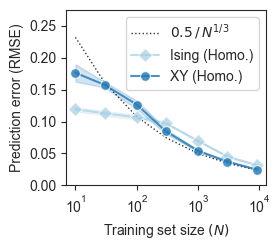

In [361]:
sns.set_style("ticks")
plt.figure(figsize=(2.9, 2.6))

N_list = np.array([10, 30, 100, 300, 1000, 3000, 9000])
Nalpha_list = 0.5 * N_list ** (-1/3)
plt.plot(N_list, Nalpha_list, label=r"$0.5 \, / \, N^{1/3}$", linestyle=':', linewidth=1, c='k', alpha=0.8)
    
df = pd.DataFrame(data=all_data_training_set_scaling, columns=["Training set size", "Model", "Seed", "Error"])
ax = sns.lineplot(data=df[df['Model'] == "Ising (Homogeneous)"], x="Training set size", y="Error", label="Ising (Homo.)", markers=True, marker='D', markersize=7, c='#A6CFE3', alpha=0.7)
ax = sns.lineplot(data=df[df['Model'] == "XY (Homogeneous)"], x="Training set size", y="Error", label="XY (Homo.)", markers=True, marker='o', markersize=7, c='#1F78B4', alpha=0.8)

# plt.plot(list_time, list_of_score_HXY, label='XY (Homogeneous)', linestyle='-', linewidth=1, marker='o', markersize=4, c='#AEDA87', alpha=0.8)
# plt.plot(list_time, list_of_score_HIsing, label='Ising (Homogeneous)', linestyle='-', linewidth=1, marker='D', markersize=4, c='#329D2B', alpha=0.8)
# plt.plot(list_time, list_of_score_DXY, label='XY (Disorder)', linestyle='--', linewidth=1, marker='s', markersize=4, c='#A6CFE3', alpha=0.8)
# plt.plot(list_time, list_of_score_DIsing, label='Ising (Disorder)', linestyle='--', linewidth=1, marker='^', markersize=5, c='#1F78B4', alpha=0.7)

ax.set_xscale('log')
plt.xticks([10, 100, 1000, 10000])
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.ylim(0.0, 0.275)

plt.legend()

plt.xlabel(r'Training set size $(N)$', fontsize=10);
plt.ylabel(r'Prediction error (RMSE)', fontsize=10);
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('SizeN-homogeneous.pdf', dpi=900)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

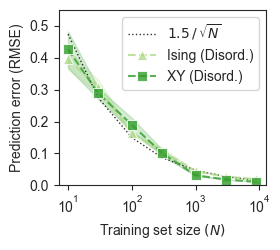

In [362]:
sns.set_style("ticks")
plt.figure(figsize=(2.9, 2.6))

N_list = np.array([10, 30, 100, 300, 1000, 3000, 9000])
Nalpha_list = 1.5 * N_list ** (-1/2)
plt.plot(N_list, Nalpha_list, label=r"$1.5 \, / \, \sqrt{N}$", linestyle=':', linewidth=1, c='k', alpha=0.8)

df = pd.DataFrame(data=all_data_training_set_scaling, columns=["Training set size", "Model", "Seed", "Error"])
ax = sns.lineplot(data=df[df['Model'] == "Ising (Disorder)"], x="Training set size", y="Error", label="Ising (Disord.)", linestyle='--', markers=True, marker='^', markersize=7, c='#AEDA87', alpha=0.8)
ax = sns.lineplot(data=df[df['Model'] == "XY (Disorder)"], x="Training set size", y="Error", label="XY (Disord.)", linestyle='--', markers=True, marker='s', markersize=7, c='#329D2B', alpha=0.8)

ax.set_xscale('log')
plt.xticks([10, 100, 1000, 10000])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim(0, 0.55)

plt.legend()

plt.xlabel(r'Training set size $(N)$', fontsize=10);
plt.ylabel(r'Prediction error (RMSE)', fontsize=10);
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('SizeN-disorder.pdf', d`pi=900)


# Error scaling with evolution time

In [12]:
# XY model with disordered field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_DXY, list_of_clf_DXY, list_of_bestk_DXY = train_sparse_ML(all_states, all_values)

# XY model with homogeneous field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HXY, list_of_clf_HXY, list_of_bestk_HXY = train_sparse_ML(all_states, all_values)

# Ising model with disordered field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-disorder-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-disorder-Ising/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_DIsing, list_of_clf_DIsing, list_of_bestk_DIsing = train_sparse_ML(all_states, all_values)

# Ising model with homogeneous field

N = 50
all_states = []
all_values = []

with open("50spins-oneZ-allt-homogeneous-Ising/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-oneZ-allt-homogeneous-Ising/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HIsing, list_of_clf_HIsing, list_of_bestk_HIsing = train_sparse_ML(all_states, all_values)


# Print out the test score
print(list_of_score_DXY)
print(list_of_score_HXY)
print(list_of_score_DIsing)
print(list_of_score_HIsing)

Pos: 0
Validate k = 1
0.1745066879795037
0.17420847094536368
0.1738470293524174
0.17325493951566062
0.1725062346062513
0.17207340105327876
0.1722701178757683
0.17351285603027763
0.17785817715095564
0.18986728242352685
0.21451956568661257
0.28444034100359095
Validate k = 2
0.05029997053056919
0.049277219598439795
0.04873003923300101
0.04871892815854752
0.04949734381174643
0.05235627365232079
0.06209869707095267
0.08538282018945406
0.13026578770534702
0.18750794446431668
0.21475087846753355
0.2846179136509488
Validate k = 3
0.04434950842003946
0.04019379380801462
0.03933884331128232
0.039939456602369264
0.04282791303029935
0.050427667869888934
0.06323373460727437
0.08636344474361739
0.13107481358799666
0.1885163153401796
0.21507639046784977
0.28485777833182163
Scores: 0.03933884331128232 0.007915236382114544
Pos: 1
Validate k = 1
0.19174102703713783
0.19149508574967009
0.19120899696925456
0.19074393405485784
0.1901656442085819
0.18997369486660307
0.19047315430760922
0.19221875414408102
0

0.08976065342793302
0.08995701710664987
0.0911631722059893
0.09566194215927601
0.108935848048338
0.13361255479205297
0.1538201149120686
0.15962376925669342
0.15962376925669342
Validate k = 2
0.06115756896125352
0.06009798400834939
0.05959295338059366
0.059903777034492296
0.06249194445485345
0.06991659509741986
0.08383329907711153
0.10635552462390893
0.13331720433118188
0.15363800613923995
0.15920692035923178
0.15920692035923178
Validate k = 3
0.05973884658725477
0.053885055751481656
0.053007747421609
0.05474441048349358
0.06056643217765898
0.07013929181389807
0.08388689220673425
0.10641835868132203
0.13341804641239233
0.153537242857817
0.15942764067428772
0.15942764067428772
Scores: 0.053007747421609 0.02897388745290167
Pos: 3
Validate k = 1
0.0856787351484311
0.08550897608395346
0.08535524674591481
0.08524458349705398
0.0854933657642194
0.08721495434270052
0.09236524170836802
0.10599014170069593
0.12781261357166476
0.14458044252085547
0.15171290884042057
0.15171290884042057
Validate k

0.21621591925474976
0.2208253449394132
0.23220579494869117
0.2519536442771527
0.31365085154581784
Validate k = 2
0.13368902563273907
0.13227445241138922
0.13090262549620735
0.12948191906096512
0.12902301990672735
0.129975005733206
0.13441962445961486
0.14605288855889256
0.16964377059780503
0.20994179621892867
0.25205024965252254
0.31371755964941633
Validate k = 3
0.07595447805063604
0.06803655479271774
0.06540278373133389
0.06489975300138728
0.06741965759144379
0.0753735940156255
0.09186189052876284
0.11944727712989808
0.16409474012419067
0.20947876119409892
0.2521538913816608
0.31380666594251205
Scores: 0.06489975300138728 0.04902412952128371
Pos: 5
Validate k = 1
0.1790253499700724
0.17877236843722638
0.17847559584336664
0.17799320110222938
0.17738563093958248
0.17712407386600687
0.1775110600003707
0.17938814955389842
0.1856036856373511
0.20138184651146274
0.22576513184249578
0.2767045758393685
Validate k = 2
0.13463816152361266
0.1333227218126064
0.13208361070772726
0.13070948097227

0.07203576157592693
0.07130063930087585
0.07114042714409285
0.07245438146947811
0.07745905682292872
0.08789428620946929
0.09919076114213227
0.10722914091058643
0.11395197846816664
0.1184415650348373
0.1184415650348373
0.1184415650348373
Validate k = 3
0.061971278314808
0.05678323405240021
0.056712223824772826
0.061021296733167515
0.07126882398936431
0.08703671675386747
0.09894242023851196
0.10735668836170748
0.11419561103605329
0.11848053249837172
0.11848053249837172
0.11848053249837172
Scores: 0.056712223824772826 0.035616811446614396
Pos: 7
Validate k = 1
0.09637805252491308
0.09621889061973717
0.0960609917218505
0.09593784653776416
0.09608913061868679
0.09738292619493964
0.1009395640327977
0.10735100757716855
0.1152924354087985
0.12038519030036879
0.12038519030036879
0.12038519030036879
Validate k = 2
0.07018826988859678
0.06945451749505882
0.06926719830546915
0.07041294338623258
0.07479506800809071
0.08376199415904595
0.09669044422727532
0.10709773548782289
0.11518299776736214
0.12

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

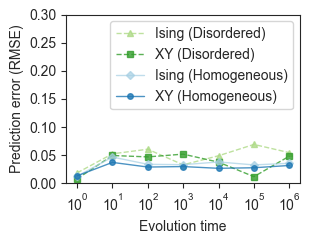

In [239]:
%matplotlib widget
sns.set_style("ticks")

plot1 = plt.figure(figsize=(3.2, 2.55))

list_of_score_DXY = [0.007915236382114544, 0.04947091105957198, 0.04697752770941811, 0.05191098963262961, 0.03764809304216626, 0.011861222560826395, 0.04830875023735673]
list_of_score_HXY = [0.013256966670524326, 0.03721494102988028, 0.02897388745290167, 0.029803642600065405, 0.026695180719768098, 0.027710837095259566, 0.03173716275137415]
list_of_score_DIsing = [0.018531582079668242, 0.05244811900644047, 0.060618771949532635, 0.032888046159887455, 0.04902412952128371, 0.06912464490177862, 0.054527279125304154]
list_of_score_HIsing = [0.012453854027517147, 0.046725475639309094, 0.033806992302953455, 0.0331672725880195, 0.037965462774408515, 0.032736439079639836, 0.035616811446614396]

list_time = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]
plt.plot(list_time, list_of_score_DIsing, label='Ising (Disordered)', linestyle='--', linewidth=1, marker='^', markersize=5, c='#AEDA87', alpha=0.8)
plt.plot(list_time, list_of_score_DXY, label='XY (Disordered)', linestyle='--', linewidth=1, marker='s', markersize=4, c='#329D2B', alpha=0.8)
plt.plot(list_time, list_of_score_HIsing, label='Ising (Homogeneous)', linestyle='-', linewidth=1, marker='D', markersize=4, c='#A6CFE3', alpha=0.7)
plt.plot(list_time, list_of_score_HXY, label='XY (Homogeneous)', linestyle='-', linewidth=1, marker='o', markersize=4, c='#1F78B4', alpha=0.8)


plt.xscale('log')
plt.ylim(-0.0, 0.3)
plt.xlabel("Evolution time")
plt.ylabel("Prediction error (RMSE)")
plt.xticks(list_time)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('Evo-time.pdf', dpi=900)

# Error scaling with system size

In [127]:
all_score = []
all_std = []

for N in [10, 20, 30, 40, 50]:
    all_states = []
    all_values = []

    with open("Sys-" + str(N) + "spins-oneZ-allt-homogeneous/states.txt") as f:
        for line in f:
            all_states.append(ast.literal_eval(line))

    with open("Sys-" + str(N) + "spins-oneZ-allt-homogeneous/values.txt") as f:
        for line in f:
            all_values.append(ast.literal_eval(line))

    list_of_score_N, list_of_clf_N, list_of_bestk_N = train_sparse_ML(all_states, all_values)
    
    for v in range(len(all_values[0])):
        all_std.append(np.std(np.array(all_values)[:, v]))
    
    all_score.append(list_of_score_N)

print(all_score)
print(all_std)

Pos: 0
Validate k = 1
0.238658188916499
0.23862582315988756
0.2385856269510222
0.2385147417285325
0.23842415717938636
0.23845712676325623
0.2388304976060893
0.23983326520195264
0.24325637098014205
0.2564810602581238
0.3036492775689448
0.35944222323126346
Validate k = 2
0.07598392678175972
0.0757784830861144
0.07562792437531217
0.07557803716231469
0.07594122945814683
0.07751119797277797
0.08354028307260294
0.09835450264838416
0.1337404815548811
0.22524222682252037
0.3041202360072497
0.3596732477015424
Validate k = 3
0.04318926392701283
0.04251754299816206
0.04243192166326372
0.04296214000700865
0.04502850306483264
0.052450506890268256
0.07121990630617353
0.09794262286467736
0.13344146800321774
0.22507274524425383
0.30473170760382484
0.36033005059357437
Scores: 0.04243192166326372 0.01322497269545254
Pos: 1
Validate k = 1
0.1563651484232806
0.1563328103819973
0.15629689213946396
0.156248357811079
0.1562465556776596
0.15649072730178312
0.15735038436627555
0.16039661492226928
0.17037562799

0.1345120351345599
0.13606572910421444
0.14156499613751533
0.15747853488240854
0.19281488119740592
0.22215476249025767
0.2494300587733484
Validate k = 2
0.06331062659214669
0.06299026868168607
0.06286789850982484
0.06313170342178026
0.06463621621108895
0.06984064475864112
0.08258287989568441
0.11134260573010953
0.15291882655224115
0.1923207349208442
0.22158969597525582
0.2500819573649523
Validate k = 3
0.054367515874000766
0.05273206539524915
0.05245352536648073
0.053893363727626584
0.05863487593991557
0.06902941856530441
0.08240970537637085
0.11130706874428375
0.1533868851716717
0.19287503525790428
0.22198147862559242
0.24985260325385714
Scores: 0.05245352536648073 0.030699445164745386
Pos: 3
Validate k = 1
0.13646868475529736
0.13639335145452033
0.13631183884686643
0.13621383973279994
0.13617992765013437
0.1366067338299901
0.13815130685809096
0.1421103569738252
0.15663283715908677
0.19028951947989617
0.23659568662552966
0.2512290311893053
Validate k = 2
0.09557717750510099
0.09519897

0.16545290669869545
0.21162852025453244
0.21162852025453244
Validate k = 2
0.07052634262933392
0.07003515332079462
0.06975552821386308
0.06995251524911458
0.0718271078571536
0.07767655523610602
0.08942172469250963
0.10886306371185027
0.12855575702962022
0.1653083020618598
0.21182841680805903
0.21182841680805903
Validate k = 3
0.059137248158162015
0.05585093420348794
0.05530278956520735
0.056988778837527114
0.062259576099524094
0.07246120353478827
0.0895030745371978
0.10879868583378162
0.12836481266093458
0.1652597476387852
0.2105604001616631
0.2105604001616631
Scores: 0.05530278956520735 0.032373592811570505
Pos: 5
Validate k = 1
0.11121797431409303
0.11114434447590978
0.11107493302702297
0.11099922861412322
0.11109084214859867
0.11181978844097351
0.11444567121943072
0.12287417648459636
0.1405124449990395
0.1725990955158617
0.2066361906441387
0.21418446837200478
Validate k = 2
0.06783695874645149
0.06726831214213229
0.0669247900471448
0.06705101183703832
0.06886365902291228
0.074801844

0.0669874613612644
0.0662609437073462
0.06589860677194213
0.0661996075405964
0.06854928761550404
0.0751936662471698
0.0878951430057843
0.1028966123116759
0.12553028283081885
0.16067803186317722
0.17264928847702593
0.17264928847702593
Validate k = 3
0.060823480056930515
0.05650015576108855
0.0559284957942369
0.05811779794726258
0.06447954525291624
0.07413569377953282
0.0876633910565133
0.10252878352410529
0.12527707626362725
0.16084274526839182
0.17328403404784118
0.17328403404784118
Scores: 0.0559284957942369 0.03341170415568
Pos: 7
Validate k = 1
0.09112065075982116
0.09099697957381975
0.09088091734901405
0.09076475576126689
0.0909305322322268
0.09226574505148552
0.0969796809203818
0.10930994670798597
0.12776436209232508
0.15422982084090503
0.17016038326858757
0.17016038326858757
Validate k = 2
0.07126293168213321
0.07053423559867847
0.0700994231275634
0.07041322931554043
0.07301153408154566
0.08104291927790949
0.09594197857494435
0.11090411225821271
0.12974863539775755
0.155847080090

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

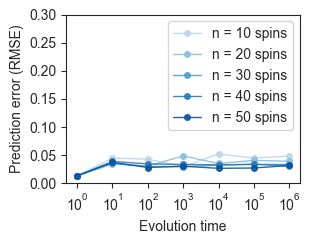

In [233]:
%matplotlib widget
sns.set_style("ticks")

plot1 = plt.figure(figsize=(3.2, 2.55))

list_time = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

all_score = [[0.01322497269545254, 0.04479558921588049, 0.04292973910856739, 0.029978702246647934, 0.052000697259225445, 0.04494183912184762, 0.048572455160393914], [0.013238151411245697, 0.034490569038691764, 0.030699445164745386, 0.04863870949641657, 0.03528956178937412, 0.04077764991409794, 0.03918693649968483], [0.013327195712980354, 0.03543493750607781, 0.030076289465591825, 0.029608329621221716, 0.032373592811570505, 0.03404159565397256, 0.030068691637193418], [0.012905884564335715, 0.038844056207704196, 0.034592378302616404, 0.03352689516506794, 0.03299109407866409, 0.03360457955846986, 0.03341170415568, 0.03634060633516722], [0.013598927845442432, 0.03730917782077512, 0.028135506651756566, 0.030428638086740904, 0.026699431994580268, 0.027228809474526966, 0.031829182030938936]]

normal_score = []
cnt = 0
for n in range(5):
    ls = []
    for x in range(len(all_score[0])):
        ls.append(all_score[n][x])# / all_std[cnt] * all_std[1])
        cnt += 1
    normal_score.append(ls)
        
plt.plot(list_time, normal_score[0], label='n = 10 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[1], alpha=0.9)
plt.plot(list_time, normal_score[1], label='n = 20 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[2], alpha=0.9)
plt.plot(list_time, normal_score[2], label='n = 30 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[3], alpha=0.9)
plt.plot(list_time, normal_score[3], label='n = 40 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[4], alpha=0.9)
plt.plot(list_time, normal_score[4], label='n = 50 spins', linestyle='-', linewidth=1, marker='o', markersize=4, c=sns.color_palette("Blues")[5], alpha=0.9)


plt.xscale('log')
plt.ylim(-0.0, 0.3)
plt.xlabel("Evolution time")
plt.ylabel("Prediction error (RMSE)")
plt.xticks(list_time)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('System-size.pdf', dpi=900)

# Visualize predictions

In [2]:
N = 50
all_states = []
all_values = []

with open("50spins-allZ-many-t-homogeneous/states.txt") as f:
    for line in f:
        all_states.append(ast.literal_eval(line))

with open("50spins-allZ-many-t-homogeneous/values.txt") as f:
    for line in f:
        all_values.append(ast.literal_eval(line))

list_of_score_HXY_vis, list_of_clf_HXY_vis, list_of_bestk_HXY_vis = train_sparse_ML(all_states, all_values)


Pos: 0
Validate k = 1
0.03689268273717967
0.03675274292002468
0.03664886912476939
0.03658156623204222
0.036586871809294624
0.036704738088962255
0.037173660984349516
0.038995361115104626
0.04556365318375102
0.06556127319996094
0.11483800236226988
0.2207860431827274
Validate k = 2
0.038392774311917344
0.03732879447317554
0.03683958128969139
0.03669763887451952
0.0367133835693784
0.036831630174813466
0.03730043040862338
0.039118647310789276
0.04567201337852763
0.06563887133973546
0.11488489543063538
0.22081361681461384
Validate k = 3
0.04161202543409383
0.03760930523813985
0.03689066720122056
0.036716252316090624
0.036737139040879746
0.03685527705453021
0.03732380520947
0.03914129145394191
0.04569262368795102
0.06565484856047987
0.11489502775616472
0.22081947472432187
Scores: 0.03658156623204222 0.0009405408125936165
Pos: 1
Validate k = 1
0.03675519722112802
0.0365654094995643
0.036437848663498085
0.036354962219892414
0.036368914536195264
0.03648563433012777
0.036950907476662354
0.0387601

0.22033020883487703
Scores: 0.03657365479206852 0.000496574828013811
Pos: 10
Validate k = 1
0.037445432955335936
0.03722003799472906
0.037055939830785894
0.03694863440838593
0.03699316328505334
0.03710925820535313
0.037568120320598176
0.039351730262280525
0.04580024816211099
0.06553504975731657
0.1143877320736827
0.21964571378563452
Validate k = 2
0.03738402236907034
0.03651001148536627
0.036149092129919125
0.03608571707850962
0.036107721302468344
0.03622705590805952
0.036699083524454584
0.03852657297523946
0.04509729814057815
0.06504766400841344
0.1141102743453696
0.21950293086632447
Validate k = 3
0.0419398725269279
0.03762659147731979
0.03675097058351918
0.03653537857246256
0.03653528066215048
0.03665218462949457
0.037117665828414095
0.0389238200675293
0.04543580081294245
0.06528264307209769
0.11424399182482285
0.2195714527456604
Scores: 0.03608571707850962 0.001434735448565573
Pos: 11
Validate k = 1
0.03610827067347703
0.03592954156720837
0.03580722269131499
0.03573243460741532
0.0

0.045586539386757934
0.06543863904350904
0.11445146329264667
0.2199281044675933
Scores: 0.03666489909966095 0.0008234545338927492
Pos: 20
Validate k = 1
0.037226785715511274
0.03701718558855536
0.03689229177749867
0.03682293495794639
0.03683407893098688
0.03694919630625189
0.03740874133288446
0.039198148176573876
0.045668559681518284
0.0654484393894631
0.11435514600882728
0.2196712062166236
Validate k = 2
0.03851217649002356
0.03749542796210574
0.03693026450839387
0.03670640238416526
0.03671778405271704
0.03683454465504166
0.03729778283723578
0.039095600102876896
0.04558346110614379
0.0653909168334651
0.114325806777525
0.2196611307084549
Validate k = 3
0.04137906552082227
0.0372827189345489
0.036342855715820015
0.03607269494099185
0.036081202746598845
0.03619962764198151
0.03667020625139637
0.03849649952845064
0.045070889230009015
0.06503700710320728
0.11412639414219142
0.21955951554932657
Scores: 0.03607269494099185 0.0013713869158947364
Pos: 21
Validate k = 1
0.03759087934259804
0.03

0.03612054739435819
0.03658795418601061
0.03840151249198726
0.044933350759031036
0.06479012779604995
0.11364526709353001
0.21860199609607206
Scores: 0.03598227930986859 0.001005829650237186
Pos: 30
Validate k = 1
0.03665072244539113
0.036475938859354004
0.03635706234979614
0.036281296664218615
0.03629630917012752
0.03641459364547027
0.036882165122346246
0.03869210415248425
0.04520595375970836
0.06502796728457373
0.11387962808769804
0.2189262478154404
Validate k = 2
0.03768872187637434
0.0367646025851716
0.036363062745525754
0.03619237840573679
0.0361962759562504
0.03631382275109747
0.036780781296131736
0.038593119128465844
0.04512100330834912
0.06497229690435524
0.1138507379949105
0.21891260563902915
Validate k = 3
0.041663220209839105
0.03754187859864484
0.03679630274848461
0.03676121202558316
0.03679898307735997
0.03691480850656894
0.03737467508362193
0.0391601963791737
0.04560677781643771
0.0653072010347429
0.11403680129776309
0.2190038890430499
Scores: 0.03619237840573679 0.0010174

0.037229176933136744
0.03701294730486292
0.037027171210157375
0.037143587982360324
0.03760411053638811
0.03939254096160298
0.04585378745863396
0.06561763879864778
0.11453498252948624
0.21993101300801
Scores: 0.03617622422207856 0.0018585494065022972
Pos: 40
Validate k = 1
0.036935681161718366
0.036721636996340026
0.03657381676955739
0.03647826749864575
0.03649528493221877
0.03661308049258907
0.037081428866931
0.03890020805742677
0.04545624910125921
0.06541380542032421
0.11458940112441748
0.22031740949686127
Validate k = 2
0.03795605625360545
0.037030444267568144
0.0365700557075009
0.03643617108527168
0.03644196855535087
0.036560393687984416
0.0370302655372791
0.03885286147283639
0.04541750010092377
0.06538865878068073
0.11457730010811508
0.22031378777839178
Validate k = 3
0.04240295108727723
0.03816597398626676
0.03709785568366143
0.03687244119411366
0.036900977976364956
0.03701805606240877
0.037482460306704296
0.039284748939617566
0.04578921547150128
0.06565048083933223
0.114730409492

0.21941224325268743
Validate k = 3
0.04222419320250746
0.037422406917102524
0.036474395904696325
0.03632022711919261
0.03634623315793483
0.036463774662801096
0.036930795746395434
0.038743862498202386
0.04527840931273842
0.06516763633639142
0.11416696273618453
0.21950741191118495
Scores: 0.03569872261230516 0.0007834082566068979
Pos: 50
Validate k = 1
0.20083692769059447
0.20057549464854224
0.20025126917349176
0.19971304391224703
0.19892584069175537
0.19808955130773662
0.1979582727950784
0.19866141921861333
0.20147507792202896
0.21235970897530065
0.2512282874629672
0.31865642680183703
Validate k = 2
0.04969888452041037
0.04866625861606538
0.04804791524010893
0.047820438637444035
0.04811930802317873
0.049473367407325254
0.05455438019242529
0.0664860572943741
0.09418683806983039
0.16332390089224696
0.25123130259131293
0.31860872994548434
Validate k = 3
0.04494486929620453
0.040385421837772564
0.03938852047851736
0.03935688808212754
0.04023221165255127
0.0436621068196329
0.0548970068490054

0.04765916149306839
0.0430029111432323
0.04227383542732723
0.04259112993396043
0.04463579037395825
0.05214362634101788
0.07111800153953979
0.09835377817403132
0.1331559415536814
0.2235373946625283
0.30491530070947404
0.3617353929161018
Scores: 0.04227383542732723 0.013479308647953447
Pos: 60
Validate k = 1
0.24002494351359666
0.23982437048790872
0.23957573542155947
0.2391480505986413
0.2385892155137402
0.23819215317740533
0.23820852491096442
0.23899046347017777
0.2423195671936077
0.2551904817591984
0.30120919802543245
0.3585198172170562
Validate k = 2
0.08095683452221476
0.07949387018587173
0.07831039572524218
0.07735791582064827
0.07741311462043304
0.0789797656073796
0.08512970322132485
0.09930611766615657
0.13441630848545605
0.22559296271506535
0.30228031133104594
0.3602913636441254
Validate k = 3
0.04905252406347131
0.043892813840704044
0.042799059844318074
0.042961875131061186
0.04496855487750208
0.05239494494614483
0.07192789819916334
0.09914111087797561
0.1342729579333425
0.22547

0.044469283428859196
0.051887291497418365
0.07045953598334058
0.09818643562307479
0.13331789535896518
0.22424739638900243
0.3070344543478867
0.36145764214915754
Scores: 0.04227841571229008 0.013714372407134095
Pos: 70
Validate k = 1
0.24353995100417694
0.24329703898156524
0.24300342943403375
0.24249645072465942
0.24177912918117028
0.24093826356000553
0.24070946530828324
0.24157738536901538
0.2450057353052637
0.2582664150329386
0.3055730198120721
0.3596697293568581
Validate k = 2
0.0791527570796364
0.07795746216655232
0.07704781971942452
0.07632201660236636
0.0764784533454484
0.07804426326204539
0.08405896326524692
0.09816244862122886
0.13367346465616164
0.22539306677384116
0.30650396868174135
0.3599969946804067
Validate k = 3
0.048304600491607536
0.04309522646588001
0.04198581758819527
0.04223519858302364
0.044302030411719304
0.05182162869984966
0.07052011602861152
0.09757660167364776
0.1332427911401463
0.22513481219133696
0.3057219812737617
0.3593862390376696
Scores: 0.041985817588195

0.09727961875839884
0.13224491702218766
0.2227003453535714
0.3033394535286457
0.36192689183921345
Scores: 0.04262215478499505 0.013741913024865732
Pos: 80
Validate k = 1
0.2394844760212428
0.23923833085375712
0.23894315507196703
0.23845252309199197
0.2377489528015402
0.23715328422247084
0.23730973220204735
0.23829435845809288
0.24169270582327812
0.25483860284083615
0.301650171194762
0.3577641103463346
Validate k = 2
0.07964002184430512
0.07823812604019825
0.07711634887440214
0.0762817325724486
0.07630210056853048
0.07786429547417933
0.08407577471258922
0.09938942884519386
0.13524765768995212
0.2279056998432485
0.30214701780623276
0.3584950227152015
Validate k = 3
0.04778449109896502
0.04290660817569336
0.042000571345433446
0.04240393972172849
0.04446706993986705
0.05187968217889991
0.07026080078443593
0.09908551761466844
0.1350227928787669
0.22777334640445657
0.3019280897459458
0.35822818263394907
Scores: 0.042000571345433446 0.013912538825036142
Pos: 81
Validate k = 1
0.23947098159020

0.3029956074868765
0.3589912180313416
Scores: 0.042859582664091345 0.013217831035132193
Pos: 90
Validate k = 1
0.24473068668396397
0.24453666118535114
0.24430841390127916
0.24393595836268298
0.24340326177381083
0.2428161081670624
0.24288532898036894
0.2437589762962162
0.24705000535668772
0.25980471540908945
0.3055543399541778
0.36322262887391
Validate k = 2
0.07889600122337631
0.07750834413253016
0.07637253204836034
0.07546974461686527
0.07556161554292438
0.07712409299325726
0.08325874565207769
0.09734603193048302
0.13174111189337287
0.22106308946287126
0.305663675893828
0.363287085036366
Validate k = 3
0.04794121472335979
0.04350876263575419
0.04245668674037551
0.04260023907877216
0.04461464823761345
0.05208116405468974
0.07107877123546023
0.09795106495274455
0.13218029287889616
0.2213193211295912
0.3062548663307189
0.36375187343196225
Scores: 0.04245668674037551 0.013632622900303178
Pos: 91
Validate k = 1
0.2410255862461102
0.24082955461677297
0.24059076286609105
0.2401823647375105
0

0.24729889644584807
0.2470609512964348
0.24676231281481412
0.24624349777730792
0.24546542091654194
0.24466791592001555
0.244576270693419
0.24582553358176742
0.25013888342309054
0.26675024907671285
0.303512908529823
0.3861315052088435
Validate k = 2
0.10292819735695388
0.10143285937871768
0.10011617172464111
0.09872954131861413
0.09825981790595513
0.09951076484650404
0.10451588818215496
0.11953953181977447
0.16278432479967606
0.24292009182405405
0.30360987094379754
0.386240741252018
Validate k = 3
0.057632826118379145
0.0514675128444264
0.04977299071818503
0.04984981430335177
0.0520283925553177
0.058758219391611216
0.07748756871174343
0.1185618579117052
0.16228809332180136
0.2426659368628634
0.30345449298034055
0.3864747985671974
Scores: 0.04977299071818503 0.027785118954598186
Pos: 101
Validate k = 1
0.19153074732876452
0.19127063652510873
0.1909539650399985
0.19042169426298106
0.18974313168976578
0.18927600213771073
0.18971378916782972
0.19186978623317144
0.19971742528438297
0.2225884

0.1717427102975362
0.1827001982459363
0.21669836950372764
0.27009480958363596
0.2701061220991968
Validate k = 2
0.101758373335507
0.10042081022335599
0.09926002402755191
0.09830140301988534
0.09861785928817896
0.10165236903367034
0.11052758351111984
0.13007346638847797
0.17939342916380013
0.21656304684963926
0.27031213792420644
0.27031213792420644
Validate k = 3
0.07853305269656266
0.07020323973618053
0.06708264584966792
0.06662125350687824
0.06990414866850754
0.08044294218826488
0.10404529139674079
0.13063130964886274
0.17949942385780018
0.21645551913978026
0.2702816565226279
0.2702816565226279
Scores: 0.06662125350687824 0.04908080176600455
Pos: 111
Validate k = 1
0.16779591432550806
0.16756529841762163
0.16728699949398065
0.16684968369382275
0.16635800330675593
0.1662138463017749
0.1671017183398285
0.17028780092123869
0.18123642263481785
0.2144300005681234
0.272671129374199
0.27471293033904987
Validate k = 2
0.101753385523433
0.10045538699254922
0.09932921510073282
0.098403068527692

0.1004839884487927
0.09931944975971256
0.09838548890008278
0.09776589888436142
0.09819285005491027
0.10104536262574815
0.10917141269808474
0.12773147821020578
0.17596292979621578
0.2171995453003889
0.2752245723830171
0.2765661084025408
Validate k = 3
0.07531352427794452
0.06767112870583161
0.06550893322134659
0.06567056169694488
0.06916477457428458
0.0799251455718382
0.10269389054549552
0.12774413980815597
0.17686547837524794
0.2177433391743276
0.27589660137199884
0.2774052861400435
Scores: 0.06550893322134659 0.04872448925826793
Pos: 121
Validate k = 1
0.17030506530019213
0.17007244979562294
0.16979566447828096
0.16935955635457262
0.16881069745039579
0.16852391254432583
0.16936740765690259
0.17261873501843616
0.18341134549879104
0.21816689856568047
0.2755756975845047
0.2763258243696201
Validate k = 2
0.09909726154447272
0.0977581677997586
0.09659585089034245
0.0956438489363317
0.09599291476840868
0.09908587205472583
0.10738792785876827
0.12699814546241345
0.17532844272341208
0.2180113

0.0969572077918731
0.09982088090239383
0.10887127336453489
0.12815870314192734
0.17658161418379836
0.21570519071901356
0.2732026997631272
0.2732026997631272
Validate k = 3
0.07620445477308027
0.06853685732174462
0.06601582716887429
0.0659035988902186
0.06903415330454646
0.07925644332672924
0.10322663803808084
0.1293310938802679
0.17769456642765752
0.21584587896545998
0.27380786920101735
0.27385901145684743
Scores: 0.0659035988902186 0.05029752491571697
Pos: 131
Validate k = 1
0.172624235449515
0.17240238289381998
0.1721504200866442
0.17175563077287453
0.17129706475322715
0.17107977284992673
0.17183307496818004
0.1747848111161785
0.18539117915010056
0.21953272023850803
0.2767883282628888
0.2780330858814891
Validate k = 2
0.10328239924819409
0.10188847981997401
0.10069295900677397
0.09968230806528755
0.0999603602187987
0.1028267961033404
0.11071647094744985
0.1284288875649452
0.1757585149039208
0.21942686794995936
0.2768814067650217
0.27791834791121106
Validate k = 3
0.07566462942306104


0.21671985609175615
0.27495384790392263
0.2755938437735577
Validate k = 3
0.07665707140535677
0.06871010930311348
0.06614210369679142
0.06612418343746891
0.06931178414583812
0.07980929525502953
0.10293928916845901
0.1283534738037915
0.17640521745821153
0.2167713724961213
0.27480010710032554
0.2753051277059898
Scores: 0.06612418343746891 0.0503608788878308
Pos: 141
Validate k = 1
0.16916531052887915
0.1689302447292083
0.16865260929472461
0.16819623244467546
0.16763364522411828
0.16731808037728868
0.168106111852014
0.1711137812184743
0.18193259536632755
0.21590590283940822
0.27269810936047706
0.27380837780571343
Validate k = 2
0.10211458501005571
0.1007127694315033
0.09950162472855999
0.09854160807748061
0.09890365997211631
0.10180341251906627
0.1108308837932737
0.1299257958444339
0.17807947035787053
0.2163753328038396
0.2725656221632968
0.27378937507864354
Validate k = 3
0.07567230827024973
0.06783656713463188
0.06522012182271494
0.06501711023090008
0.06821408134662718
0.078776629697716

0.06537597794859443
0.06308336835022882
0.06280513727610967
0.06538550218185069
0.07392363801474841
0.09566835779070477
0.13349234008100958
0.18152769114227743
0.24647268136792197
0.2924547787238208
0.33266670858734926
Scores: 0.06280513727610967 0.04558171806135781
Pos: 151
Validate k = 1
0.18848788680572126
0.1882641633762216
0.1879863589511864
0.18752699550199056
0.1868752348274646
0.18641427967031332
0.18711632608100756
0.1904021864884275
0.20105813067961695
0.22254858419335766
0.25940968941354237
0.31201318427465424
Validate k = 2
0.0961634204744275
0.09475042063583192
0.09358829356171383
0.09261226307185516
0.0929126786883505
0.0961039804507256
0.10572596426336907
0.12916699193812708
0.16293098093214392
0.22019468438120482
0.2596309083201283
0.31250304126974193
Validate k = 3
0.07678072989714041
0.06933905948008623
0.06694989920927799
0.06669646750074613
0.07015563310818716
0.08060777467899197
0.10018403276833937
0.12872259065708935
0.1624824063929365
0.21960362686993073
0.258927

0.05930005160050598
0.06498966001693605
0.0807106540568589
0.0980518977317264
0.12964189656708003
0.16064801509067184
0.19075172495205306
0.1940802932176775
0.1940802932176775
Scores: 0.05841426107438407 0.037724219826655844
Pos: 161
Validate k = 1
0.12563275957826828
0.12543800594159554
0.1252212326142591
0.12489774748511268
0.12460674476516416
0.12488552102194686
0.12712638790764455
0.1354282235022921
0.1616101778865538
0.1918050293871674
0.194581285163055
0.194581285163055
Validate k = 2
0.08151683944098963
0.08026086409807888
0.07931937983911402
0.07885174123859207
0.08026134529846503
0.08498988783874059
0.09815188250620971
0.12932605816809206
0.1615888211502728
0.19200421974977727
0.19458035904577936
0.19458035904577936
Validate k = 3
0.06713860546592525
0.060683991618351016
0.0587787697609174
0.05966268528236804
0.06553540306965487
0.08220413379888318
0.09893617918820753
0.12956411524083072
0.16191513322814063
0.19228584387126949
0.19478638420784838
0.19478638420784838
Scores: 0.

0.0813666868421812
0.09743449091930129
0.1281487841191768
0.16074738512060927
0.1913611330515511
0.19451640609164692
0.19451640609164692
Scores: 0.058038831170996494 0.03701859150263433
Pos: 171
Validate k = 1
0.12513885275497122
0.12490768585559262
0.12465445295512537
0.12427751060819578
0.12403235441269607
0.1245167897307548
0.12682432174359193
0.1348284721077287
0.16123742126239016
0.19059926720571332
0.1929905206012673
0.1929905206012673
Validate k = 2
0.081009984998672
0.0798386134595896
0.07895226464652717
0.07857953242616558
0.08004340183258693
0.08495543006064599
0.09838166973135382
0.12811175580479792
0.16150803981950987
0.1909938987262219
0.19339905168557253
0.19339905168557253
Validate k = 3
0.06633602716068399
0.059492341675714176
0.057612520612621745
0.05851061253113789
0.06468451546116509
0.08085441567598775
0.09820301396087594
0.12796266624681013
0.16123038274267507
0.19046522234786997
0.1927650762565319
0.1927650762565319
Scores: 0.057612520612621745 0.03678316818767636

0.16064077620465866
0.1900117444465529
0.1932065697348338
0.1932065697348338
Scores: 0.05818596793255761 0.037178534770541116
Pos: 181
Validate k = 1
0.12673968811677852
0.1265463985783895
0.12633168469196512
0.12603425436388532
0.12578696013465318
0.12610306259684548
0.1283424850834169
0.13610804805499482
0.16194620640411322
0.19258866036337977
0.19692199210180647
0.19692199210180647
Validate k = 2
0.08211531609853978
0.08101188802109377
0.0802223234933311
0.0799011291890157
0.08124240172673461
0.0859544014041426
0.09851289627591095
0.12887038309283563
0.16236256714620495
0.19280631786130817
0.197278519620342
0.197278519620342
Validate k = 3
0.0656193670325486
0.05935364785551367
0.058017475842187416
0.059079432091538875
0.06490599884701212
0.08113320383042699
0.09827768954612308
0.1278133691891353
0.16149847703801934
0.19274724429314682
0.19722106792898506
0.19722106792898506
Scores: 0.058017475842187416 0.03672998933092356
Pos: 182
Validate k = 1
0.12617632716698035
0.12598939837604

0.2048324024763109
Scores: 0.05600677211908836 0.03442740127672078
Pos: 191
Validate k = 1
0.10622874758561603
0.10604209901035622
0.10584077546670283
0.10559149868329186
0.10553867774646325
0.10614695165863211
0.10835062152786452
0.11579501641672138
0.1401457439289211
0.17096022578558057
0.19624091675784233
0.22992442257842077
Validate k = 2
0.07614880115109446
0.07492198959390475
0.07412388478484475
0.07405794640685995
0.07575253700125581
0.07975895378398593
0.09035246123870194
0.1136844576874411
0.14106387583698116
0.1712260443166211
0.1966001079515459
0.22958606185430994
Validate k = 3
0.06679065303090911
0.05997034996638501
0.05817944539133185
0.058876864193085104
0.06380912005197914
0.07596679853234015
0.08892453285439532
0.11230949665278393
0.13943991504960818
0.16956353707760147
0.19498478684786028
0.2278038519974771
Scores: 0.05817944539133185 0.03950605853183574
Pos: 192
Validate k = 1
0.11949637935563115
0.11927850503235282
0.11904721630355057
0.11872535733408915
0.118527354

0.09129039603991479
0.0910876386471434
0.09088586839347622
0.09068737961654205
0.09092352866531665
0.0924813871510897
0.09735591070718633
0.109887387001066
0.1355918878963286
0.15108563241992717
0.15108563241992717
0.15108563241992717
Validate k = 2
0.06646530565376257
0.06550550254557694
0.064953025349833
0.06525044146094411
0.06824032551621508
0.07706624032142191
0.09245961219872618
0.1099732645525115
0.13600083555285888
0.15135224153299467
0.15135224153299467
0.15135224153299467
Validate k = 3
0.061252410476340884
0.05521340174526772
0.05435519506989449
0.056509216260366195
0.0631037032259906
0.07666931778665732
0.09234002342118547
0.1096931943386766
0.13582392643446634
0.15074504417199336
0.15074504417199336
0.15074504417199336
Scores: 0.05435519506989449 0.031079408172951472
Pos: 202
Validate k = 1
0.09211379519172157
0.09195529943560257
0.09180352807067675
0.09168774447819147
0.09189831431021321
0.09339031831732322
0.0983431067146474
0.11290808045749315
0.13629974417241086
0.1456

0.08180394746929119
0.08209337607034867
0.08358173598487975
0.08816939252269632
0.1012352958390017
0.12507798807168224
0.15329120073082095
0.1624527710182351
0.1624527710182351
Validate k = 2
0.06743710680526471
0.0665133714979925
0.06601801337699845
0.06633171971419721
0.06880544376789885
0.07511250673980362
0.084906747444812
0.10128567656113975
0.1252044292948312
0.15348548072784046
0.16281851382103374
0.16281851382103374
Validate k = 3
0.059278174833760196
0.05374243571121972
0.0528905981099546
0.054813043573047206
0.06085884875098518
0.07143660474702129
0.08459581797656147
0.10081718546852486
0.12411401205977747
0.15236286263900908
0.1619216196147982
0.1619216196147982
Scores: 0.0528905981099546 0.028766369570653406
Pos: 212
Validate k = 1
0.09367781439541095
0.09348648038764978
0.09329632272185658
0.0930909001703444
0.09324446875439671
0.0946334494923578
0.09889870944410234
0.11082468904874543
0.13338466262438448
0.14937345908543925
0.1678618778855259
0.1678618778855259
Validate k

0.10237719855528456
0.12601715088154908
0.15869168363237499
0.1640870467997409
0.1640870467997409
Validate k = 2
0.06441795380606911
0.06326789894262248
0.0625848171413031
0.06278683665818321
0.06512493713773926
0.07192117842421619
0.08596921806945783
0.10250264714594634
0.12596965153150078
0.1585129566505861
0.16454056964578545
0.16454056964578545
Validate k = 3
0.06165976024679927
0.055743104413328526
0.05431829370292389
0.05534861285132833
0.060347134063413965
0.07081154849719402
0.08600669576951528
0.102455948740479
0.1257850084599891
0.15910535235180415
0.16490760450259573
0.16490760450259573
Scores: 0.05431829370292389 0.0319415230202651
Pos: 222
Validate k = 1
0.0856002360084075
0.0854226589655101
0.08526605762048975
0.08512946238148161
0.08540413235595132
0.08708750082630513
0.09174933165611943
0.10299343233461257
0.12436619520855632
0.1550122243827652
0.15753974428965944
0.15753974428965944
Validate k = 2
0.06799007008023897
0.06699674654892535
0.06645443149069227
0.0668854591

0.06373556261984617
0.06286263918599834
0.062484965354654955
0.06297511764973501
0.06572831141453939
0.07211640352626446
0.08579725974972126
0.1063566029820554
0.1291295278238986
0.15479396464237102
0.15496395113250439
0.15496395113250439
Validate k = 3
0.06278838046583893
0.057022008258205324
0.05621092165084392
0.05815147889699022
0.06291623631669482
0.07078252905187532
0.08526390275713594
0.10519360769371393
0.12864504309072233
0.15456099615074995
0.15474430008711523
0.15474430008711523
Scores: 0.05621092165084392 0.033868086191994495
Pos: 232
Validate k = 1
0.08620840747154696
0.0860420979951772
0.08589430775943718
0.08578370841708417
0.08609387860825875
0.08779351998144506
0.09298053562308692
0.10582969909043242
0.1269427920993379
0.14351233437731792
0.1502886058273989
0.1502886058273989
Validate k = 2
0.06459827866152434
0.06366882540393227
0.06327467639777341
0.0639519252372744
0.06736385264025561
0.07695557960558849
0.0919833188321197
0.10549316084752335
0.1270131286646432
0.14

0.06332641985610667
0.0639012276834898
0.06718247219144785
0.07511863489920823
0.08733843263792854
0.10107747915885916
0.12625287813529007
0.14452179411775323
0.1583118917391836
0.1583118917391836
Validate k = 3
0.06214976285008892
0.05639378421984741
0.05533715459801
0.05752553662555061
0.06424826251465832
0.07433801153152747
0.08718594056038739
0.1010126236617198
0.12634135156674903
0.1444983845316338
0.15856167597293688
0.15856167597293688
Scores: 0.05533715459801 0.03157086007811973
Pos: 242
Validate k = 1
0.09047808279258043
0.09034480842345434
0.09023051420195138
0.09016183525054634
0.090441005660952
0.09196902795958817
0.09672551504488122
0.10884611022737965
0.12941122314050407
0.14528686751215703
0.16611465546085896
0.16611465546085896
Validate k = 2
0.06915738575492314
0.06815802348628552
0.06758702452011686
0.06791027526076858
0.07071652669067942
0.07879823406768632
0.09217258632695902
0.10857261098085938
0.1292352792211147
0.14528850020044146
0.16596717683270876
0.1659671768

0.06343908266979506
0.07187025752559568
0.08453633663935023
0.10333740924091288
0.12112963416701376
0.148544332759124
0.1730522462926269
0.1730522462926269
Validate k = 3
0.060503077004826634
0.054536496485056284
0.053731720423225104
0.05592090084589718
0.06156367024214653
0.07152817921737882
0.08382323684445843
0.10300310555211634
0.12046525779381854
0.1477376057833435
0.1719876418311862
0.1719876418311862
Scores: 0.053731720423225104 0.030196289011284225
Pos: 252
Validate k = 1
0.0939544313837404
0.09377971746248648
0.09360894920006634
0.09344400533080675
0.0935757578057784
0.09492929236591886
0.10003252366545501
0.11220298542726442
0.13761625756255685
0.1531082615368482
0.1531082615368482
0.1531082615368482
Validate k = 2
0.06345515884184635
0.06252411083604582
0.06210590387663329
0.06262578562491965
0.06547368811077406
0.07375447156146087
0.09091493539768904
0.11196914788363874
0.1380235208923872
0.15322120299054476
0.15322120299054476
0.15322120299054476
Validate k = 3
0.057942701

0.092441069743535
0.11109022726091657
0.13237674250395476
0.15015571334615002
0.1517533311141592
0.1517533311141592
Validate k = 3
0.061748474754950225
0.05602538434118285
0.055171223513351145
0.05751158107054482
0.06487502798355946
0.07792302110998452
0.09156723250629112
0.10990499783895219
0.13164471621139673
0.14943412428302
0.1508131173636287
0.1508131173636287
Scores: 0.055171223513351145 0.032097457545450306
Pos: 262
Validate k = 1
0.09352868780205245
0.09331317665879281
0.09308751319540676
0.0928402517232467
0.09291483731570259
0.09415907234189105
0.09821560578836327
0.10931122322943795
0.12779659528907852
0.1535313747298869
0.17997645770269946
0.17997645770269946
Validate k = 2
0.061564392188822745
0.06058521669761522
0.06015714291116074
0.06066868726065036
0.06356086508533157
0.0709396464501276
0.0824891852170063
0.10117246525859579
0.12794854716104842
0.15321790681733155
0.1801757602442591
0.1801757602442591
Validate k = 3
0.06125888412659673
0.055616123402077736
0.0547875454

0.12679669102281685
0.15842628355235577
0.175262209488795
0.175262209488795
Validate k = 3
0.060431196558649966
0.054449348844771386
0.05344932290532933
0.05525769097507982
0.060784079783193015
0.06873422625948099
0.08073543788265311
0.09983322699739891
0.12659446603916752
0.15810387167901782
0.1747604880398847
0.1747604880398847
Scores: 0.05344932290532933 0.029398295482265517
Pos: 272
Validate k = 1
0.08922243496061609
0.08905370405986322
0.08889677087331364
0.08874976003615119
0.08888661119213004
0.09017652841933915
0.09439058685922172
0.10548140858580989
0.1248958010735153
0.15099413449416552
0.18077768108618344
0.18275761678328423
Validate k = 2
0.06172444949196425
0.06075430957210376
0.06027807205297717
0.060673487695218575
0.0630404186513926
0.06928836505029398
0.08291691042390667
0.10500701643967393
0.12550601561723554
0.15132840205971437
0.18101340606160168
0.1833624297765716
Validate k = 3
0.060434277810132504
0.054588963313298856
0.05371344212931344
0.055543958368396505
0.06

0.14987934782399132
0.17177718550812338
0.17177718550812338
Validate k = 3
0.0615243082435374
0.055916252426479934
0.054968331618979946
0.05656971494040619
0.06184342818271225
0.07103855467696822
0.08213337022299132
0.09661089486658174
0.1156646468294002
0.151035182871528
0.17192651970743836
0.17192651970743836
Scores: 0.054968331618979946 0.03019868005144769
Pos: 282
Validate k = 1
0.08972651044745439
0.08955280568049914
0.08937094740179642
0.0891606923965128
0.08931757500161941
0.09060236839805594
0.0953595918374068
0.10826439502465024
0.12876771835859008
0.15387143156574162
0.15401909254653134
0.15401909254653134
Validate k = 2
0.065830794587147
0.06467533863724964
0.06408274351631589
0.06457481101736863
0.0675267027696969
0.07540233547958697
0.08849186869012077
0.10797657089771383
0.12871751371222875
0.1537962455739444
0.15393316229219717
0.15393316229219717
Validate k = 3
0.059888279608490726
0.05425645170871859
0.05356289362673487
0.05596541947928645
0.06312430102705306
0.0745203

0.15390370201256004
0.1694767221078474
0.1694767221078474
Validate k = 3
0.060434058405153035
0.05469910681618454
0.05385507506055335
0.05597989000748761
0.06268306316856505
0.0733332038591118
0.08782603600612365
0.10349043135374576
0.12359351189900772
0.153691045388406
0.1696108431995798
0.1696108431995798
Scores: 0.05385507506055335 0.029947990685602693
Pos: 292
Validate k = 1
0.08438022512837759
0.08422610967306815
0.08408820986080462
0.08400817370996472
0.0843320677749978
0.08589824160916078
0.09086057427445289
0.10256677292967828
0.12450861292393332
0.15479408199125722
0.16046929191990034
0.16046929191990034
Validate k = 2
0.060823575498647725
0.059961149248107484
0.059586042001707674
0.06016570044413962
0.06328073295943334
0.07151574568643775
0.08552169596943313
0.10239318684231516
0.12423816262082049
0.15483213423223732
0.16023168449542124
0.16023168449542124
Validate k = 3
0.06221693472004752
0.05618599176505633
0.05500798645731466
0.056894419311677366
0.06252744532462073
0.072

In [3]:
# Pickle dump
pickle.dump( list_of_score_HXY_vis, open( "list_of_score_HXY_vis.p", "wb" ) )
pickle.dump( list_of_clf_HXY_vis, open( "list_of_clf_HXY_vis.p", "wb" ) )
pickle.dump( list_of_bestk_HXY_vis, open( "list_of_bestk_HXY_vis.p", "wb" ) )

In [4]:
# Pickle load
list_of_score_HXY_vis_pkl = pickle.load( open( "list_of_score_HXY_vis.p", "rb" ) )
list_of_clf_HXY_vis_pkl = pickle.load( open( "list_of_clf_HXY_vis.p", "rb" ) )
list_of_bestk_HXY_vis_pkl = pickle.load( open( "list_of_bestk_HXY_vis.p", "rb" ) )

In [190]:
# Pickle load (just to be safe)
list_of_score_HXY_vis, list_of_clf_HXY_vis, list_of_bestk_HXY_vis = list_of_score_HXY_vis_pkl, list_of_clf_HXY_vis_pkl, list_of_bestk_HXY_vis_pkl

300


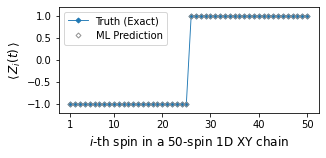

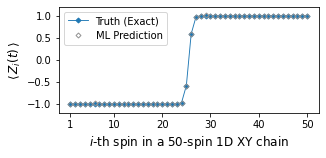

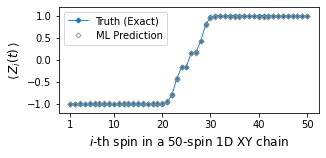

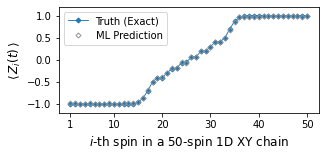

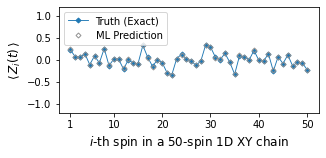

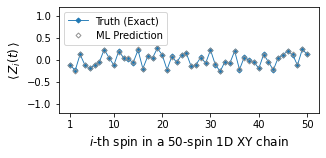

In [160]:
# Visualize half-half state

N = 50

def get_feat_vec_half_half(k):
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val = 0.0
                
                if (i+c) < N / 2: val *= -1
                else: val *= +1
                    
            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
true_ans = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999988,-0.999222,-0.972817,-0.585528,0.585528,0.972817,0.999222,0.999988,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999998,-0.999966,-0.999505,-0.994686,-0.959792,-0.801725,-0.43163,-0.166451,-0.157728,0.157728,0.166451,0.43163,0.801725,0.959792,0.994686,0.999505,0.999966,0.999998,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-0.999999,-0.999995,-0.999954,-0.999668,-0.997989,-0.989958,-0.959642,-0.873541,-0.703182,-0.501119,-0.407192,-0.406774,-0.297204,-0.200754,-0.193937,-0.0642642,-0.0604844,0.0604844,0.0642642,0.193937,0.200754,0.297204,0.406774,0.407192,0.501119,0.703182,0.873541,0.959642,0.989958,0.997989,0.999668,0.999954,0.999995,0.999999,1,1,1,1,1,1,1,1,0.223538,0.0704778,0.0547808,0.137909,-0.109168,0.0870547,-0.0704109,0.255476,-0.132473,0.0208235,0.0104076,-0.210476,0.00149826,-0.0734874,-0.0874279,0.326401,0.0580026,-0.146868,-0.00298605,-0.0620534,-0.292064,-0.337162,0.0267581,0.126973,0.0217619,-0.0217619,-0.126973,-0.0267581,0.337162,0.292064,0.0620534,0.00298605,0.146868,-0.0580026,-0.326401,0.0874279,0.0734874,-0.00149826,0.210476,-0.0104076,-0.0208235,0.132473,-0.255476,0.0704109,-0.0870547,0.109168,-0.137909,-0.0547808,-0.0704778,-0.223538,-0.122712,-0.239076,0.121464,-0.116011,-0.195256,-0.1169,-0.0462604,0.231811,0.0477476,-0.121555,0.194615,0.0496414,0.0103274,-0.0615695,0.220349,-0.198141,0.0778494,0.041073,0.261736,0.111922,-0.222931,0.0772192,-0.0577005,0.108646,0.147718,-0.147718,-0.108646,0.0577005,-0.0772192,0.222931,-0.111922,-0.261736,-0.041073,-0.0778494,0.198141,-0.220349,0.0615695,-0.0103274,-0.0496414,-0.194615,0.121555,-0.0477476,-0.231811,0.0462604,0.1169,0.195256,0.116011,-0.121464,0.239076,0.122712,]).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_half_half(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.2, 1.2])
#     plt.title(r"$| 111 \ldots 000 \rangle$" + r" at time $t = {}$".format(evo_time_list[i]))

    plt.tight_layout()
    plt.savefig('111000-allZ-{}.pdf'.format(i), dpi=900)
    

300


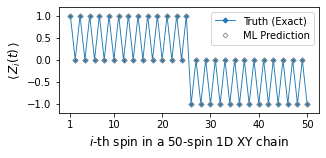

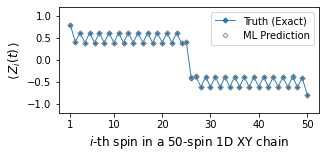

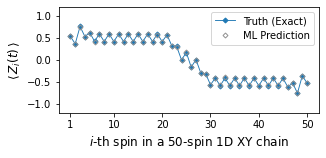

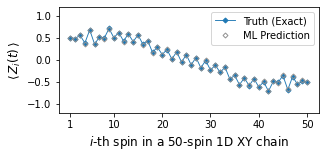

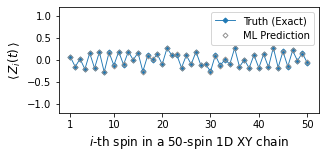

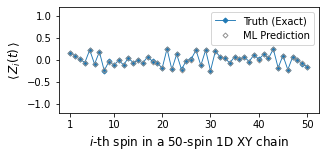

In [161]:
# Visualize entangled Neel state

N = 50

def get_feat_vec_GHZ_Neel(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val1 = 0.0
                
                if (i+c) % 2 == 1: val1 *= -1
                else: val1 *= +1

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                if P != 2: val2 = 0.0
                
                if (i+c) >= N / 2: val2 *= -1
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
true_ans = np.array([1,-3.33067e-16,1,-3.33067e-16,1,0,1,2.22045e-16,1,2.22045e-16,1,2.22045e-16,1,0,1,-1.11022e-16,1,0,1,-2.22045e-16,1,-1.11022e-16,1,0,1,-1,-6.66134e-16,-1,-2.22045e-16,-1,0,-1,-4.44089e-16,-1,-2.22045e-16,-1,-1.11022e-16,-1,-1.11022e-16,-1,0,-1,2.22045e-16,-1,2.22045e-16,-1,2.22045e-16,-1,2.22045e-16,-1,0.788362,0.405052,0.612547,0.388066,0.611946,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388055,0.611945,0.388048,0.611556,0.374463,0.404709,-0.404709,-0.374463,-0.611556,-0.388048,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611945,-0.388055,-0.611946,-0.388066,-0.612547,-0.405052,-0.788362,0.52933,0.361496,0.754613,0.525902,0.616209,0.418987,0.586335,0.414214,0.585828,0.414175,0.585825,0.414175,0.585825,0.414175,0.585825,0.414175,0.585824,0.414157,0.585578,0.411518,0.565721,0.315037,0.30164,-0.0025997,0.164689,-0.164689,0.0025997,-0.30164,-0.315037,-0.565721,-0.411518,-0.585578,-0.414157,-0.585824,-0.414175,-0.585825,-0.414175,-0.585825,-0.414175,-0.585825,-0.414175,-0.585828,-0.414214,-0.586335,-0.418987,-0.616209,-0.525902,-0.754613,-0.361496,-0.52933,0.503342,0.481823,0.555969,0.379553,0.676754,0.356992,0.510313,0.489078,0.709057,0.498859,0.617281,0.426286,0.584769,0.411879,0.563395,0.353266,0.435104,0.167047,0.287108,0.119875,0.232115,0.0168645,0.180481,-0.0513803,0.113755,-0.113755,0.0513803,-0.180481,-0.0168645,-0.232115,-0.119875,-0.287108,-0.167047,-0.435104,-0.353266,-0.563395,-0.411879,-0.584769,-0.426286,-0.617281,-0.498859,-0.709057,-0.489078,-0.510313,-0.356992,-0.676754,-0.379553,-0.555969,-0.481823,-0.503342,0.0641132,-0.156605,0.0212648,-0.211451,0.151916,-0.189812,0.176076,-0.276748,0.165638,-0.124994,0.182763,-0.109042,0.187432,-0.002042,0.159606,-0.263859,0.097639,-0.00387948,0.12612,-0.103179,0.263876,0.102068,0.119708,-0.18066,0.101832,-0.101832,0.18066,-0.119708,-0.102068,-0.263876,0.103179,-0.12612,0.00387948,-0.097639,0.263859,-0.159606,0.002042,-0.187432,0.109042,-0.182763,0.124994,-0.165638,0.276748,-0.176076,0.189812,-0.151916,0.211451,-0.0212648,0.156605,-0.0641132,0.15872,0.084307,0.00893069,-0.0615725,0.223252,-0.0967308,0.182103,-0.244717,-0.0320069,-0.122955,-0.0108487,-0.115121,0.0397093,-0.0642493,-0.0126599,-0.0731859,0.0733459,-0.0360828,-0.0679437,-0.190291,0.248513,-0.218302,0.125698,-0.218771,-0.016088,0.016088,0.218771,-0.125698,0.218302,-0.248513,0.190291,0.0679437,0.0360828,-0.0733459,0.0731859,0.0126599,0.0642493,-0.0397093,0.115121,0.0108487,0.122955,0.0320069,0.244717,-0.182103,0.0967308,-0.223252,0.0615725,-0.00893069,-0.084307,-0.15872,]).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_GHZ_Neel(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.2, 1.2])
#     plt.title(r"$\frac{1}{\sqrt{2}} | uu \ldots dd \rangle + \frac{1}{\sqrt{2}}| udud \ldots \rangle$" + r" at time $t = {}$".format(evo_time_list[i]))

    plt.tight_layout()
    plt.savefig('Neel-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

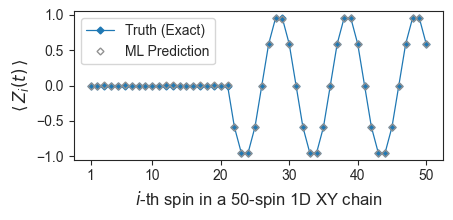

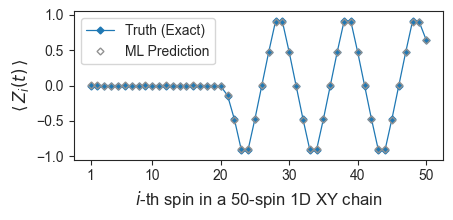

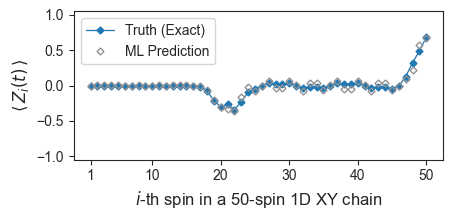

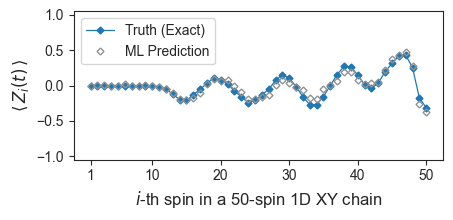

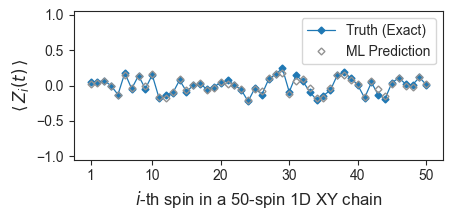

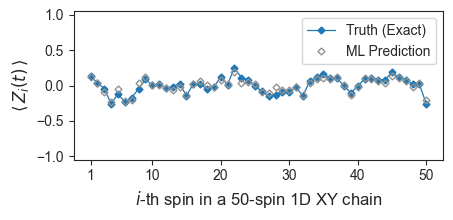

In [286]:
# Visualize W state

N = 50
scale = 3.0

def get_feat_vec_Entangled(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < 20:
                    if P != 0: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - 20)) / 30
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < 20:
                    if P != 0: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - 20)) / 30
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [-1.33227e-15,-9.99201e-16,-5.55112e-16,-1.11022e-15,-2.22045e-16,-6.66134e-16,-3.33067e-16,-5.55112e-16,-4.44089e-16,-4.44089e-16,-4.44089e-16,-1.11022e-16,-9.99201e-16,-7.77156e-16,-7.77156e-16,-8.88178e-16,-6.66134e-16,-8.88178e-16,-1.55431e-15,-1.11022e-15,-3.33067e-16,-0.587785,-0.951057,-0.951057,-0.587785,-7.77156e-16,0.587785,0.951057,0.951057,0.587785,2.22045e-16,-0.587785,-0.951057,-0.951057,-0.587785,-1.44329e-15,0.587785,0.951057,0.951057,0.587785,1.55431e-15,-0.587785,-0.951057,-0.951057,-0.587785,-2.77556e-15,0.587785,0.951057,0.951057,0.587785,1.23693e-09,-1.18242e-09,-2.22045e-16,-5.0973e-11,-3.51097e-12,-6.66134e-16,-2.86438e-14,2.88658e-15,-1.9984e-15,-2.10942e-15,0,1.55431e-15,1.9984e-15,-3.51941e-14,-1.69564e-12,-3.3124e-10,-4.65665e-08,-4.55288e-06,-0.000282417,-0.00967345,-0.141464,-0.480152,-0.90726,-0.906982,-0.470479,2.80743e-09,0.470479,0.906978,0.906978,0.470479,3.13666e-09,-0.470479,-0.906978,-0.906978,-0.470479,3.9968e-15,0.470479,0.906978,0.906978,0.470479,-3.69665e-10,-0.470479,-0.906978,-0.906978,-0.470479,-4.16475e-05,0.469544,0.908928,0.894072,0.643797,-3.52094e-10,1.77685e-09,1.55431e-15,2.74368e-09,-3.52092e-09,6.66134e-16,-5.66338e-10,-7.85829e-11,-7.66942e-13,-3.3301e-11,-1.0525e-09,-3.00228e-08,-7.00873e-07,-1.30575e-05,-0.00018838,-0.0020226,-0.0153012,-0.0753679,-0.214593,-0.30259,-0.263781,-0.339562,-0.232529,-0.0933044,-0.0522733,-0.00202258,0.0367837,0.0179235,0.0179358,0.036972,1.21569e-08,-0.0369721,-0.0179365,-0.0179365,-0.0369721,-1.10911e-13,0.0369721,0.0179365,0.0179365,0.036972,-2.2049e-06,-0.0370048,-0.0182925,-0.0205336,-0.0475969,-0.00960933,0.127346,0.318042,0.491566,0.680018,-2.51953e-10,-9.52393e-10,-1.56492e-09,-1.82514e-08,-2.27022e-07,-2.15299e-06,-1.82034e-05,-0.000131701,-0.000801645,-0.00402792,-0.0162984,-0.0514086,-0.120913,-0.199239,-0.211137,-0.132791,-0.0508541,0.029253,0.112162,0.0800971,0.0207406,-0.0760861,-0.159016,-0.241925,-0.207037,-0.132791,-0.0549536,0.0719396,0.150265,0.104775,-0.0162984,-0.160211,-0.27198,-0.271312,-0.15622,-0.000118119,0.155599,0.268883,0.264755,0.146866,0.0132259,-0.0423814,0.0361288,0.19502,0.313248,0.421725,0.432211,0.251384,-0.176082,-0.314243,0.04488,0.0475582,0.0705712,-0.00391528,-0.128828,0.177717,-0.0454162,0.139205,-0.0470074,0.149673,-0.17846,-0.129918,-0.106554,0.0771985,-0.0862278,0.00140352,0.0220758,-0.0527357,-0.0166446,0.0392979,0.0734952,0.00896325,-0.0619655,-0.2245,-0.0345697,-0.130262,0.0895834,0.157284,0.243013,-0.0903524,0.146047,0.0580688,-0.0891992,-0.204532,-0.141727,-0.0685656,0.142277,0.186667,0.106245,0.00729997,-0.175042,0.0430485,-0.131919,-0.186464,0.0403929,0.106612,0.0208504,0.00851356,0.115719,0.0111436,0.128465,0.0364219,-0.0424433,-0.258732,-0.118112,-0.235543,-0.171896,-0.048835,0.0897999,0.00470972,0.0190959,-0.041822,-0.0149158,0.0273092,-0.145442,0.0261904,0.0175673,-0.0475926,-0.0272873,0.125373,0.0124977,0.252649,0.112097,0.0788469,-0.0107116,-0.0795201,-0.155343,-0.128473,-0.0933882,-0.0890382,-0.0239084,-0.150032,0.0653788,0.120773,0.156574,0.106836,0.0995081,-0.00397812,-0.105693,-0.0100067,0.093005,0.101245,0.0836636,0.0823051,0.186772,0.113701,0.0844316,0.0146368,0.0187623,-0.255901,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.05, 1.05])

    plt.tight_layout()
    plt.savefig('Entangled-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

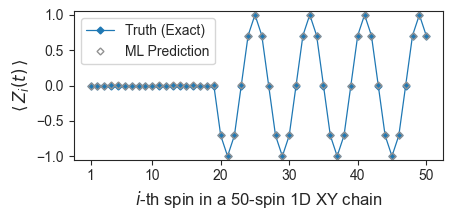

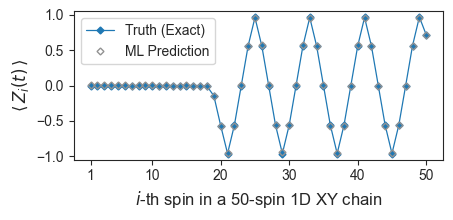

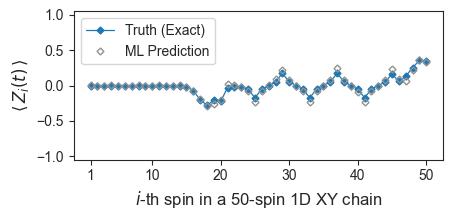

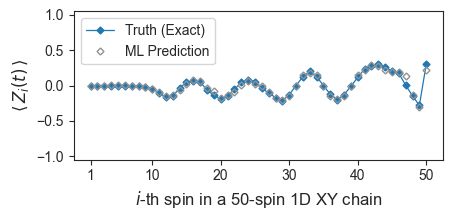

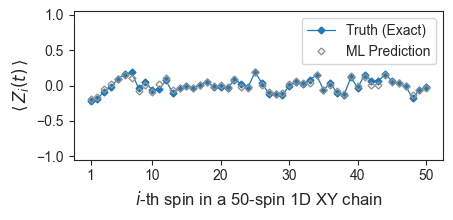

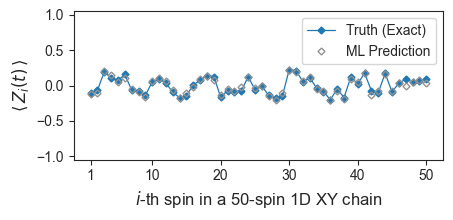

In [289]:
# Visualize Oscillating state

N = 50

scale = 4.0
oscillating_len = 32
entangled_len = N - oscillating_len

def get_feat_vec_W(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len)) / oscillating_len
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len)) / oscillating_len
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [-5.55112e-16,-6.66134e-16,-3.33067e-16,-6.66134e-16,0,-3.33067e-16,-1.11022e-16,-1.11022e-16,-4.44089e-16,-1.11022e-16,-1.11022e-16,-1.11022e-16,-4.44089e-16,-3.33067e-16,-1.11022e-16,-4.44089e-16,-3.33067e-16,-3.33067e-16,-6.66134e-16,-0.707107,-1,-0.707107,-3.33067e-16,0.707107,1,0.707107,-6.66134e-16,-0.707107,-1,-0.707107,-4.44089e-16,0.707107,1,0.707107,-3.33067e-16,-0.707107,-1,-0.707107,-2.77556e-15,0.707107,1,0.707107,-1.11022e-15,-0.707107,-1,-0.707107,-2.66454e-15,0.707107,1,0.707107,0,-5.55112e-16,-1.22125e-15,-9.99201e-16,0,-3.33067e-16,2.22045e-16,0,-2.10942e-15,-1.77636e-15,1.33227e-15,-5.10703e-15,-1.5925e-12,-3.11422e-10,-4.44776e-08,-4.38862e-06,-0.000275565,-0.00963552,-0.147044,-0.56874,-0.96253,-0.559109,-4.16168e-08,0.559104,0.962255,0.559104,1.33227e-15,-0.559104,-0.962255,-0.559104,-2.01598e-09,0.559104,0.962255,0.559104,-2.01598e-09,-0.559104,-0.962255,-0.559104,3.33067e-15,0.559104,0.962255,0.559104,2.74466e-09,-0.559105,-0.962256,-0.559161,-0.000999399,0.562674,0.968682,0.717039,2.66454e-15,1.55431e-15,-8.21565e-15,-4.77396e-15,1.77636e-15,-1.64313e-14,-7.62834e-13,-2.86574e-11,-9.83163e-10,-2.81194e-08,-6.57331e-07,-1.22692e-05,-0.000177372,-0.00190871,-0.0144726,-0.0713878,-0.202568,-0.277234,-0.210429,-0.224771,-0.0298034,-0.0189252,-0.0144726,-0.0543713,-0.172942,-0.0524749,-6.57372e-07,0.0524626,0.172765,0.0524626,1.60704e-09,-0.0524626,-0.172765,-0.0524626,1.60771e-09,0.0524626,0.172765,0.0524626,-1.26962e-08,-0.0524629,-0.17277,-0.0525289,-0.000621166,0.0487576,0.162028,0.059554,0.128932,0.251019,0.354465,0.34189,-1.64891e-09,-1.80879e-08,-2.03576e-07,-1.98558e-06,-1.67752e-05,-0.000121095,-0.000735011,-0.00367672,-0.0147676,-0.0459711,-0.10537,-0.163749,-0.146579,-0.0407221,0.0427528,0.0699782,0.0522136,-0.0655041,-0.137071,-0.190526,-0.148734,-0.0550436,0.0427527,0.0842996,0.0543686,-0.0387276,-0.10537,-0.170993,-0.215715,-0.128698,-0.000735046,0.124901,0.20093,0.125012,-5.35602e-05,-0.12533,-0.202373,-0.129992,-0.0115816,0.114316,0.23493,0.28248,0.307373,0.260138,0.204349,0.172876,0.00395937,-0.145266,-0.282008,0.297803,-0.214572,-0.184999,-0.0858761,-0.0189614,0.0970766,0.159462,0.184308,-0.0371108,0.0431076,-0.0620992,-0.0533646,0.0711563,-0.105234,-0.0412968,-0.00540601,-0.0321334,0.00893819,0.0564909,-0.0228622,-0.0270342,-0.0390996,0.0786328,0.0274031,-0.0230434,0.188251,0.0373823,-0.114784,-0.118867,-0.135593,-0.00545273,0.0490424,0.0261038,0.0789864,0.149492,-0.0646498,0.0359345,-0.106258,-0.136215,0.117361,-0.0348563,0.152954,0.0624063,0.0612586,0.158723,0.0652991,0.0293106,-0.00661968,-0.178976,-0.0625079,-0.0212084,-0.107264,-0.0704725,0.193965,0.108294,0.0717049,0.156469,-0.0648497,-0.072299,-0.139204,0.0490899,0.0910658,0.0349663,-0.0954868,-0.172838,-0.141793,0.00729624,0.0761089,0.139629,0.126779,-0.165521,-0.0712546,-0.0862275,-0.077053,0.123855,-0.057867,-0.00401261,-0.139977,-0.171911,-0.152037,0.225867,0.210818,0.0540612,0.112161,-0.0380994,-0.084963,-0.202104,-0.0479781,-0.171457,0.122403,0.0217878,0.175638,-0.0748639,-0.102267,0.172358,-0.0882058,0.0305625,0.0908711,0.0497088,0.0588678,0.0956785,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend()
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.05, 1.05])

    plt.tight_layout()
    plt.savefig('Entangled-4-allZ-{}.pdf'.format(i), dpi=900)
    

300


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

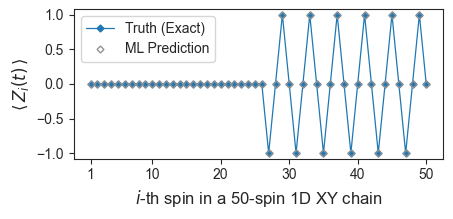

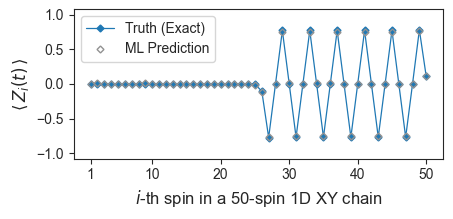

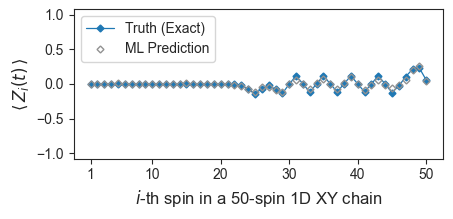

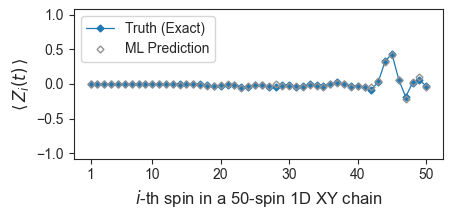

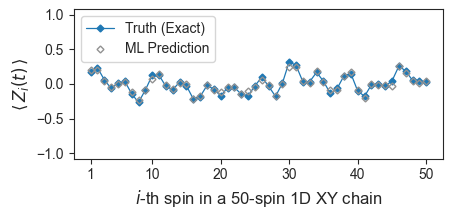

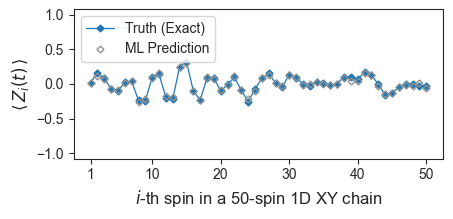

In [292]:
# Visualize Oscillating state

N = 50

scale = 0.25
oscillating_len = 25
entangled_len = N - oscillating_len

def get_feat_vec_W(k):
    assert(k < N / 2)
    feat_vec = []
    for i in range(N-k+1):
        for list_P in itertools.product([-1, 0, 1, 2], repeat=k):
            val1 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val1 = 0.0
                    else: val1 *= -1
                else:
                    if P == 1: val1 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len))
                    if P == 0:
                        val1 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val1 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))

            val2 = 1.0
            
            for c, P in enumerate(list_P):
                if P == -1: continue
                
                if (i+c) < entangled_len:
                    if P != 2: val2 = 0.0
                    else: val2 *= +1
                else:
                    if P == 1: val2 = 0.0
                        
                    theta = np.pi/4 + (scale * np.pi * (i+c - entangled_len))
                    if P == 0:
                        val2 *= (np.cos(theta) * np.sin(theta) + np.sin(theta) * np.cos(theta))
                    if P == 2:
                        val2 *= (np.cos(theta) * np.cos(theta) - np.sin(theta) * np.sin(theta))
                    
            val = (val1 + val2) / 2

            assert(np.abs(val.imag) < 1e-7)
            feat_vec.append(val.real)
    return feat_vec

evo_time_list = [0, 1, 4, 10, 1000, 1000000]
ls = [0,-1.11022e-16,2.22045e-16,-1.11022e-16,6.66134e-16,2.22045e-16,4.44089e-16,4.44089e-16,0,4.44089e-16,4.44089e-16,4.44089e-16,0,2.22045e-16,4.44089e-16,0,2.22045e-16,2.22045e-16,-4.44089e-16,0,4.44089e-16,0,4.44089e-16,2.22045e-16,2.22045e-16,6.66134e-16,-1,-2.22045e-16,1,4.44089e-16,-1,-4.44089e-16,1,2.22045e-16,-1,-2.33147e-15,1,-8.88178e-16,-1,-2.66454e-15,1,-3.33067e-16,-1,-2.88658e-15,1,2.22045e-16,-1,-2.33147e-15,1,0,6.66134e-16,0,-6.66134e-16,-4.44089e-16,6.66134e-16,2.22045e-16,6.66134e-16,4.44089e-16,-1.55431e-15,-9.99201e-16,1.77636e-15,1.55431e-15,-7.77156e-16,-7.77156e-16,0,-1.22125e-15,6.66134e-16,1.77636e-15,2.66454e-15,-3.14748e-13,-6.3195e-11,-1.05254e-08,-1.24763e-06,-9.81398e-05,-0.0045927,-0.105622,-0.774579,-9.81411e-05,0.769985,-1.05219e-08,-0.769987,1.35209e-09,0.769987,1.35238e-09,-0.769987,2.22045e-15,0.769987,-1.35238e-09,-0.769987,-1.35239e-09,0.769987,-7.99361e-15,-0.769987,1.147e-09,0.769987,-2.37629e-06,-0.770101,-0.00201803,0.779289,0.107839,3.33067e-15,1.9984e-15,-7.77156e-15,-3.33067e-15,4.44089e-15,-8.88178e-16,1.9984e-15,4.88498e-15,-8.65974e-15,-7.88258e-15,9.54792e-15,7.99361e-15,-1.22125e-15,-6.55032e-15,-3.15847e-12,-1.15585e-10,-3.68859e-09,-9.51021e-08,-1.98227e-06,-3.2461e-05,-0.000403052,-0.00361448,-0.0218106,-0.079066,-0.139189,-0.0699091,-0.022901,-0.079066,-0.138098,-0.00361448,0.115885,-3.24485e-05,-0.11629,-8.31988e-08,0.116288,-1.17724e-10,-0.116288,-1.19193e-08,0.116288,-3.2007e-08,-0.116288,-8.65716e-06,0.116165,-0.00125065,-0.124702,-0.0301418,0.102946,0.211788,0.2284,0.0549484,2.22045e-16,0,-5.10703e-15,-2.5091e-14,6.66134e-16,-4.29434e-13,-6.75471e-12,-1.01429e-10,-1.41485e-09,-1.66839e-08,-1.73902e-07,-1.57113e-06,-1.21947e-05,-8.00841e-05,-0.000436652,-0.00192916,-0.00668157,-0.0173003,-0.0311014,-0.0342591,-0.0198314,-0.0173505,-0.0420583,-0.0419752,-0.0202404,-0.0225374,-0.0421339,-0.0419752,-0.0201647,-0.0173504,-0.041725,-0.0342592,-0.00920796,-0.0173018,-0.0285877,-0.00202041,0.020899,-0.00288813,-0.0331993,-0.0346213,-0.0519068,-0.0824906,0.0274971,0.326942,0.432659,0.0577022,-0.187023,0.0133466,0.0532551,-0.0296511,0.167654,0.235669,0.059428,-0.0647698,0.00977301,0.0359311,-0.142181,-0.268125,-0.08796,0.12132,0.123859,-0.0365826,-0.0825699,0.0243864,-0.0286014,-0.217735,-0.182816,-0.0233282,-0.0754973,-0.174467,-0.0535967,-0.0515959,-0.148926,-0.169623,-0.0281208,0.0987317,-0.0348927,-0.180714,0.0084423,0.319679,0.266015,0.0292598,0.0332248,0.16749,0.0365815,-0.137161,-0.0667869,0.118105,0.148816,-0.103928,-0.179366,-0.0127684,-0.00616234,-0.0335855,0.0411815,0.253788,0.18819,0.0495114,0.0343125,0.0205118,0.0190869,0.158465,0.0807447,-0.0769012,-0.104517,0.0260456,0.0361047,-0.23948,-0.242446,0.0959721,0.142571,-0.201348,-0.216818,0.245565,0.317963,-0.102833,-0.232337,0.08118,0.084799,-0.105552,-0.00880639,0.0923163,-0.089633,-0.2577,-0.0768566,0.0812138,0.150611,0.0129071,-0.0417149,0.134226,0.0912652,-0.00312032,-0.0284457,0.0284919,0.0180958,-0.0224571,0.00262732,0.103439,0.0929488,0.0665141,0.16849,0.127639,-0.00581823,-0.160224,-0.136392,-0.0476056,0.00417718,-0.00822495,-0.0256998,-0.0285305,]
true_ans = np.array(ls).reshape(-1, N)

print(len(list_of_score_HXY_vis))
for i in range(6):
    f = plt.figure(figsize=(4.63, 2.3))
    
    pred_ans = [list_of_clf_HXY_vis[t].predict(np.array([get_feat_vec_W(list_of_bestk_HXY_vis[t])]))[0] for t in range(50*i, 50*(i+1))]
    
    plt.plot(range(1, 51), true_ans[i, :], 'D', linestyle='-', linewidth=0.9, label='Truth (Exact)', markersize=3.5, c='#1F78B4', alpha=1.0)
    plt.plot(range(1, 51), pred_ans, 'D', mfc='none', label='ML Prediction', markersize=3.5, c='#929292', alpha=1.0)

    plt.xlabel(r"$i$-th spin in a 50-spin 1D XY chain", fontsize=12)
    plt.ylabel(r"$\langle \, Z_i(t) \, \rangle$".format(evo_time_list[i]), fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks([1, 10, 20, 30, 40, 50])
    plt.ylim([-1.08, 1.08])

    plt.tight_layout()
    plt.savefig('Entangled-8-allZ-{}.pdf'.format(i), dpi=900)
    